In [1]:
import random
import gym
import time
import logging
import gym_minigrid
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import nd, autograd
from mxnet import gluon
from IPython import display
from memory import Memory
from utils import preprocess

### Summary of the algorithm
#### Update Network
* Draw batches of tuples from the replay buffer: $(\phi,r,a,\phi')$.
* Define the following loss
$$\Large(\small Q(\phi,a,\theta)-r-Q(\phi',argmax_{a'}Q(\phi',a',\theta),\theta^-)\Large)^2$$
* Where $\theta^-$ is the parameter of the target network.( Set $Q(\phi',a',\theta^-)$ to zero if $\phi$ is the preprocessed termination state). 
* Update the $\theta$
* Update the $\theta^-$ once in a while








## Set the hyper-parameters

In [3]:
# frame channel
channel = 3
# The size of the batch to learn the Q-function
batch_size = 8
# Resize the raw input frame to square frame of size 80 by 80
image_size = 84
# Skip 4-1 raw frames between steps
skip_frame = 1
# The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
replay_buffer_size = 100000
# 50K * 16 Frame * 3 Channel = 38GB
# With Freq of 1/4-step update the Q-network
learning_frequency = 4
# Each state is formed as a concatenation 4 step frames [f(t-12),f(t-8),f(t-4),f(t)]
frame_len = 4
# Update the target network each 10000 steps
target_update = 10000
# Minimum level of stochasticity of policy (epsilon)-greedy
epsilon_min = 0.01
# The number of step it take to linearly anneal the epsilon to it min value
annealing_end = 1000000.
# The discount factor
gamma = 0.99
# Start to back propagated through the network, learning starts
replay_start_size = 50000
# Run uniform policy for first 30 times step of the beginning of the game
no_op_max = 4
# Number episode to run the algorithm
num_episode = 10000000
max_frame = 2000000
# RMSprop learning rate
lr = 0.0001
# RMSprop gamma1
gamma1 = 0.95
# RMSprop gamma2
gamma2 = 0.95
# RMSprop epsilon bias
rms_eps = 0.01
# Enables gpu if available, if not, set it to mx.cpu()
ctx = mx.gpu()

In [39]:
env_name = 'MiniGrid-Empty-Random-6x6-v0'
env = gym.make(env_name)
num_action = 3
manualSeed = 1
mx.random.seed(manualSeed)
env_name = env_name + "-Map-Frame_%d-Channel_%d" %(frame_len, channel)

In [6]:
from mxnet.gluon import nn, rnn
from mxnet import nd

In [7]:
class SimpleStack(nn.Block):
    def __init__(self, actions, frames, channel=3):
        self.frames = frames
        self.channel = channel
        super(SimpleStack, self).__init__()
        c = [64, 128, 128]
        k = [8, 4, 3]
        s = [4, 2, 1]
        with self.name_scope():
            self.map = nn.Sequential()
            self.out = nn.Sequential()
            with self.map.name_scope():
                for i, j, z in zip(c, k, s):
                    self.map.add(nn.Conv2D(channels=i, kernel_size=j, strides=z, padding=0, layout="NCHW"))
                    self.map.add(nn.BatchNorm(axis=1, momentum=0.1, center=True))
                    self.map.add(nn.Activation("tanh"))
                self.map.add(nn.Flatten())
            with self.out.name_scope():
                self.out.add(nn.Dense(512, activation="tanh"))
                self.out.add(nn.Dense(actions))

    def forward(self, memory, battery, *args):
        _b, _c, _h, _w = memory.shape
        # image part
        _features = self.map(memory).reshape([_b, self.frames, -1])
        # # battery part
        # _battery = nd.expand_dims(_battery, axis=1)
        # _battery = _battery.transpose([0, 2, 1])
        return self.out(_features)

In [8]:
dqn = SimpleStack(num_action, frame_len, channel=channel)
dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
trainer = gluon.Trainer(dqn.collect_params(), 'RMSProp',
                        {'learning_rate': lr, 'gamma1': gamma1, 'gamma2': gamma2, 'epsilon': rms_eps, 'centered': True})
dqn.collect_params().zero_grad()

In [9]:
target_dqn = SimpleStack(num_action, frame_len, channel=channel)
target_dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)

In [10]:
loss_f = mx.gluon.loss.L2Loss(batch_axis=0)
# Counts the number of steps so far
frame_counter = 0.
# Counts the number of annealing steps
annealing_count = 0.
# Counts the number episodes so far
epis_count = 0.
# Initialize the replay buffer
replay_memory = Memory(replay_buffer_size, frame_len, channel)
tot_clipped_reward = []
tot_reward = []
frame_count_record = []
t_record = []
moving_average_clipped = 0.
moving_average = 0.

In [12]:
# tot_reward = np.load("tot_clipped_reward.npy")
# tot_reward = np.load("tot_reward.npy")
# frame_count_record = np.load("frame_count_record.npy")
# t_record = np.load("t_record.npy")
# frame_counter = len(t_record) * 85
# annealing_count = len(t_record) * 85
# epis_count = len(t_record)
# replay_memory = Memory(replay_buffer_size, frame_len, channel)
# with open("./memory", "rb") as f:
#     _ = pickle.load(f)
# for i in _:
#     replay_memory.push(*i)
#     del i

### Train the model

In [17]:
def rew_clipper(row, history):
    counter = 0
    _ = list(reversed(history))[0]
    for i in list(reversed(history))[1:]:
        if i == _:
            counter += 1
        else:
            break
    return (row- 0.0001 * counter) * 100

def render_image(frame, render):
    if render:
        plt.figure(figsize=(5,5))
        plt.imshow(frame)
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.1)

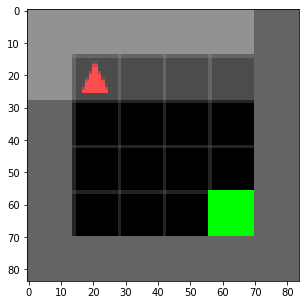

In [38]:
state, current_frame = preprocess(env.render(False), image_size, channel, frame_len, initial_state=True)
_ = current_frame.asnumpy().transpose([1,2,0])
# _ = np.concatenate([current_frame.asnumpy(), current_frame.asnumpy(), current_frame.asnumpy()]).transpose([1,2,0])
render_image(_, True)

In [31]:
 # Whether to render Frames and show the game
_render = False
while epis_count < max_frame:
    cum_clipped_reward = 0
    cum_reward = 0
    env.reset()
    next_frame = env.env.render(False)
    state, current_frame = preprocess(next_frame, image_size, channel, frame_len, initial_state=True)
    t = 0.
    done = False
    initial_state = True
    location = [env.env.agent_pos.tolist()]
    while not done:
        previous_state = state
        # show the frame
        render_image(current_frame.asnumpy().transpose([1,2,0]), _render)
        sample = random.random()
        if frame_counter > replay_start_size:
            annealing_count += 1
        if frame_counter == replay_start_size:
            print("annealing and learning are started tot = %.4f" % moving_average)
        eps = np.maximum(1. - annealing_count / annealing_end, epsilon_min)

        effective_eps = eps
        if t < no_op_max:
            effective_eps = 1.
        step_count = env.env.max_steps - env.env.step_count
        # epsilon greedy policy
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = [nd.array(state.reshape([1, frame_len * channel, image_size, image_size]), ctx), nd.array([step_count], ctx)]
            action = int(nd.argmax(dqn(*data), axis=1).as_in_context(mx.cpu()).asscalar())
            
        # Skip frame
        rew = 0
        for skip in range(skip_frame):
            next_frame, reward, done, _ = env.step(action)
            next_frame = env.env.render(False)
            render_image(next_frame, _render)
            cum_clipped_reward += rew_clipper(reward, location)
            rew += reward
            location.append(env.env.agent_pos.tolist())
        cum_reward += rew
        
        # Reward clipping
        reward = rew_clipper(rew, location)
        
        # End Reward clipping
        
        # _ = env.env.get_obs_render(env.env.gen_obs()["image"])
        _ = env.env.render(False)
        state, current_frame = preprocess(_, image_size, channel, frame_len, current_state=state) 
        replay_memory.push((previous_state * 255.).astype('uint8'), action, (state * 255.).astype('uint8'), reward, done, step_count)
        # Train
        if frame_counter > replay_start_size and frame_counter % learning_frequency == 0:
            batch = replay_memory.sample(batch_size, ctx)
            batch_state = batch.state.astype('float32') / 255
            batch_state_next = batch.state_next.astype('float32') / 255
            batch_action = batch.action.astype('uint8')
            batch_battery  = batch.battery
            batch_reward = batch.reward
            batch_finish = batch.finish
            with autograd.record():
                argmax_Q = nd.argmax(dqn(batch_state_next, batch_battery),axis = 1).astype('uint8')
                Q_sp = nd.pick(target_dqn(batch_state_next, batch_battery),argmax_Q,1)
                Q_sp = Q_sp*(nd.ones(batch_size,ctx = ctx)-batch_finish)
                Q_s_array = dqn(batch_state, batch_battery)
                Q_s = nd.pick(Q_s_array,batch_action,1)
                loss = nd.mean(loss_f(Q_s ,  (batch_reward + gamma *Q_sp)))
            loss.backward()
            trainer.step(batch_size)
        t += 1
        frame_counter += 1
        # Save the model and update Target model
        if frame_counter >replay_start_size and frame_counter % target_update == 0:
            check_point = frame_counter / (target_update * 10)
            file_name = './model_save/target_%s_%d' % (env_name, int(check_point))
            dqn.save_parameters(file_name)
            target_dqn.load_parameters(file_name, ctx)
        if done:
            t_record.append(t+1)
            if epis_count % 50. == 0. :
                print('epis[%d],eps[%.4f],durat[%d],fnum=%d,tot_cl = %.4f , tot = %.4f' %(epis_count,eps,np.mean(t_record),frame_counter,moving_average_clipped,moving_average))
    epis_count += 1
    tot_clipped_reward = np.append(tot_clipped_reward, cum_clipped_reward)
    tot_reward = np.append(tot_reward, cum_reward)
    frame_count_record = np.append(frame_count_record,frame_counter)
    if epis_count > 100.:
        moving_average_clipped = np.mean(tot_clipped_reward[int(epis_count)-1-100:int(epis_count)-1])
        moving_average = np.mean(tot_reward[int(epis_count)-1-100:int(epis_count)-1])

epis[46850],eps[0.1648],durat[19],fnum=885163,tot_cl = 94.0586 , tot = 0.9417
epis[46900],eps[0.1644],durat[19],fnum=885629,tot_cl = 93.8983 , tot = 0.9401
epis[46950],eps[0.1639],durat[19],fnum=886114,tot_cl = 93.9446 , tot = 0.9406
epis[47000],eps[0.1634],durat[19],fnum=886604,tot_cl = 93.8073 , tot = 0.9393
epis[47050],eps[0.1628],durat[19],fnum=887157,tot_cl = 93.3301 , tot = 0.9347
epis[47100],eps[0.1624],durat[19],fnum=887612,tot_cl = 93.5517 , tot = 0.9368
epis[47150],eps[0.1619],durat[19],fnum=888056,tot_cl = 94.2342 , tot = 0.9434
epis[47200],eps[0.1614],durat[19],fnum=888573,tot_cl = 93.9349 , tot = 0.9406
epis[47250],eps[0.1610],durat[19],fnum=889023,tot_cl = 93.8335 , tot = 0.9396
epis[47300],eps[0.1605],durat[19],fnum=889519,tot_cl = 93.8392 , tot = 0.9397
epis[47350],eps[0.1600],durat[19],fnum=890027,tot_cl = 93.6608 , tot = 0.9380
epis[47400],eps[0.1595],durat[19],fnum=890514,tot_cl = 93.7184 , tot = 0.9385
epis[47450],eps[0.1590],durat[19],fnum=890968,tot_cl = 94.0425 ,

epis[52150],eps[0.1153],durat[18],fnum=934709,tot_cl = 94.4007 , tot = 0.9451
epis[52200],eps[0.1148],durat[18],fnum=935163,tot_cl = 94.3377 , tot = 0.9444
epis[52250],eps[0.1144],durat[18],fnum=935625,tot_cl = 94.0979 , tot = 0.9421
epis[52300],eps[0.1140],durat[18],fnum=936039,tot_cl = 94.4138 , tot = 0.9452
epis[52350],eps[0.1135],durat[18],fnum=936503,tot_cl = 94.4639 , tot = 0.9458
epis[52400],eps[0.1130],durat[18],fnum=936982,tot_cl = 94.0280 , tot = 0.9416
epis[52450],eps[0.1126],durat[18],fnum=937435,tot_cl = 94.0091 , tot = 0.9413
epis[52500],eps[0.1121],durat[18],fnum=937896,tot_cl = 94.1328 , tot = 0.9424
epis[52550],eps[0.1116],durat[18],fnum=938353,tot_cl = 94.1462 , tot = 0.9426
epis[52600],eps[0.1112],durat[18],fnum=938788,tot_cl = 94.3445 , tot = 0.9446
epis[52650],eps[0.1108],durat[18],fnum=939236,tot_cl = 94.3876 , tot = 0.9449
epis[52700],eps[0.1103],durat[18],fnum=939676,tot_cl = 94.2954 , tot = 0.9439
epis[52750],eps[0.1099],durat[18],fnum=940114,tot_cl = 94.4353 ,

epis[57450],eps[0.0677],durat[18],fnum=982278,tot_cl = 94.1696 , tot = 0.9429
epis[57500],eps[0.0673],durat[18],fnum=982721,tot_cl = 94.3866 , tot = 0.9449
epis[57550],eps[0.0668],durat[18],fnum=983157,tot_cl = 94.4217 , tot = 0.9452
epis[57600],eps[0.0664],durat[18],fnum=983588,tot_cl = 94.4300 , tot = 0.9453
epis[57650],eps[0.0660],durat[18],fnum=984022,tot_cl = 94.5211 , tot = 0.9461
epis[57700],eps[0.0656],durat[18],fnum=984433,tot_cl = 94.6218 , tot = 0.9471
epis[57750],eps[0.0652],durat[18],fnum=984841,tot_cl = 94.7541 , tot = 0.9485
epis[57800],eps[0.0647],durat[18],fnum=985258,tot_cl = 94.7671 , tot = 0.9486
epis[57850],eps[0.0643],durat[18],fnum=985687,tot_cl = 94.6618 , tot = 0.9476
epis[57900],eps[0.0639],durat[18],fnum=986128,tot_cl = 94.4386 , tot = 0.9454
epis[57950],eps[0.0634],durat[18],fnum=986554,tot_cl = 94.4476 , tot = 0.9455
epis[58000],eps[0.0630],durat[18],fnum=987014,tot_cl = 94.4153 , tot = 0.9451
epis[58050],eps[0.0626],durat[18],fnum=987441,tot_cl = 94.3584 ,

epis[62700],eps[0.0224],durat[17],fnum=1027633,tot_cl = 94.5239 , tot = 0.9462
epis[62750],eps[0.0219],durat[17],fnum=1028070,tot_cl = 94.4965 , tot = 0.9459
epis[62800],eps[0.0215],durat[17],fnum=1028491,tot_cl = 94.5490 , tot = 0.9464
epis[62850],eps[0.0211],durat[17],fnum=1028909,tot_cl = 94.6581 , tot = 0.9476
epis[62900],eps[0.0207],durat[17],fnum=1029329,tot_cl = 94.6691 , tot = 0.9477
epis[62950],eps[0.0203],durat[17],fnum=1029743,tot_cl = 94.6218 , tot = 0.9472
epis[63000],eps[0.0199],durat[17],fnum=1030145,tot_cl = 94.7646 , tot = 0.9486
epis[63050],eps[0.0194],durat[17],fnum=1030571,tot_cl = 94.8162 , tot = 0.9491
epis[63100],eps[0.0190],durat[17],fnum=1030993,tot_cl = 94.6284 , tot = 0.9473
epis[63150],eps[0.0186],durat[17],fnum=1031420,tot_cl = 94.5553 , tot = 0.9465
epis[63200],eps[0.0182],durat[17],fnum=1031840,tot_cl = 94.5943 , tot = 0.9469
epis[63250],eps[0.0177],durat[17],fnum=1032289,tot_cl = 94.4781 , tot = 0.9457
epis[63300],eps[0.0173],durat[17],fnum=1032701,tot_c

epis[67900],eps[0.0100],durat[16],fnum=1071677,tot_cl = 94.7414 , tot = 0.9483
epis[67950],eps[0.0100],durat[16],fnum=1072115,tot_cl = 94.5743 , tot = 0.9466
epis[68000],eps[0.0100],durat[16],fnum=1072565,tot_cl = 94.3619 , tot = 0.9447
epis[68050],eps[0.0100],durat[16],fnum=1073003,tot_cl = 94.3697 , tot = 0.9447
epis[68100],eps[0.0100],durat[16],fnum=1073426,tot_cl = 94.5135 , tot = 0.9460
epis[68150],eps[0.0100],durat[16],fnum=1073869,tot_cl = 94.5165 , tot = 0.9461
epis[68200],eps[0.0100],durat[16],fnum=1074297,tot_cl = 94.4722 , tot = 0.9457
epis[68250],eps[0.0100],durat[16],fnum=1074718,tot_cl = 94.5305 , tot = 0.9464
epis[68300],eps[0.0100],durat[16],fnum=1075131,tot_cl = 94.6978 , tot = 0.9480
epis[68350],eps[0.0100],durat[16],fnum=1075540,tot_cl = 94.8041 , tot = 0.9490
epis[68400],eps[0.0100],durat[16],fnum=1075948,tot_cl = 94.8080 , tot = 0.9490
epis[68450],eps[0.0100],durat[16],fnum=1076354,tot_cl = 94.8022 , tot = 0.9489
epis[68500],eps[0.0100],durat[16],fnum=1076786,tot_c

epis[73100],eps[0.0100],durat[16],fnum=1115977,tot_cl = 94.5400 , tot = 0.9464
epis[73150],eps[0.0100],durat[16],fnum=1116400,tot_cl = 94.5674 , tot = 0.9466
epis[73200],eps[0.0100],durat[16],fnum=1116794,tot_cl = 94.6951 , tot = 0.9479
epis[73250],eps[0.0100],durat[16],fnum=1117234,tot_cl = 94.6543 , tot = 0.9475
epis[73300],eps[0.0100],durat[16],fnum=1117646,tot_cl = 94.6497 , tot = 0.9475
epis[73350],eps[0.0100],durat[16],fnum=1118097,tot_cl = 94.5216 , tot = 0.9462
epis[73400],eps[0.0100],durat[16],fnum=1118521,tot_cl = 94.4864 , tot = 0.9457
epis[73450],eps[0.0100],durat[16],fnum=1118936,tot_cl = 94.5925 , tot = 0.9467
epis[73500],eps[0.0100],durat[16],fnum=1119370,tot_cl = 94.5867 , tot = 0.9468
epis[73550],eps[0.0100],durat[16],fnum=1119779,tot_cl = 94.7160 , tot = 0.9481
epis[73600],eps[0.0100],durat[16],fnum=1120187,tot_cl = 94.7896 , tot = 0.9488
epis[73650],eps[0.0100],durat[16],fnum=1120628,tot_cl = 94.5944 , tot = 0.9469
epis[73700],eps[0.0100],durat[16],fnum=1121058,tot_c

epis[78300],eps[0.0100],durat[15],fnum=1160575,tot_cl = 94.1543 , tot = 0.9426
epis[78350],eps[0.0100],durat[15],fnum=1161007,tot_cl = 94.1653 , tot = 0.9427
epis[78400],eps[0.0100],durat[15],fnum=1161432,tot_cl = 94.5173 , tot = 0.9461
epis[78450],eps[0.0100],durat[15],fnum=1161877,tot_cl = 94.4709 , tot = 0.9457
epis[78500],eps[0.0100],durat[15],fnum=1162289,tot_cl = 94.5540 , tot = 0.9465
epis[78550],eps[0.0100],durat[15],fnum=1162738,tot_cl = 94.5092 , tot = 0.9460
epis[78600],eps[0.0100],durat[15],fnum=1163171,tot_cl = 94.4210 , tot = 0.9452
epis[78650],eps[0.0100],durat[15],fnum=1163633,tot_cl = 94.3054 , tot = 0.9441
epis[78700],eps[0.0100],durat[15],fnum=1164078,tot_cl = 94.2655 , tot = 0.9437
epis[78750],eps[0.0100],durat[15],fnum=1164513,tot_cl = 94.3695 , tot = 0.9447
epis[78800],eps[0.0100],durat[15],fnum=1164975,tot_cl = 94.2824 , tot = 0.9438
epis[78850],eps[0.0100],durat[15],fnum=1165413,tot_cl = 94.2934 , tot = 0.9439
epis[78900],eps[0.0100],durat[15],fnum=1165863,tot_c

epis[83500],eps[0.0100],durat[15],fnum=1205824,tot_cl = 94.4008 , tot = 0.9449
epis[83550],eps[0.0100],durat[15],fnum=1206271,tot_cl = 94.4250 , tot = 0.9452
epis[83600],eps[0.0100],durat[15],fnum=1206704,tot_cl = 94.3695 , tot = 0.9446
epis[83650],eps[0.0100],durat[15],fnum=1207126,tot_cl = 94.5161 , tot = 0.9461
epis[83700],eps[0.0100],durat[15],fnum=1207547,tot_cl = 94.6708 , tot = 0.9476
epis[83750],eps[0.0100],durat[15],fnum=1208001,tot_cl = 94.4520 , tot = 0.9455
epis[83800],eps[0.0100],durat[15],fnum=1208450,tot_cl = 94.2584 , tot = 0.9436
epis[83850],eps[0.0100],durat[15],fnum=1208868,tot_cl = 94.4914 , tot = 0.9459
epis[83900],eps[0.0100],durat[15],fnum=1209300,tot_cl = 94.6224 , tot = 0.9472
epis[83950],eps[0.0100],durat[15],fnum=1209743,tot_cl = 94.4277 , tot = 0.9452
epis[84000],eps[0.0100],durat[15],fnum=1210180,tot_cl = 94.3469 , tot = 0.9444
epis[84050],eps[0.0100],durat[15],fnum=1210633,tot_cl = 94.3305 , tot = 0.9442
epis[84100],eps[0.0100],durat[15],fnum=1211098,tot_c

epis[88700],eps[0.0100],durat[15],fnum=1250976,tot_cl = 94.5966 , tot = 0.9469
epis[88750],eps[0.0100],durat[15],fnum=1251413,tot_cl = 94.5748 , tot = 0.9468
epis[88800],eps[0.0100],durat[15],fnum=1251849,tot_cl = 94.4854 , tot = 0.9459
epis[88850],eps[0.0100],durat[15],fnum=1252292,tot_cl = 94.3732 , tot = 0.9447
epis[88900],eps[0.0100],durat[15],fnum=1252727,tot_cl = 94.3919 , tot = 0.9449
epis[88950],eps[0.0100],durat[15],fnum=1253176,tot_cl = 94.4209 , tot = 0.9452
epis[89000],eps[0.0100],durat[15],fnum=1253625,tot_cl = 94.2658 , tot = 0.9437
epis[89050],eps[0.0100],durat[15],fnum=1254037,tot_cl = 94.4734 , tot = 0.9457
epis[89100],eps[0.0100],durat[15],fnum=1254459,tot_cl = 94.6999 , tot = 0.9479
epis[89150],eps[0.0100],durat[15],fnum=1254872,tot_cl = 94.6853 , tot = 0.9478
epis[89200],eps[0.0100],durat[15],fnum=1255295,tot_cl = 94.6954 , tot = 0.9479
epis[89250],eps[0.0100],durat[15],fnum=1255712,tot_cl = 94.6968 , tot = 0.9479
epis[89300],eps[0.0100],durat[15],fnum=1256126,tot_c

epis[93900],eps[0.0100],durat[14],fnum=1295587,tot_cl = 94.7980 , tot = 0.9488
epis[93950],eps[0.0100],durat[14],fnum=1296008,tot_cl = 94.6702 , tot = 0.9476
epis[94000],eps[0.0100],durat[14],fnum=1296437,tot_cl = 94.6197 , tot = 0.9471
epis[94050],eps[0.0100],durat[14],fnum=1296833,tot_cl = 94.7894 , tot = 0.9487
epis[94100],eps[0.0100],durat[14],fnum=1297250,tot_cl = 94.8544 , tot = 0.9494
epis[94150],eps[0.0100],durat[14],fnum=1297671,tot_cl = 94.6670 , tot = 0.9476
epis[94200],eps[0.0100],durat[14],fnum=1298063,tot_cl = 94.8073 , tot = 0.9490
epis[94250],eps[0.0100],durat[14],fnum=1298514,tot_cl = 94.6510 , tot = 0.9475
epis[94300],eps[0.0100],durat[14],fnum=1298948,tot_cl = 94.3680 , tot = 0.9446
epis[94350],eps[0.0100],durat[14],fnum=1299370,tot_cl = 94.5569 , tot = 0.9464
epis[94400],eps[0.0100],durat[14],fnum=1299802,tot_cl = 94.6043 , tot = 0.9469
epis[94450],eps[0.0100],durat[14],fnum=1300208,tot_cl = 94.6814 , tot = 0.9477
epis[94500],eps[0.0100],durat[14],fnum=1300659,tot_c

epis[99100],eps[0.0100],durat[14],fnum=1340783,tot_cl = 94.4926 , tot = 0.9458
epis[99150],eps[0.0100],durat[14],fnum=1341211,tot_cl = 94.5254 , tot = 0.9461
epis[99200],eps[0.0100],durat[14],fnum=1341633,tot_cl = 94.6382 , tot = 0.9473
epis[99250],eps[0.0100],durat[14],fnum=1342078,tot_cl = 94.5380 , tot = 0.9463
epis[99300],eps[0.0100],durat[14],fnum=1342513,tot_cl = 94.4198 , tot = 0.9451
epis[99350],eps[0.0100],durat[14],fnum=1342970,tot_cl = 94.3303 , tot = 0.9443
epis[99400],eps[0.0100],durat[14],fnum=1343410,tot_cl = 94.2585 , tot = 0.9436
epis[99450],eps[0.0100],durat[14],fnum=1343861,tot_cl = 94.3193 , tot = 0.9442
epis[99500],eps[0.0100],durat[14],fnum=1344309,tot_cl = 94.2676 , tot = 0.9438
epis[99550],eps[0.0100],durat[14],fnum=1344713,tot_cl = 94.5687 , tot = 0.9467
epis[99600],eps[0.0100],durat[14],fnum=1345144,tot_cl = 94.6883 , tot = 0.9479
epis[99650],eps[0.0100],durat[14],fnum=1345571,tot_cl = 94.5322 , tot = 0.9463
epis[99700],eps[0.0100],durat[14],fnum=1345994,tot_c

epis[104250],eps[0.0100],durat[14],fnum=1384738,tot_cl = 94.5930 , tot = 0.9469
epis[104300],eps[0.0100],durat[14],fnum=1385159,tot_cl = 94.7902 , tot = 0.9489
epis[104350],eps[0.0100],durat[14],fnum=1385562,tot_cl = 94.7669 , tot = 0.9486
epis[104400],eps[0.0100],durat[14],fnum=1385964,tot_cl = 94.8638 , tot = 0.9496
epis[104450],eps[0.0100],durat[14],fnum=1386376,tot_cl = 94.8537 , tot = 0.9494
epis[104500],eps[0.0100],durat[14],fnum=1386794,tot_cl = 94.7276 , tot = 0.9482
epis[104550],eps[0.0100],durat[14],fnum=1387195,tot_cl = 94.7673 , tot = 0.9486
epis[104600],eps[0.0100],durat[14],fnum=1387618,tot_cl = 94.7616 , tot = 0.9485
epis[104650],eps[0.0100],durat[14],fnum=1388050,tot_cl = 94.6142 , tot = 0.9470
epis[104700],eps[0.0100],durat[14],fnum=1388462,tot_cl = 94.5825 , tot = 0.9467
epis[104750],eps[0.0100],durat[14],fnum=1388874,tot_cl = 94.7069 , tot = 0.9480
epis[104800],eps[0.0100],durat[14],fnum=1389306,tot_cl = 94.6840 , tot = 0.9477
epis[104850],eps[0.0100],durat[14],fnum=

epis[109400],eps[0.0100],durat[14],fnum=1428695,tot_cl = 94.4871 , tot = 0.9459
epis[109450],eps[0.0100],durat[14],fnum=1429119,tot_cl = 94.4914 , tot = 0.9459
epis[109500],eps[0.0100],durat[14],fnum=1429520,tot_cl = 94.7521 , tot = 0.9485
epis[109550],eps[0.0100],durat[14],fnum=1429949,tot_cl = 94.6862 , tot = 0.9478
epis[109600],eps[0.0100],durat[14],fnum=1430383,tot_cl = 94.5380 , tot = 0.9463
epis[109650],eps[0.0100],durat[14],fnum=1430835,tot_cl = 94.4372 , tot = 0.9453
epis[109700],eps[0.0100],durat[14],fnum=1431255,tot_cl = 94.4302 , tot = 0.9453
epis[109750],eps[0.0100],durat[14],fnum=1431680,tot_cl = 94.6166 , tot = 0.9471
epis[109800],eps[0.0100],durat[14],fnum=1432144,tot_cl = 94.3814 , tot = 0.9448
epis[109850],eps[0.0100],durat[14],fnum=1432571,tot_cl = 94.2848 , tot = 0.9439
epis[109900],eps[0.0100],durat[14],fnum=1433010,tot_cl = 94.4624 , tot = 0.9456
epis[109950],eps[0.0100],durat[14],fnum=1433435,tot_cl = 94.5059 , tot = 0.9460
epis[110000],eps[0.0100],durat[14],fnum=

epis[114550],eps[0.0100],durat[13],fnum=1472988,tot_cl = 94.2806 , tot = 0.9439
epis[114600],eps[0.0100],durat[13],fnum=1473408,tot_cl = 94.3069 , tot = 0.9442
epis[114650],eps[0.0100],durat[13],fnum=1473854,tot_cl = 94.4831 , tot = 0.9458
epis[114700],eps[0.0100],durat[13],fnum=1474282,tot_cl = 94.4363 , tot = 0.9454
epis[114750],eps[0.0100],durat[13],fnum=1474702,tot_cl = 94.5864 , tot = 0.9469
epis[114800],eps[0.0100],durat[13],fnum=1475147,tot_cl = 94.5232 , tot = 0.9462
epis[114850],eps[0.0100],durat[13],fnum=1475582,tot_cl = 94.4076 , tot = 0.9451
epis[114900],eps[0.0100],durat[13],fnum=1476012,tot_cl = 94.4911 , tot = 0.9459
epis[114950],eps[0.0100],durat[13],fnum=1476424,tot_cl = 94.6830 , tot = 0.9478
epis[115000],eps[0.0100],durat[13],fnum=1476866,tot_cl = 94.5437 , tot = 0.9465
epis[115050],eps[0.0100],durat[13],fnum=1477302,tot_cl = 94.3506 , tot = 0.9446
epis[115100],eps[0.0100],durat[13],fnum=1477766,tot_cl = 94.2430 , tot = 0.9434
epis[115150],eps[0.0100],durat[13],fnum=

epis[119700],eps[0.0100],durat[13],fnum=1517053,tot_cl = 94.2436 , tot = 0.9434
epis[119750],eps[0.0100],durat[13],fnum=1517506,tot_cl = 94.2252 , tot = 0.9433
epis[119800],eps[0.0100],durat[13],fnum=1517949,tot_cl = 94.2781 , tot = 0.9438
epis[119850],eps[0.0100],durat[13],fnum=1518389,tot_cl = 94.3781 , tot = 0.9448
epis[119900],eps[0.0100],durat[13],fnum=1518823,tot_cl = 94.4432 , tot = 0.9455
epis[119950],eps[0.0100],durat[13],fnum=1519243,tot_cl = 94.5656 , tot = 0.9467
epis[120000],eps[0.0100],durat[13],fnum=1519654,tot_cl = 94.6882 , tot = 0.9479
epis[120050],eps[0.0100],durat[13],fnum=1520071,tot_cl = 94.7212 , tot = 0.9481
epis[120100],eps[0.0100],durat[13],fnum=1520481,tot_cl = 94.7559 , tot = 0.9484
epis[120150],eps[0.0100],durat[13],fnum=1520891,tot_cl = 94.7856 , tot = 0.9487
epis[120200],eps[0.0100],durat[13],fnum=1521340,tot_cl = 94.5460 , tot = 0.9464
epis[120250],eps[0.0100],durat[13],fnum=1521727,tot_cl = 94.6817 , tot = 0.9478
epis[120300],eps[0.0100],durat[13],fnum=

epis[124850],eps[0.0100],durat[13],fnum=1560762,tot_cl = 94.6097 , tot = 0.9471
epis[124900],eps[0.0100],durat[13],fnum=1561194,tot_cl = 94.6431 , tot = 0.9473
epis[124950],eps[0.0100],durat[13],fnum=1561610,tot_cl = 94.5886 , tot = 0.9467
epis[125000],eps[0.0100],durat[13],fnum=1562035,tot_cl = 94.6681 , tot = 0.9476
epis[125050],eps[0.0100],durat[13],fnum=1562458,tot_cl = 94.6587 , tot = 0.9474
epis[125100],eps[0.0100],durat[13],fnum=1562861,tot_cl = 94.7051 , tot = 0.9480
epis[125150],eps[0.0100],durat[13],fnum=1563281,tot_cl = 94.6805 , tot = 0.9478
epis[125200],eps[0.0100],durat[13],fnum=1563710,tot_cl = 94.6146 , tot = 0.9471
epis[125250],eps[0.0100],durat[13],fnum=1564129,tot_cl = 94.6565 , tot = 0.9475
epis[125300],eps[0.0100],durat[13],fnum=1564573,tot_cl = 94.5568 , tot = 0.9466
epis[125350],eps[0.0100],durat[13],fnum=1564972,tot_cl = 94.6485 , tot = 0.9474
epis[125400],eps[0.0100],durat[13],fnum=1565405,tot_cl = 94.6581 , tot = 0.9474
epis[125450],eps[0.0100],durat[13],fnum=

epis[130000],eps[0.0100],durat[13],fnum=1604345,tot_cl = 94.6910 , tot = 0.9478
epis[130050],eps[0.0100],durat[13],fnum=1604782,tot_cl = 94.5726 , tot = 0.9466
epis[130100],eps[0.0100],durat[13],fnum=1605221,tot_cl = 94.4269 , tot = 0.9451
epis[130150],eps[0.0100],durat[13],fnum=1605669,tot_cl = 94.3747 , tot = 0.9447
epis[130200],eps[0.0100],durat[13],fnum=1606104,tot_cl = 94.3839 , tot = 0.9448
epis[130250],eps[0.0100],durat[13],fnum=1606529,tot_cl = 94.5353 , tot = 0.9463
epis[130300],eps[0.0100],durat[13],fnum=1606949,tot_cl = 94.6349 , tot = 0.9473
epis[130350],eps[0.0100],durat[13],fnum=1607375,tot_cl = 94.6263 , tot = 0.9472
epis[130400],eps[0.0100],durat[13],fnum=1607791,tot_cl = 94.6299 , tot = 0.9472
epis[130450],eps[0.0100],durat[13],fnum=1608207,tot_cl = 94.7022 , tot = 0.9480
epis[130500],eps[0.0100],durat[13],fnum=1608597,tot_cl = 94.8823 , tot = 0.9498
epis[130550],eps[0.0100],durat[13],fnum=1609024,tot_cl = 94.7783 , tot = 0.9487
epis[130600],eps[0.0100],durat[13],fnum=

epis[135150],eps[0.0100],durat[13],fnum=1648206,tot_cl = 94.1818 , tot = 0.9428
epis[135200],eps[0.0100],durat[13],fnum=1648634,tot_cl = 94.4012 , tot = 0.9450
epis[135250],eps[0.0100],durat[13],fnum=1649085,tot_cl = 94.4068 , tot = 0.9451
epis[135300],eps[0.0100],durat[13],fnum=1649526,tot_cl = 94.3753 , tot = 0.9447
epis[135350],eps[0.0100],durat[13],fnum=1649968,tot_cl = 94.3915 , tot = 0.9449
epis[135400],eps[0.0100],durat[13],fnum=1650362,tot_cl = 94.6324 , tot = 0.9473
epis[135450],eps[0.0100],durat[13],fnum=1650823,tot_cl = 94.5415 , tot = 0.9464
epis[135500],eps[0.0100],durat[13],fnum=1651273,tot_cl = 94.2429 , tot = 0.9435
epis[135550],eps[0.0100],durat[13],fnum=1651682,tot_cl = 94.5730 , tot = 0.9466
epis[135600],eps[0.0100],durat[13],fnum=1652122,tot_cl = 94.5640 , tot = 0.9466
epis[135650],eps[0.0100],durat[13],fnum=1652535,tot_cl = 94.5250 , tot = 0.9462
epis[135700],eps[0.0100],durat[13],fnum=1652982,tot_cl = 94.5344 , tot = 0.9462
epis[135750],eps[0.0100],durat[13],fnum=

epis[140300],eps[0.0100],durat[13],fnum=1692127,tot_cl = 94.8476 , tot = 0.9494
epis[140350],eps[0.0100],durat[13],fnum=1692538,tot_cl = 94.7975 , tot = 0.9489
epis[140400],eps[0.0100],durat[13],fnum=1692947,tot_cl = 94.7775 , tot = 0.9487
epis[140450],eps[0.0100],durat[13],fnum=1693361,tot_cl = 94.7266 , tot = 0.9482
epis[140500],eps[0.0100],durat[13],fnum=1693759,tot_cl = 94.8445 , tot = 0.9494
epis[140550],eps[0.0100],durat[13],fnum=1694182,tot_cl = 94.7170 , tot = 0.9481
epis[140600],eps[0.0100],durat[13],fnum=1694590,tot_cl = 94.7135 , tot = 0.9481
epis[140650],eps[0.0100],durat[13],fnum=1695013,tot_cl = 94.7827 , tot = 0.9487
epis[140700],eps[0.0100],durat[13],fnum=1695426,tot_cl = 94.6627 , tot = 0.9476
epis[140750],eps[0.0100],durat[13],fnum=1695857,tot_cl = 94.6532 , tot = 0.9475
epis[140800],eps[0.0100],durat[13],fnum=1696276,tot_cl = 94.6186 , tot = 0.9471
epis[140850],eps[0.0100],durat[13],fnum=1696689,tot_cl = 94.6799 , tot = 0.9477
epis[140900],eps[0.0100],durat[13],fnum=

epis[145450],eps[0.0100],durat[12],fnum=1735678,tot_cl = 94.5040 , tot = 0.9461
epis[145500],eps[0.0100],durat[12],fnum=1736139,tot_cl = 94.3988 , tot = 0.9449
epis[145550],eps[0.0100],durat[12],fnum=1736595,tot_cl = 94.1545 , tot = 0.9425
epis[145600],eps[0.0100],durat[12],fnum=1737067,tot_cl = 94.1407 , tot = 0.9424
epis[145650],eps[0.0100],durat[12],fnum=1737511,tot_cl = 94.1896 , tot = 0.9431
epis[145700],eps[0.0100],durat[12],fnum=1737939,tot_cl = 94.3941 , tot = 0.9451
epis[145750],eps[0.0100],durat[12],fnum=1738392,tot_cl = 94.3109 , tot = 0.9441
epis[145800],eps[0.0100],durat[12],fnum=1738840,tot_cl = 94.2775 , tot = 0.9438
epis[145850],eps[0.0100],durat[12],fnum=1739272,tot_cl = 94.4758 , tot = 0.9457
epis[145900],eps[0.0100],durat[12],fnum=1739732,tot_cl = 94.2749 , tot = 0.9439
epis[145950],eps[0.0100],durat[12],fnum=1740184,tot_cl = 94.1220 , tot = 0.9423
epis[146000],eps[0.0100],durat[12],fnum=1740627,tot_cl = 94.2995 , tot = 0.9440
epis[146050],eps[0.0100],durat[12],fnum=

epis[150600],eps[0.0100],durat[12],fnum=1779514,tot_cl = 94.6059 , tot = 0.9470
epis[150650],eps[0.0100],durat[12],fnum=1779944,tot_cl = 94.6100 , tot = 0.9470
epis[150700],eps[0.0100],durat[12],fnum=1780353,tot_cl = 94.6877 , tot = 0.9479
epis[150750],eps[0.0100],durat[12],fnum=1780777,tot_cl = 94.6531 , tot = 0.9476
epis[150800],eps[0.0100],durat[12],fnum=1781205,tot_cl = 94.5469 , tot = 0.9464
epis[150850],eps[0.0100],durat[12],fnum=1781625,tot_cl = 94.6083 , tot = 0.9470
epis[150900],eps[0.0100],durat[12],fnum=1782042,tot_cl = 94.6983 , tot = 0.9479
epis[150950],eps[0.0100],durat[12],fnum=1782460,tot_cl = 94.7022 , tot = 0.9479
epis[151000],eps[0.0100],durat[12],fnum=1782862,tot_cl = 94.8002 , tot = 0.9489
epis[151050],eps[0.0100],durat[12],fnum=1783298,tot_cl = 94.6702 , tot = 0.9476
epis[151100],eps[0.0100],durat[12],fnum=1783703,tot_cl = 94.6795 , tot = 0.9477
epis[151150],eps[0.0100],durat[12],fnum=1784128,tot_cl = 94.7043 , tot = 0.9479
epis[151200],eps[0.0100],durat[12],fnum=

epis[155750],eps[0.0100],durat[12],fnum=1823816,tot_cl = 94.3501 , tot = 0.9444
epis[155800],eps[0.0100],durat[12],fnum=1824256,tot_cl = 94.4204 , tot = 0.9451
epis[155850],eps[0.0100],durat[12],fnum=1824684,tot_cl = 94.4853 , tot = 0.9457
epis[155900],eps[0.0100],durat[12],fnum=1825100,tot_cl = 94.6189 , tot = 0.9471
epis[155950],eps[0.0100],durat[12],fnum=1825516,tot_cl = 94.7076 , tot = 0.9479
epis[156000],eps[0.0100],durat[12],fnum=1825952,tot_cl = 94.5848 , tot = 0.9467
epis[156050],eps[0.0100],durat[12],fnum=1826371,tot_cl = 94.5729 , tot = 0.9466
epis[156100],eps[0.0100],durat[12],fnum=1826803,tot_cl = 94.5805 , tot = 0.9468
epis[156150],eps[0.0100],durat[12],fnum=1827221,tot_cl = 94.5951 , tot = 0.9469
epis[156200],eps[0.0100],durat[12],fnum=1827662,tot_cl = 94.5509 , tot = 0.9465
epis[156250],eps[0.0100],durat[12],fnum=1828097,tot_cl = 94.3984 , tot = 0.9450
epis[156300],eps[0.0100],durat[12],fnum=1828549,tot_cl = 94.3710 , tot = 0.9446
epis[156350],eps[0.0100],durat[12],fnum=

epis[160900],eps[0.0100],durat[12],fnum=1869898,tot_cl = 94.7071 , tot = 0.9480
epis[160950],eps[0.0100],durat[12],fnum=1870314,tot_cl = 94.7579 , tot = 0.9485
epis[161000],eps[0.0100],durat[12],fnum=1870728,tot_cl = 94.7358 , tot = 0.9483
epis[161050],eps[0.0100],durat[12],fnum=1871155,tot_cl = 94.6735 , tot = 0.9476
epis[161100],eps[0.0100],durat[12],fnum=1871575,tot_cl = 94.5505 , tot = 0.9464
epis[161150],eps[0.0100],durat[12],fnum=1871999,tot_cl = 94.6120 , tot = 0.9471
epis[161200],eps[0.0100],durat[12],fnum=1872400,tot_cl = 94.8220 , tot = 0.9491
epis[161250],eps[0.0100],durat[12],fnum=1872817,tot_cl = 94.7883 , tot = 0.9488
epis[161300],eps[0.0100],durat[12],fnum=1873231,tot_cl = 94.7042 , tot = 0.9480
epis[161350],eps[0.0100],durat[12],fnum=1873665,tot_cl = 94.6258 , tot = 0.9471
epis[161400],eps[0.0100],durat[12],fnum=1874095,tot_cl = 94.5045 , tot = 0.9459
epis[161450],eps[0.0100],durat[12],fnum=1874501,tot_cl = 94.6604 , tot = 0.9475
epis[161500],eps[0.0100],durat[12],fnum=

epis[166050],eps[0.0100],durat[12],fnum=1913716,tot_cl = 94.6264 , tot = 0.9472
epis[166100],eps[0.0100],durat[12],fnum=1914112,tot_cl = 94.7713 , tot = 0.9486
epis[166150],eps[0.0100],durat[12],fnum=1914543,tot_cl = 94.7716 , tot = 0.9486
epis[166200],eps[0.0100],durat[12],fnum=1914953,tot_cl = 94.6816 , tot = 0.9477
epis[166250],eps[0.0100],durat[12],fnum=1915387,tot_cl = 94.6334 , tot = 0.9472
epis[166300],eps[0.0100],durat[12],fnum=1915827,tot_cl = 94.4280 , tot = 0.9452
epis[166350],eps[0.0100],durat[12],fnum=1916259,tot_cl = 94.4594 , tot = 0.9455
epis[166400],eps[0.0100],durat[12],fnum=1916694,tot_cl = 94.4951 , tot = 0.9459
epis[166450],eps[0.0100],durat[12],fnum=1917124,tot_cl = 94.4873 , tot = 0.9459
epis[166500],eps[0.0100],durat[12],fnum=1917576,tot_cl = 94.4163 , tot = 0.9451
epis[166550],eps[0.0100],durat[12],fnum=1918008,tot_cl = 94.3781 , tot = 0.9447
epis[166600],eps[0.0100],durat[12],fnum=1918444,tot_cl = 94.4693 , tot = 0.9457
epis[166650],eps[0.0100],durat[12],fnum=

epis[171200],eps[0.0100],durat[12],fnum=1957683,tot_cl = 94.5739 , tot = 0.9466
epis[171250],eps[0.0100],durat[12],fnum=1958135,tot_cl = 94.3471 , tot = 0.9444
epis[171300],eps[0.0100],durat[12],fnum=1958564,tot_cl = 94.4060 , tot = 0.9451
epis[171350],eps[0.0100],durat[12],fnum=1958977,tot_cl = 94.6224 , tot = 0.9472
epis[171400],eps[0.0100],durat[12],fnum=1959428,tot_cl = 94.5002 , tot = 0.9460
epis[171450],eps[0.0100],durat[12],fnum=1959856,tot_cl = 94.4285 , tot = 0.9453
epis[171500],eps[0.0100],durat[12],fnum=1960277,tot_cl = 94.6253 , tot = 0.9473
epis[171550],eps[0.0100],durat[12],fnum=1960695,tot_cl = 94.6425 , tot = 0.9474
epis[171600],eps[0.0100],durat[12],fnum=1961110,tot_cl = 94.6457 , tot = 0.9475
epis[171650],eps[0.0100],durat[12],fnum=1961502,tot_cl = 94.8805 , tot = 0.9498
epis[171700],eps[0.0100],durat[12],fnum=1961914,tot_cl = 94.8809 , tot = 0.9497
epis[171750],eps[0.0100],durat[12],fnum=1962369,tot_cl = 94.4513 , tot = 0.9456
epis[171800],eps[0.0100],durat[12],fnum=

epis[176350],eps[0.0100],durat[12],fnum=2002103,tot_cl = 94.3741 , tot = 0.9448
epis[176400],eps[0.0100],durat[12],fnum=2002514,tot_cl = 94.5009 , tot = 0.9459
epis[176450],eps[0.0100],durat[12],fnum=2002913,tot_cl = 94.7448 , tot = 0.9484
epis[176500],eps[0.0100],durat[12],fnum=2003357,tot_cl = 94.6432 , tot = 0.9474
epis[176550],eps[0.0100],durat[12],fnum=2003793,tot_cl = 94.5099 , tot = 0.9461
epis[176600],eps[0.0100],durat[12],fnum=2004207,tot_cl = 94.6230 , tot = 0.9471
epis[176650],eps[0.0100],durat[12],fnum=2004663,tot_cl = 94.4292 , tot = 0.9452
epis[176700],eps[0.0100],durat[12],fnum=2005089,tot_cl = 94.3508 , tot = 0.9445
epis[176750],eps[0.0100],durat[12],fnum=2005546,tot_cl = 94.4436 , tot = 0.9454
epis[176800],eps[0.0100],durat[12],fnum=2005999,tot_cl = 94.2221 , tot = 0.9433
epis[176850],eps[0.0100],durat[12],fnum=2006400,tot_cl = 94.5336 , tot = 0.9463
epis[176900],eps[0.0100],durat[12],fnum=2006866,tot_cl = 94.4986 , tot = 0.9459
epis[176950],eps[0.0100],durat[12],fnum=

epis[181500],eps[0.0100],durat[12],fnum=2046121,tot_cl = 94.4487 , tot = 0.9455
epis[181550],eps[0.0100],durat[12],fnum=2046529,tot_cl = 94.6044 , tot = 0.9470
epis[181600],eps[0.0100],durat[12],fnum=2046954,tot_cl = 94.7067 , tot = 0.9481
epis[181650],eps[0.0100],durat[12],fnum=2047393,tot_cl = 94.4627 , tot = 0.9457
epis[181700],eps[0.0100],durat[12],fnum=2047810,tot_cl = 94.5293 , tot = 0.9463
epis[181750],eps[0.0100],durat[12],fnum=2048191,tot_cl = 94.9381 , tot = 0.9502
epis[181800],eps[0.0100],durat[12],fnum=2048630,tot_cl = 94.8190 , tot = 0.9491
epis[181850],eps[0.0100],durat[12],fnum=2049022,tot_cl = 94.7201 , tot = 0.9481
epis[181900],eps[0.0100],durat[12],fnum=2049461,tot_cl = 94.6975 , tot = 0.9478
epis[181950],eps[0.0100],durat[12],fnum=2049905,tot_cl = 94.3679 , tot = 0.9446
epis[182000],eps[0.0100],durat[12],fnum=2050325,tot_cl = 94.4763 , tot = 0.9457
epis[182050],eps[0.0100],durat[12],fnum=2050768,tot_cl = 94.5127 , tot = 0.9461
epis[182100],eps[0.0100],durat[12],fnum=

epis[186650],eps[0.0100],durat[12],fnum=2090257,tot_cl = 94.7067 , tot = 0.9479
epis[186700],eps[0.0100],durat[12],fnum=2090681,tot_cl = 94.6017 , tot = 0.9469
epis[186750],eps[0.0100],durat[12],fnum=2091075,tot_cl = 94.8594 , tot = 0.9495
epis[186800],eps[0.0100],durat[12],fnum=2091499,tot_cl = 94.8666 , tot = 0.9496
epis[186850],eps[0.0100],durat[12],fnum=2091906,tot_cl = 94.6890 , tot = 0.9479
epis[186900],eps[0.0100],durat[12],fnum=2092353,tot_cl = 94.5879 , tot = 0.9469
epis[186950],eps[0.0100],durat[12],fnum=2092770,tot_cl = 94.4923 , tot = 0.9458
epis[187000],eps[0.0100],durat[12],fnum=2093227,tot_cl = 94.4340 , tot = 0.9453
epis[187050],eps[0.0100],durat[12],fnum=2093659,tot_cl = 94.3234 , tot = 0.9442
epis[187100],eps[0.0100],durat[12],fnum=2094107,tot_cl = 94.4226 , tot = 0.9451
epis[187150],eps[0.0100],durat[12],fnum=2094553,tot_cl = 94.3606 , tot = 0.9445
epis[187200],eps[0.0100],durat[12],fnum=2094963,tot_cl = 94.5630 , tot = 0.9466
epis[187250],eps[0.0100],durat[12],fnum=

epis[191800],eps[0.0100],durat[12],fnum=2134521,tot_cl = 94.5301 , tot = 0.9463
epis[191850],eps[0.0100],durat[12],fnum=2134941,tot_cl = 94.5454 , tot = 0.9464
epis[191900],eps[0.0100],durat[12],fnum=2135382,tot_cl = 94.5334 , tot = 0.9463
epis[191950],eps[0.0100],durat[12],fnum=2135821,tot_cl = 94.4260 , tot = 0.9452
epis[192000],eps[0.0100],durat[12],fnum=2136239,tot_cl = 94.5183 , tot = 0.9461
epis[192050],eps[0.0100],durat[12],fnum=2136662,tot_cl = 94.6305 , tot = 0.9472
epis[192100],eps[0.0100],durat[12],fnum=2137092,tot_cl = 94.5846 , tot = 0.9468
epis[192150],eps[0.0100],durat[12],fnum=2137526,tot_cl = 94.5183 , tot = 0.9461
epis[192200],eps[0.0100],durat[12],fnum=2137969,tot_cl = 94.4084 , tot = 0.9450
epis[192250],eps[0.0100],durat[12],fnum=2138400,tot_cl = 94.4496 , tot = 0.9454
epis[192300],eps[0.0100],durat[12],fnum=2138828,tot_cl = 94.5735 , tot = 0.9467
epis[192350],eps[0.0100],durat[12],fnum=2139255,tot_cl = 94.5685 , tot = 0.9466
epis[192400],eps[0.0100],durat[12],fnum=

epis[196950],eps[0.0100],durat[12],fnum=2178329,tot_cl = 94.3025 , tot = 0.9440
epis[197000],eps[0.0100],durat[12],fnum=2178782,tot_cl = 94.2006 , tot = 0.9429
epis[197050],eps[0.0100],durat[12],fnum=2179240,tot_cl = 94.1518 , tot = 0.9425
epis[197100],eps[0.0100],durat[12],fnum=2179673,tot_cl = 94.3570 , tot = 0.9445
epis[197150],eps[0.0100],durat[12],fnum=2180111,tot_cl = 94.5614 , tot = 0.9465
epis[197200],eps[0.0100],durat[12],fnum=2180565,tot_cl = 94.3356 , tot = 0.9443
epis[197250],eps[0.0100],durat[12],fnum=2180964,tot_cl = 94.5237 , tot = 0.9462
epis[197300],eps[0.0100],durat[12],fnum=2181369,tot_cl = 94.8977 , tot = 0.9499
epis[197350],eps[0.0100],durat[12],fnum=2181804,tot_cl = 94.6589 , tot = 0.9475
epis[197400],eps[0.0100],durat[12],fnum=2182240,tot_cl = 94.4176 , tot = 0.9452
epis[197450],eps[0.0100],durat[12],fnum=2182645,tot_cl = 94.6448 , tot = 0.9474
epis[197500],eps[0.0100],durat[12],fnum=2183076,tot_cl = 94.6751 , tot = 0.9477
epis[197550],eps[0.0100],durat[12],fnum=

epis[202100],eps[0.0100],durat[11],fnum=2221945,tot_cl = 94.5342 , tot = 0.9463
epis[202150],eps[0.0100],durat[11],fnum=2222359,tot_cl = 94.7060 , tot = 0.9480
epis[202200],eps[0.0100],durat[11],fnum=2222801,tot_cl = 94.5691 , tot = 0.9466
epis[202250],eps[0.0100],durat[11],fnum=2223215,tot_cl = 94.5386 , tot = 0.9463
epis[202300],eps[0.0100],durat[11],fnum=2223650,tot_cl = 94.5994 , tot = 0.9469
epis[202350],eps[0.0100],durat[11],fnum=2224085,tot_cl = 94.5126 , tot = 0.9461
epis[202400],eps[0.0100],durat[11],fnum=2224514,tot_cl = 94.4989 , tot = 0.9459
epis[202450],eps[0.0100],durat[11],fnum=2224950,tot_cl = 94.5007 , tot = 0.9459
epis[202500],eps[0.0100],durat[11],fnum=2225378,tot_cl = 94.5193 , tot = 0.9461
epis[202550],eps[0.0100],durat[11],fnum=2225791,tot_cl = 94.6484 , tot = 0.9474
epis[202600],eps[0.0100],durat[11],fnum=2226218,tot_cl = 94.6491 , tot = 0.9474
epis[202650],eps[0.0100],durat[11],fnum=2226649,tot_cl = 94.5339 , tot = 0.9463
epis[202700],eps[0.0100],durat[11],fnum=

epis[207250],eps[0.0100],durat[11],fnum=2266109,tot_cl = 94.4675 , tot = 0.9457
epis[207300],eps[0.0100],durat[11],fnum=2266561,tot_cl = 94.5346 , tot = 0.9463
epis[207350],eps[0.0100],durat[11],fnum=2266988,tot_cl = 94.3798 , tot = 0.9447
epis[207400],eps[0.0100],durat[11],fnum=2267435,tot_cl = 94.4825 , tot = 0.9458
epis[207450],eps[0.0100],durat[11],fnum=2267857,tot_cl = 94.4814 , tot = 0.9458
epis[207500],eps[0.0100],durat[11],fnum=2268295,tot_cl = 94.4917 , tot = 0.9459
epis[207550],eps[0.0100],durat[11],fnum=2268714,tot_cl = 94.5567 , tot = 0.9465
epis[207600],eps[0.0100],durat[11],fnum=2269176,tot_cl = 94.4088 , tot = 0.9450
epis[207650],eps[0.0100],durat[11],fnum=2269602,tot_cl = 94.3730 , tot = 0.9446
epis[207700],eps[0.0100],durat[11],fnum=2270045,tot_cl = 94.4847 , tot = 0.9457
epis[207750],eps[0.0100],durat[11],fnum=2270482,tot_cl = 94.3578 , tot = 0.9446
epis[207800],eps[0.0100],durat[11],fnum=2270915,tot_cl = 94.3919 , tot = 0.9449
epis[207850],eps[0.0100],durat[11],fnum=

epis[212400],eps[0.0100],durat[11],fnum=2309933,tot_cl = 94.7976 , tot = 0.9488
epis[212450],eps[0.0100],durat[11],fnum=2310379,tot_cl = 94.6811 , tot = 0.9476
epis[212500],eps[0.0100],durat[11],fnum=2310805,tot_cl = 94.4356 , tot = 0.9453
epis[212550],eps[0.0100],durat[11],fnum=2311218,tot_cl = 94.6506 , tot = 0.9475
epis[212600],eps[0.0100],durat[11],fnum=2311658,tot_cl = 94.5985 , tot = 0.9469
epis[212650],eps[0.0100],durat[11],fnum=2312098,tot_cl = 94.3873 , tot = 0.9449
epis[212700],eps[0.0100],durat[11],fnum=2312535,tot_cl = 94.3832 , tot = 0.9449
epis[212750],eps[0.0100],durat[11],fnum=2312964,tot_cl = 94.4831 , tot = 0.9458
epis[212800],eps[0.0100],durat[11],fnum=2313384,tot_cl = 94.6318 , tot = 0.9472
epis[212850],eps[0.0100],durat[11],fnum=2313796,tot_cl = 94.6840 , tot = 0.9478
epis[212900],eps[0.0100],durat[11],fnum=2314155,tot_cl = 95.0645 , tot = 0.9515
epis[212950],eps[0.0100],durat[11],fnum=2314584,tot_cl = 95.0284 , tot = 0.9513
epis[213000],eps[0.0100],durat[11],fnum=

epis[217550],eps[0.0100],durat[11],fnum=2353579,tot_cl = 94.5555 , tot = 0.9465
epis[217600],eps[0.0100],durat[11],fnum=2353992,tot_cl = 94.6864 , tot = 0.9479
epis[217650],eps[0.0100],durat[11],fnum=2354417,tot_cl = 94.6117 , tot = 0.9472
epis[217700],eps[0.0100],durat[11],fnum=2354841,tot_cl = 94.5755 , tot = 0.9468
epis[217750],eps[0.0100],durat[11],fnum=2355277,tot_cl = 94.5996 , tot = 0.9469
epis[217800],eps[0.0100],durat[11],fnum=2355702,tot_cl = 94.5091 , tot = 0.9461
epis[217850],eps[0.0100],durat[11],fnum=2356130,tot_cl = 94.5526 , tot = 0.9466
epis[217900],eps[0.0100],durat[11],fnum=2356564,tot_cl = 94.5378 , tot = 0.9463
epis[217950],eps[0.0100],durat[11],fnum=2357013,tot_cl = 94.3753 , tot = 0.9447
epis[218000],eps[0.0100],durat[11],fnum=2357429,tot_cl = 94.4952 , tot = 0.9460
epis[218050],eps[0.0100],durat[11],fnum=2357847,tot_cl = 94.7092 , tot = 0.9480
epis[218100],eps[0.0100],durat[11],fnum=2358245,tot_cl = 94.8250 , tot = 0.9491
epis[218150],eps[0.0100],durat[11],fnum=

epis[222700],eps[0.0100],durat[11],fnum=2397523,tot_cl = 94.4902 , tot = 0.9458
epis[222750],eps[0.0100],durat[11],fnum=2397971,tot_cl = 94.4535 , tot = 0.9455
epis[222800],eps[0.0100],durat[11],fnum=2398405,tot_cl = 94.3974 , tot = 0.9450
epis[222850],eps[0.0100],durat[11],fnum=2398861,tot_cl = 94.3557 , tot = 0.9446
epis[222900],eps[0.0100],durat[11],fnum=2399280,tot_cl = 94.4622 , tot = 0.9455
epis[222950],eps[0.0100],durat[11],fnum=2399692,tot_cl = 94.7008 , tot = 0.9479
epis[223000],eps[0.0100],durat[11],fnum=2400110,tot_cl = 94.7173 , tot = 0.9482
epis[223050],eps[0.0100],durat[11],fnum=2400551,tot_cl = 94.5076 , tot = 0.9461
epis[223100],eps[0.0100],durat[11],fnum=2400993,tot_cl = 94.4061 , tot = 0.9450
epis[223150],eps[0.0100],durat[11],fnum=2401405,tot_cl = 94.5625 , tot = 0.9466
epis[223200],eps[0.0100],durat[11],fnum=2401848,tot_cl = 94.5156 , tot = 0.9461
epis[223250],eps[0.0100],durat[11],fnum=2402256,tot_cl = 94.5965 , tot = 0.9469
epis[223300],eps[0.0100],durat[11],fnum=

epis[227850],eps[0.0100],durat[11],fnum=2441233,tot_cl = 94.5371 , tot = 0.9463
epis[227900],eps[0.0100],durat[11],fnum=2441643,tot_cl = 94.5653 , tot = 0.9466
epis[227950],eps[0.0100],durat[11],fnum=2442044,tot_cl = 94.8144 , tot = 0.9491
epis[228000],eps[0.0100],durat[11],fnum=2442472,tot_cl = 94.7187 , tot = 0.9482
epis[228050],eps[0.0100],durat[11],fnum=2442905,tot_cl = 94.5295 , tot = 0.9463
epis[228100],eps[0.0100],durat[11],fnum=2443317,tot_cl = 94.6237 , tot = 0.9473
epis[228150],eps[0.0100],durat[11],fnum=2443731,tot_cl = 94.7047 , tot = 0.9481
epis[228200],eps[0.0100],durat[11],fnum=2444177,tot_cl = 94.5458 , tot = 0.9464
epis[228250],eps[0.0100],durat[11],fnum=2444599,tot_cl = 94.5359 , tot = 0.9462
epis[228300],eps[0.0100],durat[11],fnum=2445023,tot_cl = 94.6180 , tot = 0.9471
epis[228350],eps[0.0100],durat[11],fnum=2445439,tot_cl = 94.6553 , tot = 0.9474
epis[228400],eps[0.0100],durat[11],fnum=2445850,tot_cl = 94.7450 , tot = 0.9483
epis[228450],eps[0.0100],durat[11],fnum=

epis[233000],eps[0.0100],durat[11],fnum=2484894,tot_cl = 94.3718 , tot = 0.9447
epis[233050],eps[0.0100],durat[11],fnum=2485342,tot_cl = 94.3325 , tot = 0.9443
epis[233100],eps[0.0100],durat[11],fnum=2485817,tot_cl = 94.1398 , tot = 0.9424
epis[233150],eps[0.0100],durat[11],fnum=2486238,tot_cl = 94.3208 , tot = 0.9442
epis[233200],eps[0.0100],durat[11],fnum=2486663,tot_cl = 94.5629 , tot = 0.9466
epis[233250],eps[0.0100],durat[11],fnum=2487086,tot_cl = 94.6117 , tot = 0.9471
epis[233300],eps[0.0100],durat[11],fnum=2487527,tot_cl = 94.5681 , tot = 0.9466
epis[233350],eps[0.0100],durat[11],fnum=2487939,tot_cl = 94.5553 , tot = 0.9465
epis[233400],eps[0.0100],durat[11],fnum=2488384,tot_cl = 94.5436 , tot = 0.9465
epis[233450],eps[0.0100],durat[11],fnum=2488820,tot_cl = 94.4172 , tot = 0.9452
epis[233500],eps[0.0100],durat[11],fnum=2489224,tot_cl = 94.6189 , tot = 0.9471
epis[233550],eps[0.0100],durat[11],fnum=2489661,tot_cl = 94.6436 , tot = 0.9473
epis[233600],eps[0.0100],durat[11],fnum=

epis[238150],eps[0.0100],durat[11],fnum=2529812,tot_cl = 94.5520 , tot = 0.9464
epis[238200],eps[0.0100],durat[11],fnum=2530227,tot_cl = 94.5516 , tot = 0.9464
epis[238250],eps[0.0100],durat[11],fnum=2530637,tot_cl = 94.7192 , tot = 0.9481
epis[238300],eps[0.0100],durat[11],fnum=2531072,tot_cl = 94.6197 , tot = 0.9471
epis[238350],eps[0.0100],durat[11],fnum=2531490,tot_cl = 94.5861 , tot = 0.9468
epis[238400],eps[0.0100],durat[11],fnum=2531915,tot_cl = 94.6511 , tot = 0.9475
epis[238450],eps[0.0100],durat[11],fnum=2532325,tot_cl = 94.7119 , tot = 0.9481
epis[238500],eps[0.0100],durat[11],fnum=2532747,tot_cl = 94.7329 , tot = 0.9483
epis[238550],eps[0.0100],durat[11],fnum=2533185,tot_cl = 94.5054 , tot = 0.9460
epis[238600],eps[0.0100],durat[11],fnum=2533594,tot_cl = 94.5451 , tot = 0.9464
epis[238650],eps[0.0100],durat[11],fnum=2534023,tot_cl = 94.6805 , tot = 0.9477
epis[238700],eps[0.0100],durat[11],fnum=2534440,tot_cl = 94.6762 , tot = 0.9476
epis[238750],eps[0.0100],durat[11],fnum=

epis[243300],eps[0.0100],durat[11],fnum=2573594,tot_cl = 94.8240 , tot = 0.9492
epis[243350],eps[0.0100],durat[11],fnum=2574016,tot_cl = 94.7123 , tot = 0.9480
epis[243400],eps[0.0100],durat[11],fnum=2574430,tot_cl = 94.6706 , tot = 0.9476
epis[243450],eps[0.0100],durat[11],fnum=2574855,tot_cl = 94.6900 , tot = 0.9478
epis[243500],eps[0.0100],durat[11],fnum=2575276,tot_cl = 94.6554 , tot = 0.9475
epis[243550],eps[0.0100],durat[11],fnum=2575694,tot_cl = 94.6337 , tot = 0.9473
epis[243600],eps[0.0100],durat[11],fnum=2576099,tot_cl = 94.7826 , tot = 0.9488
epis[243650],eps[0.0100],durat[11],fnum=2576518,tot_cl = 94.7595 , tot = 0.9486
epis[243700],eps[0.0100],durat[11],fnum=2576937,tot_cl = 94.6516 , tot = 0.9474
epis[243750],eps[0.0100],durat[11],fnum=2577366,tot_cl = 94.6500 , tot = 0.9474
epis[243800],eps[0.0100],durat[11],fnum=2577795,tot_cl = 94.5755 , tot = 0.9467
epis[243850],eps[0.0100],durat[11],fnum=2578205,tot_cl = 94.6211 , tot = 0.9472
epis[243900],eps[0.0100],durat[11],fnum=

epis[248450],eps[0.0100],durat[11],fnum=2617014,tot_cl = 94.7370 , tot = 0.9483
epis[248500],eps[0.0100],durat[11],fnum=2617433,tot_cl = 94.6114 , tot = 0.9470
epis[248550],eps[0.0100],durat[11],fnum=2617856,tot_cl = 94.6468 , tot = 0.9474
epis[248600],eps[0.0100],durat[11],fnum=2618303,tot_cl = 94.4532 , tot = 0.9456
epis[248650],eps[0.0100],durat[11],fnum=2618728,tot_cl = 94.4525 , tot = 0.9456
epis[248700],eps[0.0100],durat[11],fnum=2619150,tot_cl = 94.6248 , tot = 0.9472
epis[248750],eps[0.0100],durat[11],fnum=2619552,tot_cl = 94.7642 , tot = 0.9487
epis[248800],eps[0.0100],durat[11],fnum=2619966,tot_cl = 94.7607 , tot = 0.9486
epis[248850],eps[0.0100],durat[11],fnum=2620355,tot_cl = 94.8783 , tot = 0.9496
epis[248900],eps[0.0100],durat[11],fnum=2620795,tot_cl = 94.7477 , tot = 0.9484
epis[248950],eps[0.0100],durat[11],fnum=2621231,tot_cl = 94.4286 , tot = 0.9453
epis[249000],eps[0.0100],durat[11],fnum=2621630,tot_cl = 94.6898 , tot = 0.9477
epis[249050],eps[0.0100],durat[11],fnum=

epis[253600],eps[0.0100],durat[11],fnum=2661125,tot_cl = 94.6785 , tot = 0.9478
epis[253650],eps[0.0100],durat[11],fnum=2661566,tot_cl = 94.4918 , tot = 0.9459
epis[253700],eps[0.0100],durat[11],fnum=2661996,tot_cl = 94.5022 , tot = 0.9459
epis[253750],eps[0.0100],durat[11],fnum=2662413,tot_cl = 94.6243 , tot = 0.9471
epis[253800],eps[0.0100],durat[11],fnum=2662818,tot_cl = 94.7365 , tot = 0.9483
epis[253850],eps[0.0100],durat[11],fnum=2663234,tot_cl = 94.7307 , tot = 0.9482
epis[253900],eps[0.0100],durat[11],fnum=2663645,tot_cl = 94.7303 , tot = 0.9483
epis[253950],eps[0.0100],durat[11],fnum=2664059,tot_cl = 94.7580 , tot = 0.9485
epis[254000],eps[0.0100],durat[11],fnum=2664476,tot_cl = 94.7512 , tot = 0.9484
epis[254050],eps[0.0100],durat[11],fnum=2664855,tot_cl = 94.9376 , tot = 0.9503
epis[254100],eps[0.0100],durat[11],fnum=2665251,tot_cl = 95.0470 , tot = 0.9514
epis[254150],eps[0.0100],durat[11],fnum=2665666,tot_cl = 94.8708 , tot = 0.9496
epis[254200],eps[0.0100],durat[11],fnum=

epis[258750],eps[0.0100],durat[11],fnum=2704928,tot_cl = 94.3818 , tot = 0.9448
epis[258800],eps[0.0100],durat[11],fnum=2705360,tot_cl = 94.4636 , tot = 0.9456
epis[258850],eps[0.0100],durat[11],fnum=2705789,tot_cl = 94.5448 , tot = 0.9465
epis[258900],eps[0.0100],durat[11],fnum=2706220,tot_cl = 94.4957 , tot = 0.9461
epis[258950],eps[0.0100],durat[11],fnum=2706668,tot_cl = 94.3614 , tot = 0.9446
epis[259000],eps[0.0100],durat[11],fnum=2707099,tot_cl = 94.4270 , tot = 0.9452
epis[259050],eps[0.0100],durat[11],fnum=2707557,tot_cl = 94.4070 , tot = 0.9450
epis[259100],eps[0.0100],durat[11],fnum=2707996,tot_cl = 94.3013 , tot = 0.9441
epis[259150],eps[0.0100],durat[11],fnum=2708441,tot_cl = 94.3720 , tot = 0.9448
epis[259200],eps[0.0100],durat[11],fnum=2708897,tot_cl = 94.2361 , tot = 0.9433
epis[259250],eps[0.0100],durat[11],fnum=2709336,tot_cl = 94.2916 , tot = 0.9438
epis[259300],eps[0.0100],durat[11],fnum=2709740,tot_cl = 94.6162 , tot = 0.9471
epis[259350],eps[0.0100],durat[11],fnum=

epis[263900],eps[0.0100],durat[11],fnum=2749258,tot_cl = 94.8010 , tot = 0.9489
epis[263950],eps[0.0100],durat[11],fnum=2749703,tot_cl = 94.5121 , tot = 0.9461
epis[264000],eps[0.0100],durat[11],fnum=2750152,tot_cl = 94.2842 , tot = 0.9438
epis[264050],eps[0.0100],durat[11],fnum=2750626,tot_cl = 94.1372 , tot = 0.9425
epis[264100],eps[0.0100],durat[11],fnum=2751135,tot_cl = 93.5498 , tot = 0.9389
epis[264150],eps[0.0100],durat[11],fnum=2751544,tot_cl = 93.9641 , tot = 0.9428
epis[264200],eps[0.0100],durat[11],fnum=2751970,tot_cl = 94.6814 , tot = 0.9478
epis[264250],eps[0.0100],durat[11],fnum=2752413,tot_cl = 94.4451 , tot = 0.9455
epis[264300],eps[0.0100],durat[11],fnum=2752855,tot_cl = 94.3988 , tot = 0.9451
epis[264350],eps[0.0100],durat[11],fnum=2753311,tot_cl = 94.3283 , tot = 0.9444
epis[264400],eps[0.0100],durat[11],fnum=2753757,tot_cl = 94.2590 , tot = 0.9436
epis[264450],eps[0.0100],durat[11],fnum=2754233,tot_cl = 94.1157 , tot = 0.9422
epis[264500],eps[0.0100],durat[11],fnum=

epis[269050],eps[0.0100],durat[11],fnum=2793511,tot_cl = 94.5189 , tot = 0.9462
epis[269100],eps[0.0100],durat[11],fnum=2793930,tot_cl = 94.7244 , tot = 0.9481
epis[269150],eps[0.0100],durat[11],fnum=2794376,tot_cl = 94.4962 , tot = 0.9459
epis[269200],eps[0.0100],durat[11],fnum=2794810,tot_cl = 94.3926 , tot = 0.9449
epis[269250],eps[0.0100],durat[11],fnum=2795248,tot_cl = 94.4490 , tot = 0.9455
epis[269300],eps[0.0100],durat[11],fnum=2795679,tot_cl = 94.4186 , tot = 0.9452
epis[269350],eps[0.0100],durat[11],fnum=2796089,tot_cl = 94.6789 , tot = 0.9478
epis[269400],eps[0.0100],durat[11],fnum=2796500,tot_cl = 94.7715 , tot = 0.9487
epis[269450],eps[0.0100],durat[11],fnum=2796942,tot_cl = 94.5369 , tot = 0.9464
epis[269500],eps[0.0100],durat[11],fnum=2797372,tot_cl = 94.4610 , tot = 0.9456
epis[269550],eps[0.0100],durat[11],fnum=2797808,tot_cl = 94.5160 , tot = 0.9461
epis[269600],eps[0.0100],durat[11],fnum=2798222,tot_cl = 94.5729 , tot = 0.9467
epis[269650],eps[0.0100],durat[11],fnum=

epis[274200],eps[0.0100],durat[11],fnum=2837506,tot_cl = 94.7755 , tot = 0.9487
epis[274250],eps[0.0100],durat[11],fnum=2837928,tot_cl = 94.7184 , tot = 0.9481
epis[274300],eps[0.0100],durat[11],fnum=2838319,tot_cl = 94.7979 , tot = 0.9489
epis[274350],eps[0.0100],durat[11],fnum=2838762,tot_cl = 94.6942 , tot = 0.9479
epis[274400],eps[0.0100],durat[11],fnum=2839216,tot_cl = 94.3309 , tot = 0.9443
epis[274450],eps[0.0100],durat[11],fnum=2839645,tot_cl = 94.3673 , tot = 0.9447
epis[274500],eps[0.0100],durat[11],fnum=2840099,tot_cl = 94.3821 , tot = 0.9448
epis[274550],eps[0.0100],durat[11],fnum=2840564,tot_cl = 94.1691 , tot = 0.9426
epis[274600],eps[0.0100],durat[11],fnum=2840989,tot_cl = 94.3242 , tot = 0.9442
epis[274650],eps[0.0100],durat[11],fnum=2841407,tot_cl = 94.6714 , tot = 0.9476
epis[274700],eps[0.0100],durat[11],fnum=2841846,tot_cl = 94.5741 , tot = 0.9466
epis[274750],eps[0.0100],durat[11],fnum=2842286,tot_cl = 94.3887 , tot = 0.9449
epis[274800],eps[0.0100],durat[11],fnum=

epis[279350],eps[0.0100],durat[11],fnum=2881031,tot_cl = 94.3696 , tot = 0.9447
epis[279400],eps[0.0100],durat[11],fnum=2881453,tot_cl = 94.5937 , tot = 0.9469
epis[279450],eps[0.0100],durat[11],fnum=2881868,tot_cl = 94.7007 , tot = 0.9479
epis[279500],eps[0.0100],durat[11],fnum=2882270,tot_cl = 94.7965 , tot = 0.9489
epis[279550],eps[0.0100],durat[11],fnum=2882687,tot_cl = 94.7452 , tot = 0.9484
epis[279600],eps[0.0100],durat[11],fnum=2883103,tot_cl = 94.6662 , tot = 0.9476
epis[279650],eps[0.0100],durat[11],fnum=2883515,tot_cl = 94.7735 , tot = 0.9486
epis[279700],eps[0.0100],durat[11],fnum=2883935,tot_cl = 94.7422 , tot = 0.9484
epis[279750],eps[0.0100],durat[11],fnum=2884330,tot_cl = 94.7761 , tot = 0.9487
epis[279800],eps[0.0100],durat[11],fnum=2884746,tot_cl = 94.8283 , tot = 0.9492
epis[279850],eps[0.0100],durat[11],fnum=2885187,tot_cl = 94.5617 , tot = 0.9465
epis[279900],eps[0.0100],durat[11],fnum=2885633,tot_cl = 94.3499 , tot = 0.9444
epis[279950],eps[0.0100],durat[11],fnum=

epis[284500],eps[0.0100],durat[11],fnum=2924984,tot_cl = 94.0476 , tot = 0.9415
epis[284550],eps[0.0100],durat[11],fnum=2925455,tot_cl = 94.1031 , tot = 0.9421
epis[284600],eps[0.0100],durat[11],fnum=2925887,tot_cl = 94.2644 , tot = 0.9437
epis[284650],eps[0.0100],durat[11],fnum=2926324,tot_cl = 94.5497 , tot = 0.9465
epis[284700],eps[0.0100],durat[11],fnum=2926762,tot_cl = 94.4248 , tot = 0.9452
epis[284750],eps[0.0100],durat[11],fnum=2927213,tot_cl = 94.2508 , tot = 0.9435
epis[284800],eps[0.0100],durat[11],fnum=2927661,tot_cl = 94.3089 , tot = 0.9441
epis[284850],eps[0.0100],durat[11],fnum=2928129,tot_cl = 94.2433 , tot = 0.9434
epis[284900],eps[0.0100],durat[11],fnum=2928591,tot_cl = 94.0469 , tot = 0.9415
epis[284950],eps[0.0100],durat[11],fnum=2929054,tot_cl = 94.1135 , tot = 0.9422
epis[285000],eps[0.0100],durat[11],fnum=2929522,tot_cl = 94.1368 , tot = 0.9424
epis[285050],eps[0.0100],durat[11],fnum=2929953,tot_cl = 94.2210 , tot = 0.9433
epis[285100],eps[0.0100],durat[11],fnum=

epis[289650],eps[0.0100],durat[11],fnum=2969426,tot_cl = 94.4745 , tot = 0.9457
epis[289700],eps[0.0100],durat[11],fnum=2969865,tot_cl = 94.4624 , tot = 0.9456
epis[289750],eps[0.0100],durat[11],fnum=2970290,tot_cl = 94.5282 , tot = 0.9462
epis[289800],eps[0.0100],durat[11],fnum=2970693,tot_cl = 94.7472 , tot = 0.9484
epis[289850],eps[0.0100],durat[11],fnum=2971121,tot_cl = 94.7018 , tot = 0.9480
epis[289900],eps[0.0100],durat[11],fnum=2971566,tot_cl = 94.4836 , tot = 0.9459
epis[289950],eps[0.0100],durat[11],fnum=2971981,tot_cl = 94.5185 , tot = 0.9462
epis[290000],eps[0.0100],durat[11],fnum=2972441,tot_cl = 94.3870 , tot = 0.9449
epis[290050],eps[0.0100],durat[11],fnum=2972869,tot_cl = 94.3953 , tot = 0.9450
epis[290100],eps[0.0100],durat[11],fnum=2973293,tot_cl = 94.5421 , tot = 0.9464
epis[290150],eps[0.0100],durat[11],fnum=2973735,tot_cl = 94.4159 , tot = 0.9452
epis[290200],eps[0.0100],durat[11],fnum=2974184,tot_cl = 94.3572 , tot = 0.9446
epis[290250],eps[0.0100],durat[11],fnum=

epis[294800],eps[0.0100],durat[11],fnum=3013596,tot_cl = 94.5757 , tot = 0.9467
epis[294850],eps[0.0100],durat[11],fnum=3014043,tot_cl = 94.5159 , tot = 0.9461
epis[294900],eps[0.0100],durat[11],fnum=3014448,tot_cl = 94.5571 , tot = 0.9466
epis[294950],eps[0.0100],durat[11],fnum=3014834,tot_cl = 94.9565 , tot = 0.9505
epis[295000],eps[0.0100],durat[11],fnum=3015266,tot_cl = 94.8289 , tot = 0.9493
epis[295050],eps[0.0100],durat[11],fnum=3015705,tot_cl = 94.4534 , tot = 0.9456
epis[295100],eps[0.0100],durat[11],fnum=3016121,tot_cl = 94.5040 , tot = 0.9460
epis[295150],eps[0.0100],durat[11],fnum=3016534,tot_cl = 94.6889 , tot = 0.9478
epis[295200],eps[0.0100],durat[11],fnum=3016985,tot_cl = 94.5821 , tot = 0.9468
epis[295250],eps[0.0100],durat[11],fnum=3017437,tot_cl = 94.2424 , tot = 0.9435
epis[295300],eps[0.0100],durat[11],fnum=3017880,tot_cl = 94.2666 , tot = 0.9438
epis[295350],eps[0.0100],durat[11],fnum=3018296,tot_cl = 94.5758 , tot = 0.9467
epis[295400],eps[0.0100],durat[11],fnum=

epis[299950],eps[0.0100],durat[11],fnum=3059268,tot_cl = 94.3545 , tot = 0.9445
epis[300000],eps[0.0100],durat[11],fnum=3059698,tot_cl = 94.3523 , tot = 0.9445
epis[300050],eps[0.0100],durat[11],fnum=3060141,tot_cl = 94.4983 , tot = 0.9459
epis[300100],eps[0.0100],durat[11],fnum=3060577,tot_cl = 94.4304 , tot = 0.9452
epis[300150],eps[0.0100],durat[11],fnum=3060986,tot_cl = 94.5740 , tot = 0.9467
epis[300200],eps[0.0100],durat[11],fnum=3061403,tot_cl = 94.7314 , tot = 0.9483
epis[300250],eps[0.0100],durat[11],fnum=3061852,tot_cl = 94.5057 , tot = 0.9459
epis[300300],eps[0.0100],durat[11],fnum=3062282,tot_cl = 94.4585 , tot = 0.9455
epis[300350],eps[0.0100],durat[11],fnum=3062698,tot_cl = 94.5833 , tot = 0.9467
epis[300400],eps[0.0100],durat[11],fnum=3063156,tot_cl = 94.4386 , tot = 0.9453
epis[300450],eps[0.0100],durat[11],fnum=3063545,tot_cl = 94.6374 , tot = 0.9473
epis[300500],eps[0.0100],durat[11],fnum=3064075,tot_cl = 93.8175 , tot = 0.9421
epis[300550],eps[0.0100],durat[11],fnum=

epis[305100],eps[0.0100],durat[11],fnum=3106087,tot_cl = 94.3248 , tot = 0.9442
epis[305150],eps[0.0100],durat[11],fnum=3106529,tot_cl = 94.3561 , tot = 0.9445
epis[305200],eps[0.0100],durat[11],fnum=3106938,tot_cl = 94.5445 , tot = 0.9463
epis[305250],eps[0.0100],durat[11],fnum=3107378,tot_cl = 94.6086 , tot = 0.9470
epis[305300],eps[0.0100],durat[11],fnum=3107825,tot_cl = 94.3708 , tot = 0.9448
epis[305350],eps[0.0100],durat[11],fnum=3108248,tot_cl = 94.4397 , tot = 0.9455
epis[305400],eps[0.0100],durat[11],fnum=3108660,tot_cl = 94.6589 , tot = 0.9475
epis[305450],eps[0.0100],durat[11],fnum=3109074,tot_cl = 94.7661 , tot = 0.9486
epis[305500],eps[0.0100],durat[11],fnum=3109493,tot_cl = 94.7226 , tot = 0.9482
epis[305550],eps[0.0100],durat[11],fnum=3109950,tot_cl = 94.4260 , tot = 0.9453
epis[305600],eps[0.0100],durat[11],fnum=3110364,tot_cl = 94.4584 , tot = 0.9456
epis[305650],eps[0.0100],durat[11],fnum=3110767,tot_cl = 94.8000 , tot = 0.9489
epis[305700],eps[0.0100],durat[11],fnum=

epis[310250],eps[0.0100],durat[11],fnum=3149712,tot_cl = 94.7660 , tot = 0.9486
epis[310300],eps[0.0100],durat[11],fnum=3150161,tot_cl = 94.4253 , tot = 0.9453
epis[310350],eps[0.0100],durat[11],fnum=3150581,tot_cl = 94.5055 , tot = 0.9461
epis[310400],eps[0.0100],durat[11],fnum=3151013,tot_cl = 94.5925 , tot = 0.9469
epis[310450],eps[0.0100],durat[11],fnum=3151403,tot_cl = 94.7236 , tot = 0.9482
epis[310500],eps[0.0100],durat[11],fnum=3151811,tot_cl = 94.8766 , tot = 0.9497
epis[310550],eps[0.0100],durat[11],fnum=3152231,tot_cl = 94.7562 , tot = 0.9485
epis[310600],eps[0.0100],durat[11],fnum=3152644,tot_cl = 94.7081 , tot = 0.9479
epis[310650],eps[0.0100],durat[11],fnum=3153051,tot_cl = 94.7726 , tot = 0.9486
epis[310700],eps[0.0100],durat[11],fnum=3153508,tot_cl = 94.4969 , tot = 0.9459
epis[310750],eps[0.0100],durat[11],fnum=3153944,tot_cl = 94.3127 , tot = 0.9442
epis[310800],eps[0.0100],durat[11],fnum=3154353,tot_cl = 94.6386 , tot = 0.9474
epis[310850],eps[0.0100],durat[11],fnum=

epis[315400],eps[0.0100],durat[11],fnum=3194148,tot_cl = 94.5981 , tot = 0.9469
epis[315450],eps[0.0100],durat[11],fnum=3194583,tot_cl = 94.5227 , tot = 0.9461
epis[315500],eps[0.0100],durat[11],fnum=3195030,tot_cl = 94.4450 , tot = 0.9454
epis[315550],eps[0.0100],durat[11],fnum=3195476,tot_cl = 94.3173 , tot = 0.9441
epis[315600],eps[0.0100],durat[11],fnum=3195891,tot_cl = 94.5436 , tot = 0.9464
epis[315650],eps[0.0100],durat[11],fnum=3196311,tot_cl = 94.6706 , tot = 0.9476
epis[315700],eps[0.0100],durat[11],fnum=3196737,tot_cl = 94.6044 , tot = 0.9469
epis[315750],eps[0.0100],durat[11],fnum=3197165,tot_cl = 94.5594 , tot = 0.9465
epis[315800],eps[0.0100],durat[11],fnum=3197608,tot_cl = 94.4669 , tot = 0.9456
epis[315850],eps[0.0100],durat[11],fnum=3198046,tot_cl = 94.4319 , tot = 0.9453
epis[315900],eps[0.0100],durat[11],fnum=3198489,tot_cl = 94.3989 , tot = 0.9450
epis[315950],eps[0.0100],durat[11],fnum=3198943,tot_cl = 94.2550 , tot = 0.9437
epis[316000],eps[0.0100],durat[11],fnum=

epis[320550],eps[0.0100],durat[11],fnum=3238030,tot_cl = 94.6124 , tot = 0.9471
epis[320600],eps[0.0100],durat[11],fnum=3238468,tot_cl = 94.5105 , tot = 0.9460
epis[320650],eps[0.0100],durat[11],fnum=3238899,tot_cl = 94.4592 , tot = 0.9454
epis[320700],eps[0.0100],durat[11],fnum=3239311,tot_cl = 94.6094 , tot = 0.9470
epis[320750],eps[0.0100],durat[11],fnum=3239751,tot_cl = 94.5864 , tot = 0.9468
epis[320800],eps[0.0100],durat[11],fnum=3240166,tot_cl = 94.6097 , tot = 0.9470
epis[320850],eps[0.0100],durat[11],fnum=3240623,tot_cl = 94.4615 , tot = 0.9456
epis[320900],eps[0.0100],durat[11],fnum=3241053,tot_cl = 94.3530 , tot = 0.9444
epis[320950],eps[0.0100],durat[11],fnum=3241491,tot_cl = 94.4810 , tot = 0.9457
epis[321000],eps[0.0100],durat[11],fnum=3241946,tot_cl = 94.3059 , tot = 0.9440
epis[321050],eps[0.0100],durat[11],fnum=3242384,tot_cl = 94.3040 , tot = 0.9439
epis[321100],eps[0.0100],durat[11],fnum=3242817,tot_cl = 94.4805 , tot = 0.9458
epis[321150],eps[0.0100],durat[11],fnum=

epis[325700],eps[0.0100],durat[11],fnum=3282101,tot_cl = 94.6131 , tot = 0.9471
epis[325750],eps[0.0100],durat[11],fnum=3282509,tot_cl = 94.6686 , tot = 0.9477
epis[325800],eps[0.0100],durat[11],fnum=3282932,tot_cl = 94.6929 , tot = 0.9479
epis[325850],eps[0.0100],durat[11],fnum=3283335,tot_cl = 94.7322 , tot = 0.9483
epis[325900],eps[0.0100],durat[11],fnum=3283774,tot_cl = 94.6682 , tot = 0.9476
epis[325950],eps[0.0100],durat[11],fnum=3284194,tot_cl = 94.5337 , tot = 0.9463
epis[326000],eps[0.0100],durat[11],fnum=3284621,tot_cl = 94.5714 , tot = 0.9467
epis[326050],eps[0.0100],durat[11],fnum=3285052,tot_cl = 94.5183 , tot = 0.9462
epis[326100],eps[0.0100],durat[11],fnum=3285483,tot_cl = 94.5435 , tot = 0.9464
epis[326150],eps[0.0100],durat[11],fnum=3285937,tot_cl = 94.3754 , tot = 0.9447
epis[326200],eps[0.0100],durat[11],fnum=3286358,tot_cl = 94.4157 , tot = 0.9451
epis[326250],eps[0.0100],durat[11],fnum=3286808,tot_cl = 94.5018 , tot = 0.9459
epis[326300],eps[0.0100],durat[11],fnum=

epis[330850],eps[0.0100],durat[11],fnum=3326067,tot_cl = 94.4080 , tot = 0.9449
epis[330900],eps[0.0100],durat[11],fnum=3326486,tot_cl = 94.4673 , tot = 0.9456
epis[330950],eps[0.0100],durat[11],fnum=3326918,tot_cl = 94.6149 , tot = 0.9471
epis[331000],eps[0.0100],durat[11],fnum=3327325,tot_cl = 94.6255 , tot = 0.9473
epis[331050],eps[0.0100],durat[11],fnum=3327750,tot_cl = 94.6522 , tot = 0.9476
epis[331100],eps[0.0100],durat[11],fnum=3328179,tot_cl = 94.5821 , tot = 0.9468
epis[331150],eps[0.0100],durat[11],fnum=3328622,tot_cl = 94.4678 , tot = 0.9456
epis[331200],eps[0.0100],durat[11],fnum=3329062,tot_cl = 94.3884 , tot = 0.9449
epis[331250],eps[0.0100],durat[11],fnum=3329490,tot_cl = 94.4757 , tot = 0.9458
epis[331300],eps[0.0100],durat[11],fnum=3329911,tot_cl = 94.6095 , tot = 0.9470
epis[331350],eps[0.0100],durat[11],fnum=3330323,tot_cl = 94.7349 , tot = 0.9481
epis[331400],eps[0.0100],durat[11],fnum=3330742,tot_cl = 94.7051 , tot = 0.9479
epis[331450],eps[0.0100],durat[11],fnum=

epis[336000],eps[0.0100],durat[11],fnum=3370580,tot_cl = 94.3529 , tot = 0.9445
epis[336050],eps[0.0100],durat[11],fnum=3370990,tot_cl = 94.6250 , tot = 0.9471
epis[336100],eps[0.0100],durat[11],fnum=3371449,tot_cl = 94.4896 , tot = 0.9458
epis[336150],eps[0.0100],durat[11],fnum=3371863,tot_cl = 94.3788 , tot = 0.9447
epis[336200],eps[0.0100],durat[11],fnum=3372270,tot_cl = 94.7660 , tot = 0.9485
epis[336250],eps[0.0100],durat[11],fnum=3372687,tot_cl = 94.8629 , tot = 0.9495
epis[336300],eps[0.0100],durat[11],fnum=3373117,tot_cl = 94.6275 , tot = 0.9472
epis[336350],eps[0.0100],durat[11],fnum=3373496,tot_cl = 94.8244 , tot = 0.9491
epis[336400],eps[0.0100],durat[11],fnum=3373956,tot_cl = 94.6559 , tot = 0.9474
epis[336450],eps[0.0100],durat[11],fnum=3374407,tot_cl = 94.2626 , tot = 0.9436
epis[336500],eps[0.0100],durat[11],fnum=3374833,tot_cl = 94.4017 , tot = 0.9450
epis[336550],eps[0.0100],durat[11],fnum=3375279,tot_cl = 94.4409 , tot = 0.9454
epis[336600],eps[0.0100],durat[11],fnum=

epis[341150],eps[0.0100],durat[11],fnum=3414460,tot_cl = 94.7030 , tot = 0.9480
epis[341200],eps[0.0100],durat[11],fnum=3414872,tot_cl = 94.6375 , tot = 0.9472
epis[341250],eps[0.0100],durat[11],fnum=3415277,tot_cl = 94.8015 , tot = 0.9489
epis[341300],eps[0.0100],durat[11],fnum=3415690,tot_cl = 94.8119 , tot = 0.9490
epis[341350],eps[0.0100],durat[11],fnum=3416096,tot_cl = 94.8150 , tot = 0.9490
epis[341400],eps[0.0100],durat[11],fnum=3416502,tot_cl = 94.8401 , tot = 0.9493
epis[341450],eps[0.0100],durat[11],fnum=3416925,tot_cl = 94.6903 , tot = 0.9479
epis[341500],eps[0.0100],durat[11],fnum=3417349,tot_cl = 94.5893 , tot = 0.9469
epis[341550],eps[0.0100],durat[11],fnum=3417757,tot_cl = 94.6883 , tot = 0.9478
epis[341600],eps[0.0100],durat[11],fnum=3418164,tot_cl = 94.8020 , tot = 0.9489
epis[341650],eps[0.0100],durat[11],fnum=3418576,tot_cl = 94.8015 , tot = 0.9490
epis[341700],eps[0.0100],durat[11],fnum=3418978,tot_cl = 94.8386 , tot = 0.9494
epis[341750],eps[0.0100],durat[11],fnum=

epis[346300],eps[0.0100],durat[10],fnum=3458176,tot_cl = 94.3814 , tot = 0.9448
epis[346350],eps[0.0100],durat[10],fnum=3458627,tot_cl = 94.4595 , tot = 0.9456
epis[346400],eps[0.0100],durat[10],fnum=3459092,tot_cl = 94.1935 , tot = 0.9430
epis[346450],eps[0.0100],durat[10],fnum=3459550,tot_cl = 94.1000 , tot = 0.9421
epis[346500],eps[0.0100],durat[10],fnum=3459982,tot_cl = 94.3281 , tot = 0.9443
epis[346550],eps[0.0100],durat[10],fnum=3460428,tot_cl = 94.3852 , tot = 0.9448
epis[346600],eps[0.0100],durat[10],fnum=3460863,tot_cl = 94.3983 , tot = 0.9449
epis[346650],eps[0.0100],durat[10],fnum=3461282,tot_cl = 94.5696 , tot = 0.9467
epis[346700],eps[0.0100],durat[10],fnum=3461714,tot_cl = 94.5743 , tot = 0.9467
epis[346750],eps[0.0100],durat[10],fnum=3462153,tot_cl = 94.4669 , tot = 0.9457
epis[346800],eps[0.0100],durat[10],fnum=3462599,tot_cl = 94.3716 , tot = 0.9447
epis[346850],eps[0.0100],durat[10],fnum=3463004,tot_cl = 94.5376 , tot = 0.9464
epis[346900],eps[0.0100],durat[10],fnum=

epis[351450],eps[0.0100],durat[10],fnum=3502221,tot_cl = 94.7636 , tot = 0.9486
epis[351500],eps[0.0100],durat[10],fnum=3502653,tot_cl = 94.6091 , tot = 0.9471
epis[351550],eps[0.0100],durat[10],fnum=3503083,tot_cl = 94.5269 , tot = 0.9462
epis[351600],eps[0.0100],durat[10],fnum=3503524,tot_cl = 94.4431 , tot = 0.9453
epis[351650],eps[0.0100],durat[10],fnum=3503949,tot_cl = 94.5126 , tot = 0.9460
epis[351700],eps[0.0100],durat[10],fnum=3504394,tot_cl = 94.4605 , tot = 0.9455
epis[351750],eps[0.0100],durat[10],fnum=3504833,tot_cl = 94.3749 , tot = 0.9446
epis[351800],eps[0.0100],durat[10],fnum=3505274,tot_cl = 94.4479 , tot = 0.9454
epis[351850],eps[0.0100],durat[10],fnum=3505701,tot_cl = 94.4912 , tot = 0.9458
epis[351900],eps[0.0100],durat[10],fnum=3506156,tot_cl = 94.3917 , tot = 0.9449
epis[351950],eps[0.0100],durat[10],fnum=3506579,tot_cl = 94.3704 , tot = 0.9448
epis[352000],eps[0.0100],durat[10],fnum=3507015,tot_cl = 94.5006 , tot = 0.9461
epis[352050],eps[0.0100],durat[10],fnum=

epis[356600],eps[0.0100],durat[10],fnum=3547175,tot_cl = 94.7056 , tot = 0.9480
epis[356650],eps[0.0100],durat[10],fnum=3547623,tot_cl = 94.4082 , tot = 0.9451
epis[356700],eps[0.0100],durat[10],fnum=3548077,tot_cl = 94.2755 , tot = 0.9438
epis[356750],eps[0.0100],durat[10],fnum=3548509,tot_cl = 94.3598 , tot = 0.9446
epis[356800],eps[0.0100],durat[10],fnum=3548944,tot_cl = 94.4225 , tot = 0.9453
epis[356850],eps[0.0100],durat[10],fnum=3549378,tot_cl = 94.4934 , tot = 0.9460
epis[356900],eps[0.0100],durat[10],fnum=3549814,tot_cl = 94.4552 , tot = 0.9456
epis[356950],eps[0.0100],durat[10],fnum=3550248,tot_cl = 94.4269 , tot = 0.9453
epis[357000],eps[0.0100],durat[10],fnum=3550626,tot_cl = 94.8401 , tot = 0.9493
epis[357050],eps[0.0100],durat[10],fnum=3551004,tot_cl = 95.1803 , tot = 0.9527
epis[357100],eps[0.0100],durat[10],fnum=3551409,tot_cl = 95.0436 , tot = 0.9514
epis[357150],eps[0.0100],durat[10],fnum=3551835,tot_cl = 94.7223 , tot = 0.9482
epis[357200],eps[0.0100],durat[10],fnum=

epis[361750],eps[0.0100],durat[10],fnum=3591363,tot_cl = 94.9200 , tot = 0.9500
epis[361800],eps[0.0100],durat[10],fnum=3591794,tot_cl = 94.7461 , tot = 0.9484
epis[361850],eps[0.0100],durat[10],fnum=3592218,tot_cl = 94.5472 , tot = 0.9465
epis[361900],eps[0.0100],durat[10],fnum=3592655,tot_cl = 94.5447 , tot = 0.9464
epis[361950],eps[0.0100],durat[10],fnum=3593072,tot_cl = 94.5861 , tot = 0.9468
epis[362000],eps[0.0100],durat[10],fnum=3593481,tot_cl = 94.6953 , tot = 0.9478
epis[362050],eps[0.0100],durat[10],fnum=3593907,tot_cl = 94.6909 , tot = 0.9478
epis[362100],eps[0.0100],durat[10],fnum=3594339,tot_cl = 94.5655 , tot = 0.9466
epis[362150],eps[0.0100],durat[10],fnum=3594748,tot_cl = 94.6281 , tot = 0.9473
epis[362200],eps[0.0100],durat[10],fnum=3595178,tot_cl = 94.6694 , tot = 0.9477
epis[362250],eps[0.0100],durat[10],fnum=3595606,tot_cl = 94.5798 , tot = 0.9468
epis[362300],eps[0.0100],durat[10],fnum=3596030,tot_cl = 94.5708 , tot = 0.9467
epis[362350],eps[0.0100],durat[10],fnum=

epis[366900],eps[0.0100],durat[10],fnum=3635306,tot_cl = 94.5473 , tot = 0.9464
epis[366950],eps[0.0100],durat[10],fnum=3635733,tot_cl = 94.7391 , tot = 0.9484
epis[367000],eps[0.0100],durat[10],fnum=3636170,tot_cl = 94.5447 , tot = 0.9464
epis[367050],eps[0.0100],durat[10],fnum=3636600,tot_cl = 94.4841 , tot = 0.9457
epis[367100],eps[0.0100],durat[10],fnum=3637021,tot_cl = 94.5921 , tot = 0.9467
epis[367150],eps[0.0100],durat[10],fnum=3637435,tot_cl = 94.6847 , tot = 0.9477
epis[367200],eps[0.0100],durat[10],fnum=3637850,tot_cl = 94.6903 , tot = 0.9479
epis[367250],eps[0.0100],durat[10],fnum=3638263,tot_cl = 94.7137 , tot = 0.9481
epis[367300],eps[0.0100],durat[10],fnum=3638690,tot_cl = 94.6970 , tot = 0.9479
epis[367350],eps[0.0100],durat[10],fnum=3639106,tot_cl = 94.6818 , tot = 0.9478
epis[367400],eps[0.0100],durat[10],fnum=3639528,tot_cl = 94.6449 , tot = 0.9474
epis[367450],eps[0.0100],durat[10],fnum=3639932,tot_cl = 94.7284 , tot = 0.9482
epis[367500],eps[0.0100],durat[10],fnum=

epis[372050],eps[0.0100],durat[10],fnum=3679007,tot_cl = 94.7912 , tot = 0.9488
epis[372100],eps[0.0100],durat[10],fnum=3679442,tot_cl = 94.6614 , tot = 0.9476
epis[372150],eps[0.0100],durat[10],fnum=3679865,tot_cl = 94.5177 , tot = 0.9462
epis[372200],eps[0.0100],durat[10],fnum=3680297,tot_cl = 94.6031 , tot = 0.9469
epis[372250],eps[0.0100],durat[10],fnum=3680750,tot_cl = 94.4106 , tot = 0.9450
epis[372300],eps[0.0100],durat[10],fnum=3681178,tot_cl = 94.4075 , tot = 0.9450
epis[372350],eps[0.0100],durat[10],fnum=3681619,tot_cl = 94.4634 , tot = 0.9456
epis[372400],eps[0.0100],durat[10],fnum=3682032,tot_cl = 94.5531 , tot = 0.9464
epis[372450],eps[0.0100],durat[10],fnum=3682461,tot_cl = 94.6489 , tot = 0.9474
epis[372500],eps[0.0100],durat[10],fnum=3682884,tot_cl = 94.5755 , tot = 0.9467
epis[372550],eps[0.0100],durat[10],fnum=3683311,tot_cl = 94.5895 , tot = 0.9469
epis[372600],eps[0.0100],durat[10],fnum=3683760,tot_cl = 94.4659 , tot = 0.9456
epis[372650],eps[0.0100],durat[10],fnum=

epis[377200],eps[0.0100],durat[10],fnum=3722653,tot_cl = 94.7160 , tot = 0.9481
epis[377250],eps[0.0100],durat[10],fnum=3723078,tot_cl = 94.8276 , tot = 0.9491
epis[377300],eps[0.0100],durat[10],fnum=3723517,tot_cl = 94.5590 , tot = 0.9465
epis[377350],eps[0.0100],durat[10],fnum=3723951,tot_cl = 94.4394 , tot = 0.9454
epis[377400],eps[0.0100],durat[10],fnum=3724415,tot_cl = 94.2747 , tot = 0.9437
epis[377450],eps[0.0100],durat[10],fnum=3724828,tot_cl = 94.4576 , tot = 0.9455
epis[377500],eps[0.0100],durat[10],fnum=3725235,tot_cl = 94.7536 , tot = 0.9484
epis[377550],eps[0.0100],durat[10],fnum=3725644,tot_cl = 94.7898 , tot = 0.9487
epis[377600],eps[0.0100],durat[10],fnum=3726079,tot_cl = 94.6691 , tot = 0.9476
epis[377650],eps[0.0100],durat[10],fnum=3726506,tot_cl = 94.5058 , tot = 0.9461
epis[377700],eps[0.0100],durat[10],fnum=3726947,tot_cl = 94.4545 , tot = 0.9456
epis[377750],eps[0.0100],durat[10],fnum=3727376,tot_cl = 94.4746 , tot = 0.9457
epis[377800],eps[0.0100],durat[10],fnum=

epis[382350],eps[0.0100],durat[10],fnum=3766341,tot_cl = 94.6112 , tot = 0.9470
epis[382400],eps[0.0100],durat[10],fnum=3766766,tot_cl = 94.5660 , tot = 0.9465
epis[382450],eps[0.0100],durat[10],fnum=3767184,tot_cl = 94.6189 , tot = 0.9471
epis[382500],eps[0.0100],durat[10],fnum=3767619,tot_cl = 94.5652 , tot = 0.9467
epis[382550],eps[0.0100],durat[10],fnum=3768022,tot_cl = 94.6519 , tot = 0.9474
epis[382600],eps[0.0100],durat[10],fnum=3768461,tot_cl = 94.6564 , tot = 0.9474
epis[382650],eps[0.0100],durat[10],fnum=3768897,tot_cl = 94.4484 , tot = 0.9454
epis[382700],eps[0.0100],durat[10],fnum=3769343,tot_cl = 94.3923 , tot = 0.9448
epis[382750],eps[0.0100],durat[10],fnum=3769791,tot_cl = 94.3249 , tot = 0.9442
epis[382800],eps[0.0100],durat[10],fnum=3770198,tot_cl = 94.5603 , tot = 0.9466
epis[382850],eps[0.0100],durat[10],fnum=3770582,tot_cl = 94.9390 , tot = 0.9503
epis[382900],eps[0.0100],durat[10],fnum=3771008,tot_cl = 94.8449 , tot = 0.9494
epis[382950],eps[0.0100],durat[10],fnum=

epis[387500],eps[0.0100],durat[10],fnum=3810519,tot_cl = 94.5426 , tot = 0.9464
epis[387550],eps[0.0100],durat[10],fnum=3810942,tot_cl = 94.5074 , tot = 0.9460
epis[387600],eps[0.0100],durat[10],fnum=3811351,tot_cl = 94.7134 , tot = 0.9481
epis[387650],eps[0.0100],durat[10],fnum=3811770,tot_cl = 94.7018 , tot = 0.9479
epis[387700],eps[0.0100],durat[10],fnum=3812228,tot_cl = 94.4154 , tot = 0.9451
epis[387750],eps[0.0100],durat[10],fnum=3812689,tot_cl = 94.1903 , tot = 0.9428
epis[387800],eps[0.0100],durat[10],fnum=3813124,tot_cl = 94.2724 , tot = 0.9437
epis[387850],eps[0.0100],durat[10],fnum=3813535,tot_cl = 94.6340 , tot = 0.9473
epis[387900],eps[0.0100],durat[10],fnum=3813952,tot_cl = 94.7516 , tot = 0.9484
epis[387950],eps[0.0100],durat[10],fnum=3814390,tot_cl = 94.5644 , tot = 0.9466
epis[388000],eps[0.0100],durat[10],fnum=3814807,tot_cl = 94.5647 , tot = 0.9466
epis[388050],eps[0.0100],durat[10],fnum=3815246,tot_cl = 94.5094 , tot = 0.9460
epis[388100],eps[0.0100],durat[10],fnum=

epis[392650],eps[0.0100],durat[10],fnum=3854975,tot_cl = 94.6872 , tot = 0.9478
epis[392700],eps[0.0100],durat[10],fnum=3855481,tot_cl = 93.9220 , tot = 0.9416
epis[392750],eps[0.0100],durat[10],fnum=3855901,tot_cl = 93.9683 , tot = 0.9419
epis[392800],eps[0.0100],durat[10],fnum=3856344,tot_cl = 94.5129 , tot = 0.9461
epis[392850],eps[0.0100],durat[10],fnum=3856794,tot_cl = 94.3392 , tot = 0.9446
epis[392900],eps[0.0100],durat[10],fnum=3857225,tot_cl = 94.4135 , tot = 0.9452
epis[392950],eps[0.0100],durat[10],fnum=3857656,tot_cl = 94.5273 , tot = 0.9462
epis[393000],eps[0.0100],durat[10],fnum=3858080,tot_cl = 94.5304 , tot = 0.9462
epis[393050],eps[0.0100],durat[10],fnum=3858498,tot_cl = 94.5792 , tot = 0.9468
epis[393100],eps[0.0100],durat[10],fnum=3858924,tot_cl = 94.6277 , tot = 0.9473
epis[393150],eps[0.0100],durat[10],fnum=3859317,tot_cl = 94.8275 , tot = 0.9492
epis[393200],eps[0.0100],durat[10],fnum=3859747,tot_cl = 94.7825 , tot = 0.9487
epis[393250],eps[0.0100],durat[10],fnum=

epis[397800],eps[0.0100],durat[10],fnum=3898653,tot_cl = 94.6269 , tot = 0.9473
epis[397850],eps[0.0100],durat[10],fnum=3899088,tot_cl = 94.5912 , tot = 0.9469
epis[397900],eps[0.0100],durat[10],fnum=3899486,tot_cl = 94.6745 , tot = 0.9477
epis[397950],eps[0.0100],durat[10],fnum=3899919,tot_cl = 94.7325 , tot = 0.9483
epis[398000],eps[0.0100],durat[10],fnum=3900348,tot_cl = 94.5524 , tot = 0.9466
epis[398050],eps[0.0100],durat[10],fnum=3900766,tot_cl = 94.5546 , tot = 0.9465
epis[398100],eps[0.0100],durat[10],fnum=3901185,tot_cl = 94.6673 , tot = 0.9476
epis[398150],eps[0.0100],durat[10],fnum=3901579,tot_cl = 94.8706 , tot = 0.9496
epis[398200],eps[0.0100],durat[10],fnum=3901978,tot_cl = 94.9261 , tot = 0.9501
epis[398250],eps[0.0100],durat[10],fnum=3902413,tot_cl = 94.6925 , tot = 0.9478
epis[398300],eps[0.0100],durat[10],fnum=3902824,tot_cl = 94.6597 , tot = 0.9475
epis[398350],eps[0.0100],durat[10],fnum=3903234,tot_cl = 94.7790 , tot = 0.9486
epis[398400],eps[0.0100],durat[10],fnum=

epis[402950],eps[0.0100],durat[10],fnum=3942024,tot_cl = 94.6713 , tot = 0.9476
epis[403000],eps[0.0100],durat[10],fnum=3942415,tot_cl = 94.8692 , tot = 0.9496
epis[403050],eps[0.0100],durat[10],fnum=3942864,tot_cl = 94.6547 , tot = 0.9474
epis[403100],eps[0.0100],durat[10],fnum=3943299,tot_cl = 94.3894 , tot = 0.9448
epis[403150],eps[0.0100],durat[10],fnum=3943770,tot_cl = 94.2634 , tot = 0.9435
epis[403200],eps[0.0100],durat[10],fnum=3944188,tot_cl = 94.3563 , tot = 0.9444
epis[403250],eps[0.0100],durat[10],fnum=3944611,tot_cl = 94.6307 , tot = 0.9472
epis[403300],eps[0.0100],durat[10],fnum=3945038,tot_cl = 94.5625 , tot = 0.9466
epis[403350],eps[0.0100],durat[10],fnum=3945472,tot_cl = 94.5496 , tot = 0.9464
epis[403400],eps[0.0100],durat[10],fnum=3945904,tot_cl = 94.5324 , tot = 0.9463
epis[403450],eps[0.0100],durat[10],fnum=3946308,tot_cl = 94.6319 , tot = 0.9473
epis[403500],eps[0.0100],durat[10],fnum=3946748,tot_cl = 94.5801 , tot = 0.9469
epis[403550],eps[0.0100],durat[10],fnum=

epis[408100],eps[0.0100],durat[10],fnum=3986131,tot_cl = 94.3531 , tot = 0.9445
epis[408150],eps[0.0100],durat[10],fnum=3986591,tot_cl = 94.2867 , tot = 0.9439
epis[408200],eps[0.0100],durat[10],fnum=3987006,tot_cl = 94.4758 , tot = 0.9457
epis[408250],eps[0.0100],durat[10],fnum=3987433,tot_cl = 94.6352 , tot = 0.9473
epis[408300],eps[0.0100],durat[10],fnum=3987861,tot_cl = 94.5363 , tot = 0.9463
epis[408350],eps[0.0100],durat[10],fnum=3988282,tot_cl = 94.5849 , tot = 0.9468
epis[408400],eps[0.0100],durat[10],fnum=3988710,tot_cl = 94.5958 , tot = 0.9469
epis[408450],eps[0.0100],durat[10],fnum=3989106,tot_cl = 94.7031 , tot = 0.9479
epis[408500],eps[0.0100],durat[10],fnum=3989522,tot_cl = 94.8239 , tot = 0.9491
epis[408550],eps[0.0100],durat[10],fnum=3989955,tot_cl = 94.6074 , tot = 0.9469
epis[408600],eps[0.0100],durat[10],fnum=3990381,tot_cl = 94.5670 , tot = 0.9467
epis[408650],eps[0.0100],durat[10],fnum=3990789,tot_cl = 94.6929 , tot = 0.9479
epis[408700],eps[0.0100],durat[10],fnum=

epis[413250],eps[0.0100],durat[10],fnum=4030140,tot_cl = 94.3820 , tot = 0.9448
epis[413300],eps[0.0100],durat[10],fnum=4030552,tot_cl = 94.6190 , tot = 0.9471
epis[413350],eps[0.0100],durat[10],fnum=4030980,tot_cl = 94.6841 , tot = 0.9478
epis[413400],eps[0.0100],durat[10],fnum=4031425,tot_cl = 94.4125 , tot = 0.9452
epis[413450],eps[0.0100],durat[10],fnum=4031865,tot_cl = 94.3165 , tot = 0.9442
epis[413500],eps[0.0100],durat[10],fnum=4032267,tot_cl = 94.6657 , tot = 0.9476
epis[413550],eps[0.0100],durat[10],fnum=4032674,tot_cl = 94.8548 , tot = 0.9494
epis[413600],eps[0.0100],durat[10],fnum=4033121,tot_cl = 94.5332 , tot = 0.9463
epis[413650],eps[0.0100],durat[10],fnum=4033550,tot_cl = 94.4428 , tot = 0.9454
epis[413700],eps[0.0100],durat[10],fnum=4034004,tot_cl = 94.3691 , tot = 0.9447
epis[413750],eps[0.0100],durat[10],fnum=4034461,tot_cl = 94.2101 , tot = 0.9431
epis[413800],eps[0.0100],durat[10],fnum=4034851,tot_cl = 94.6389 , tot = 0.9474
epis[413850],eps[0.0100],durat[10],fnum=

epis[418400],eps[0.0100],durat[10],fnum=4073653,tot_cl = 94.6741 , tot = 0.9477
epis[418450],eps[0.0100],durat[10],fnum=4074076,tot_cl = 94.6053 , tot = 0.9470
epis[418500],eps[0.0100],durat[10],fnum=4074517,tot_cl = 94.5500 , tot = 0.9465
epis[418550],eps[0.0100],durat[10],fnum=4074932,tot_cl = 94.5631 , tot = 0.9467
epis[418600],eps[0.0100],durat[10],fnum=4075380,tot_cl = 94.4811 , tot = 0.9458
epis[418650],eps[0.0100],durat[10],fnum=4075787,tot_cl = 94.5982 , tot = 0.9469
epis[418700],eps[0.0100],durat[10],fnum=4076219,tot_cl = 94.6460 , tot = 0.9475
epis[418750],eps[0.0100],durat[10],fnum=4076612,tot_cl = 94.7433 , tot = 0.9484
epis[418800],eps[0.0100],durat[10],fnum=4077058,tot_cl = 94.6700 , tot = 0.9477
epis[418850],eps[0.0100],durat[10],fnum=4077484,tot_cl = 94.4311 , tot = 0.9453
epis[418900],eps[0.0100],durat[10],fnum=4077902,tot_cl = 94.5619 , tot = 0.9465
epis[418950],eps[0.0100],durat[10],fnum=4078320,tot_cl = 94.7193 , tot = 0.9481
epis[419000],eps[0.0100],durat[10],fnum=

epis[423550],eps[0.0100],durat[10],fnum=4117351,tot_cl = 94.2061 , tot = 0.9431
epis[423600],eps[0.0100],durat[10],fnum=4117752,tot_cl = 94.5840 , tot = 0.9468
epis[423650],eps[0.0100],durat[10],fnum=4118173,tot_cl = 94.7882 , tot = 0.9488
epis[423700],eps[0.0100],durat[10],fnum=4118639,tot_cl = 94.4476 , tot = 0.9454
epis[423750],eps[0.0100],durat[10],fnum=4119054,tot_cl = 94.4097 , tot = 0.9450
epis[423800],eps[0.0100],durat[10],fnum=4119492,tot_cl = 94.5678 , tot = 0.9466
epis[423850],eps[0.0100],durat[10],fnum=4119912,tot_cl = 94.5151 , tot = 0.9462
epis[423900],eps[0.0100],durat[10],fnum=4120323,tot_cl = 94.6827 , tot = 0.9478
epis[423950],eps[0.0100],durat[10],fnum=4120733,tot_cl = 94.7542 , tot = 0.9484
epis[424000],eps[0.0100],durat[10],fnum=4121157,tot_cl = 94.6998 , tot = 0.9479
epis[424050],eps[0.0100],durat[10],fnum=4121604,tot_cl = 94.5211 , tot = 0.9462
epis[424100],eps[0.0100],durat[10],fnum=4122057,tot_cl = 94.2829 , tot = 0.9438
epis[424150],eps[0.0100],durat[10],fnum=

epis[428700],eps[0.0100],durat[10],fnum=4161107,tot_cl = 94.3860 , tot = 0.9448
epis[428750],eps[0.0100],durat[10],fnum=4161531,tot_cl = 94.4941 , tot = 0.9459
epis[428800],eps[0.0100],durat[10],fnum=4161946,tot_cl = 94.6119 , tot = 0.9470
epis[428850],eps[0.0100],durat[10],fnum=4162387,tot_cl = 94.5773 , tot = 0.9467
epis[428900],eps[0.0100],durat[10],fnum=4162814,tot_cl = 94.5371 , tot = 0.9464
epis[428950],eps[0.0100],durat[10],fnum=4163228,tot_cl = 94.5905 , tot = 0.9469
epis[429000],eps[0.0100],durat[10],fnum=4163668,tot_cl = 94.5408 , tot = 0.9463
epis[429050],eps[0.0100],durat[10],fnum=4164119,tot_cl = 94.3833 , tot = 0.9448
epis[429100],eps[0.0100],durat[10],fnum=4164542,tot_cl = 94.4603 , tot = 0.9456
epis[429150],eps[0.0100],durat[10],fnum=4164988,tot_cl = 94.4807 , tot = 0.9458
epis[429200],eps[0.0100],durat[10],fnum=4165407,tot_cl = 94.4650 , tot = 0.9456
epis[429250],eps[0.0100],durat[10],fnum=4165828,tot_cl = 94.6277 , tot = 0.9473
epis[429300],eps[0.0100],durat[10],fnum=

epis[433850],eps[0.0100],durat[10],fnum=4204962,tot_cl = 94.7778 , tot = 0.9486
epis[433900],eps[0.0100],durat[10],fnum=4205392,tot_cl = 94.6526 , tot = 0.9474
epis[433950],eps[0.0100],durat[10],fnum=4205821,tot_cl = 94.5584 , tot = 0.9465
epis[434000],eps[0.0100],durat[10],fnum=4206246,tot_cl = 94.5277 , tot = 0.9463
epis[434050],eps[0.0100],durat[10],fnum=4206678,tot_cl = 94.5139 , tot = 0.9461
epis[434100],eps[0.0100],durat[10],fnum=4207095,tot_cl = 94.6123 , tot = 0.9471
epis[434150],eps[0.0100],durat[10],fnum=4207545,tot_cl = 94.4905 , tot = 0.9459
epis[434200],eps[0.0100],durat[10],fnum=4207979,tot_cl = 94.3854 , tot = 0.9449
epis[434250],eps[0.0100],durat[10],fnum=4208416,tot_cl = 94.4576 , tot = 0.9455
epis[434300],eps[0.0100],durat[10],fnum=4208855,tot_cl = 94.4403 , tot = 0.9453
epis[434350],eps[0.0100],durat[10],fnum=4209253,tot_cl = 94.7082 , tot = 0.9480
epis[434400],eps[0.0100],durat[10],fnum=4209655,tot_cl = 94.8642 , tot = 0.9495
epis[434450],eps[0.0100],durat[10],fnum=

epis[439000],eps[0.0100],durat[10],fnum=4248608,tot_cl = 94.3283 , tot = 0.9442
epis[439050],eps[0.0100],durat[10],fnum=4249034,tot_cl = 94.3385 , tot = 0.9443
epis[439100],eps[0.0100],durat[10],fnum=4249463,tot_cl = 94.5818 , tot = 0.9468
epis[439150],eps[0.0100],durat[10],fnum=4249898,tot_cl = 94.5012 , tot = 0.9460
epis[439200],eps[0.0100],durat[10],fnum=4250323,tot_cl = 94.5206 , tot = 0.9461
epis[439250],eps[0.0100],durat[10],fnum=4250738,tot_cl = 94.6696 , tot = 0.9476
epis[439300],eps[0.0100],durat[10],fnum=4251154,tot_cl = 94.7167 , tot = 0.9481
epis[439350],eps[0.0100],durat[10],fnum=4251585,tot_cl = 94.5810 , tot = 0.9468
epis[439400],eps[0.0100],durat[10],fnum=4252017,tot_cl = 94.5041 , tot = 0.9460
epis[439450],eps[0.0100],durat[10],fnum=4252427,tot_cl = 94.6639 , tot = 0.9476
epis[439500],eps[0.0100],durat[10],fnum=4252858,tot_cl = 94.6725 , tot = 0.9477
epis[439550],eps[0.0100],durat[10],fnum=4253295,tot_cl = 94.4953 , tot = 0.9459
epis[439600],eps[0.0100],durat[10],fnum=

epis[444150],eps[0.0100],durat[10],fnum=4292265,tot_cl = 94.3309 , tot = 0.9443
epis[444200],eps[0.0100],durat[10],fnum=4292673,tot_cl = 94.5937 , tot = 0.9469
epis[444250],eps[0.0100],durat[10],fnum=4293102,tot_cl = 94.7042 , tot = 0.9479
epis[444300],eps[0.0100],durat[10],fnum=4293509,tot_cl = 94.6584 , tot = 0.9475
epis[444350],eps[0.0100],durat[10],fnum=4293939,tot_cl = 94.6470 , tot = 0.9474
epis[444400],eps[0.0100],durat[10],fnum=4294343,tot_cl = 94.7387 , tot = 0.9483
epis[444450],eps[0.0100],durat[10],fnum=4294748,tot_cl = 94.8376 , tot = 0.9493
epis[444500],eps[0.0100],durat[10],fnum=4295166,tot_cl = 94.7552 , tot = 0.9485
epis[444550],eps[0.0100],durat[10],fnum=4295602,tot_cl = 94.5827 , tot = 0.9468
epis[444600],eps[0.0100],durat[10],fnum=4296055,tot_cl = 94.3319 , tot = 0.9443
epis[444650],eps[0.0100],durat[10],fnum=4296467,tot_cl = 94.5105 , tot = 0.9460
epis[444700],eps[0.0100],durat[10],fnum=4296865,tot_cl = 94.9015 , tot = 0.9499
epis[444750],eps[0.0100],durat[10],fnum=

epis[449300],eps[0.0100],durat[10],fnum=4336250,tot_cl = 94.6095 , tot = 0.9471
epis[449350],eps[0.0100],durat[10],fnum=4336709,tot_cl = 94.3452 , tot = 0.9445
epis[449400],eps[0.0100],durat[10],fnum=4337136,tot_cl = 94.3586 , tot = 0.9446
epis[449450],eps[0.0100],durat[10],fnum=4337561,tot_cl = 94.5434 , tot = 0.9464
epis[449500],eps[0.0100],durat[10],fnum=4338007,tot_cl = 94.5174 , tot = 0.9461
epis[449550],eps[0.0100],durat[10],fnum=4338408,tot_cl = 94.5919 , tot = 0.9468
epis[449600],eps[0.0100],durat[10],fnum=4338860,tot_cl = 94.5253 , tot = 0.9461
epis[449650],eps[0.0100],durat[10],fnum=4339277,tot_cl = 94.5159 , tot = 0.9461
epis[449700],eps[0.0100],durat[10],fnum=4339730,tot_cl = 94.4842 , tot = 0.9459
epis[449750],eps[0.0100],durat[10],fnum=4340155,tot_cl = 94.4125 , tot = 0.9452
epis[449800],eps[0.0100],durat[10],fnum=4340599,tot_cl = 94.5133 , tot = 0.9461
epis[449850],eps[0.0100],durat[10],fnum=4341049,tot_cl = 94.3200 , tot = 0.9442
epis[449900],eps[0.0100],durat[10],fnum=

epis[454450],eps[0.0100],durat[10],fnum=4379757,tot_cl = 94.5909 , tot = 0.9467
epis[454500],eps[0.0100],durat[10],fnum=4380152,tot_cl = 94.8345 , tot = 0.9492
epis[454550],eps[0.0100],durat[10],fnum=4380560,tot_cl = 94.9180 , tot = 0.9501
epis[454600],eps[0.0100],durat[10],fnum=4380970,tot_cl = 94.7993 , tot = 0.9491
epis[454650],eps[0.0100],durat[10],fnum=4381386,tot_cl = 94.6943 , tot = 0.9479
epis[454700],eps[0.0100],durat[10],fnum=4381831,tot_cl = 94.5224 , tot = 0.9461
epis[454750],eps[0.0100],durat[10],fnum=4382256,tot_cl = 94.5205 , tot = 0.9461
epis[454800],eps[0.0100],durat[10],fnum=4382671,tot_cl = 94.6433 , tot = 0.9473
epis[454850],eps[0.0100],durat[10],fnum=4383091,tot_cl = 94.6676 , tot = 0.9476
epis[454900],eps[0.0100],durat[10],fnum=4383511,tot_cl = 94.6709 , tot = 0.9476
epis[454950],eps[0.0100],durat[10],fnum=4383937,tot_cl = 94.6114 , tot = 0.9470
epis[455000],eps[0.0100],durat[10],fnum=4384362,tot_cl = 94.5568 , tot = 0.9465
epis[455050],eps[0.0100],durat[10],fnum=

epis[459600],eps[0.0100],durat[10],fnum=4423535,tot_cl = 94.3865 , tot = 0.9449
epis[459650],eps[0.0100],durat[10],fnum=4423954,tot_cl = 94.5048 , tot = 0.9460
epis[459700],eps[0.0100],durat[10],fnum=4424374,tot_cl = 94.6430 , tot = 0.9474
epis[459750],eps[0.0100],durat[10],fnum=4424809,tot_cl = 94.5605 , tot = 0.9466
epis[459800],eps[0.0100],durat[10],fnum=4425219,tot_cl = 94.6744 , tot = 0.9476
epis[459850],eps[0.0100],durat[10],fnum=4425652,tot_cl = 94.6072 , tot = 0.9470
epis[459900],eps[0.0100],durat[10],fnum=4426089,tot_cl = 94.4363 , tot = 0.9453
epis[459950],eps[0.0100],durat[10],fnum=4426488,tot_cl = 94.6848 , tot = 0.9478
epis[460000],eps[0.0100],durat[10],fnum=4426918,tot_cl = 94.7484 , tot = 0.9485
epis[460050],eps[0.0100],durat[10],fnum=4427361,tot_cl = 94.4499 , tot = 0.9455
epis[460100],eps[0.0100],durat[10],fnum=4427760,tot_cl = 94.6167 , tot = 0.9471
epis[460150],eps[0.0100],durat[10],fnum=4428206,tot_cl = 94.6191 , tot = 0.9471
epis[460200],eps[0.0100],durat[10],fnum=

epis[464750],eps[0.0100],durat[10],fnum=4467868,tot_cl = 94.3594 , tot = 0.9446
epis[464800],eps[0.0100],durat[10],fnum=4468331,tot_cl = 94.2789 , tot = 0.9439
epis[464850],eps[0.0100],durat[10],fnum=4468736,tot_cl = 94.4198 , tot = 0.9453
epis[464900],eps[0.0100],durat[10],fnum=4469161,tot_cl = 94.6739 , tot = 0.9477
epis[464950],eps[0.0100],durat[10],fnum=4469598,tot_cl = 94.5571 , tot = 0.9465
epis[465000],eps[0.0100],durat[10],fnum=4470016,tot_cl = 94.5828 , tot = 0.9468
epis[465050],eps[0.0100],durat[10],fnum=4470468,tot_cl = 94.4763 , tot = 0.9458
epis[465100],eps[0.0100],durat[10],fnum=4470902,tot_cl = 94.3271 , tot = 0.9443
epis[465150],eps[0.0100],durat[10],fnum=4471330,tot_cl = 94.5492 , tot = 0.9466
epis[465200],eps[0.0100],durat[10],fnum=4471759,tot_cl = 94.5445 , tot = 0.9465
epis[465250],eps[0.0100],durat[10],fnum=4472189,tot_cl = 94.4977 , tot = 0.9460
epis[465300],eps[0.0100],durat[10],fnum=4472584,tot_cl = 94.7478 , tot = 0.9484
epis[465350],eps[0.0100],durat[10],fnum=

epis[469900],eps[0.0100],durat[10],fnum=4512143,tot_cl = 94.6160 , tot = 0.9471
epis[469950],eps[0.0100],durat[10],fnum=4512572,tot_cl = 94.5498 , tot = 0.9464
epis[470000],eps[0.0100],durat[10],fnum=4513001,tot_cl = 94.5615 , tot = 0.9465
epis[470050],eps[0.0100],durat[10],fnum=4513450,tot_cl = 94.4886 , tot = 0.9458
epis[470100],eps[0.0100],durat[10],fnum=4513894,tot_cl = 94.3424 , tot = 0.9444
epis[470150],eps[0.0100],durat[10],fnum=4514302,tot_cl = 94.4994 , tot = 0.9460
epis[470200],eps[0.0100],durat[10],fnum=4514729,tot_cl = 94.7016 , tot = 0.9479
epis[470250],eps[0.0100],durat[10],fnum=4515165,tot_cl = 94.5421 , tot = 0.9463
epis[470300],eps[0.0100],durat[10],fnum=4515594,tot_cl = 94.5102 , tot = 0.9460
epis[470350],eps[0.0100],durat[10],fnum=4516016,tot_cl = 94.6138 , tot = 0.9471
epis[470400],eps[0.0100],durat[10],fnum=4516460,tot_cl = 94.4732 , tot = 0.9457
epis[470450],eps[0.0100],durat[10],fnum=4516906,tot_cl = 94.3383 , tot = 0.9443
epis[470500],eps[0.0100],durat[10],fnum=

epis[475050],eps[0.0100],durat[10],fnum=4556554,tot_cl = 94.4858 , tot = 0.9458
epis[475100],eps[0.0100],durat[10],fnum=4557009,tot_cl = 94.3753 , tot = 0.9447
epis[475150],eps[0.0100],durat[10],fnum=4557451,tot_cl = 94.3120 , tot = 0.9441
epis[475200],eps[0.0100],durat[10],fnum=4557881,tot_cl = 94.4785 , tot = 0.9458
epis[475250],eps[0.0100],durat[10],fnum=4558310,tot_cl = 94.5079 , tot = 0.9461
epis[475300],eps[0.0100],durat[10],fnum=4558726,tot_cl = 94.5970 , tot = 0.9469
epis[475350],eps[0.0100],durat[10],fnum=4559181,tot_cl = 94.5034 , tot = 0.9460
epis[475400],eps[0.0100],durat[10],fnum=4559601,tot_cl = 94.4530 , tot = 0.9455
epis[475450],eps[0.0100],durat[10],fnum=4560053,tot_cl = 94.4133 , tot = 0.9451
epis[475500],eps[0.0100],durat[10],fnum=4560492,tot_cl = 94.3425 , tot = 0.9444
epis[475550],eps[0.0100],durat[10],fnum=4560923,tot_cl = 94.5030 , tot = 0.9459
epis[475600],eps[0.0100],durat[10],fnum=4561350,tot_cl = 94.4840 , tot = 0.9458
epis[475650],eps[0.0100],durat[10],fnum=

epis[480200],eps[0.0100],durat[10],fnum=4600365,tot_cl = 94.8039 , tot = 0.9490
epis[480250],eps[0.0100],durat[10],fnum=4600777,tot_cl = 94.8010 , tot = 0.9489
epis[480300],eps[0.0100],durat[10],fnum=4601221,tot_cl = 94.5524 , tot = 0.9464
epis[480350],eps[0.0100],durat[10],fnum=4601655,tot_cl = 94.4303 , tot = 0.9452
epis[480400],eps[0.0100],durat[10],fnum=4602100,tot_cl = 94.3984 , tot = 0.9450
epis[480450],eps[0.0100],durat[10],fnum=4602542,tot_cl = 94.3533 , tot = 0.9445
epis[480500],eps[0.0100],durat[10],fnum=4602956,tot_cl = 94.5803 , tot = 0.9467
epis[480550],eps[0.0100],durat[10],fnum=4603369,tot_cl = 94.7246 , tot = 0.9481
epis[480600],eps[0.0100],durat[10],fnum=4603786,tot_cl = 94.7315 , tot = 0.9482
epis[480650],eps[0.0100],durat[10],fnum=4604210,tot_cl = 94.6438 , tot = 0.9473
epis[480700],eps[0.0100],durat[10],fnum=4604648,tot_cl = 94.5185 , tot = 0.9461
epis[480750],eps[0.0100],durat[10],fnum=4605071,tot_cl = 94.5621 , tot = 0.9466
epis[480800],eps[0.0100],durat[10],fnum=

epis[485350],eps[0.0100],durat[10],fnum=4645260,tot_cl = 94.6796 , tot = 0.9478
epis[485400],eps[0.0100],durat[10],fnum=4645660,tot_cl = 94.8384 , tot = 0.9494
epis[485450],eps[0.0100],durat[10],fnum=4646081,tot_cl = 94.7530 , tot = 0.9485
epis[485500],eps[0.0100],durat[10],fnum=4646511,tot_cl = 94.5706 , tot = 0.9468
epis[485550],eps[0.0100],durat[10],fnum=4646924,tot_cl = 94.6466 , tot = 0.9474
epis[485600],eps[0.0100],durat[10],fnum=4647328,tot_cl = 94.8109 , tot = 0.9491
epis[485650],eps[0.0100],durat[10],fnum=4647750,tot_cl = 94.7491 , tot = 0.9484
epis[485700],eps[0.0100],durat[10],fnum=4648172,tot_cl = 94.6451 , tot = 0.9474
epis[485750],eps[0.0100],durat[10],fnum=4648556,tot_cl = 94.8387 , tot = 0.9493
epis[485800],eps[0.0100],durat[10],fnum=4649008,tot_cl = 94.6907 , tot = 0.9478
epis[485850],eps[0.0100],durat[10],fnum=4649419,tot_cl = 94.5519 , tot = 0.9464
epis[485900],eps[0.0100],durat[10],fnum=4649804,tot_cl = 94.8888 , tot = 0.9498
epis[485950],eps[0.0100],durat[10],fnum=

epis[490500],eps[0.0100],durat[10],fnum=4689104,tot_cl = 94.6386 , tot = 0.9474
epis[490550],eps[0.0100],durat[10],fnum=4689531,tot_cl = 94.6832 , tot = 0.9478
epis[490600],eps[0.0100],durat[10],fnum=4689966,tot_cl = 94.5078 , tot = 0.9461
epis[490650],eps[0.0100],durat[10],fnum=4690383,tot_cl = 94.5174 , tot = 0.9462
epis[490700],eps[0.0100],durat[10],fnum=4690792,tot_cl = 94.7199 , tot = 0.9482
epis[490750],eps[0.0100],durat[10],fnum=4691214,tot_cl = 94.7755 , tot = 0.9486
epis[490800],eps[0.0100],durat[10],fnum=4691625,tot_cl = 94.7183 , tot = 0.9481
epis[490850],eps[0.0100],durat[10],fnum=4692076,tot_cl = 94.5128 , tot = 0.9461
epis[490900],eps[0.0100],durat[10],fnum=4692506,tot_cl = 94.4085 , tot = 0.9451
epis[490950],eps[0.0100],durat[10],fnum=4692927,tot_cl = 94.5782 , tot = 0.9467
epis[491000],eps[0.0100],durat[10],fnum=4693336,tot_cl = 94.6876 , tot = 0.9479
epis[491050],eps[0.0100],durat[10],fnum=4693765,tot_cl = 94.6889 , tot = 0.9479
epis[491100],eps[0.0100],durat[10],fnum=

epis[495650],eps[0.0100],durat[10],fnum=4732986,tot_cl = 94.5135 , tot = 0.9461
epis[495700],eps[0.0100],durat[10],fnum=4733396,tot_cl = 94.4641 , tot = 0.9456
epis[495750],eps[0.0100],durat[10],fnum=4733823,tot_cl = 94.6871 , tot = 0.9478
epis[495800],eps[0.0100],durat[10],fnum=4734281,tot_cl = 94.3829 , tot = 0.9448
epis[495850],eps[0.0100],durat[10],fnum=4734731,tot_cl = 94.2486 , tot = 0.9434
epis[495900],eps[0.0100],durat[10],fnum=4735154,tot_cl = 94.4560 , tot = 0.9455
epis[495950],eps[0.0100],durat[10],fnum=4735575,tot_cl = 94.6184 , tot = 0.9471
epis[496000],eps[0.0100],durat[10],fnum=4735995,tot_cl = 94.6629 , tot = 0.9476
epis[496050],eps[0.0100],durat[10],fnum=4736437,tot_cl = 94.5148 , tot = 0.9461
epis[496100],eps[0.0100],durat[10],fnum=4736850,tot_cl = 94.5577 , tot = 0.9465
epis[496150],eps[0.0100],durat[10],fnum=4737264,tot_cl = 94.7409 , tot = 0.9484
epis[496200],eps[0.0100],durat[10],fnum=4737706,tot_cl = 94.5522 , tot = 0.9465
epis[496250],eps[0.0100],durat[10],fnum=

epis[500800],eps[0.0100],durat[10],fnum=4776628,tot_cl = 94.6615 , tot = 0.9476
epis[500850],eps[0.0100],durat[10],fnum=4777047,tot_cl = 94.7149 , tot = 0.9481
epis[500900],eps[0.0100],durat[10],fnum=4777447,tot_cl = 94.7894 , tot = 0.9489
epis[500950],eps[0.0100],durat[10],fnum=4777871,tot_cl = 94.7683 , tot = 0.9486
epis[501000],eps[0.0100],durat[10],fnum=4778276,tot_cl = 94.7131 , tot = 0.9480
epis[501050],eps[0.0100],durat[10],fnum=4778687,tot_cl = 94.8101 , tot = 0.9490
epis[501100],eps[0.0100],durat[10],fnum=4779111,tot_cl = 94.7213 , tot = 0.9481
epis[501150],eps[0.0100],durat[10],fnum=4779525,tot_cl = 94.7084 , tot = 0.9479
epis[501200],eps[0.0100],durat[10],fnum=4779943,tot_cl = 94.7229 , tot = 0.9481
epis[501250],eps[0.0100],durat[10],fnum=4780338,tot_cl = 94.7488 , tot = 0.9484
epis[501300],eps[0.0100],durat[10],fnum=4780735,tot_cl = 94.9544 , tot = 0.9504
epis[501350],eps[0.0100],durat[10],fnum=4781151,tot_cl = 94.8710 , tot = 0.9496
epis[501400],eps[0.0100],durat[10],fnum=

epis[505950],eps[0.0100],durat[10],fnum=4820213,tot_cl = 94.5924 , tot = 0.9469
epis[506000],eps[0.0100],durat[10],fnum=4820629,tot_cl = 94.6322 , tot = 0.9472
epis[506050],eps[0.0100],durat[10],fnum=4821029,tot_cl = 94.8011 , tot = 0.9489
epis[506100],eps[0.0100],durat[10],fnum=4821465,tot_cl = 94.7023 , tot = 0.9479
epis[506150],eps[0.0100],durat[10],fnum=4821891,tot_cl = 94.5435 , tot = 0.9463
epis[506200],eps[0.0100],durat[10],fnum=4822299,tot_cl = 94.6602 , tot = 0.9475
epis[506250],eps[0.0100],durat[10],fnum=4822752,tot_cl = 94.5138 , tot = 0.9461
epis[506300],eps[0.0100],durat[10],fnum=4823160,tot_cl = 94.5557 , tot = 0.9465
epis[506350],eps[0.0100],durat[10],fnum=4823585,tot_cl = 94.7073 , tot = 0.9480
epis[506400],eps[0.0100],durat[10],fnum=4824011,tot_cl = 94.5575 , tot = 0.9464
epis[506450],eps[0.0100],durat[10],fnum=4824412,tot_cl = 94.7672 , tot = 0.9485
epis[506500],eps[0.0100],durat[10],fnum=4824838,tot_cl = 94.7225 , tot = 0.9481
epis[506550],eps[0.0100],durat[10],fnum=

epis[511100],eps[0.0100],durat[10],fnum=4863879,tot_cl = 94.4865 , tot = 0.9457
epis[511150],eps[0.0100],durat[10],fnum=4864325,tot_cl = 94.4244 , tot = 0.9452
epis[511200],eps[0.0100],durat[10],fnum=4864767,tot_cl = 94.3683 , tot = 0.9447
epis[511250],eps[0.0100],durat[10],fnum=4865195,tot_cl = 94.4769 , tot = 0.9457
epis[511300],eps[0.0100],durat[10],fnum=4865612,tot_cl = 94.6227 , tot = 0.9471
epis[511350],eps[0.0100],durat[10],fnum=4866043,tot_cl = 94.5936 , tot = 0.9469
epis[511400],eps[0.0100],durat[10],fnum=4866495,tot_cl = 94.3701 , tot = 0.9447
epis[511450],eps[0.0100],durat[10],fnum=4866923,tot_cl = 94.3617 , tot = 0.9446
epis[511500],eps[0.0100],durat[10],fnum=4867328,tot_cl = 94.6984 , tot = 0.9479
epis[511550],eps[0.0100],durat[10],fnum=4867769,tot_cl = 94.6290 , tot = 0.9473
epis[511600],eps[0.0100],durat[10],fnum=4868192,tot_cl = 94.4834 , tot = 0.9458
epis[511650],eps[0.0100],durat[10],fnum=4868637,tot_cl = 94.4731 , tot = 0.9458
epis[511700],eps[0.0100],durat[10],fnum=

epis[516250],eps[0.0100],durat[10],fnum=4908018,tot_cl = 94.3849 , tot = 0.9449
epis[516300],eps[0.0100],durat[10],fnum=4908425,tot_cl = 94.6191 , tot = 0.9471
epis[516350],eps[0.0100],durat[10],fnum=4908876,tot_cl = 94.5660 , tot = 0.9466
epis[516400],eps[0.0100],durat[10],fnum=4909299,tot_cl = 94.4230 , tot = 0.9453
epis[516450],eps[0.0100],durat[10],fnum=4909740,tot_cl = 94.4567 , tot = 0.9456
epis[516500],eps[0.0100],durat[10],fnum=4910199,tot_cl = 94.2527 , tot = 0.9436
epis[516550],eps[0.0100],durat[10],fnum=4910645,tot_cl = 94.2455 , tot = 0.9435
epis[516600],eps[0.0100],durat[10],fnum=4911084,tot_cl = 94.4102 , tot = 0.9451
epis[516650],eps[0.0100],durat[10],fnum=4911520,tot_cl = 94.4323 , tot = 0.9453
epis[516700],eps[0.0100],durat[10],fnum=4911971,tot_cl = 94.3661 , tot = 0.9446
epis[516750],eps[0.0100],durat[10],fnum=4912390,tot_cl = 94.4913 , tot = 0.9458
epis[516800],eps[0.0100],durat[10],fnum=4912818,tot_cl = 94.6056 , tot = 0.9469
epis[516850],eps[0.0100],durat[10],fnum=

epis[521400],eps[0.0100],durat[10],fnum=4951954,tot_cl = 94.6735 , tot = 0.9476
epis[521450],eps[0.0100],durat[10],fnum=4952364,tot_cl = 94.7867 , tot = 0.9488
epis[521500],eps[0.0100],durat[10],fnum=4952777,tot_cl = 94.7746 , tot = 0.9486
epis[521550],eps[0.0100],durat[10],fnum=4953177,tot_cl = 94.8241 , tot = 0.9491
epis[521600],eps[0.0100],durat[10],fnum=4953597,tot_cl = 94.7607 , tot = 0.9485
epis[521650],eps[0.0100],durat[10],fnum=4954003,tot_cl = 94.7350 , tot = 0.9482
epis[521700],eps[0.0100],durat[10],fnum=4954438,tot_cl = 94.6515 , tot = 0.9474
epis[521750],eps[0.0100],durat[10],fnum=4954859,tot_cl = 94.5543 , tot = 0.9465
epis[521800],eps[0.0100],durat[10],fnum=4955292,tot_cl = 94.5926 , tot = 0.9468
epis[521850],eps[0.0100],durat[10],fnum=4955713,tot_cl = 94.5771 , tot = 0.9467
epis[521900],eps[0.0100],durat[10],fnum=4956113,tot_cl = 94.7388 , tot = 0.9483
epis[521950],eps[0.0100],durat[10],fnum=4956541,tot_cl = 94.7008 , tot = 0.9479
epis[522000],eps[0.0100],durat[10],fnum=

epis[526550],eps[0.0100],durat[10],fnum=4995619,tot_cl = 94.6878 , tot = 0.9477
epis[526600],eps[0.0100],durat[10],fnum=4996033,tot_cl = 94.7574 , tot = 0.9484
epis[526650],eps[0.0100],durat[10],fnum=4996457,tot_cl = 94.6652 , tot = 0.9476
epis[526700],eps[0.0100],durat[10],fnum=4996866,tot_cl = 94.6692 , tot = 0.9476
epis[526750],eps[0.0100],durat[10],fnum=4997273,tot_cl = 94.8017 , tot = 0.9489
epis[526800],eps[0.0100],durat[10],fnum=4997712,tot_cl = 94.6539 , tot = 0.9476
epis[526850],eps[0.0100],durat[10],fnum=4998137,tot_cl = 94.5236 , tot = 0.9462
epis[526900],eps[0.0100],durat[10],fnum=4998546,tot_cl = 94.6782 , tot = 0.9476
epis[526950],eps[0.0100],durat[10],fnum=4998978,tot_cl = 94.6804 , tot = 0.9477
epis[527000],eps[0.0100],durat[10],fnum=4999424,tot_cl = 94.4121 , tot = 0.9451
epis[527050],eps[0.0100],durat[10],fnum=4999856,tot_cl = 94.3895 , tot = 0.9449
epis[527100],eps[0.0100],durat[10],fnum=5000299,tot_cl = 94.4603 , tot = 0.9456
epis[527150],eps[0.0100],durat[10],fnum=

epis[531700],eps[0.0100],durat[10],fnum=5039659,tot_cl = 94.5677 , tot = 0.9466
epis[531750],eps[0.0100],durat[10],fnum=5040102,tot_cl = 94.4519 , tot = 0.9454
epis[531800],eps[0.0100],durat[10],fnum=5040520,tot_cl = 94.4560 , tot = 0.9455
epis[531850],eps[0.0100],durat[10],fnum=5040928,tot_cl = 94.7387 , tot = 0.9483
epis[531900],eps[0.0100],durat[10],fnum=5041325,tot_cl = 94.9000 , tot = 0.9499
epis[531950],eps[0.0100],durat[10],fnum=5041749,tot_cl = 94.7658 , tot = 0.9486
epis[532000],eps[0.0100],durat[10],fnum=5042193,tot_cl = 94.4701 , tot = 0.9457
epis[532050],eps[0.0100],durat[10],fnum=5042634,tot_cl = 94.3895 , tot = 0.9449
epis[532100],eps[0.0100],durat[10],fnum=5043035,tot_cl = 94.6261 , tot = 0.9472
epis[532150],eps[0.0100],durat[10],fnum=5043498,tot_cl = 94.4962 , tot = 0.9459
epis[532200],eps[0.0100],durat[10],fnum=5043920,tot_cl = 94.4359 , tot = 0.9453
epis[532250],eps[0.0100],durat[10],fnum=5044347,tot_cl = 94.5623 , tot = 0.9466
epis[532300],eps[0.0100],durat[10],fnum=

epis[536850],eps[0.0100],durat[10],fnum=5083963,tot_cl = 94.4958 , tot = 0.9458
epis[536900],eps[0.0100],durat[10],fnum=5084367,tot_cl = 94.6319 , tot = 0.9472
epis[536950],eps[0.0100],durat[10],fnum=5084773,tot_cl = 94.8642 , tot = 0.9495
epis[537000],eps[0.0100],durat[10],fnum=5085184,tot_cl = 94.7937 , tot = 0.9488
epis[537050],eps[0.0100],durat[10],fnum=5085605,tot_cl = 94.7201 , tot = 0.9481
epis[537100],eps[0.0100],durat[10],fnum=5086019,tot_cl = 94.7129 , tot = 0.9481
epis[537150],eps[0.0100],durat[10],fnum=5086440,tot_cl = 94.7031 , tot = 0.9479
epis[537200],eps[0.0100],durat[10],fnum=5086862,tot_cl = 94.6505 , tot = 0.9474
epis[537250],eps[0.0100],durat[10],fnum=5087258,tot_cl = 94.7457 , tot = 0.9484
epis[537300],eps[0.0100],durat[10],fnum=5087693,tot_cl = 94.6826 , tot = 0.9477
epis[537350],eps[0.0100],durat[10],fnum=5088145,tot_cl = 94.4066 , tot = 0.9451
epis[537400],eps[0.0100],durat[10],fnum=5088565,tot_cl = 94.4508 , tot = 0.9455
epis[537450],eps[0.0100],durat[10],fnum=

epis[542000],eps[0.0100],durat[10],fnum=5127742,tot_cl = 94.5861 , tot = 0.9468
epis[542050],eps[0.0100],durat[10],fnum=5128165,tot_cl = 94.6543 , tot = 0.9474
epis[542100],eps[0.0100],durat[10],fnum=5128587,tot_cl = 94.6343 , tot = 0.9473
epis[542150],eps[0.0100],durat[10],fnum=5129016,tot_cl = 94.5910 , tot = 0.9469
epis[542200],eps[0.0100],durat[10],fnum=5129431,tot_cl = 94.6307 , tot = 0.9473
epis[542250],eps[0.0100],durat[10],fnum=5129868,tot_cl = 94.5464 , tot = 0.9464
epis[542300],eps[0.0100],durat[10],fnum=5130315,tot_cl = 94.3898 , tot = 0.9449
epis[542350],eps[0.0100],durat[10],fnum=5130742,tot_cl = 94.4836 , tot = 0.9458
epis[542400],eps[0.0100],durat[10],fnum=5131182,tot_cl = 94.4706 , tot = 0.9457
epis[542450],eps[0.0100],durat[10],fnum=5131575,tot_cl = 94.6383 , tot = 0.9473
epis[542500],eps[0.0100],durat[10],fnum=5132019,tot_cl = 94.7099 , tot = 0.9480
epis[542550],eps[0.0100],durat[10],fnum=5132448,tot_cl = 94.5387 , tot = 0.9463
epis[542600],eps[0.0100],durat[10],fnum=

epis[547150],eps[0.0100],durat[10],fnum=5171645,tot_cl = 94.5746 , tot = 0.9467
epis[547200],eps[0.0100],durat[10],fnum=5172064,tot_cl = 94.5232 , tot = 0.9461
epis[547250],eps[0.0100],durat[10],fnum=5172481,tot_cl = 94.6419 , tot = 0.9473
epis[547300],eps[0.0100],durat[10],fnum=5172918,tot_cl = 94.6468 , tot = 0.9474
epis[547350],eps[0.0100],durat[10],fnum=5173324,tot_cl = 94.6224 , tot = 0.9471
epis[547400],eps[0.0100],durat[10],fnum=5173739,tot_cl = 94.7434 , tot = 0.9482
epis[547450],eps[0.0100],durat[10],fnum=5174164,tot_cl = 94.6829 , tot = 0.9476
epis[547500],eps[0.0100],durat[10],fnum=5174580,tot_cl = 94.6614 , tot = 0.9474
epis[547550],eps[0.0100],durat[10],fnum=5175015,tot_cl = 94.6319 , tot = 0.9472
epis[547600],eps[0.0100],durat[10],fnum=5175420,tot_cl = 94.6435 , tot = 0.9474
epis[547650],eps[0.0100],durat[10],fnum=5175789,tot_cl = 95.0426 , tot = 0.9513
epis[547700],eps[0.0100],durat[10],fnum=5176195,tot_cl = 95.1041 , tot = 0.9519
epis[547750],eps[0.0100],durat[10],fnum=

epis[552300],eps[0.0100],durat[10],fnum=5214918,tot_cl = 94.8150 , tot = 0.9491
epis[552350],eps[0.0100],durat[10],fnum=5215357,tot_cl = 94.6091 , tot = 0.9471
epis[552400],eps[0.0100],durat[10],fnum=5215780,tot_cl = 94.4515 , tot = 0.9455
epis[552450],eps[0.0100],durat[10],fnum=5216214,tot_cl = 94.5042 , tot = 0.9461
epis[552500],eps[0.0100],durat[10],fnum=5216648,tot_cl = 94.4971 , tot = 0.9460
epis[552550],eps[0.0100],durat[10],fnum=5217087,tot_cl = 94.4717 , tot = 0.9457
epis[552600],eps[0.0100],durat[10],fnum=5217500,tot_cl = 94.6091 , tot = 0.9471
epis[552650],eps[0.0100],durat[10],fnum=5217924,tot_cl = 94.6284 , tot = 0.9472
epis[552700],eps[0.0100],durat[10],fnum=5218330,tot_cl = 94.7270 , tot = 0.9482
epis[552750],eps[0.0100],durat[10],fnum=5218723,tot_cl = 94.9438 , tot = 0.9504
epis[552800],eps[0.0100],durat[10],fnum=5219134,tot_cl = 94.8512 , tot = 0.9494
epis[552850],eps[0.0100],durat[10],fnum=5219581,tot_cl = 94.5985 , tot = 0.9469
epis[552900],eps[0.0100],durat[10],fnum=

epis[557450],eps[0.0100],durat[10],fnum=5259000,tot_cl = 94.9465 , tot = 0.9504
epis[557500],eps[0.0100],durat[10],fnum=5259415,tot_cl = 94.8666 , tot = 0.9496
epis[557550],eps[0.0100],durat[10],fnum=5259855,tot_cl = 94.5651 , tot = 0.9466
epis[557600],eps[0.0100],durat[10],fnum=5260265,tot_cl = 94.5614 , tot = 0.9466
epis[557650],eps[0.0100],durat[10],fnum=5260685,tot_cl = 94.7484 , tot = 0.9484
epis[557700],eps[0.0100],durat[10],fnum=5261134,tot_cl = 94.5049 , tot = 0.9460
epis[557750],eps[0.0100],durat[10],fnum=5261569,tot_cl = 94.3688 , tot = 0.9446
epis[557800],eps[0.0100],durat[10],fnum=5261978,tot_cl = 94.6360 , tot = 0.9473
epis[557850],eps[0.0100],durat[10],fnum=5262429,tot_cl = 94.5118 , tot = 0.9461
epis[557900],eps[0.0100],durat[10],fnum=5262831,tot_cl = 94.5401 , tot = 0.9464
epis[557950],eps[0.0100],durat[10],fnum=5263256,tot_cl = 94.7358 , tot = 0.9484
epis[558000],eps[0.0100],durat[10],fnum=5263666,tot_cl = 94.6881 , tot = 0.9479
epis[558050],eps[0.0100],durat[10],fnum=

epis[562600],eps[0.0100],durat[10],fnum=5302824,tot_cl = 94.8799 , tot = 0.9497
epis[562650],eps[0.0100],durat[10],fnum=5303277,tot_cl = 94.6923 , tot = 0.9478
epis[562700],eps[0.0100],durat[10],fnum=5303676,tot_cl = 94.5851 , tot = 0.9468
epis[562750],eps[0.0100],durat[10],fnum=5304105,tot_cl = 94.7047 , tot = 0.9479
epis[562800],eps[0.0100],durat[10],fnum=5304534,tot_cl = 94.5121 , tot = 0.9461
epis[562850],eps[0.0100],durat[10],fnum=5304966,tot_cl = 94.5484 , tot = 0.9465
epis[562900],eps[0.0100],durat[10],fnum=5305397,tot_cl = 94.5201 , tot = 0.9463
epis[562950],eps[0.0100],durat[10],fnum=5305816,tot_cl = 94.5483 , tot = 0.9466
epis[563000],eps[0.0100],durat[10],fnum=5306235,tot_cl = 94.6298 , tot = 0.9473
epis[563050],eps[0.0100],durat[10],fnum=5306698,tot_cl = 94.3953 , tot = 0.9449
epis[563100],eps[0.0100],durat[10],fnum=5307140,tot_cl = 94.2887 , tot = 0.9438
epis[563150],eps[0.0100],durat[10],fnum=5307595,tot_cl = 94.2988 , tot = 0.9440
epis[563200],eps[0.0100],durat[10],fnum=

epis[567750],eps[0.0100],durat[10],fnum=5346382,tot_cl = 94.8918 , tot = 0.9497
epis[567800],eps[0.0100],durat[10],fnum=5346817,tot_cl = 94.8554 , tot = 0.9494
epis[567850],eps[0.0100],durat[10],fnum=5347254,tot_cl = 94.3839 , tot = 0.9448
epis[567900],eps[0.0100],durat[10],fnum=5347672,tot_cl = 94.5781 , tot = 0.9467
epis[567950],eps[0.0100],durat[10],fnum=5348078,tot_cl = 94.7976 , tot = 0.9489
epis[568000],eps[0.0100],durat[10],fnum=5348494,tot_cl = 94.7544 , tot = 0.9485
epis[568050],eps[0.0100],durat[10],fnum=5348903,tot_cl = 94.7497 , tot = 0.9484
epis[568100],eps[0.0100],durat[10],fnum=5349316,tot_cl = 94.7411 , tot = 0.9483
epis[568150],eps[0.0100],durat[10],fnum=5349751,tot_cl = 94.6176 , tot = 0.9471
epis[568200],eps[0.0100],durat[10],fnum=5350133,tot_cl = 94.8012 , tot = 0.9489
epis[568250],eps[0.0100],durat[10],fnum=5350524,tot_cl = 95.0789 , tot = 0.9517
epis[568300],eps[0.0100],durat[10],fnum=5350937,tot_cl = 94.8919 , tot = 0.9499
epis[568350],eps[0.0100],durat[10],fnum=

epis[572900],eps[0.0100],durat[10],fnum=5390185,tot_cl = 94.6292 , tot = 0.9472
epis[572950],eps[0.0100],durat[10],fnum=5390633,tot_cl = 94.4108 , tot = 0.9451
epis[573000],eps[0.0100],durat[10],fnum=5391059,tot_cl = 94.4480 , tot = 0.9454
epis[573050],eps[0.0100],durat[10],fnum=5391475,tot_cl = 94.6484 , tot = 0.9473
epis[573100],eps[0.0100],durat[10],fnum=5391908,tot_cl = 94.6125 , tot = 0.9470
epis[573150],eps[0.0100],durat[10],fnum=5392315,tot_cl = 94.6408 , tot = 0.9473
epis[573200],eps[0.0100],durat[10],fnum=5392724,tot_cl = 94.8085 , tot = 0.9489
epis[573250],eps[0.0100],durat[10],fnum=5393146,tot_cl = 94.7488 , tot = 0.9484
epis[573300],eps[0.0100],durat[10],fnum=5393581,tot_cl = 94.5493 , tot = 0.9465
epis[573350],eps[0.0100],durat[10],fnum=5394024,tot_cl = 94.3635 , tot = 0.9446
epis[573400],eps[0.0100],durat[10],fnum=5394427,tot_cl = 94.5970 , tot = 0.9469
epis[573450],eps[0.0100],durat[10],fnum=5394854,tot_cl = 94.7320 , tot = 0.9482
epis[573500],eps[0.0100],durat[10],fnum=

epis[578050],eps[0.0100],durat[10],fnum=5434095,tot_cl = 94.6477 , tot = 0.9474
epis[578100],eps[0.0100],durat[10],fnum=5434524,tot_cl = 94.5452 , tot = 0.9464
epis[578150],eps[0.0100],durat[10],fnum=5434934,tot_cl = 94.6275 , tot = 0.9472
epis[578200],eps[0.0100],durat[10],fnum=5435378,tot_cl = 94.6399 , tot = 0.9473
epis[578250],eps[0.0100],durat[10],fnum=5435794,tot_cl = 94.5170 , tot = 0.9461
epis[578300],eps[0.0100],durat[10],fnum=5436248,tot_cl = 94.4184 , tot = 0.9452
epis[578350],eps[0.0100],durat[10],fnum=5436646,tot_cl = 94.6248 , tot = 0.9472
epis[578400],eps[0.0100],durat[10],fnum=5437020,tot_cl = 95.1149 , tot = 0.9520
epis[578450],eps[0.0100],durat[10],fnum=5437429,tot_cl = 95.0110 , tot = 0.9509
epis[578500],eps[0.0100],durat[10],fnum=5437838,tot_cl = 94.8100 , tot = 0.9489
epis[578550],eps[0.0100],durat[10],fnum=5438270,tot_cl = 94.6661 , tot = 0.9476
epis[578600],eps[0.0100],durat[10],fnum=5438672,tot_cl = 94.6057 , tot = 0.9471
epis[578650],eps[0.0100],durat[10],fnum=

epis[583200],eps[0.0100],durat[10],fnum=5477741,tot_cl = 94.6195 , tot = 0.9471
epis[583250],eps[0.0100],durat[10],fnum=5478144,tot_cl = 94.7139 , tot = 0.9481
epis[583300],eps[0.0100],durat[10],fnum=5478573,tot_cl = 94.6956 , tot = 0.9479
epis[583350],eps[0.0100],durat[10],fnum=5478949,tot_cl = 94.9278 , tot = 0.9502
epis[583400],eps[0.0100],durat[10],fnum=5479389,tot_cl = 94.8135 , tot = 0.9491
epis[583450],eps[0.0100],durat[10],fnum=5479806,tot_cl = 94.5543 , tot = 0.9465
epis[583500],eps[0.0100],durat[10],fnum=5480193,tot_cl = 94.8706 , tot = 0.9496
epis[583550],eps[0.0100],durat[10],fnum=5480626,tot_cl = 94.7704 , tot = 0.9487
epis[583600],eps[0.0100],durat[10],fnum=5481026,tot_cl = 94.7187 , tot = 0.9482
epis[583650],eps[0.0100],durat[10],fnum=5481435,tot_cl = 94.8694 , tot = 0.9496
epis[583700],eps[0.0100],durat[10],fnum=5481852,tot_cl = 94.7498 , tot = 0.9484
epis[583750],eps[0.0100],durat[10],fnum=5482305,tot_cl = 94.4111 , tot = 0.9451
epis[583800],eps[0.0100],durat[10],fnum=

epis[588350],eps[0.0100],durat[10],fnum=5521361,tot_cl = 94.6023 , tot = 0.9469
epis[588400],eps[0.0100],durat[10],fnum=5521780,tot_cl = 94.6750 , tot = 0.9476
epis[588450],eps[0.0100],durat[10],fnum=5522197,tot_cl = 94.6740 , tot = 0.9477
epis[588500],eps[0.0100],durat[10],fnum=5522589,tot_cl = 94.8570 , tot = 0.9495
epis[588550],eps[0.0100],durat[10],fnum=5522986,tot_cl = 94.9554 , tot = 0.9504
epis[588600],eps[0.0100],durat[10],fnum=5523420,tot_cl = 94.7162 , tot = 0.9481
epis[588650],eps[0.0100],durat[10],fnum=5523831,tot_cl = 94.6553 , tot = 0.9474
epis[588700],eps[0.0100],durat[10],fnum=5524279,tot_cl = 94.5349 , tot = 0.9463
epis[588750],eps[0.0100],durat[10],fnum=5524711,tot_cl = 94.4224 , tot = 0.9452
epis[588800],eps[0.0100],durat[10],fnum=5525128,tot_cl = 94.5815 , tot = 0.9468
epis[588850],eps[0.0100],durat[10],fnum=5525569,tot_cl = 94.5414 , tot = 0.9464
epis[588900],eps[0.0100],durat[10],fnum=5526001,tot_cl = 94.4489 , tot = 0.9454
epis[588950],eps[0.0100],durat[10],fnum=

epis[593500],eps[0.0100],durat[10],fnum=5565300,tot_cl = 94.6012 , tot = 0.9469
epis[593550],eps[0.0100],durat[10],fnum=5565728,tot_cl = 94.6541 , tot = 0.9474
epis[593600],eps[0.0100],durat[10],fnum=5566191,tot_cl = 94.3820 , tot = 0.9447
epis[593650],eps[0.0100],durat[10],fnum=5566617,tot_cl = 94.3391 , tot = 0.9442
epis[593700],eps[0.0100],durat[10],fnum=5567068,tot_cl = 94.3736 , tot = 0.9446
epis[593750],eps[0.0100],durat[10],fnum=5567505,tot_cl = 94.3440 , tot = 0.9444
epis[593800],eps[0.0100],durat[10],fnum=5567922,tot_cl = 94.5568 , tot = 0.9466
epis[593850],eps[0.0100],durat[10],fnum=5568329,tot_cl = 94.7524 , tot = 0.9485
epis[593900],eps[0.0100],durat[10],fnum=5568744,tot_cl = 94.8238 , tot = 0.9491
epis[593950],eps[0.0100],durat[10],fnum=5569182,tot_cl = 94.5812 , tot = 0.9468
epis[594000],eps[0.0100],durat[10],fnum=5569608,tot_cl = 94.4596 , tot = 0.9456
epis[594050],eps[0.0100],durat[10],fnum=5570033,tot_cl = 94.5821 , tot = 0.9468
epis[594100],eps[0.0100],durat[10],fnum=

epis[598650],eps[0.0100],durat[10],fnum=5609448,tot_cl = 94.5492 , tot = 0.9464
epis[598700],eps[0.0100],durat[10],fnum=5609868,tot_cl = 94.5699 , tot = 0.9466
epis[598750],eps[0.0100],durat[10],fnum=5610285,tot_cl = 94.6748 , tot = 0.9477
epis[598800],eps[0.0100],durat[10],fnum=5610711,tot_cl = 94.6453 , tot = 0.9474
epis[598850],eps[0.0100],durat[10],fnum=5611102,tot_cl = 94.8174 , tot = 0.9491
epis[598900],eps[0.0100],durat[10],fnum=5611514,tot_cl = 94.8771 , tot = 0.9497
epis[598950],eps[0.0100],durat[10],fnum=5611933,tot_cl = 94.7090 , tot = 0.9480
epis[599000],eps[0.0100],durat[10],fnum=5612357,tot_cl = 94.6331 , tot = 0.9472
epis[599050],eps[0.0100],durat[10],fnum=5612806,tot_cl = 94.4591 , tot = 0.9454
epis[599100],eps[0.0100],durat[10],fnum=5613218,tot_cl = 94.5448 , tot = 0.9463
epis[599150],eps[0.0100],durat[10],fnum=5613647,tot_cl = 94.6432 , tot = 0.9472
epis[599200],eps[0.0100],durat[10],fnum=5614087,tot_cl = 94.4689 , tot = 0.9456
epis[599250],eps[0.0100],durat[10],fnum=

epis[603800],eps[0.0100],durat[10],fnum=5653094,tot_cl = 94.8298 , tot = 0.9492
epis[603850],eps[0.0100],durat[10],fnum=5653518,tot_cl = 94.7201 , tot = 0.9482
epis[603900],eps[0.0100],durat[10],fnum=5653927,tot_cl = 94.6989 , tot = 0.9479
epis[603950],eps[0.0100],durat[10],fnum=5654326,tot_cl = 94.8343 , tot = 0.9492
epis[604000],eps[0.0100],durat[10],fnum=5654741,tot_cl = 94.8530 , tot = 0.9494
epis[604050],eps[0.0100],durat[10],fnum=5655167,tot_cl = 94.7074 , tot = 0.9480
epis[604100],eps[0.0100],durat[10],fnum=5655603,tot_cl = 94.4952 , tot = 0.9459
epis[604150],eps[0.0100],durat[10],fnum=5656020,tot_cl = 94.5711 , tot = 0.9467
epis[604200],eps[0.0100],durat[10],fnum=5656478,tot_cl = 94.4696 , tot = 0.9456
epis[604250],eps[0.0100],durat[10],fnum=5656920,tot_cl = 94.2766 , tot = 0.9437
epis[604300],eps[0.0100],durat[10],fnum=5657330,tot_cl = 94.5618 , tot = 0.9465
epis[604350],eps[0.0100],durat[10],fnum=5657747,tot_cl = 94.7569 , tot = 0.9484
epis[604400],eps[0.0100],durat[10],fnum=

epis[608950],eps[0.0100],durat[10],fnum=5696520,tot_cl = 94.7382 , tot = 0.9484
epis[609000],eps[0.0100],durat[10],fnum=5696935,tot_cl = 94.6747 , tot = 0.9477
epis[609050],eps[0.0100],durat[10],fnum=5697370,tot_cl = 94.5531 , tot = 0.9464
epis[609100],eps[0.0100],durat[10],fnum=5697777,tot_cl = 94.6411 , tot = 0.9473
epis[609150],eps[0.0100],durat[10],fnum=5698202,tot_cl = 94.7398 , tot = 0.9482
epis[609200],eps[0.0100],durat[10],fnum=5698652,tot_cl = 94.4619 , tot = 0.9456
epis[609250],eps[0.0100],durat[10],fnum=5699061,tot_cl = 94.5621 , tot = 0.9465
epis[609300],eps[0.0100],durat[10],fnum=5699478,tot_cl = 94.7523 , tot = 0.9484
epis[609350],eps[0.0100],durat[10],fnum=5699886,tot_cl = 94.7523 , tot = 0.9484
epis[609400],eps[0.0100],durat[10],fnum=5700313,tot_cl = 94.6583 , tot = 0.9475
epis[609450],eps[0.0100],durat[10],fnum=5700756,tot_cl = 94.4601 , tot = 0.9456
epis[609500],eps[0.0100],durat[10],fnum=5701206,tot_cl = 94.3548 , tot = 0.9445
epis[609550],eps[0.0100],durat[10],fnum=

epis[614100],eps[0.0100],durat[10],fnum=5740167,tot_cl = 94.4955 , tot = 0.9459
epis[614150],eps[0.0100],durat[10],fnum=5740579,tot_cl = 94.6887 , tot = 0.9478
epis[614200],eps[0.0100],durat[10],fnum=5741039,tot_cl = 94.4740 , tot = 0.9457
epis[614250],eps[0.0100],durat[10],fnum=5741458,tot_cl = 94.4054 , tot = 0.9450
epis[614300],eps[0.0100],durat[10],fnum=5741897,tot_cl = 94.5596 , tot = 0.9466
epis[614350],eps[0.0100],durat[10],fnum=5742301,tot_cl = 94.5958 , tot = 0.9469
epis[614400],eps[0.0100],durat[10],fnum=5742741,tot_cl = 94.6010 , tot = 0.9469
epis[614450],eps[0.0100],durat[10],fnum=5743167,tot_cl = 94.4984 , tot = 0.9459
epis[614500],eps[0.0100],durat[10],fnum=5743613,tot_cl = 94.4543 , tot = 0.9455
epis[614550],eps[0.0100],durat[10],fnum=5744051,tot_cl = 94.4255 , tot = 0.9452
epis[614600],eps[0.0100],durat[10],fnum=5744454,tot_cl = 94.6155 , tot = 0.9471
epis[614650],eps[0.0100],durat[10],fnum=5744869,tot_cl = 94.7508 , tot = 0.9484
epis[614700],eps[0.0100],durat[10],fnum=

epis[619250],eps[0.0100],durat[10],fnum=5784300,tot_cl = 94.5428 , tot = 0.9464
epis[619300],eps[0.0100],durat[10],fnum=5784757,tot_cl = 94.4594 , tot = 0.9455
epis[619350],eps[0.0100],durat[10],fnum=5785181,tot_cl = 94.3740 , tot = 0.9447
epis[619400],eps[0.0100],durat[10],fnum=5785630,tot_cl = 94.4172 , tot = 0.9451
epis[619450],eps[0.0100],durat[10],fnum=5786088,tot_cl = 94.3096 , tot = 0.9441
epis[619500],eps[0.0100],durat[10],fnum=5786532,tot_cl = 94.2643 , tot = 0.9437
epis[619550],eps[0.0100],durat[10],fnum=5786948,tot_cl = 94.4738 , tot = 0.9458
epis[619600],eps[0.0100],durat[10],fnum=5787381,tot_cl = 94.5803 , tot = 0.9468
epis[619650],eps[0.0100],durat[10],fnum=5787815,tot_cl = 94.5041 , tot = 0.9459
epis[619700],eps[0.0100],durat[10],fnum=5788227,tot_cl = 94.6308 , tot = 0.9473
epis[619750],eps[0.0100],durat[10],fnum=5788663,tot_cl = 94.6178 , tot = 0.9471
epis[619800],eps[0.0100],durat[10],fnum=5789069,tot_cl = 94.6329 , tot = 0.9472
epis[619850],eps[0.0100],durat[10],fnum=

epis[624400],eps[0.0100],durat[10],fnum=5828134,tot_cl = 94.5060 , tot = 0.9460
epis[624450],eps[0.0100],durat[10],fnum=5828542,tot_cl = 94.7295 , tot = 0.9483
epis[624500],eps[0.0100],durat[10],fnum=5828984,tot_cl = 94.6146 , tot = 0.9471
epis[624550],eps[0.0100],durat[10],fnum=5829425,tot_cl = 94.4043 , tot = 0.9450
epis[624600],eps[0.0100],durat[10],fnum=5829829,tot_cl = 94.6076 , tot = 0.9470
epis[624650],eps[0.0100],durat[10],fnum=5830254,tot_cl = 94.6954 , tot = 0.9479
epis[624700],eps[0.0100],durat[10],fnum=5830673,tot_cl = 94.6516 , tot = 0.9474
epis[624750],eps[0.0100],durat[10],fnum=5831089,tot_cl = 94.6718 , tot = 0.9477
epis[624800],eps[0.0100],durat[10],fnum=5831498,tot_cl = 94.7463 , tot = 0.9484
epis[624850],eps[0.0100],durat[10],fnum=5831914,tot_cl = 94.7493 , tot = 0.9484
epis[624900],eps[0.0100],durat[10],fnum=5832340,tot_cl = 94.5882 , tot = 0.9469
epis[624950],eps[0.0100],durat[10],fnum=5832763,tot_cl = 94.6120 , tot = 0.9471
epis[625000],eps[0.0100],durat[10],fnum=

epis[629550],eps[0.0100],durat[10],fnum=5871551,tot_cl = 94.5955 , tot = 0.9469
epis[629600],eps[0.0100],durat[10],fnum=5872007,tot_cl = 94.4208 , tot = 0.9453
epis[629650],eps[0.0100],durat[10],fnum=5872402,tot_cl = 94.5655 , tot = 0.9467
epis[629700],eps[0.0100],durat[10],fnum=5872834,tot_cl = 94.7409 , tot = 0.9484
epis[629750],eps[0.0100],durat[10],fnum=5873251,tot_cl = 94.6503 , tot = 0.9475
epis[629800],eps[0.0100],durat[10],fnum=5873657,tot_cl = 94.7202 , tot = 0.9482
epis[629850],eps[0.0100],durat[10],fnum=5874076,tot_cl = 94.7128 , tot = 0.9481
epis[629900],eps[0.0100],durat[10],fnum=5874501,tot_cl = 94.6645 , tot = 0.9476
epis[629950],eps[0.0100],durat[10],fnum=5874946,tot_cl = 94.4758 , tot = 0.9456
epis[630000],eps[0.0100],durat[10],fnum=5875369,tot_cl = 94.4867 , tot = 0.9458
epis[630050],eps[0.0100],durat[10],fnum=5875810,tot_cl = 94.4632 , tot = 0.9456
epis[630100],eps[0.0100],durat[10],fnum=5876229,tot_cl = 94.5193 , tot = 0.9461
epis[630150],eps[0.0100],durat[10],fnum=

epis[634700],eps[0.0100],durat[10],fnum=5915720,tot_cl = 94.7526 , tot = 0.9485
epis[634750],eps[0.0100],durat[10],fnum=5916162,tot_cl = 94.4981 , tot = 0.9459
epis[634800],eps[0.0100],durat[10],fnum=5916572,tot_cl = 94.6243 , tot = 0.9471
epis[634850],eps[0.0100],durat[10],fnum=5916992,tot_cl = 94.7747 , tot = 0.9486
epis[634900],eps[0.0100],durat[10],fnum=5917400,tot_cl = 94.7254 , tot = 0.9482
epis[634950],eps[0.0100],durat[10],fnum=5917822,tot_cl = 94.6407 , tot = 0.9474
epis[635000],eps[0.0100],durat[10],fnum=5918268,tot_cl = 94.5011 , tot = 0.9459
epis[635050],eps[0.0100],durat[10],fnum=5918690,tot_cl = 94.5142 , tot = 0.9461
epis[635100],eps[0.0100],durat[10],fnum=5919115,tot_cl = 94.5683 , tot = 0.9466
epis[635150],eps[0.0100],durat[10],fnum=5919552,tot_cl = 94.4789 , tot = 0.9458
epis[635200],eps[0.0100],durat[10],fnum=5919967,tot_cl = 94.5827 , tot = 0.9469
epis[635250],eps[0.0100],durat[10],fnum=5920403,tot_cl = 94.6145 , tot = 0.9471
epis[635300],eps[0.0100],durat[10],fnum=

epis[639850],eps[0.0100],durat[10],fnum=5959891,tot_cl = 94.5416 , tot = 0.9464
epis[639900],eps[0.0100],durat[10],fnum=5960330,tot_cl = 94.5420 , tot = 0.9464
epis[639950],eps[0.0100],durat[10],fnum=5960744,tot_cl = 94.5792 , tot = 0.9467
epis[640000],eps[0.0100],durat[10],fnum=5961186,tot_cl = 94.5306 , tot = 0.9463
epis[640050],eps[0.0100],durat[10],fnum=5961603,tot_cl = 94.5731 , tot = 0.9467
epis[640100],eps[0.0100],durat[10],fnum=5962038,tot_cl = 94.5610 , tot = 0.9466
epis[640150],eps[0.0100],durat[10],fnum=5962445,tot_cl = 94.5668 , tot = 0.9466
epis[640200],eps[0.0100],durat[10],fnum=5962861,tot_cl = 94.7884 , tot = 0.9488
epis[640250],eps[0.0100],durat[10],fnum=5963284,tot_cl = 94.7165 , tot = 0.9481
epis[640300],eps[0.0100],durat[10],fnum=5963720,tot_cl = 94.5011 , tot = 0.9460
epis[640350],eps[0.0100],durat[10],fnum=5964144,tot_cl = 94.5022 , tot = 0.9460
epis[640400],eps[0.0100],durat[10],fnum=5964594,tot_cl = 94.4529 , tot = 0.9455
epis[640450],eps[0.0100],durat[10],fnum=

epis[645000],eps[0.0100],durat[10],fnum=6003681,tot_cl = 94.6732 , tot = 0.9476
epis[645050],eps[0.0100],durat[10],fnum=6004107,tot_cl = 94.7069 , tot = 0.9481
epis[645100],eps[0.0100],durat[10],fnum=6004538,tot_cl = 94.5067 , tot = 0.9461
epis[645150],eps[0.0100],durat[10],fnum=6004981,tot_cl = 94.3993 , tot = 0.9449
epis[645200],eps[0.0100],durat[10],fnum=6005413,tot_cl = 94.4968 , tot = 0.9459
epis[645250],eps[0.0100],durat[10],fnum=6005837,tot_cl = 94.5634 , tot = 0.9466
epis[645300],eps[0.0100],durat[10],fnum=6006256,tot_cl = 94.6280 , tot = 0.9472
epis[645350],eps[0.0100],durat[10],fnum=6006704,tot_cl = 94.5052 , tot = 0.9460
epis[645400],eps[0.0100],durat[10],fnum=6007116,tot_cl = 94.4752 , tot = 0.9457
epis[645450],eps[0.0100],durat[10],fnum=6007527,tot_cl = 94.7591 , tot = 0.9485
epis[645500],eps[0.0100],durat[10],fnum=6007957,tot_cl = 94.7300 , tot = 0.9482
epis[645550],eps[0.0100],durat[10],fnum=6008392,tot_cl = 94.5044 , tot = 0.9459
epis[645600],eps[0.0100],durat[10],fnum=

epis[650150],eps[0.0100],durat[10],fnum=6047529,tot_cl = 94.7484 , tot = 0.9483
epis[650200],eps[0.0100],durat[10],fnum=6047940,tot_cl = 94.7888 , tot = 0.9487
epis[650250],eps[0.0100],durat[10],fnum=6048374,tot_cl = 94.6640 , tot = 0.9475
epis[650300],eps[0.0100],durat[10],fnum=6048783,tot_cl = 94.6694 , tot = 0.9476
epis[650350],eps[0.0100],durat[10],fnum=6049211,tot_cl = 94.6511 , tot = 0.9474
epis[650400],eps[0.0100],durat[10],fnum=6049631,tot_cl = 94.6005 , tot = 0.9469
epis[650450],eps[0.0100],durat[10],fnum=6050056,tot_cl = 94.6277 , tot = 0.9472
epis[650500],eps[0.0100],durat[10],fnum=6050464,tot_cl = 94.7263 , tot = 0.9482
epis[650550],eps[0.0100],durat[10],fnum=6050911,tot_cl = 94.5665 , tot = 0.9466
epis[650600],eps[0.0100],durat[10],fnum=6051339,tot_cl = 94.4093 , tot = 0.9450
epis[650650],eps[0.0100],durat[10],fnum=6051747,tot_cl = 94.6601 , tot = 0.9474
epis[650700],eps[0.0100],durat[10],fnum=6052146,tot_cl = 94.8711 , tot = 0.9496
epis[650750],eps[0.0100],durat[10],fnum=

epis[655300],eps[0.0100],durat[10],fnum=6091353,tot_cl = 94.5706 , tot = 0.9466
epis[655350],eps[0.0100],durat[10],fnum=6091747,tot_cl = 94.6986 , tot = 0.9479
epis[655400],eps[0.0100],durat[10],fnum=6092176,tot_cl = 94.7506 , tot = 0.9485
epis[655450],eps[0.0100],durat[10],fnum=6092619,tot_cl = 94.4881 , tot = 0.9459
epis[655500],eps[0.0100],durat[10],fnum=6093069,tot_cl = 94.3230 , tot = 0.9442
epis[655550],eps[0.0100],durat[10],fnum=6093504,tot_cl = 94.3545 , tot = 0.9445
epis[655600],eps[0.0100],durat[10],fnum=6093911,tot_cl = 94.6380 , tot = 0.9473
epis[655650],eps[0.0100],durat[10],fnum=6094357,tot_cl = 94.5707 , tot = 0.9467
epis[655700],eps[0.0100],durat[10],fnum=6094763,tot_cl = 94.5858 , tot = 0.9468
epis[655750],eps[0.0100],durat[10],fnum=6095178,tot_cl = 94.7731 , tot = 0.9487
epis[655800],eps[0.0100],durat[10],fnum=6095596,tot_cl = 94.7276 , tot = 0.9482
epis[655850],eps[0.0100],durat[10],fnum=6096019,tot_cl = 94.6649 , tot = 0.9476
epis[655900],eps[0.0100],durat[10],fnum=

epis[660450],eps[0.0100],durat[10],fnum=6136015,tot_cl = 94.7121 , tot = 0.9481
epis[660500],eps[0.0100],durat[10],fnum=6136429,tot_cl = 94.6757 , tot = 0.9477
epis[660550],eps[0.0100],durat[10],fnum=6136874,tot_cl = 94.5900 , tot = 0.9468
epis[660600],eps[0.0100],durat[10],fnum=6137318,tot_cl = 94.3744 , tot = 0.9448
epis[660650],eps[0.0100],durat[10],fnum=6137753,tot_cl = 94.3707 , tot = 0.9448
epis[660700],eps[0.0100],durat[10],fnum=6138180,tot_cl = 94.4737 , tot = 0.9457
epis[660750],eps[0.0100],durat[10],fnum=6138617,tot_cl = 94.5288 , tot = 0.9464
epis[660800],eps[0.0100],durat[10],fnum=6139033,tot_cl = 94.5992 , tot = 0.9471
epis[660850],eps[0.0100],durat[10],fnum=6139430,tot_cl = 94.8189 , tot = 0.9491
epis[660900],eps[0.0100],durat[10],fnum=6139851,tot_cl = 94.7836 , tot = 0.9487
epis[660950],eps[0.0100],durat[10],fnum=6140254,tot_cl = 94.7428 , tot = 0.9484
epis[661000],eps[0.0100],durat[10],fnum=6140671,tot_cl = 94.7684 , tot = 0.9487
epis[661050],eps[0.0100],durat[10],fnum=

epis[665600],eps[0.0100],durat[10],fnum=6179367,tot_cl = 94.5106 , tot = 0.9461
epis[665650],eps[0.0100],durat[10],fnum=6179751,tot_cl = 94.8655 , tot = 0.9496
epis[665700],eps[0.0100],durat[10],fnum=6180193,tot_cl = 94.7152 , tot = 0.9481
epis[665750],eps[0.0100],durat[10],fnum=6180623,tot_cl = 94.4422 , tot = 0.9454
epis[665800],eps[0.0100],durat[10],fnum=6181021,tot_cl = 94.7876 , tot = 0.9487
epis[665850],eps[0.0100],durat[10],fnum=6181428,tot_cl = 94.9201 , tot = 0.9500
epis[665900],eps[0.0100],durat[10],fnum=6181847,tot_cl = 94.7709 , tot = 0.9485
epis[665950],eps[0.0100],durat[10],fnum=6182254,tot_cl = 94.7568 , tot = 0.9484
epis[666000],eps[0.0100],durat[10],fnum=6182654,tot_cl = 94.7973 , tot = 0.9489
epis[666050],eps[0.0100],durat[10],fnum=6183070,tot_cl = 94.7996 , tot = 0.9489
epis[666100],eps[0.0100],durat[10],fnum=6183513,tot_cl = 94.5667 , tot = 0.9466
epis[666150],eps[0.0100],durat[10],fnum=6183939,tot_cl = 94.4602 , tot = 0.9456
epis[666200],eps[0.0100],durat[10],fnum=

epis[670750],eps[0.0100],durat[10],fnum=6222842,tot_cl = 94.3726 , tot = 0.9448
epis[670800],eps[0.0100],durat[10],fnum=6223289,tot_cl = 94.2466 , tot = 0.9434
epis[670850],eps[0.0100],durat[10],fnum=6223752,tot_cl = 94.1726 , tot = 0.9427
epis[670900],eps[0.0100],durat[10],fnum=6224209,tot_cl = 94.1745 , tot = 0.9427
epis[670950],eps[0.0100],durat[10],fnum=6224642,tot_cl = 94.3924 , tot = 0.9449
epis[671000],eps[0.0100],durat[10],fnum=6225079,tot_cl = 94.4277 , tot = 0.9452
epis[671050],eps[0.0100],durat[10],fnum=6225531,tot_cl = 94.3450 , tot = 0.9444
epis[671100],eps[0.0100],durat[10],fnum=6225959,tot_cl = 94.4202 , tot = 0.9451
epis[671150],eps[0.0100],durat[10],fnum=6226418,tot_cl = 94.3529 , tot = 0.9445
epis[671200],eps[0.0100],durat[10],fnum=6226874,tot_cl = 94.1746 , tot = 0.9428
epis[671250],eps[0.0100],durat[10],fnum=6227292,tot_cl = 94.3793 , tot = 0.9448
epis[671300],eps[0.0100],durat[10],fnum=6227734,tot_cl = 94.5454 , tot = 0.9464
epis[671350],eps[0.0100],durat[10],fnum=

epis[675900],eps[0.0100],durat[10],fnum=6267075,tot_cl = 94.6732 , tot = 0.9478
epis[675950],eps[0.0100],durat[10],fnum=6267503,tot_cl = 94.6011 , tot = 0.9470
epis[676000],eps[0.0100],durat[10],fnum=6267893,tot_cl = 94.7215 , tot = 0.9481
epis[676050],eps[0.0100],durat[10],fnum=6268310,tot_cl = 94.8503 , tot = 0.9494
epis[676100],eps[0.0100],durat[10],fnum=6268769,tot_cl = 94.4473 , tot = 0.9455
epis[676150],eps[0.0100],durat[10],fnum=6269215,tot_cl = 94.2624 , tot = 0.9436
epis[676200],eps[0.0100],durat[10],fnum=6269646,tot_cl = 94.4484 , tot = 0.9454
epis[676250],eps[0.0100],durat[10],fnum=6270093,tot_cl = 94.4535 , tot = 0.9455
epis[676300],eps[0.0100],durat[10],fnum=6270514,tot_cl = 94.4796 , tot = 0.9458
epis[676350],eps[0.0100],durat[10],fnum=6270949,tot_cl = 94.5240 , tot = 0.9463
epis[676400],eps[0.0100],durat[10],fnum=6271361,tot_cl = 94.5944 , tot = 0.9469
epis[676450],eps[0.0100],durat[10],fnum=6271808,tot_cl = 94.5330 , tot = 0.9463
epis[676500],eps[0.0100],durat[10],fnum=

epis[681050],eps[0.0100],durat[10],fnum=6310862,tot_cl = 94.5758 , tot = 0.9467
epis[681100],eps[0.0100],durat[10],fnum=6311289,tot_cl = 94.5520 , tot = 0.9466
epis[681150],eps[0.0100],durat[10],fnum=6311740,tot_cl = 94.4176 , tot = 0.9453
epis[681200],eps[0.0100],durat[10],fnum=6312172,tot_cl = 94.3735 , tot = 0.9448
epis[681250],eps[0.0100],durat[10],fnum=6312565,tot_cl = 94.7285 , tot = 0.9483
epis[681300],eps[0.0100],durat[10],fnum=6312980,tot_cl = 94.8446 , tot = 0.9494
epis[681350],eps[0.0100],durat[10],fnum=6313409,tot_cl = 94.6743 , tot = 0.9477
epis[681400],eps[0.0100],durat[10],fnum=6313847,tot_cl = 94.4913 , tot = 0.9459
epis[681450],eps[0.0100],durat[10],fnum=6314304,tot_cl = 94.2695 , tot = 0.9437
epis[681500],eps[0.0100],durat[10],fnum=6314724,tot_cl = 94.3973 , tot = 0.9450
epis[681550],eps[0.0100],durat[10],fnum=6315189,tot_cl = 94.3959 , tot = 0.9449
epis[681600],eps[0.0100],durat[10],fnum=6315619,tot_cl = 94.3029 , tot = 0.9440
epis[681650],eps[0.0100],durat[10],fnum=

epis[686200],eps[0.0100],durat[10],fnum=6355087,tot_cl = 94.6273 , tot = 0.9471
epis[686250],eps[0.0100],durat[10],fnum=6355533,tot_cl = 94.4407 , tot = 0.9453
epis[686300],eps[0.0100],durat[10],fnum=6355954,tot_cl = 94.4988 , tot = 0.9459
epis[686350],eps[0.0100],durat[10],fnum=6356396,tot_cl = 94.5145 , tot = 0.9462
epis[686400],eps[0.0100],durat[10],fnum=6356826,tot_cl = 94.4132 , tot = 0.9451
epis[686450],eps[0.0100],durat[10],fnum=6357277,tot_cl = 94.4077 , tot = 0.9450
epis[686500],eps[0.0100],durat[10],fnum=6357710,tot_cl = 94.4076 , tot = 0.9450
epis[686550],eps[0.0100],durat[10],fnum=6358151,tot_cl = 94.4375 , tot = 0.9453
epis[686600],eps[0.0100],durat[10],fnum=6358570,tot_cl = 94.5196 , tot = 0.9462
epis[686650],eps[0.0100],durat[10],fnum=6359008,tot_cl = 94.5661 , tot = 0.9466
epis[686700],eps[0.0100],durat[10],fnum=6359446,tot_cl = 94.4349 , tot = 0.9454
epis[686750],eps[0.0100],durat[10],fnum=6359864,tot_cl = 94.5279 , tot = 0.9463
epis[686800],eps[0.0100],durat[10],fnum=

epis[691350],eps[0.0100],durat[10],fnum=6398760,tot_cl = 94.3600 , tot = 0.9446
epis[691400],eps[0.0100],durat[10],fnum=6399184,tot_cl = 94.5537 , tot = 0.9464
epis[691450],eps[0.0100],durat[10],fnum=6399586,tot_cl = 94.6888 , tot = 0.9478
epis[691500],eps[0.0100],durat[10],fnum=6400007,tot_cl = 94.7589 , tot = 0.9485
epis[691550],eps[0.0100],durat[10],fnum=6400416,tot_cl = 94.7433 , tot = 0.9483
epis[691600],eps[0.0100],durat[10],fnum=6400840,tot_cl = 94.6656 , tot = 0.9476
epis[691650],eps[0.0100],durat[10],fnum=6401290,tot_cl = 94.4361 , tot = 0.9454
epis[691700],eps[0.0100],durat[10],fnum=6401717,tot_cl = 94.4446 , tot = 0.9454
epis[691750],eps[0.0100],durat[10],fnum=6402147,tot_cl = 94.5718 , tot = 0.9466
epis[691800],eps[0.0100],durat[10],fnum=6402569,tot_cl = 94.5754 , tot = 0.9467
epis[691850],eps[0.0100],durat[10],fnum=6402986,tot_cl = 94.6631 , tot = 0.9476
epis[691900],eps[0.0100],durat[10],fnum=6403397,tot_cl = 94.7167 , tot = 0.9481
epis[691950],eps[0.0100],durat[10],fnum=

epis[696500],eps[0.0100],durat[10],fnum=6442232,tot_cl = 94.5337 , tot = 0.9464
epis[696550],eps[0.0100],durat[10],fnum=6442665,tot_cl = 94.4523 , tot = 0.9456
epis[696600],eps[0.0100],durat[10],fnum=6443080,tot_cl = 94.6331 , tot = 0.9473
epis[696650],eps[0.0100],durat[10],fnum=6443500,tot_cl = 94.7082 , tot = 0.9480
epis[696700],eps[0.0100],durat[10],fnum=6443917,tot_cl = 94.6753 , tot = 0.9477
epis[696750],eps[0.0100],durat[10],fnum=6444336,tot_cl = 94.6467 , tot = 0.9474
epis[696800],eps[0.0100],durat[10],fnum=6444754,tot_cl = 94.6698 , tot = 0.9476
epis[696850],eps[0.0100],durat[10],fnum=6445181,tot_cl = 94.5994 , tot = 0.9469
epis[696900],eps[0.0100],durat[10],fnum=6445614,tot_cl = 94.5259 , tot = 0.9462
epis[696950],eps[0.0100],durat[10],fnum=6446038,tot_cl = 94.5751 , tot = 0.9468
epis[697000],eps[0.0100],durat[10],fnum=6446437,tot_cl = 94.7493 , tot = 0.9485
epis[697050],eps[0.0100],durat[10],fnum=6446864,tot_cl = 94.7632 , tot = 0.9486
epis[697100],eps[0.0100],durat[10],fnum=

epis[701650],eps[0.0100],durat[10],fnum=6485976,tot_cl = 94.6383 , tot = 0.9472
epis[701700],eps[0.0100],durat[10],fnum=6486417,tot_cl = 94.4986 , tot = 0.9458
epis[701750],eps[0.0100],durat[10],fnum=6486877,tot_cl = 94.2826 , tot = 0.9437
epis[701800],eps[0.0100],durat[10],fnum=6487288,tot_cl = 94.4190 , tot = 0.9452
epis[701850],eps[0.0100],durat[10],fnum=6487716,tot_cl = 94.6396 , tot = 0.9474
epis[701900],eps[0.0100],durat[10],fnum=6488171,tot_cl = 94.3948 , tot = 0.9449
epis[701950],eps[0.0100],durat[10],fnum=6488595,tot_cl = 94.4493 , tot = 0.9455
epis[702000],eps[0.0100],durat[10],fnum=6489059,tot_cl = 94.3773 , tot = 0.9447
epis[702050],eps[0.0100],durat[10],fnum=6489487,tot_cl = 94.3061 , tot = 0.9441
epis[702100],eps[0.0100],durat[10],fnum=6489927,tot_cl = 94.4927 , tot = 0.9459
epis[702150],eps[0.0100],durat[10],fnum=6490367,tot_cl = 94.3985 , tot = 0.9449
epis[702200],eps[0.0100],durat[10],fnum=6490821,tot_cl = 94.2968 , tot = 0.9439
epis[702250],eps[0.0100],durat[10],fnum=

epis[706800],eps[0.0100],durat[10],fnum=6529860,tot_cl = 94.7149 , tot = 0.9480
epis[706850],eps[0.0100],durat[10],fnum=6530313,tot_cl = 94.5013 , tot = 0.9459
epis[706900],eps[0.0100],durat[10],fnum=6530733,tot_cl = 94.5134 , tot = 0.9461
epis[706950],eps[0.0100],durat[10],fnum=6531149,tot_cl = 94.6750 , tot = 0.9477
epis[707000],eps[0.0100],durat[10],fnum=6531554,tot_cl = 94.7849 , tot = 0.9487
epis[707050],eps[0.0100],durat[10],fnum=6531981,tot_cl = 94.7205 , tot = 0.9481
epis[707100],eps[0.0100],durat[10],fnum=6532417,tot_cl = 94.4858 , tot = 0.9458
epis[707150],eps[0.0100],durat[10],fnum=6532848,tot_cl = 94.4982 , tot = 0.9459
epis[707200],eps[0.0100],durat[10],fnum=6533273,tot_cl = 94.5314 , tot = 0.9463
epis[707250],eps[0.0100],durat[10],fnum=6533697,tot_cl = 94.5673 , tot = 0.9466
epis[707300],eps[0.0100],durat[10],fnum=6534115,tot_cl = 94.6668 , tot = 0.9476
epis[707350],eps[0.0100],durat[10],fnum=6534535,tot_cl = 94.7086 , tot = 0.9480
epis[707400],eps[0.0100],durat[10],fnum=

epis[711950],eps[0.0100],durat[10],fnum=6573758,tot_cl = 94.3635 , tot = 0.9446
epis[712000],eps[0.0100],durat[10],fnum=6574197,tot_cl = 94.4204 , tot = 0.9451
epis[712050],eps[0.0100],durat[10],fnum=6574619,tot_cl = 94.5311 , tot = 0.9463
epis[712100],eps[0.0100],durat[10],fnum=6575036,tot_cl = 94.6219 , tot = 0.9472
epis[712150],eps[0.0100],durat[10],fnum=6575449,tot_cl = 94.6686 , tot = 0.9476
epis[712200],eps[0.0100],durat[10],fnum=6575885,tot_cl = 94.6015 , tot = 0.9469
epis[712250],eps[0.0100],durat[10],fnum=6576318,tot_cl = 94.5355 , tot = 0.9463
epis[712300],eps[0.0100],durat[10],fnum=6576721,tot_cl = 94.7059 , tot = 0.9480
epis[712350],eps[0.0100],durat[10],fnum=6577127,tot_cl = 94.8364 , tot = 0.9493
epis[712400],eps[0.0100],durat[10],fnum=6577557,tot_cl = 94.6690 , tot = 0.9476
epis[712450],eps[0.0100],durat[10],fnum=6577986,tot_cl = 94.5368 , tot = 0.9463
epis[712500],eps[0.0100],durat[10],fnum=6578412,tot_cl = 94.5638 , tot = 0.9466
epis[712550],eps[0.0100],durat[10],fnum=

epis[717100],eps[0.0100],durat[10],fnum=6617582,tot_cl = 94.7298 , tot = 0.9483
epis[717150],eps[0.0100],durat[10],fnum=6618005,tot_cl = 94.4932 , tot = 0.9460
epis[717200],eps[0.0100],durat[10],fnum=6618431,tot_cl = 94.5860 , tot = 0.9468
epis[717250],eps[0.0100],durat[10],fnum=6618872,tot_cl = 94.4852 , tot = 0.9457
epis[717300],eps[0.0100],durat[10],fnum=6619315,tot_cl = 94.3639 , tot = 0.9446
epis[717350],eps[0.0100],durat[10],fnum=6619737,tot_cl = 94.4759 , tot = 0.9457
epis[717400],eps[0.0100],durat[10],fnum=6620153,tot_cl = 94.6659 , tot = 0.9475
epis[717450],eps[0.0100],durat[10],fnum=6620591,tot_cl = 94.6097 , tot = 0.9469
epis[717500],eps[0.0100],durat[10],fnum=6621012,tot_cl = 94.5579 , tot = 0.9465
epis[717550],eps[0.0100],durat[10],fnum=6621433,tot_cl = 94.6210 , tot = 0.9472
epis[717600],eps[0.0100],durat[10],fnum=6621871,tot_cl = 94.5072 , tot = 0.9461
epis[717650],eps[0.0100],durat[10],fnum=6622269,tot_cl = 94.7100 , tot = 0.9481
epis[717700],eps[0.0100],durat[10],fnum=

epis[722250],eps[0.0100],durat[10],fnum=6661263,tot_cl = 94.6547 , tot = 0.9474
epis[722300],eps[0.0100],durat[10],fnum=6661691,tot_cl = 94.6780 , tot = 0.9476
epis[722350],eps[0.0100],durat[10],fnum=6662116,tot_cl = 94.6239 , tot = 0.9472
epis[722400],eps[0.0100],durat[10],fnum=6662508,tot_cl = 94.8029 , tot = 0.9491
epis[722450],eps[0.0100],durat[10],fnum=6662947,tot_cl = 94.7181 , tot = 0.9482
epis[722500],eps[0.0100],durat[10],fnum=6663388,tot_cl = 94.3987 , tot = 0.9450
epis[722550],eps[0.0100],durat[10],fnum=6663799,tot_cl = 94.5523 , tot = 0.9465
epis[722600],eps[0.0100],durat[10],fnum=6664215,tot_cl = 94.7144 , tot = 0.9481
epis[722650],eps[0.0100],durat[10],fnum=6664657,tot_cl = 94.5735 , tot = 0.9467
epis[722700],eps[0.0100],durat[10],fnum=6665094,tot_cl = 94.4214 , tot = 0.9452
epis[722750],eps[0.0100],durat[10],fnum=6665511,tot_cl = 94.5401 , tot = 0.9463
epis[722800],eps[0.0100],durat[10],fnum=6665935,tot_cl = 94.6137 , tot = 0.9470
epis[722850],eps[0.0100],durat[10],fnum=

epis[727400],eps[0.0100],durat[10],fnum=6704874,tot_cl = 94.8440 , tot = 0.9493
epis[727450],eps[0.0100],durat[10],fnum=6705303,tot_cl = 94.6496 , tot = 0.9474
epis[727500],eps[0.0100],durat[10],fnum=6705707,tot_cl = 94.7183 , tot = 0.9481
epis[727550],eps[0.0100],durat[10],fnum=6706138,tot_cl = 94.6625 , tot = 0.9476
epis[727600],eps[0.0100],durat[10],fnum=6706573,tot_cl = 94.4617 , tot = 0.9456
epis[727650],eps[0.0100],durat[10],fnum=6707014,tot_cl = 94.4898 , tot = 0.9459
epis[727700],eps[0.0100],durat[10],fnum=6707432,tot_cl = 94.5514 , tot = 0.9464
epis[727750],eps[0.0100],durat[10],fnum=6707855,tot_cl = 94.6393 , tot = 0.9472
epis[727800],eps[0.0100],durat[10],fnum=6708292,tot_cl = 94.5025 , tot = 0.9459
epis[727850],eps[0.0100],durat[10],fnum=6708716,tot_cl = 94.5041 , tot = 0.9460
epis[727900],eps[0.0100],durat[10],fnum=6709171,tot_cl = 94.4553 , tot = 0.9455
epis[727950],eps[0.0100],durat[10],fnum=6709623,tot_cl = 94.2478 , tot = 0.9434
epis[728000],eps[0.0100],durat[10],fnum=

epis[732550],eps[0.0100],durat[10],fnum=6748577,tot_cl = 94.6743 , tot = 0.9477
epis[732600],eps[0.0100],durat[10],fnum=6748990,tot_cl = 94.6996 , tot = 0.9479
epis[732650],eps[0.0100],durat[10],fnum=6749421,tot_cl = 94.5874 , tot = 0.9468
epis[732700],eps[0.0100],durat[10],fnum=6749837,tot_cl = 94.5881 , tot = 0.9468
epis[732750],eps[0.0100],durat[10],fnum=6750235,tot_cl = 94.8947 , tot = 0.9498
epis[732800],eps[0.0100],durat[10],fnum=6750675,tot_cl = 94.6679 , tot = 0.9477
epis[732850],eps[0.0100],durat[10],fnum=6751073,tot_cl = 94.5804 , tot = 0.9469
epis[732900],eps[0.0100],durat[10],fnum=6751506,tot_cl = 94.7352 , tot = 0.9483
epis[732950],eps[0.0100],durat[10],fnum=6751935,tot_cl = 94.6076 , tot = 0.9470
epis[733000],eps[0.0100],durat[10],fnum=6752395,tot_cl = 94.3684 , tot = 0.9446
epis[733050],eps[0.0100],durat[10],fnum=6752835,tot_cl = 94.2711 , tot = 0.9436
epis[733100],eps[0.0100],durat[10],fnum=6753289,tot_cl = 94.3079 , tot = 0.9441
epis[733150],eps[0.0100],durat[10],fnum=

epis[737700],eps[0.0100],durat[10],fnum=6792875,tot_cl = 94.4070 , tot = 0.9451
epis[737750],eps[0.0100],durat[10],fnum=6793297,tot_cl = 94.6066 , tot = 0.9470
epis[737800],eps[0.0100],durat[10],fnum=6793711,tot_cl = 94.6610 , tot = 0.9476
epis[737850],eps[0.0100],durat[10],fnum=6794145,tot_cl = 94.6513 , tot = 0.9474
epis[737900],eps[0.0100],durat[10],fnum=6794566,tot_cl = 94.5827 , tot = 0.9467
epis[737950],eps[0.0100],durat[10],fnum=6794995,tot_cl = 94.5986 , tot = 0.9468
epis[738000],eps[0.0100],durat[10],fnum=6795446,tot_cl = 94.4535 , tot = 0.9454
epis[738050],eps[0.0100],durat[10],fnum=6795898,tot_cl = 94.2582 , tot = 0.9435
epis[738100],eps[0.0100],durat[10],fnum=6796309,tot_cl = 94.5100 , tot = 0.9461
epis[738150],eps[0.0100],durat[10],fnum=6796726,tot_cl = 94.7427 , tot = 0.9484
epis[738200],eps[0.0100],durat[10],fnum=6797142,tot_cl = 94.7332 , tot = 0.9483
epis[738250],eps[0.0100],durat[10],fnum=6797562,tot_cl = 94.6598 , tot = 0.9475
epis[738300],eps[0.0100],durat[10],fnum=

epis[742850],eps[0.0100],durat[10],fnum=6836573,tot_cl = 94.2304 , tot = 0.9433
epis[742900],eps[0.0100],durat[10],fnum=6836995,tot_cl = 94.3195 , tot = 0.9442
epis[742950],eps[0.0100],durat[10],fnum=6837420,tot_cl = 94.5661 , tot = 0.9466
epis[743000],eps[0.0100],durat[10],fnum=6837823,tot_cl = 94.7367 , tot = 0.9483
epis[743050],eps[0.0100],durat[10],fnum=6838248,tot_cl = 94.7273 , tot = 0.9483
epis[743100],eps[0.0100],durat[10],fnum=6838695,tot_cl = 94.4674 , tot = 0.9457
epis[743150],eps[0.0100],durat[10],fnum=6839129,tot_cl = 94.4162 , tot = 0.9452
epis[743200],eps[0.0100],durat[10],fnum=6839540,tot_cl = 94.6048 , tot = 0.9471
epis[743250],eps[0.0100],durat[10],fnum=6839959,tot_cl = 94.7211 , tot = 0.9482
epis[743300],eps[0.0100],durat[10],fnum=6840363,tot_cl = 94.7553 , tot = 0.9485
epis[743350],eps[0.0100],durat[10],fnum=6840784,tot_cl = 94.7682 , tot = 0.9486
epis[743400],eps[0.0100],durat[10],fnum=6841202,tot_cl = 94.6935 , tot = 0.9479
epis[743450],eps[0.0100],durat[10],fnum=

epis[748000],eps[0.0100],durat[10],fnum=6879935,tot_cl = 94.4886 , tot = 0.9459
epis[748050],eps[0.0100],durat[10],fnum=6880366,tot_cl = 94.4267 , tot = 0.9453
epis[748100],eps[0.0100],durat[10],fnum=6880796,tot_cl = 94.5143 , tot = 0.9461
epis[748150],eps[0.0100],durat[10],fnum=6881216,tot_cl = 94.5997 , tot = 0.9469
epis[748200],eps[0.0100],durat[10],fnum=6881652,tot_cl = 94.5601 , tot = 0.9466
epis[748250],eps[0.0100],durat[10],fnum=6882078,tot_cl = 94.5088 , tot = 0.9461
epis[748300],eps[0.0100],durat[10],fnum=6882514,tot_cl = 94.5212 , tot = 0.9461
epis[748350],eps[0.0100],durat[10],fnum=6882937,tot_cl = 94.5456 , tot = 0.9463
epis[748400],eps[0.0100],durat[10],fnum=6883388,tot_cl = 94.4328 , tot = 0.9452
epis[748450],eps[0.0100],durat[10],fnum=6883841,tot_cl = 94.2870 , tot = 0.9439
epis[748500],eps[0.0100],durat[10],fnum=6884257,tot_cl = 94.4517 , tot = 0.9455
epis[748550],eps[0.0100],durat[10],fnum=6884703,tot_cl = 94.5092 , tot = 0.9461
epis[748600],eps[0.0100],durat[10],fnum=

epis[753150],eps[0.0100],durat[10],fnum=6924034,tot_cl = 94.4488 , tot = 0.9454
epis[753200],eps[0.0100],durat[10],fnum=6924499,tot_cl = 94.3858 , tot = 0.9448
epis[753250],eps[0.0100],durat[10],fnum=6924910,tot_cl = 94.4132 , tot = 0.9451
epis[753300],eps[0.0100],durat[10],fnum=6925338,tot_cl = 94.6681 , tot = 0.9476
epis[753350],eps[0.0100],durat[10],fnum=6925783,tot_cl = 94.4700 , tot = 0.9457
epis[753400],eps[0.0100],durat[10],fnum=6926208,tot_cl = 94.4761 , tot = 0.9458
epis[753450],eps[0.0100],durat[10],fnum=6926630,tot_cl = 94.5546 , tot = 0.9465
epis[753500],eps[0.0100],durat[10],fnum=6927051,tot_cl = 94.6656 , tot = 0.9476
epis[753550],eps[0.0100],durat[10],fnum=6927478,tot_cl = 94.6065 , tot = 0.9469
epis[753600],eps[0.0100],durat[10],fnum=6927905,tot_cl = 94.5301 , tot = 0.9462
epis[753650],eps[0.0100],durat[10],fnum=6928304,tot_cl = 94.8109 , tot = 0.9490
epis[753700],eps[0.0100],durat[10],fnum=6928742,tot_cl = 94.6940 , tot = 0.9479
epis[753750],eps[0.0100],durat[10],fnum=

epis[758300],eps[0.0100],durat[10],fnum=6967712,tot_cl = 94.6497 , tot = 0.9474
epis[758350],eps[0.0100],durat[10],fnum=6968141,tot_cl = 94.6101 , tot = 0.9470
epis[758400],eps[0.0100],durat[10],fnum=6968602,tot_cl = 94.3720 , tot = 0.9446
epis[758450],eps[0.0100],durat[10],fnum=6969022,tot_cl = 94.4043 , tot = 0.9449
epis[758500],eps[0.0100],durat[10],fnum=6969426,tot_cl = 94.7281 , tot = 0.9482
epis[758550],eps[0.0100],durat[10],fnum=6969825,tot_cl = 94.8337 , tot = 0.9492
epis[758600],eps[0.0100],durat[10],fnum=6970248,tot_cl = 94.7579 , tot = 0.9484
epis[758650],eps[0.0100],durat[10],fnum=6970673,tot_cl = 94.6682 , tot = 0.9475
epis[758700],eps[0.0100],durat[10],fnum=6971095,tot_cl = 94.6586 , tot = 0.9475
epis[758750],eps[0.0100],durat[10],fnum=6971507,tot_cl = 94.6727 , tot = 0.9477
epis[758800],eps[0.0100],durat[10],fnum=6971925,tot_cl = 94.7108 , tot = 0.9481
epis[758850],eps[0.0100],durat[10],fnum=6972353,tot_cl = 94.5994 , tot = 0.9469
epis[758900],eps[0.0100],durat[10],fnum=

epis[763450],eps[0.0100],durat[10],fnum=7011447,tot_cl = 94.4873 , tot = 0.9458
epis[763500],eps[0.0100],durat[10],fnum=7011884,tot_cl = 94.4691 , tot = 0.9456
epis[763550],eps[0.0100],durat[10],fnum=7012315,tot_cl = 94.4793 , tot = 0.9457
epis[763600],eps[0.0100],durat[10],fnum=7012769,tot_cl = 94.4004 , tot = 0.9450
epis[763650],eps[0.0100],durat[10],fnum=7013210,tot_cl = 94.3036 , tot = 0.9441
epis[763700],eps[0.0100],durat[10],fnum=7013650,tot_cl = 94.3372 , tot = 0.9444
epis[763750],eps[0.0100],durat[10],fnum=7014086,tot_cl = 94.3700 , tot = 0.9447
epis[763800],eps[0.0100],durat[10],fnum=7014507,tot_cl = 94.5883 , tot = 0.9469
epis[763850],eps[0.0100],durat[10],fnum=7014927,tot_cl = 94.7050 , tot = 0.9480
epis[763900],eps[0.0100],durat[10],fnum=7015336,tot_cl = 94.6882 , tot = 0.9478
epis[763950],eps[0.0100],durat[10],fnum=7015770,tot_cl = 94.6133 , tot = 0.9471
epis[764000],eps[0.0100],durat[10],fnum=7016194,tot_cl = 94.5649 , tot = 0.9466
epis[764050],eps[0.0100],durat[10],fnum=

epis[768600],eps[0.0100],durat[10],fnum=7055653,tot_cl = 94.6072 , tot = 0.9471
epis[768650],eps[0.0100],durat[10],fnum=7056057,tot_cl = 94.7452 , tot = 0.9484
epis[768700],eps[0.0100],durat[10],fnum=7056468,tot_cl = 94.7778 , tot = 0.9487
epis[768750],eps[0.0100],durat[10],fnum=7056887,tot_cl = 94.7331 , tot = 0.9482
epis[768800],eps[0.0100],durat[10],fnum=7057321,tot_cl = 94.6118 , tot = 0.9471
epis[768850],eps[0.0100],durat[10],fnum=7057752,tot_cl = 94.4942 , tot = 0.9459
epis[768900],eps[0.0100],durat[10],fnum=7058174,tot_cl = 94.6115 , tot = 0.9471
epis[768950],eps[0.0100],durat[10],fnum=7058595,tot_cl = 94.6506 , tot = 0.9475
epis[769000],eps[0.0100],durat[10],fnum=7059004,tot_cl = 94.6768 , tot = 0.9477
epis[769050],eps[0.0100],durat[10],fnum=7059412,tot_cl = 94.7717 , tot = 0.9486
epis[769100],eps[0.0100],durat[10],fnum=7059841,tot_cl = 94.7077 , tot = 0.9479
epis[769150],eps[0.0100],durat[10],fnum=7060280,tot_cl = 94.5205 , tot = 0.9461
epis[769200],eps[0.0100],durat[10],fnum=

epis[773750],eps[0.0100],durat[10],fnum=7099034,tot_cl = 94.8125 , tot = 0.9491
epis[773800],eps[0.0100],durat[10],fnum=7099462,tot_cl = 94.6497 , tot = 0.9474
epis[773850],eps[0.0100],durat[10],fnum=7099907,tot_cl = 94.4546 , tot = 0.9454
epis[773900],eps[0.0100],durat[10],fnum=7100335,tot_cl = 94.4515 , tot = 0.9455
epis[773950],eps[0.0100],durat[10],fnum=7100786,tot_cl = 94.3981 , tot = 0.9449
epis[774000],eps[0.0100],durat[10],fnum=7101211,tot_cl = 94.4234 , tot = 0.9452
epis[774050],eps[0.0100],durat[10],fnum=7101636,tot_cl = 94.5897 , tot = 0.9469
epis[774100],eps[0.0100],durat[10],fnum=7102064,tot_cl = 94.5768 , tot = 0.9467
epis[774150],eps[0.0100],durat[10],fnum=7102493,tot_cl = 94.5979 , tot = 0.9469
epis[774200],eps[0.0100],durat[10],fnum=7102913,tot_cl = 94.6258 , tot = 0.9471
epis[774250],eps[0.0100],durat[10],fnum=7103329,tot_cl = 94.6852 , tot = 0.9478
epis[774300],eps[0.0100],durat[10],fnum=7103747,tot_cl = 94.6766 , tot = 0.9477
epis[774350],eps[0.0100],durat[10],fnum=

epis[778900],eps[0.0100],durat[10],fnum=7142511,tot_cl = 94.4545 , tot = 0.9454
epis[778950],eps[0.0100],durat[10],fnum=7142936,tot_cl = 94.5826 , tot = 0.9467
epis[779000],eps[0.0100],durat[10],fnum=7143321,tot_cl = 94.7867 , tot = 0.9488
epis[779050],eps[0.0100],durat[10],fnum=7143755,tot_cl = 94.7755 , tot = 0.9487
epis[779100],eps[0.0100],durat[10],fnum=7144178,tot_cl = 94.5790 , tot = 0.9468
epis[779150],eps[0.0100],durat[10],fnum=7144631,tot_cl = 94.4159 , tot = 0.9452
epis[779200],eps[0.0100],durat[10],fnum=7145055,tot_cl = 94.4126 , tot = 0.9452
epis[779250],eps[0.0100],durat[10],fnum=7145480,tot_cl = 94.5846 , tot = 0.9468
epis[779300],eps[0.0100],durat[10],fnum=7145922,tot_cl = 94.5137 , tot = 0.9461
epis[779350],eps[0.0100],durat[10],fnum=7146350,tot_cl = 94.4477 , tot = 0.9454
epis[779400],eps[0.0100],durat[10],fnum=7146779,tot_cl = 94.5799 , tot = 0.9467
epis[779450],eps[0.0100],durat[10],fnum=7147188,tot_cl = 94.7000 , tot = 0.9479
epis[779500],eps[0.0100],durat[10],fnum=

epis[784050],eps[0.0100],durat[10],fnum=7186412,tot_cl = 94.4799 , tot = 0.9457
epis[784100],eps[0.0100],durat[10],fnum=7186865,tot_cl = 94.4861 , tot = 0.9457
epis[784150],eps[0.0100],durat[10],fnum=7187270,tot_cl = 94.5691 , tot = 0.9466
epis[784200],eps[0.0100],durat[10],fnum=7187724,tot_cl = 94.5335 , tot = 0.9463
epis[784250],eps[0.0100],durat[10],fnum=7188166,tot_cl = 94.3375 , tot = 0.9443
epis[784300],eps[0.0100],durat[10],fnum=7188554,tot_cl = 94.7245 , tot = 0.9481
epis[784350],eps[0.0100],durat[10],fnum=7188956,tot_cl = 94.9908 , tot = 0.9507
epis[784400],eps[0.0100],durat[10],fnum=7189374,tot_cl = 94.8145 , tot = 0.9490
epis[784450],eps[0.0100],durat[10],fnum=7189805,tot_cl = 94.5980 , tot = 0.9469
epis[784500],eps[0.0100],durat[10],fnum=7190242,tot_cl = 94.4648 , tot = 0.9456
epis[784550],eps[0.0100],durat[10],fnum=7190670,tot_cl = 94.4876 , tot = 0.9458
epis[784600],eps[0.0100],durat[10],fnum=7191069,tot_cl = 94.7538 , tot = 0.9484
epis[784650],eps[0.0100],durat[10],fnum=

epis[789200],eps[0.0100],durat[10],fnum=7230061,tot_cl = 94.5568 , tot = 0.9466
epis[789250],eps[0.0100],durat[10],fnum=7230447,tot_cl = 94.6739 , tot = 0.9477
epis[789300],eps[0.0100],durat[10],fnum=7230879,tot_cl = 94.8140 , tot = 0.9491
epis[789350],eps[0.0100],durat[10],fnum=7231315,tot_cl = 94.5211 , tot = 0.9463
epis[789400],eps[0.0100],durat[10],fnum=7231766,tot_cl = 94.3322 , tot = 0.9443
epis[789450],eps[0.0100],durat[10],fnum=7232200,tot_cl = 94.4090 , tot = 0.9451
epis[789500],eps[0.0100],durat[10],fnum=7232631,tot_cl = 94.4999 , tot = 0.9459
epis[789550],eps[0.0100],durat[10],fnum=7233059,tot_cl = 94.5012 , tot = 0.9459
epis[789600],eps[0.0100],durat[10],fnum=7233469,tot_cl = 94.6591 , tot = 0.9475
epis[789650],eps[0.0100],durat[10],fnum=7233899,tot_cl = 94.6846 , tot = 0.9477
epis[789700],eps[0.0100],durat[10],fnum=7234338,tot_cl = 94.5134 , tot = 0.9460
epis[789750],eps[0.0100],durat[10],fnum=7234757,tot_cl = 94.5172 , tot = 0.9461
epis[789800],eps[0.0100],durat[10],fnum=

epis[794350],eps[0.0100],durat[10],fnum=7274160,tot_cl = 94.3276 , tot = 0.9443
epis[794400],eps[0.0100],durat[10],fnum=7274599,tot_cl = 94.2910 , tot = 0.9439
epis[794450],eps[0.0100],durat[10],fnum=7275035,tot_cl = 94.3730 , tot = 0.9448
epis[794500],eps[0.0100],durat[10],fnum=7275460,tot_cl = 94.5048 , tot = 0.9460
epis[794550],eps[0.0100],durat[10],fnum=7275893,tot_cl = 94.5724 , tot = 0.9467
epis[794600],eps[0.0100],durat[10],fnum=7276347,tot_cl = 94.3344 , tot = 0.9443
epis[794650],eps[0.0100],durat[10],fnum=7276778,tot_cl = 94.3758 , tot = 0.9447
epis[794700],eps[0.0100],durat[10],fnum=7277210,tot_cl = 94.5204 , tot = 0.9461
epis[794750],eps[0.0100],durat[10],fnum=7277660,tot_cl = 94.4290 , tot = 0.9453
epis[794800],eps[0.0100],durat[10],fnum=7278078,tot_cl = 94.4823 , tot = 0.9457
epis[794850],eps[0.0100],durat[10],fnum=7278504,tot_cl = 94.5905 , tot = 0.9468
epis[794900],eps[0.0100],durat[10],fnum=7278919,tot_cl = 94.6785 , tot = 0.9476
epis[794950],eps[0.0100],durat[10],fnum=

epis[799500],eps[0.0100],durat[10],fnum=7318414,tot_cl = 94.4085 , tot = 0.9451
epis[799550],eps[0.0100],durat[10],fnum=7318855,tot_cl = 94.4160 , tot = 0.9452
epis[799600],eps[0.0100],durat[10],fnum=7319271,tot_cl = 94.6100 , tot = 0.9471
epis[799650],eps[0.0100],durat[10],fnum=7319679,tot_cl = 94.7223 , tot = 0.9481
epis[799700],eps[0.0100],durat[10],fnum=7320090,tot_cl = 94.7745 , tot = 0.9487
epis[799750],eps[0.0100],durat[10],fnum=7320523,tot_cl = 94.6355 , tot = 0.9473
epis[799800],eps[0.0100],durat[10],fnum=7320909,tot_cl = 94.8034 , tot = 0.9489
epis[799850],eps[0.0100],durat[10],fnum=7321321,tot_cl = 94.9385 , tot = 0.9502
epis[799900],eps[0.0100],durat[10],fnum=7321769,tot_cl = 94.5237 , tot = 0.9461
epis[799950],eps[0.0100],durat[10],fnum=7322197,tot_cl = 94.4359 , tot = 0.9453
epis[800000],eps[0.0100],durat[10],fnum=7322632,tot_cl = 94.5115 , tot = 0.9460
epis[800050],eps[0.0100],durat[10],fnum=7323044,tot_cl = 94.6053 , tot = 0.9469
epis[800100],eps[0.0100],durat[10],fnum=

epis[804650],eps[0.0100],durat[10],fnum=7361990,tot_cl = 94.6212 , tot = 0.9472
epis[804700],eps[0.0100],durat[10],fnum=7362396,tot_cl = 94.6276 , tot = 0.9472
epis[804750],eps[0.0100],durat[10],fnum=7362809,tot_cl = 94.7467 , tot = 0.9484
epis[804800],eps[0.0100],durat[10],fnum=7363258,tot_cl = 94.5195 , tot = 0.9462
epis[804850],eps[0.0100],durat[10],fnum=7363698,tot_cl = 94.3505 , tot = 0.9445
epis[804900],eps[0.0100],durat[10],fnum=7364116,tot_cl = 94.5215 , tot = 0.9462
epis[804950],eps[0.0100],durat[10],fnum=7364566,tot_cl = 94.5126 , tot = 0.9461
epis[805000],eps[0.0100],durat[10],fnum=7364992,tot_cl = 94.4727 , tot = 0.9457
epis[805050],eps[0.0100],durat[10],fnum=7365402,tot_cl = 94.6714 , tot = 0.9476
epis[805100],eps[0.0100],durat[10],fnum=7365829,tot_cl = 94.6539 , tot = 0.9474
epis[805150],eps[0.0100],durat[10],fnum=7366261,tot_cl = 94.5231 , tot = 0.9463
epis[805200],eps[0.0100],durat[10],fnum=7366671,tot_cl = 94.6171 , tot = 0.9472
epis[805250],eps[0.0100],durat[10],fnum=

epis[809800],eps[0.0100],durat[10],fnum=7405810,tot_cl = 94.7918 , tot = 0.9487
epis[809850],eps[0.0100],durat[10],fnum=7406223,tot_cl = 94.8054 , tot = 0.9489
epis[809900],eps[0.0100],durat[10],fnum=7406624,tot_cl = 94.7958 , tot = 0.9489
epis[809950],eps[0.0100],durat[10],fnum=7407050,tot_cl = 94.6986 , tot = 0.9480
epis[810000],eps[0.0100],durat[10],fnum=7407477,tot_cl = 94.6162 , tot = 0.9471
epis[810050],eps[0.0100],durat[10],fnum=7407894,tot_cl = 94.6544 , tot = 0.9475
epis[810100],eps[0.0100],durat[10],fnum=7408304,tot_cl = 94.7021 , tot = 0.9480
epis[810150],eps[0.0100],durat[10],fnum=7408729,tot_cl = 94.6683 , tot = 0.9477
epis[810200],eps[0.0100],durat[10],fnum=7409152,tot_cl = 94.6416 , tot = 0.9474
epis[810250],eps[0.0100],durat[10],fnum=7409582,tot_cl = 94.5810 , tot = 0.9467
epis[810300],eps[0.0100],durat[10],fnum=7410008,tot_cl = 94.5529 , tot = 0.9465
epis[810350],eps[0.0100],durat[10],fnum=7410443,tot_cl = 94.5391 , tot = 0.9464
epis[810400],eps[0.0100],durat[10],fnum=

epis[814950],eps[0.0100],durat[10],fnum=7449841,tot_cl = 94.6150 , tot = 0.9471
epis[815000],eps[0.0100],durat[10],fnum=7450265,tot_cl = 94.7210 , tot = 0.9481
epis[815050],eps[0.0100],durat[10],fnum=7450692,tot_cl = 94.5758 , tot = 0.9467
epis[815100],eps[0.0100],durat[10],fnum=7451140,tot_cl = 94.4181 , tot = 0.9452
epis[815150],eps[0.0100],durat[10],fnum=7451607,tot_cl = 94.2347 , tot = 0.9434
epis[815200],eps[0.0100],durat[10],fnum=7452035,tot_cl = 94.2905 , tot = 0.9439
epis[815250],eps[0.0100],durat[10],fnum=7452438,tot_cl = 94.6747 , tot = 0.9477
epis[815300],eps[0.0100],durat[10],fnum=7452907,tot_cl = 94.4323 , tot = 0.9454
epis[815350],eps[0.0100],durat[10],fnum=7453391,tot_cl = 93.9504 , tot = 0.9407
epis[815400],eps[0.0100],durat[10],fnum=7453849,tot_cl = 94.0304 , tot = 0.9414
epis[815450],eps[0.0100],durat[10],fnum=7454327,tot_cl = 94.0739 , tot = 0.9418
epis[815500],eps[0.0100],durat[10],fnum=7454781,tot_cl = 94.0423 , tot = 0.9414
epis[815550],eps[0.0100],durat[10],fnum=

epis[820100],eps[0.0100],durat[10],fnum=7494355,tot_cl = 94.4644 , tot = 0.9456
epis[820150],eps[0.0100],durat[10],fnum=7494797,tot_cl = 94.4311 , tot = 0.9454
epis[820200],eps[0.0100],durat[10],fnum=7495202,tot_cl = 94.6189 , tot = 0.9472
epis[820250],eps[0.0100],durat[10],fnum=7495632,tot_cl = 94.6703 , tot = 0.9476
epis[820300],eps[0.0100],durat[10],fnum=7496080,tot_cl = 94.4310 , tot = 0.9452
epis[820350],eps[0.0100],durat[10],fnum=7496481,tot_cl = 94.6047 , tot = 0.9469
epis[820400],eps[0.0100],durat[10],fnum=7496919,tot_cl = 94.6992 , tot = 0.9479
epis[820450],eps[0.0100],durat[10],fnum=7497333,tot_cl = 94.6029 , tot = 0.9469
epis[820500],eps[0.0100],durat[10],fnum=7497744,tot_cl = 94.7256 , tot = 0.9481
epis[820550],eps[0.0100],durat[10],fnum=7498155,tot_cl = 94.7754 , tot = 0.9486
epis[820600],eps[0.0100],durat[10],fnum=7498585,tot_cl = 94.6600 , tot = 0.9475
epis[820650],eps[0.0100],durat[10],fnum=7498991,tot_cl = 94.6944 , tot = 0.9478
epis[820700],eps[0.0100],durat[10],fnum=

epis[825250],eps[0.0100],durat[10],fnum=7538222,tot_cl = 94.5533 , tot = 0.9466
epis[825300],eps[0.0100],durat[10],fnum=7538629,tot_cl = 94.6495 , tot = 0.9474
epis[825350],eps[0.0100],durat[10],fnum=7539073,tot_cl = 94.5740 , tot = 0.9467
epis[825400],eps[0.0100],durat[10],fnum=7539522,tot_cl = 94.3141 , tot = 0.9442
epis[825450],eps[0.0100],durat[10],fnum=7539953,tot_cl = 94.4119 , tot = 0.9451
epis[825500],eps[0.0100],durat[10],fnum=7540353,tot_cl = 94.7138 , tot = 0.9480
epis[825550],eps[0.0100],durat[10],fnum=7540787,tot_cl = 94.7037 , tot = 0.9479
epis[825600],eps[0.0100],durat[10],fnum=7541236,tot_cl = 94.3736 , tot = 0.9447
epis[825650],eps[0.0100],durat[10],fnum=7541658,tot_cl = 94.4575 , tot = 0.9455
epis[825700],eps[0.0100],durat[10],fnum=7542115,tot_cl = 94.4286 , tot = 0.9453
epis[825750],eps[0.0100],durat[10],fnum=7542546,tot_cl = 94.3595 , tot = 0.9446
epis[825800],eps[0.0100],durat[10],fnum=7542992,tot_cl = 94.4060 , tot = 0.9449
epis[825850],eps[0.0100],durat[10],fnum=

epis[830400],eps[0.0100],durat[10],fnum=7582345,tot_cl = 94.4330 , tot = 0.9453
epis[830450],eps[0.0100],durat[10],fnum=7582759,tot_cl = 94.5242 , tot = 0.9461
epis[830500],eps[0.0100],durat[10],fnum=7583166,tot_cl = 94.7751 , tot = 0.9486
epis[830550],eps[0.0100],durat[10],fnum=7583600,tot_cl = 94.6978 , tot = 0.9479
epis[830600],eps[0.0100],durat[10],fnum=7584029,tot_cl = 94.5229 , tot = 0.9461
epis[830650],eps[0.0100],durat[10],fnum=7584436,tot_cl = 94.6920 , tot = 0.9479
epis[830700],eps[0.0100],durat[10],fnum=7584890,tot_cl = 94.5494 , tot = 0.9465
epis[830750],eps[0.0100],durat[10],fnum=7585324,tot_cl = 94.3540 , tot = 0.9445
epis[830800],eps[0.0100],durat[10],fnum=7585757,tot_cl = 94.4533 , tot = 0.9455
epis[830850],eps[0.0100],durat[10],fnum=7586171,tot_cl = 94.5942 , tot = 0.9469
epis[830900],eps[0.0100],durat[10],fnum=7586588,tot_cl = 94.6973 , tot = 0.9479
epis[830950],eps[0.0100],durat[10],fnum=7586997,tot_cl = 94.7342 , tot = 0.9483
epis[831000],eps[0.0100],durat[10],fnum=

epis[835550],eps[0.0100],durat[10],fnum=7626139,tot_cl = 94.8486 , tot = 0.9494
epis[835600],eps[0.0100],durat[10],fnum=7626599,tot_cl = 94.5443 , tot = 0.9464
epis[835650],eps[0.0100],durat[10],fnum=7627027,tot_cl = 94.3326 , tot = 0.9443
epis[835700],eps[0.0100],durat[10],fnum=7627445,tot_cl = 94.6284 , tot = 0.9472
epis[835750],eps[0.0100],durat[10],fnum=7627878,tot_cl = 94.6068 , tot = 0.9470
epis[835800],eps[0.0100],durat[10],fnum=7628307,tot_cl = 94.4815 , tot = 0.9458
epis[835850],eps[0.0100],durat[10],fnum=7628703,tot_cl = 94.7138 , tot = 0.9481
epis[835900],eps[0.0100],durat[10],fnum=7629136,tot_cl = 94.7489 , tot = 0.9484
epis[835950],eps[0.0100],durat[10],fnum=7629564,tot_cl = 94.5794 , tot = 0.9467
epis[836000],eps[0.0100],durat[10],fnum=7630022,tot_cl = 94.3783 , tot = 0.9448
epis[836050],eps[0.0100],durat[10],fnum=7630445,tot_cl = 94.3687 , tot = 0.9447
epis[836100],eps[0.0100],durat[10],fnum=7630868,tot_cl = 94.5894 , tot = 0.9469
epis[836150],eps[0.0100],durat[10],fnum=

epis[840700],eps[0.0100],durat[10],fnum=7669890,tot_cl = 94.4798 , tot = 0.9458
epis[840750],eps[0.0100],durat[10],fnum=7670313,tot_cl = 94.5131 , tot = 0.9461
epis[840800],eps[0.0100],durat[10],fnum=7670759,tot_cl = 94.4856 , tot = 0.9458
epis[840850],eps[0.0100],durat[10],fnum=7671173,tot_cl = 94.5254 , tot = 0.9462
epis[840900],eps[0.0100],durat[10],fnum=7671568,tot_cl = 94.8749 , tot = 0.9496
epis[840950],eps[0.0100],durat[10],fnum=7671993,tot_cl = 94.7629 , tot = 0.9485
epis[841000],eps[0.0100],durat[10],fnum=7672381,tot_cl = 94.8027 , tot = 0.9489
epis[841050],eps[0.0100],durat[10],fnum=7672850,tot_cl = 94.5850 , tot = 0.9468
epis[841100],eps[0.0100],durat[10],fnum=7673282,tot_cl = 94.2729 , tot = 0.9437
epis[841150],eps[0.0100],durat[10],fnum=7673701,tot_cl = 94.5749 , tot = 0.9467
epis[841200],eps[0.0100],durat[10],fnum=7674136,tot_cl = 94.5907 , tot = 0.9468
epis[841250],eps[0.0100],durat[10],fnum=7674569,tot_cl = 94.4814 , tot = 0.9457
epis[841300],eps[0.0100],durat[10],fnum=

epis[845850],eps[0.0100],durat[10],fnum=7714456,tot_cl = 94.5906 , tot = 0.9469
epis[845900],eps[0.0100],durat[10],fnum=7714891,tot_cl = 94.4832 , tot = 0.9458
epis[845950],eps[0.0100],durat[10],fnum=7715305,tot_cl = 94.6080 , tot = 0.9471
epis[846000],eps[0.0100],durat[10],fnum=7715728,tot_cl = 94.7129 , tot = 0.9481
epis[846050],eps[0.0100],durat[10],fnum=7716170,tot_cl = 94.5045 , tot = 0.9460
epis[846100],eps[0.0100],durat[10],fnum=7716624,tot_cl = 94.3116 , tot = 0.9441
epis[846150],eps[0.0100],durat[10],fnum=7717043,tot_cl = 94.4387 , tot = 0.9454
epis[846200],eps[0.0100],durat[10],fnum=7717460,tot_cl = 94.7025 , tot = 0.9481
epis[846250],eps[0.0100],durat[10],fnum=7717881,tot_cl = 94.6451 , tot = 0.9475
epis[846300],eps[0.0100],durat[10],fnum=7718330,tot_cl = 94.4541 , tot = 0.9456
epis[846350],eps[0.0100],durat[10],fnum=7718786,tot_cl = 94.2470 , tot = 0.9435
epis[846400],eps[0.0100],durat[10],fnum=7719228,tot_cl = 94.2786 , tot = 0.9438
epis[846450],eps[0.0100],durat[10],fnum=

epis[851000],eps[0.0100],durat[10],fnum=7758810,tot_cl = 94.5740 , tot = 0.9467
epis[851050],eps[0.0100],durat[10],fnum=7759258,tot_cl = 94.4467 , tot = 0.9454
epis[851100],eps[0.0100],durat[10],fnum=7759703,tot_cl = 94.3648 , tot = 0.9446
epis[851150],eps[0.0100],durat[10],fnum=7760129,tot_cl = 94.5229 , tot = 0.9462
epis[851200],eps[0.0100],durat[10],fnum=7760552,tot_cl = 94.5316 , tot = 0.9463
epis[851250],eps[0.0100],durat[10],fnum=7761000,tot_cl = 94.4583 , tot = 0.9455
epis[851300],eps[0.0100],durat[10],fnum=7761398,tot_cl = 94.6158 , tot = 0.9470
epis[851350],eps[0.0100],durat[10],fnum=7761823,tot_cl = 94.7563 , tot = 0.9484
epis[851400],eps[0.0100],durat[10],fnum=7762237,tot_cl = 94.7456 , tot = 0.9483
epis[851450],eps[0.0100],durat[10],fnum=7762646,tot_cl = 94.7911 , tot = 0.9487
epis[851500],eps[0.0100],durat[10],fnum=7763056,tot_cl = 94.7719 , tot = 0.9486
epis[851550],eps[0.0100],durat[10],fnum=7763493,tot_cl = 94.5285 , tot = 0.9462
epis[851600],eps[0.0100],durat[10],fnum=

epis[856150],eps[0.0100],durat[10],fnum=7803053,tot_cl = 94.6558 , tot = 0.9474
epis[856200],eps[0.0100],durat[10],fnum=7803460,tot_cl = 94.6411 , tot = 0.9474
epis[856250],eps[0.0100],durat[10],fnum=7803880,tot_cl = 94.7864 , tot = 0.9488
epis[856300],eps[0.0100],durat[10],fnum=7804311,tot_cl = 94.6231 , tot = 0.9472
epis[856350],eps[0.0100],durat[10],fnum=7804748,tot_cl = 94.4787 , tot = 0.9458
epis[856400],eps[0.0100],durat[10],fnum=7805183,tot_cl = 94.4687 , tot = 0.9456
epis[856450],eps[0.0100],durat[10],fnum=7805597,tot_cl = 94.5743 , tot = 0.9466
epis[856500],eps[0.0100],durat[10],fnum=7806042,tot_cl = 94.5441 , tot = 0.9464
epis[856550],eps[0.0100],durat[10],fnum=7806477,tot_cl = 94.4168 , tot = 0.9451
epis[856600],eps[0.0100],durat[10],fnum=7806887,tot_cl = 94.5973 , tot = 0.9469
epis[856650],eps[0.0100],durat[10],fnum=7807306,tot_cl = 94.6903 , tot = 0.9479
epis[856700],eps[0.0100],durat[10],fnum=7807718,tot_cl = 94.7314 , tot = 0.9482
epis[856750],eps[0.0100],durat[10],fnum=

epis[861300],eps[0.0100],durat[10],fnum=7846866,tot_cl = 94.5343 , tot = 0.9463
epis[861350],eps[0.0100],durat[10],fnum=7847279,tot_cl = 94.6403 , tot = 0.9473
epis[861400],eps[0.0100],durat[10],fnum=7847702,tot_cl = 94.6443 , tot = 0.9474
epis[861450],eps[0.0100],durat[10],fnum=7848148,tot_cl = 94.4642 , tot = 0.9456
epis[861500],eps[0.0100],durat[10],fnum=7848556,tot_cl = 94.6346 , tot = 0.9472
epis[861550],eps[0.0100],durat[10],fnum=7848970,tot_cl = 94.7882 , tot = 0.9487
epis[861600],eps[0.0100],durat[10],fnum=7849397,tot_cl = 94.5985 , tot = 0.9470
epis[861650],eps[0.0100],durat[10],fnum=7849782,tot_cl = 94.8278 , tot = 0.9492
epis[861700],eps[0.0100],durat[10],fnum=7850223,tot_cl = 94.7290 , tot = 0.9482
epis[861750],eps[0.0100],durat[10],fnum=7850630,tot_cl = 94.5929 , tot = 0.9468
epis[861800],eps[0.0100],durat[10],fnum=7851068,tot_cl = 94.6509 , tot = 0.9474
epis[861850],eps[0.0100],durat[10],fnum=7851485,tot_cl = 94.5608 , tot = 0.9466
epis[861900],eps[0.0100],durat[10],fnum=

epis[866450],eps[0.0100],durat[10],fnum=7890606,tot_cl = 94.4733 , tot = 0.9457
epis[866500],eps[0.0100],durat[10],fnum=7891038,tot_cl = 94.4389 , tot = 0.9454
epis[866550],eps[0.0100],durat[10],fnum=7891450,tot_cl = 94.6932 , tot = 0.9478
epis[866600],eps[0.0100],durat[10],fnum=7891868,tot_cl = 94.7230 , tot = 0.9481
epis[866650],eps[0.0100],durat[10],fnum=7892264,tot_cl = 94.7842 , tot = 0.9487
epis[866700],eps[0.0100],durat[10],fnum=7892686,tot_cl = 94.8071 , tot = 0.9490
epis[866750],eps[0.0100],durat[10],fnum=7893142,tot_cl = 94.3997 , tot = 0.9451
epis[866800],eps[0.0100],durat[10],fnum=7893556,tot_cl = 94.4117 , tot = 0.9451
epis[866850],eps[0.0100],durat[10],fnum=7893982,tot_cl = 94.6809 , tot = 0.9477
epis[866900],eps[0.0100],durat[10],fnum=7894394,tot_cl = 94.6764 , tot = 0.9478
epis[866950],eps[0.0100],durat[10],fnum=7894815,tot_cl = 94.7203 , tot = 0.9481
epis[867000],eps[0.0100],durat[10],fnum=7895239,tot_cl = 94.6406 , tot = 0.9473
epis[867050],eps[0.0100],durat[10],fnum=

epis[871600],eps[0.0100],durat[10],fnum=7934139,tot_cl = 94.5537 , tot = 0.9464
epis[871650],eps[0.0100],durat[10],fnum=7934577,tot_cl = 94.3854 , tot = 0.9448
epis[871700],eps[0.0100],durat[10],fnum=7934995,tot_cl = 94.5814 , tot = 0.9467
epis[871750],eps[0.0100],durat[10],fnum=7935428,tot_cl = 94.6153 , tot = 0.9470
epis[871800],eps[0.0100],durat[10],fnum=7935846,tot_cl = 94.5928 , tot = 0.9468
epis[871850],eps[0.0100],durat[10],fnum=7936290,tot_cl = 94.5208 , tot = 0.9461
epis[871900],eps[0.0100],durat[10],fnum=7936698,tot_cl = 94.5614 , tot = 0.9466
epis[871950],eps[0.0100],durat[10],fnum=7937110,tot_cl = 94.7633 , tot = 0.9485
epis[872000],eps[0.0100],durat[10],fnum=7937532,tot_cl = 94.7103 , tot = 0.9480
epis[872050],eps[0.0100],durat[10],fnum=7937950,tot_cl = 94.6812 , tot = 0.9478
epis[872100],eps[0.0100],durat[10],fnum=7938346,tot_cl = 94.8015 , tot = 0.9490
epis[872150],eps[0.0100],durat[10],fnum=7938787,tot_cl = 94.6743 , tot = 0.9478
epis[872200],eps[0.0100],durat[10],fnum=

epis[876750],eps[0.0100],durat[10],fnum=7978581,tot_cl = 94.5780 , tot = 0.9467
epis[876800],eps[0.0100],durat[10],fnum=7979038,tot_cl = 94.3789 , tot = 0.9449
epis[876850],eps[0.0100],durat[10],fnum=7979471,tot_cl = 94.3266 , tot = 0.9443
epis[876900],eps[0.0100],durat[10],fnum=7979901,tot_cl = 94.5047 , tot = 0.9460
epis[876950],eps[0.0100],durat[10],fnum=7980401,tot_cl = 94.0979 , tot = 0.9421
epis[877000],eps[0.0100],durat[10],fnum=7980803,tot_cl = 94.1983 , tot = 0.9431
epis[877050],eps[0.0100],durat[10],fnum=7981264,tot_cl = 94.5458 , tot = 0.9464
epis[877100],eps[0.0100],durat[10],fnum=7981696,tot_cl = 94.3775 , tot = 0.9447
epis[877150],eps[0.0100],durat[10],fnum=7982135,tot_cl = 94.4458 , tot = 0.9454
epis[877200],eps[0.0100],durat[10],fnum=7982548,tot_cl = 94.5684 , tot = 0.9466
epis[877250],eps[0.0100],durat[10],fnum=7982964,tot_cl = 94.6778 , tot = 0.9478
epis[877300],eps[0.0100],durat[10],fnum=7983394,tot_cl = 94.5685 , tot = 0.9467
epis[877350],eps[0.0100],durat[10],fnum=

epis[881900],eps[0.0100],durat[10],fnum=8024029,tot_cl = 94.2287 , tot = 0.9433
epis[881950],eps[0.0100],durat[10],fnum=8024477,tot_cl = 94.2988 , tot = 0.9440
epis[882000],eps[0.0100],durat[10],fnum=8024961,tot_cl = 94.1171 , tot = 0.9423
epis[882050],eps[0.0100],durat[10],fnum=8025402,tot_cl = 94.2032 , tot = 0.9431
epis[882100],eps[0.0100],durat[10],fnum=8025879,tot_cl = 94.0513 , tot = 0.9417
epis[882150],eps[0.0100],durat[10],fnum=8026309,tot_cl = 94.1976 , tot = 0.9432
epis[882200],eps[0.0100],durat[10],fnum=8026741,tot_cl = 94.5994 , tot = 0.9469
epis[882250],eps[0.0100],durat[10],fnum=8027161,tot_cl = 94.5236 , tot = 0.9462
epis[882300],eps[0.0100],durat[10],fnum=8027599,tot_cl = 94.5257 , tot = 0.9463
epis[882350],eps[0.0100],durat[10],fnum=8028037,tot_cl = 94.4275 , tot = 0.9453
epis[882400],eps[0.0100],durat[10],fnum=8028428,tot_cl = 94.6861 , tot = 0.9478
epis[882450],eps[0.0100],durat[10],fnum=8028884,tot_cl = 94.6483 , tot = 0.9474
epis[882500],eps[0.0100],durat[10],fnum=

epis[887050],eps[0.0100],durat[10],fnum=8073203,tot_cl = 94.6417 , tot = 0.9473
epis[887100],eps[0.0100],durat[10],fnum=8073629,tot_cl = 94.6776 , tot = 0.9477
epis[887150],eps[0.0100],durat[10],fnum=8074069,tot_cl = 94.4530 , tot = 0.9455
epis[887200],eps[0.0100],durat[10],fnum=8074501,tot_cl = 94.4324 , tot = 0.9452
epis[887250],eps[0.0100],durat[10],fnum=8074930,tot_cl = 94.4974 , tot = 0.9459
epis[887300],eps[0.0100],durat[10],fnum=8075368,tot_cl = 94.4812 , tot = 0.9458
epis[887350],eps[0.0100],durat[10],fnum=8075924,tot_cl = 93.1520 , tot = 0.9384
epis[887400],eps[0.0100],durat[10],fnum=8076356,tot_cl = 93.1499 , tot = 0.9383
epis[887450],eps[0.0100],durat[10],fnum=8076809,tot_cl = 94.3647 , tot = 0.9446
epis[887500],eps[0.0100],durat[10],fnum=8077250,tot_cl = 94.3006 , tot = 0.9440
epis[887550],eps[0.0100],durat[10],fnum=8077670,tot_cl = 94.5175 , tot = 0.9462
epis[887600],eps[0.0100],durat[10],fnum=8078126,tot_cl = 94.4261 , tot = 0.9454
epis[887650],eps[0.0100],durat[10],fnum=

epis[892200],eps[0.0100],durat[10],fnum=8117618,tot_cl = 94.3573 , tot = 0.9445
epis[892250],eps[0.0100],durat[10],fnum=8118055,tot_cl = 94.3553 , tot = 0.9445
epis[892300],eps[0.0100],durat[10],fnum=8118484,tot_cl = 94.4386 , tot = 0.9453
epis[892350],eps[0.0100],durat[10],fnum=8118926,tot_cl = 94.4626 , tot = 0.9456
epis[892400],eps[0.0100],durat[10],fnum=8119359,tot_cl = 94.4701 , tot = 0.9457
epis[892450],eps[0.0100],durat[10],fnum=8119760,tot_cl = 94.7231 , tot = 0.9482
epis[892500],eps[0.0100],durat[10],fnum=8120181,tot_cl = 94.7410 , tot = 0.9483
epis[892550],eps[0.0100],durat[10],fnum=8120637,tot_cl = 94.4034 , tot = 0.9449
epis[892600],eps[0.0100],durat[10],fnum=8121047,tot_cl = 94.5175 , tot = 0.9461
epis[892650],eps[0.0100],durat[10],fnum=8121455,tot_cl = 94.7828 , tot = 0.9488
epis[892700],eps[0.0100],durat[10],fnum=8121908,tot_cl = 94.5215 , tot = 0.9462
epis[892750],eps[0.0100],durat[10],fnum=8122315,tot_cl = 94.5489 , tot = 0.9464
epis[892800],eps[0.0100],durat[10],fnum=

epis[897350],eps[0.0100],durat[10],fnum=8161919,tot_cl = 94.4540 , tot = 0.9455
epis[897400],eps[0.0100],durat[10],fnum=8162342,tot_cl = 94.4209 , tot = 0.9451
epis[897450],eps[0.0100],durat[10],fnum=8162778,tot_cl = 94.5587 , tot = 0.9466
epis[897500],eps[0.0100],durat[10],fnum=8163213,tot_cl = 94.4413 , tot = 0.9454
epis[897550],eps[0.0100],durat[10],fnum=8163609,tot_cl = 94.6742 , tot = 0.9477
epis[897600],eps[0.0100],durat[10],fnum=8164046,tot_cl = 94.7038 , tot = 0.9480
epis[897650],eps[0.0100],durat[10],fnum=8164474,tot_cl = 94.5296 , tot = 0.9463
epis[897700],eps[0.0100],durat[10],fnum=8164923,tot_cl = 94.4631 , tot = 0.9456
epis[897750],eps[0.0100],durat[10],fnum=8165320,tot_cl = 94.6030 , tot = 0.9469
epis[897800],eps[0.0100],durat[10],fnum=8165744,tot_cl = 94.7147 , tot = 0.9480
epis[897850],eps[0.0100],durat[10],fnum=8166153,tot_cl = 94.6999 , tot = 0.9479
epis[897900],eps[0.0100],durat[10],fnum=8166566,tot_cl = 94.8175 , tot = 0.9491
epis[897950],eps[0.0100],durat[10],fnum=

epis[902500],eps[0.0100],durat[10],fnum=8205591,tot_cl = 94.8097 , tot = 0.9490
epis[902550],eps[0.0100],durat[10],fnum=8206034,tot_cl = 94.6626 , tot = 0.9475
epis[902600],eps[0.0100],durat[10],fnum=8206467,tot_cl = 94.4200 , tot = 0.9451
epis[902650],eps[0.0100],durat[10],fnum=8206881,tot_cl = 94.5797 , tot = 0.9467
epis[902700],eps[0.0100],durat[10],fnum=8207312,tot_cl = 94.6209 , tot = 0.9472
epis[902750],eps[0.0100],durat[10],fnum=8207691,tot_cl = 94.8308 , tot = 0.9492
epis[902800],eps[0.0100],durat[10],fnum=8208091,tot_cl = 95.0351 , tot = 0.9513
epis[902850],eps[0.0100],durat[10],fnum=8208488,tot_cl = 94.9475 , tot = 0.9505
epis[902900],eps[0.0100],durat[10],fnum=8208943,tot_cl = 94.5649 , tot = 0.9467
epis[902950],eps[0.0100],durat[10],fnum=8209365,tot_cl = 94.4215 , tot = 0.9453
epis[903000],eps[0.0100],durat[10],fnum=8209806,tot_cl = 94.5326 , tot = 0.9463
epis[903050],eps[0.0100],durat[10],fnum=8210217,tot_cl = 94.6081 , tot = 0.9470
epis[903100],eps[0.0100],durat[10],fnum=

epis[907650],eps[0.0100],durat[10],fnum=8249540,tot_cl = 94.6888 , tot = 0.9478
epis[907700],eps[0.0100],durat[10],fnum=8249966,tot_cl = 94.6044 , tot = 0.9469
epis[907750],eps[0.0100],durat[10],fnum=8250400,tot_cl = 94.5191 , tot = 0.9461
epis[907800],eps[0.0100],durat[10],fnum=8250828,tot_cl = 94.5213 , tot = 0.9462
epis[907850],eps[0.0100],durat[10],fnum=8251252,tot_cl = 94.5803 , tot = 0.9467
epis[907900],eps[0.0100],durat[10],fnum=8251680,tot_cl = 94.5441 , tot = 0.9464
epis[907950],eps[0.0100],durat[10],fnum=8252105,tot_cl = 94.5615 , tot = 0.9466
epis[908000],eps[0.0100],durat[10],fnum=8252540,tot_cl = 94.5557 , tot = 0.9465
epis[908050],eps[0.0100],durat[10],fnum=8252967,tot_cl = 94.5096 , tot = 0.9461
epis[908100],eps[0.0100],durat[10],fnum=8253420,tot_cl = 94.3839 , tot = 0.9448
epis[908150],eps[0.0100],durat[10],fnum=8253853,tot_cl = 94.3831 , tot = 0.9448
epis[908200],eps[0.0100],durat[10],fnum=8254297,tot_cl = 94.4682 , tot = 0.9456
epis[908250],eps[0.0100],durat[10],fnum=

epis[912800],eps[0.0100],durat[10],fnum=8293513,tot_cl = 94.6161 , tot = 0.9470
epis[912850],eps[0.0100],durat[10],fnum=8293942,tot_cl = 94.6916 , tot = 0.9479
epis[912900],eps[0.0100],durat[10],fnum=8294391,tot_cl = 94.4423 , tot = 0.9454
epis[912950],eps[0.0100],durat[10],fnum=8294825,tot_cl = 94.3676 , tot = 0.9446
epis[913000],eps[0.0100],durat[10],fnum=8295241,tot_cl = 94.5655 , tot = 0.9466
epis[913050],eps[0.0100],durat[10],fnum=8295674,tot_cl = 94.5992 , tot = 0.9470
epis[913100],eps[0.0100],durat[10],fnum=8296089,tot_cl = 94.6012 , tot = 0.9470
epis[913150],eps[0.0100],durat[10],fnum=8296495,tot_cl = 94.7294 , tot = 0.9482
epis[913200],eps[0.0100],durat[10],fnum=8296906,tot_cl = 94.8267 , tot = 0.9491
epis[913250],eps[0.0100],durat[10],fnum=8297338,tot_cl = 94.6811 , tot = 0.9477
epis[913300],eps[0.0100],durat[10],fnum=8297788,tot_cl = 94.3849 , tot = 0.9448
epis[913350],eps[0.0100],durat[10],fnum=8298206,tot_cl = 94.4749 , tot = 0.9457
epis[913400],eps[0.0100],durat[10],fnum=

epis[917950],eps[0.0100],durat[10],fnum=8338393,tot_cl = 94.2149 , tot = 0.9433
epis[918000],eps[0.0100],durat[10],fnum=8338844,tot_cl = 94.3492 , tot = 0.9446
epis[918050],eps[0.0100],durat[10],fnum=8339323,tot_cl = 94.0073 , tot = 0.9419
epis[918100],eps[0.0100],durat[10],fnum=8339748,tot_cl = 94.1108 , tot = 0.9429
epis[918150],eps[0.0100],durat[10],fnum=8340232,tot_cl = 94.2571 , tot = 0.9437
epis[918200],eps[0.0100],durat[10],fnum=8340665,tot_cl = 94.1873 , tot = 0.9429
epis[918250],eps[0.0100],durat[10],fnum=8341089,tot_cl = 94.5359 , tot = 0.9463
epis[918300],eps[0.0100],durat[10],fnum=8341520,tot_cl = 94.5115 , tot = 0.9461
epis[918350],eps[0.0100],durat[10],fnum=8341962,tot_cl = 94.4220 , tot = 0.9452
epis[918400],eps[0.0100],durat[10],fnum=8342372,tot_cl = 94.6221 , tot = 0.9471
epis[918450],eps[0.0100],durat[10],fnum=8342793,tot_cl = 94.6669 , tot = 0.9476
epis[918500],eps[0.0100],durat[10],fnum=8343233,tot_cl = 94.4842 , tot = 0.9458
epis[918550],eps[0.0100],durat[10],fnum=

epis[923100],eps[0.0100],durat[10],fnum=8382508,tot_cl = 94.6321 , tot = 0.9472
epis[923150],eps[0.0100],durat[10],fnum=8382933,tot_cl = 94.6442 , tot = 0.9474
epis[923200],eps[0.0100],durat[10],fnum=8383362,tot_cl = 94.5868 , tot = 0.9468
epis[923250],eps[0.0100],durat[10],fnum=8383779,tot_cl = 94.6448 , tot = 0.9474
epis[923300],eps[0.0100],durat[10],fnum=8384193,tot_cl = 94.7207 , tot = 0.9481
epis[923350],eps[0.0100],durat[10],fnum=8384632,tot_cl = 94.5638 , tot = 0.9466
epis[923400],eps[0.0100],durat[10],fnum=8385049,tot_cl = 94.4945 , tot = 0.9460
epis[923450],eps[0.0100],durat[10],fnum=8385489,tot_cl = 94.5392 , tot = 0.9464
epis[923500],eps[0.0100],durat[10],fnum=8385904,tot_cl = 94.6216 , tot = 0.9471
epis[923550],eps[0.0100],durat[10],fnum=8386359,tot_cl = 94.4687 , tot = 0.9456
epis[923600],eps[0.0100],durat[10],fnum=8386782,tot_cl = 94.3926 , tot = 0.9449
epis[923650],eps[0.0100],durat[10],fnum=8387207,tot_cl = 94.6060 , tot = 0.9470
epis[923700],eps[0.0100],durat[10],fnum=

epis[928250],eps[0.0100],durat[10],fnum=8426222,tot_cl = 94.6768 , tot = 0.9477
epis[928300],eps[0.0100],durat[10],fnum=8426645,tot_cl = 94.7414 , tot = 0.9484
epis[928350],eps[0.0100],durat[10],fnum=8427096,tot_cl = 94.4375 , tot = 0.9453
epis[928400],eps[0.0100],durat[10],fnum=8427536,tot_cl = 94.3199 , tot = 0.9441
epis[928450],eps[0.0100],durat[10],fnum=8427936,tot_cl = 94.6843 , tot = 0.9478
epis[928500],eps[0.0100],durat[10],fnum=8428345,tot_cl = 94.8191 , tot = 0.9491
epis[928550],eps[0.0100],durat[10],fnum=8428783,tot_cl = 94.5467 , tot = 0.9464
epis[928600],eps[0.0100],durat[10],fnum=8429206,tot_cl = 94.5683 , tot = 0.9467
epis[928650],eps[0.0100],durat[10],fnum=8429615,tot_cl = 94.7689 , tot = 0.9488
epis[928700],eps[0.0100],durat[10],fnum=8430038,tot_cl = 94.6640 , tot = 0.9476
epis[928750],eps[0.0100],durat[10],fnum=8430473,tot_cl = 94.5193 , tot = 0.9461
epis[928800],eps[0.0100],durat[10],fnum=8430876,tot_cl = 94.6725 , tot = 0.9477
epis[928850],eps[0.0100],durat[10],fnum=

epis[933400],eps[0.0100],durat[10],fnum=8469736,tot_cl = 94.7648 , tot = 0.9486
epis[933450],eps[0.0100],durat[10],fnum=8470181,tot_cl = 94.6545 , tot = 0.9475
epis[933500],eps[0.0100],durat[10],fnum=8470575,tot_cl = 94.6504 , tot = 0.9475
epis[933550],eps[0.0100],durat[10],fnum=8470994,tot_cl = 94.8136 , tot = 0.9491
epis[933600],eps[0.0100],durat[10],fnum=8471420,tot_cl = 94.6189 , tot = 0.9471
epis[933650],eps[0.0100],durat[10],fnum=8471834,tot_cl = 94.6582 , tot = 0.9476
epis[933700],eps[0.0100],durat[10],fnum=8472260,tot_cl = 94.6104 , tot = 0.9472
epis[933750],eps[0.0100],durat[10],fnum=8472723,tot_cl = 94.3305 , tot = 0.9443
epis[933800],eps[0.0100],durat[10],fnum=8473174,tot_cl = 94.2205 , tot = 0.9432
epis[933850],eps[0.0100],durat[10],fnum=8473589,tot_cl = 94.5341 , tot = 0.9463
epis[933900],eps[0.0100],durat[10],fnum=8473994,tot_cl = 94.7556 , tot = 0.9485
epis[933950],eps[0.0100],durat[10],fnum=8474402,tot_cl = 94.7723 , tot = 0.9486
epis[934000],eps[0.0100],durat[10],fnum=

epis[938550],eps[0.0100],durat[10],fnum=8514174,tot_cl = 94.2342 , tot = 0.9434
epis[938600],eps[0.0100],durat[10],fnum=8514620,tot_cl = 94.3841 , tot = 0.9449
epis[938650],eps[0.0100],durat[10],fnum=8515055,tot_cl = 94.4426 , tot = 0.9454
epis[938700],eps[0.0100],durat[10],fnum=8515491,tot_cl = 94.4831 , tot = 0.9457
epis[938750],eps[0.0100],durat[10],fnum=8515928,tot_cl = 94.4154 , tot = 0.9451
epis[938800],eps[0.0100],durat[10],fnum=8516353,tot_cl = 94.5220 , tot = 0.9462
epis[938850],eps[0.0100],durat[10],fnum=8516801,tot_cl = 94.4750 , tot = 0.9457
epis[938900],eps[0.0100],durat[10],fnum=8517239,tot_cl = 94.3327 , tot = 0.9444
epis[938950],eps[0.0100],durat[10],fnum=8517693,tot_cl = 94.3244 , tot = 0.9443
epis[939000],eps[0.0100],durat[10],fnum=8518161,tot_cl = 94.1546 , tot = 0.9426
epis[939050],eps[0.0100],durat[10],fnum=8518619,tot_cl = 94.1571 , tot = 0.9426
epis[939100],eps[0.0100],durat[10],fnum=8519056,tot_cl = 94.2974 , tot = 0.9440
epis[939150],eps[0.0100],durat[10],fnum=

epis[943700],eps[0.0100],durat[10],fnum=8557902,tot_cl = 94.8923 , tot = 0.9499
epis[943750],eps[0.0100],durat[10],fnum=8558327,tot_cl = 94.8798 , tot = 0.9498
epis[943800],eps[0.0100],durat[10],fnum=8558755,tot_cl = 94.5538 , tot = 0.9466
epis[943850],eps[0.0100],durat[10],fnum=8559192,tot_cl = 94.4524 , tot = 0.9455
epis[943900],eps[0.0100],durat[10],fnum=8559614,tot_cl = 94.5270 , tot = 0.9462
epis[943950],eps[0.0100],durat[10],fnum=8560036,tot_cl = 94.6638 , tot = 0.9476
epis[944000],eps[0.0100],durat[10],fnum=8560457,tot_cl = 94.6483 , tot = 0.9474
epis[944050],eps[0.0100],durat[10],fnum=8560872,tot_cl = 94.6796 , tot = 0.9478
epis[944100],eps[0.0100],durat[10],fnum=8561303,tot_cl = 94.6254 , tot = 0.9473
epis[944150],eps[0.0100],durat[10],fnum=8561686,tot_cl = 94.8204 , tot = 0.9491
epis[944200],eps[0.0100],durat[10],fnum=8562124,tot_cl = 94.7893 , tot = 0.9487
epis[944250],eps[0.0100],durat[10],fnum=8562558,tot_cl = 94.4706 , tot = 0.9457
epis[944300],eps[0.0100],durat[10],fnum=

epis[948850],eps[0.0100],durat[10],fnum=8601789,tot_cl = 94.4190 , tot = 0.9451
epis[948900],eps[0.0100],durat[10],fnum=8602205,tot_cl = 94.4780 , tot = 0.9458
epis[948950],eps[0.0100],durat[10],fnum=8602635,tot_cl = 94.5610 , tot = 0.9466
epis[949000],eps[0.0100],durat[10],fnum=8603065,tot_cl = 94.5229 , tot = 0.9462
epis[949050],eps[0.0100],durat[10],fnum=8603494,tot_cl = 94.5680 , tot = 0.9466
epis[949100],eps[0.0100],durat[10],fnum=8603959,tot_cl = 94.3556 , tot = 0.9445
epis[949150],eps[0.0100],durat[10],fnum=8604389,tot_cl = 94.3269 , tot = 0.9443
epis[949200],eps[0.0100],durat[10],fnum=8604825,tot_cl = 94.4725 , tot = 0.9457
epis[949250],eps[0.0100],durat[10],fnum=8605258,tot_cl = 94.4804 , tot = 0.9459
epis[949300],eps[0.0100],durat[10],fnum=8605677,tot_cl = 94.5663 , tot = 0.9467
epis[949350],eps[0.0100],durat[10],fnum=8606127,tot_cl = 94.4332 , tot = 0.9453
epis[949400],eps[0.0100],durat[10],fnum=8606533,tot_cl = 94.5604 , tot = 0.9466
epis[949450],eps[0.0100],durat[10],fnum=

epis[954000],eps[0.0100],durat[10],fnum=8645871,tot_cl = 94.6856 , tot = 0.9478
epis[954050],eps[0.0100],durat[10],fnum=8646279,tot_cl = 94.8798 , tot = 0.9497
epis[954100],eps[0.0100],durat[10],fnum=8646738,tot_cl = 94.5639 , tot = 0.9466
epis[954150],eps[0.0100],durat[10],fnum=8647168,tot_cl = 94.3437 , tot = 0.9444
epis[954200],eps[0.0100],durat[10],fnum=8647580,tot_cl = 94.5526 , tot = 0.9464
epis[954250],eps[0.0100],durat[10],fnum=8648002,tot_cl = 94.6962 , tot = 0.9478
epis[954300],eps[0.0100],durat[10],fnum=8648429,tot_cl = 94.7013 , tot = 0.9479
epis[954350],eps[0.0100],durat[10],fnum=8648866,tot_cl = 94.4876 , tot = 0.9458
epis[954400],eps[0.0100],durat[10],fnum=8649320,tot_cl = 94.3156 , tot = 0.9441
epis[954450],eps[0.0100],durat[10],fnum=8649755,tot_cl = 94.3941 , tot = 0.9449
epis[954500],eps[0.0100],durat[10],fnum=8650170,tot_cl = 94.5759 , tot = 0.9467
epis[954550],eps[0.0100],durat[10],fnum=8650599,tot_cl = 94.6051 , tot = 0.9469
epis[954600],eps[0.0100],durat[10],fnum=

epis[959150],eps[0.0100],durat[10],fnum=8689508,tot_cl = 94.5815 , tot = 0.9468
epis[959200],eps[0.0100],durat[10],fnum=8689958,tot_cl = 94.3212 , tot = 0.9443
epis[959250],eps[0.0100],durat[10],fnum=8690377,tot_cl = 94.5320 , tot = 0.9463
epis[959300],eps[0.0100],durat[10],fnum=8690808,tot_cl = 94.5991 , tot = 0.9469
epis[959350],eps[0.0100],durat[10],fnum=8691233,tot_cl = 94.5140 , tot = 0.9462
epis[959400],eps[0.0100],durat[10],fnum=8691683,tot_cl = 94.4282 , tot = 0.9453
epis[959450],eps[0.0100],durat[10],fnum=8692104,tot_cl = 94.5024 , tot = 0.9459
epis[959500],eps[0.0100],durat[10],fnum=8692519,tot_cl = 94.6988 , tot = 0.9479
epis[959550],eps[0.0100],durat[10],fnum=8692961,tot_cl = 94.5257 , tot = 0.9462
epis[959600],eps[0.0100],durat[10],fnum=8693385,tot_cl = 94.4883 , tot = 0.9459
epis[959650],eps[0.0100],durat[10],fnum=8693831,tot_cl = 94.4764 , tot = 0.9457
epis[959700],eps[0.0100],durat[10],fnum=8694264,tot_cl = 94.3826 , tot = 0.9448
epis[959750],eps[0.0100],durat[10],fnum=

epis[964300],eps[0.0100],durat[10],fnum=8733482,tot_cl = 94.6260 , tot = 0.9472
epis[964350],eps[0.0100],durat[10],fnum=8733903,tot_cl = 94.5541 , tot = 0.9465
epis[964400],eps[0.0100],durat[10],fnum=8734355,tot_cl = 94.4865 , tot = 0.9458
epis[964450],eps[0.0100],durat[10],fnum=8734780,tot_cl = 94.3995 , tot = 0.9449
epis[964500],eps[0.0100],durat[10],fnum=8735188,tot_cl = 94.6772 , tot = 0.9476
epis[964550],eps[0.0100],durat[10],fnum=8735624,tot_cl = 94.6879 , tot = 0.9478
epis[964600],eps[0.0100],durat[10],fnum=8736048,tot_cl = 94.5413 , tot = 0.9464
epis[964650],eps[0.0100],durat[10],fnum=8736482,tot_cl = 94.5499 , tot = 0.9464
epis[964700],eps[0.0100],durat[10],fnum=8736900,tot_cl = 94.5465 , tot = 0.9464
epis[964750],eps[0.0100],durat[10],fnum=8737296,tot_cl = 94.7516 , tot = 0.9485
epis[964800],eps[0.0100],durat[10],fnum=8737724,tot_cl = 94.8120 , tot = 0.9491
epis[964850],eps[0.0100],durat[10],fnum=8738158,tot_cl = 94.5397 , tot = 0.9463
epis[964900],eps[0.0100],durat[10],fnum=

epis[969450],eps[0.0100],durat[10],fnum=8777200,tot_cl = 94.4566 , tot = 0.9456
epis[969500],eps[0.0100],durat[10],fnum=8777614,tot_cl = 94.6321 , tot = 0.9473
epis[969550],eps[0.0100],durat[10],fnum=8778046,tot_cl = 94.6466 , tot = 0.9474
epis[969600],eps[0.0100],durat[10],fnum=8778477,tot_cl = 94.4975 , tot = 0.9458
epis[969650],eps[0.0100],durat[10],fnum=8778928,tot_cl = 94.3959 , tot = 0.9449
epis[969700],eps[0.0100],durat[10],fnum=8779352,tot_cl = 94.4397 , tot = 0.9454
epis[969750],eps[0.0100],durat[10],fnum=8779799,tot_cl = 94.4585 , tot = 0.9456
epis[969800],eps[0.0100],durat[10],fnum=8780219,tot_cl = 94.4636 , tot = 0.9456
epis[969850],eps[0.0100],durat[10],fnum=8780658,tot_cl = 94.5263 , tot = 0.9462
epis[969900],eps[0.0100],durat[10],fnum=8781093,tot_cl = 94.4573 , tot = 0.9456
epis[969950],eps[0.0100],durat[10],fnum=8781548,tot_cl = 94.3124 , tot = 0.9441
epis[970000],eps[0.0100],durat[10],fnum=8781964,tot_cl = 94.4980 , tot = 0.9459
epis[970050],eps[0.0100],durat[10],fnum=

epis[974600],eps[0.0100],durat[10],fnum=8820898,tot_cl = 94.5633 , tot = 0.9466
epis[974650],eps[0.0100],durat[10],fnum=8821313,tot_cl = 94.6232 , tot = 0.9472
epis[974700],eps[0.0100],durat[10],fnum=8821756,tot_cl = 94.5238 , tot = 0.9462
epis[974750],eps[0.0100],durat[10],fnum=8822188,tot_cl = 94.4249 , tot = 0.9451
epis[974800],eps[0.0100],durat[10],fnum=8822599,tot_cl = 94.6456 , tot = 0.9474
epis[974850],eps[0.0100],durat[10],fnum=8823031,tot_cl = 94.6343 , tot = 0.9473
epis[974900],eps[0.0100],durat[10],fnum=8823461,tot_cl = 94.4855 , tot = 0.9457
epis[974950],eps[0.0100],durat[10],fnum=8823901,tot_cl = 94.4945 , tot = 0.9459
epis[975000],eps[0.0100],durat[10],fnum=8824332,tot_cl = 94.4701 , tot = 0.9456
epis[975050],eps[0.0100],durat[10],fnum=8824739,tot_cl = 94.6425 , tot = 0.9474
epis[975100],eps[0.0100],durat[10],fnum=8825168,tot_cl = 94.6585 , tot = 0.9476
epis[975150],eps[0.0100],durat[10],fnum=8825595,tot_cl = 94.5364 , tot = 0.9464
epis[975200],eps[0.0100],durat[10],fnum=

epis[979750],eps[0.0100],durat[10],fnum=8864857,tot_cl = 94.5398 , tot = 0.9464
epis[979800],eps[0.0100],durat[10],fnum=8865291,tot_cl = 94.5152 , tot = 0.9461
epis[979850],eps[0.0100],durat[10],fnum=8865735,tot_cl = 94.3959 , tot = 0.9449
epis[979900],eps[0.0100],durat[10],fnum=8866141,tot_cl = 94.5266 , tot = 0.9462
epis[979950],eps[0.0100],durat[10],fnum=8866602,tot_cl = 94.5292 , tot = 0.9462
epis[980000],eps[0.0100],durat[10],fnum=8867019,tot_cl = 94.4625 , tot = 0.9455
epis[980050],eps[0.0100],durat[10],fnum=8867452,tot_cl = 94.5579 , tot = 0.9465
epis[980100],eps[0.0100],durat[10],fnum=8867870,tot_cl = 94.5711 , tot = 0.9467
epis[980150],eps[0.0100],durat[10],fnum=8868278,tot_cl = 94.7867 , tot = 0.9488
epis[980200],eps[0.0100],durat[10],fnum=8868674,tot_cl = 94.8612 , tot = 0.9496
epis[980250],eps[0.0100],durat[10],fnum=8869090,tot_cl = 94.7977 , tot = 0.9490
epis[980300],eps[0.0100],durat[10],fnum=8869523,tot_cl = 94.6553 , tot = 0.9476
epis[980350],eps[0.0100],durat[10],fnum=

epis[984900],eps[0.0100],durat[10],fnum=8908633,tot_cl = 94.4438 , tot = 0.9454
epis[984950],eps[0.0100],durat[10],fnum=8909060,tot_cl = 94.2839 , tot = 0.9438
epis[985000],eps[0.0100],durat[10],fnum=8909487,tot_cl = 94.5703 , tot = 0.9467
epis[985050],eps[0.0100],durat[10],fnum=8909944,tot_cl = 94.3937 , tot = 0.9449
epis[985100],eps[0.0100],durat[10],fnum=8910345,tot_cl = 94.5075 , tot = 0.9460
epis[985150],eps[0.0100],durat[10],fnum=8910780,tot_cl = 94.7156 , tot = 0.9481
epis[985200],eps[0.0100],durat[10],fnum=8911225,tot_cl = 94.4180 , tot = 0.9451
epis[985250],eps[0.0100],durat[10],fnum=8911657,tot_cl = 94.3565 , tot = 0.9446
epis[985300],eps[0.0100],durat[10],fnum=8912076,tot_cl = 94.5536 , tot = 0.9466
epis[985350],eps[0.0100],durat[10],fnum=8912517,tot_cl = 94.5584 , tot = 0.9466
epis[985400],eps[0.0100],durat[10],fnum=8912949,tot_cl = 94.5031 , tot = 0.9459
epis[985450],eps[0.0100],durat[10],fnum=8913348,tot_cl = 94.7004 , tot = 0.9479
epis[985500],eps[0.0100],durat[10],fnum=

epis[990050],eps[0.0100],durat[10],fnum=8952667,tot_cl = 94.7047 , tot = 0.9480
epis[990100],eps[0.0100],durat[10],fnum=8953091,tot_cl = 94.6413 , tot = 0.9474
epis[990150],eps[0.0100],durat[10],fnum=8953526,tot_cl = 94.5507 , tot = 0.9464
epis[990200],eps[0.0100],durat[10],fnum=8953948,tot_cl = 94.5425 , tot = 0.9464
epis[990250],eps[0.0100],durat[10],fnum=8954370,tot_cl = 94.6115 , tot = 0.9471
epis[990300],eps[0.0100],durat[10],fnum=8954780,tot_cl = 94.7141 , tot = 0.9481
epis[990350],eps[0.0100],durat[10],fnum=8955218,tot_cl = 94.6205 , tot = 0.9471
epis[990400],eps[0.0100],durat[10],fnum=8955613,tot_cl = 94.7145 , tot = 0.9480
epis[990450],eps[0.0100],durat[10],fnum=8956016,tot_cl = 94.9392 , tot = 0.9502
epis[990500],eps[0.0100],durat[10],fnum=8956429,tot_cl = 94.8295 , tot = 0.9492
epis[990550],eps[0.0100],durat[10],fnum=8956860,tot_cl = 94.6057 , tot = 0.9471
epis[990600],eps[0.0100],durat[10],fnum=8957283,tot_cl = 94.5329 , tot = 0.9463
epis[990650],eps[0.0100],durat[10],fnum=

epis[995200],eps[0.0100],durat[10],fnum=8996415,tot_cl = 94.5537 , tot = 0.9465
epis[995250],eps[0.0100],durat[10],fnum=8996853,tot_cl = 94.4202 , tot = 0.9453
epis[995300],eps[0.0100],durat[10],fnum=8997296,tot_cl = 94.3805 , tot = 0.9449
epis[995350],eps[0.0100],durat[10],fnum=8997703,tot_cl = 94.5638 , tot = 0.9466
epis[995400],eps[0.0100],durat[10],fnum=8998136,tot_cl = 94.6516 , tot = 0.9475
epis[995450],eps[0.0100],durat[10],fnum=8998554,tot_cl = 94.5621 , tot = 0.9466
epis[995500],eps[0.0100],durat[10],fnum=8998984,tot_cl = 94.6503 , tot = 0.9475
epis[995550],eps[0.0100],durat[10],fnum=8999398,tot_cl = 94.6480 , tot = 0.9474
epis[995600],eps[0.0100],durat[10],fnum=8999812,tot_cl = 94.6989 , tot = 0.9479
epis[995650],eps[0.0100],durat[10],fnum=9000255,tot_cl = 94.5684 , tot = 0.9467
epis[995700],eps[0.0100],durat[10],fnum=9000696,tot_cl = 94.4065 , tot = 0.9451
epis[995750],eps[0.0100],durat[10],fnum=9001130,tot_cl = 94.4167 , tot = 0.9451
epis[995800],eps[0.0100],durat[10],fnum=

epis[1000350],eps[0.0100],durat[10],fnum=9039786,tot_cl = 94.8194 , tot = 0.9491
epis[1000400],eps[0.0100],durat[10],fnum=9040187,tot_cl = 94.9782 , tot = 0.9506
epis[1000450],eps[0.0100],durat[10],fnum=9040641,tot_cl = 94.6210 , tot = 0.9472
epis[1000500],eps[0.0100],durat[10],fnum=9041092,tot_cl = 94.2278 , tot = 0.9433
epis[1000550],eps[0.0100],durat[10],fnum=9041510,tot_cl = 94.4459 , tot = 0.9454
epis[1000600],eps[0.0100],durat[10],fnum=9041903,tot_cl = 94.8046 , tot = 0.9489
epis[1000650],eps[0.0100],durat[10],fnum=9042322,tot_cl = 94.8591 , tot = 0.9495
epis[1000700],eps[0.0100],durat[10],fnum=9042760,tot_cl = 94.5621 , tot = 0.9466
epis[1000750],eps[0.0100],durat[10],fnum=9043171,tot_cl = 94.5570 , tot = 0.9466
epis[1000800],eps[0.0100],durat[10],fnum=9043596,tot_cl = 94.6801 , tot = 0.9477
epis[1000850],eps[0.0100],durat[10],fnum=9044042,tot_cl = 94.4935 , tot = 0.9459
epis[1000900],eps[0.0100],durat[10],fnum=9044456,tot_cl = 94.5205 , tot = 0.9461
epis[1000950],eps[0.0100],du

epis[1005450],eps[0.0100],durat[10],fnum=9083261,tot_cl = 94.6359 , tot = 0.9472
epis[1005500],eps[0.0100],durat[10],fnum=9083711,tot_cl = 94.4621 , tot = 0.9456
epis[1005550],eps[0.0100],durat[10],fnum=9084134,tot_cl = 94.4550 , tot = 0.9455
epis[1005600],eps[0.0100],durat[10],fnum=9084548,tot_cl = 94.6669 , tot = 0.9476
epis[1005650],eps[0.0100],durat[10],fnum=9084954,tot_cl = 94.7724 , tot = 0.9488
epis[1005700],eps[0.0100],durat[10],fnum=9085398,tot_cl = 94.5946 , tot = 0.9469
epis[1005750],eps[0.0100],durat[10],fnum=9085830,tot_cl = 94.3752 , tot = 0.9447
epis[1005800],eps[0.0100],durat[10],fnum=9086242,tot_cl = 94.5927 , tot = 0.9470
epis[1005850],eps[0.0100],durat[10],fnum=9086652,tot_cl = 94.7936 , tot = 0.9489
epis[1005900],eps[0.0100],durat[10],fnum=9087051,tot_cl = 94.8941 , tot = 0.9498
epis[1005950],eps[0.0100],durat[10],fnum=9087463,tot_cl = 94.8613 , tot = 0.9495
epis[1006000],eps[0.0100],durat[10],fnum=9087860,tot_cl = 94.8642 , tot = 0.9496
epis[1006050],eps[0.0100],du

epis[1010550],eps[0.0100],durat[10],fnum=9126603,tot_cl = 94.6128 , tot = 0.9471
epis[1010600],eps[0.0100],durat[10],fnum=9127037,tot_cl = 94.6822 , tot = 0.9478
epis[1010650],eps[0.0100],durat[10],fnum=9127453,tot_cl = 94.5523 , tot = 0.9464
epis[1010700],eps[0.0100],durat[10],fnum=9127884,tot_cl = 94.5966 , tot = 0.9469
epis[1010750],eps[0.0100],durat[10],fnum=9128316,tot_cl = 94.4965 , tot = 0.9459
epis[1010800],eps[0.0100],durat[10],fnum=9128716,tot_cl = 94.6886 , tot = 0.9478
epis[1010850],eps[0.0100],durat[10],fnum=9129150,tot_cl = 94.7648 , tot = 0.9485
epis[1010900],eps[0.0100],durat[10],fnum=9129560,tot_cl = 94.6439 , tot = 0.9473
epis[1010950],eps[0.0100],durat[10],fnum=9129962,tot_cl = 94.7880 , tot = 0.9487
epis[1011000],eps[0.0100],durat[10],fnum=9130362,tot_cl = 94.9163 , tot = 0.9501
epis[1011050],eps[0.0100],durat[10],fnum=9130787,tot_cl = 94.7765 , tot = 0.9487
epis[1011100],eps[0.0100],durat[10],fnum=9131217,tot_cl = 94.5442 , tot = 0.9464
epis[1011150],eps[0.0100],du

epis[1015650],eps[0.0100],durat[10],fnum=9170141,tot_cl = 94.2521 , tot = 0.9435
epis[1015700],eps[0.0100],durat[10],fnum=9170601,tot_cl = 94.1586 , tot = 0.9425
epis[1015750],eps[0.0100],durat[10],fnum=9171006,tot_cl = 94.4703 , tot = 0.9456
epis[1015800],eps[0.0100],durat[10],fnum=9171416,tot_cl = 94.8034 , tot = 0.9489
epis[1015850],eps[0.0100],durat[10],fnum=9171814,tot_cl = 94.8718 , tot = 0.9496
epis[1015900],eps[0.0100],durat[10],fnum=9172251,tot_cl = 94.6555 , tot = 0.9475
epis[1015950],eps[0.0100],durat[10],fnum=9172666,tot_cl = 94.5856 , tot = 0.9468
epis[1016000],eps[0.0100],durat[10],fnum=9173049,tot_cl = 94.9325 , tot = 0.9502
epis[1016050],eps[0.0100],durat[10],fnum=9173499,tot_cl = 94.6965 , tot = 0.9479
epis[1016100],eps[0.0100],durat[10],fnum=9173924,tot_cl = 94.4378 , tot = 0.9454
epis[1016150],eps[0.0100],durat[10],fnum=9174341,tot_cl = 94.6217 , tot = 0.9471
epis[1016200],eps[0.0100],durat[10],fnum=9174776,tot_cl = 94.6076 , tot = 0.9470
epis[1016250],eps[0.0100],du

epis[1020750],eps[0.0100],durat[10],fnum=9213408,tot_cl = 94.7039 , tot = 0.9479
epis[1020800],eps[0.0100],durat[10],fnum=9213835,tot_cl = 94.6005 , tot = 0.9469
epis[1020850],eps[0.0100],durat[10],fnum=9214269,tot_cl = 94.4742 , tot = 0.9457
epis[1020900],eps[0.0100],durat[10],fnum=9214703,tot_cl = 94.4903 , tot = 0.9459
epis[1020950],eps[0.0100],durat[10],fnum=9215115,tot_cl = 94.6164 , tot = 0.9471
epis[1021000],eps[0.0100],durat[10],fnum=9215525,tot_cl = 94.7853 , tot = 0.9487
epis[1021050],eps[0.0100],durat[10],fnum=9215936,tot_cl = 94.8237 , tot = 0.9491
epis[1021100],eps[0.0100],durat[10],fnum=9216372,tot_cl = 94.6079 , tot = 0.9470
epis[1021150],eps[0.0100],durat[10],fnum=9216816,tot_cl = 94.3406 , tot = 0.9444
epis[1021200],eps[0.0100],durat[10],fnum=9217248,tot_cl = 94.4430 , tot = 0.9454
epis[1021250],eps[0.0100],durat[10],fnum=9217683,tot_cl = 94.5236 , tot = 0.9461
epis[1021300],eps[0.0100],durat[10],fnum=9218121,tot_cl = 94.4364 , tot = 0.9453
epis[1021350],eps[0.0100],du

epis[1025850],eps[0.0100],durat[10],fnum=9256644,tot_cl = 94.6355 , tot = 0.9473
epis[1025900],eps[0.0100],durat[10],fnum=9257071,tot_cl = 94.6282 , tot = 0.9472
epis[1025950],eps[0.0100],durat[10],fnum=9257509,tot_cl = 94.4818 , tot = 0.9458
epis[1026000],eps[0.0100],durat[10],fnum=9257937,tot_cl = 94.4697 , tot = 0.9456
epis[1026050],eps[0.0100],durat[10],fnum=9258323,tot_cl = 94.8492 , tot = 0.9494
epis[1026100],eps[0.0100],durat[10],fnum=9258744,tot_cl = 94.8924 , tot = 0.9499
epis[1026150],eps[0.0100],durat[10],fnum=9259150,tot_cl = 94.7072 , tot = 0.9480
epis[1026200],eps[0.0100],durat[10],fnum=9259593,tot_cl = 94.5745 , tot = 0.9466
epis[1026250],eps[0.0100],durat[10],fnum=9259984,tot_cl = 94.7069 , tot = 0.9479
epis[1026300],eps[0.0100],durat[10],fnum=9260393,tot_cl = 94.9332 , tot = 0.9502
epis[1026350],eps[0.0100],durat[10],fnum=9260790,tot_cl = 94.8310 , tot = 0.9492
epis[1026400],eps[0.0100],durat[10],fnum=9261235,tot_cl = 94.6385 , tot = 0.9474
epis[1026450],eps[0.0100],du

epis[1030950],eps[0.0100],durat[10],fnum=9299726,tot_cl = 94.8812 , tot = 0.9496
epis[1031000],eps[0.0100],durat[10],fnum=9300130,tot_cl = 94.9373 , tot = 0.9502
epis[1031050],eps[0.0100],durat[10],fnum=9300531,tot_cl = 94.8360 , tot = 0.9493
epis[1031100],eps[0.0100],durat[10],fnum=9300961,tot_cl = 94.7009 , tot = 0.9479
epis[1031150],eps[0.0100],durat[10],fnum=9301380,tot_cl = 94.6212 , tot = 0.9472
epis[1031200],eps[0.0100],durat[10],fnum=9301810,tot_cl = 94.6176 , tot = 0.9471
epis[1031250],eps[0.0100],durat[10],fnum=9302206,tot_cl = 94.7556 , tot = 0.9485
epis[1031300],eps[0.0100],durat[10],fnum=9302622,tot_cl = 94.8593 , tot = 0.9495
epis[1031350],eps[0.0100],durat[10],fnum=9303003,tot_cl = 94.8950 , tot = 0.9499
epis[1031400],eps[0.0100],durat[10],fnum=9303420,tot_cl = 94.8927 , tot = 0.9499
epis[1031450],eps[0.0100],durat[10],fnum=9303856,tot_cl = 94.6244 , tot = 0.9472
epis[1031500],eps[0.0100],durat[10],fnum=9304271,tot_cl = 94.5944 , tot = 0.9469
epis[1031550],eps[0.0100],du

epis[1036050],eps[0.0100],durat[10],fnum=9342958,tot_cl = 94.6304 , tot = 0.9472
epis[1036100],eps[0.0100],durat[10],fnum=9343363,tot_cl = 94.7819 , tot = 0.9487
epis[1036150],eps[0.0100],durat[10],fnum=9343761,tot_cl = 94.8616 , tot = 0.9495
epis[1036200],eps[0.0100],durat[10],fnum=9344169,tot_cl = 94.9322 , tot = 0.9502
epis[1036250],eps[0.0100],durat[10],fnum=9344587,tot_cl = 94.7464 , tot = 0.9483
epis[1036300],eps[0.0100],durat[10],fnum=9345023,tot_cl = 94.5331 , tot = 0.9462
epis[1036350],eps[0.0100],durat[10],fnum=9345408,tot_cl = 94.8143 , tot = 0.9491
epis[1036400],eps[0.0100],durat[10],fnum=9345829,tot_cl = 94.8739 , tot = 0.9496
epis[1036450],eps[0.0100],durat[10],fnum=9346247,tot_cl = 94.6654 , tot = 0.9476
epis[1036500],eps[0.0100],durat[10],fnum=9346676,tot_cl = 94.6033 , tot = 0.9469
epis[1036550],eps[0.0100],durat[10],fnum=9347098,tot_cl = 94.5866 , tot = 0.9468
epis[1036600],eps[0.0100],durat[10],fnum=9347550,tot_cl = 94.4973 , tot = 0.9460
epis[1036650],eps[0.0100],du

epis[1041150],eps[0.0100],durat[10],fnum=9386880,tot_cl = 94.7344 , tot = 0.9482
epis[1041200],eps[0.0100],durat[10],fnum=9387319,tot_cl = 94.5266 , tot = 0.9461
epis[1041250],eps[0.0100],durat[10],fnum=9387740,tot_cl = 94.5690 , tot = 0.9466
epis[1041300],eps[0.0100],durat[10],fnum=9388152,tot_cl = 94.6633 , tot = 0.9475
epis[1041350],eps[0.0100],durat[10],fnum=9388576,tot_cl = 94.6655 , tot = 0.9476
epis[1041400],eps[0.0100],durat[10],fnum=9389016,tot_cl = 94.5265 , tot = 0.9462
epis[1041450],eps[0.0100],durat[10],fnum=9389456,tot_cl = 94.4127 , tot = 0.9451
epis[1041500],eps[0.0100],durat[10],fnum=9389893,tot_cl = 94.4299 , tot = 0.9453
epis[1041550],eps[0.0100],durat[10],fnum=9390310,tot_cl = 94.5169 , tot = 0.9461
epis[1041600],eps[0.0100],durat[10],fnum=9390756,tot_cl = 94.5328 , tot = 0.9462
epis[1041650],eps[0.0100],durat[10],fnum=9391190,tot_cl = 94.4666 , tot = 0.9456
epis[1041700],eps[0.0100],durat[10],fnum=9391609,tot_cl = 94.5740 , tot = 0.9467
epis[1041750],eps[0.0100],du

epis[1046250],eps[0.0100],durat[10],fnum=9431037,tot_cl = 94.4979 , tot = 0.9460
epis[1046300],eps[0.0100],durat[10],fnum=9431467,tot_cl = 94.5485 , tot = 0.9464
epis[1046350],eps[0.0100],durat[10],fnum=9431899,tot_cl = 94.5479 , tot = 0.9464
epis[1046400],eps[0.0100],durat[10],fnum=9432349,tot_cl = 94.3394 , tot = 0.9444
epis[1046450],eps[0.0100],durat[10],fnum=9432800,tot_cl = 94.2485 , tot = 0.9435
epis[1046500],eps[0.0100],durat[10],fnum=9433232,tot_cl = 94.4315 , tot = 0.9453
epis[1046550],eps[0.0100],durat[10],fnum=9433661,tot_cl = 94.5357 , tot = 0.9463
epis[1046600],eps[0.0100],durat[10],fnum=9434121,tot_cl = 94.3010 , tot = 0.9440
epis[1046650],eps[0.0100],durat[10],fnum=9434541,tot_cl = 94.4178 , tot = 0.9451
epis[1046700],eps[0.0100],durat[10],fnum=9434954,tot_cl = 94.6734 , tot = 0.9476
epis[1046750],eps[0.0100],durat[10],fnum=9435368,tot_cl = 94.6920 , tot = 0.9479
epis[1046800],eps[0.0100],durat[10],fnum=9435815,tot_cl = 94.5566 , tot = 0.9466
epis[1046850],eps[0.0100],du

epis[1051350],eps[0.0100],durat[10],fnum=9474733,tot_cl = 94.6283 , tot = 0.9472
epis[1051400],eps[0.0100],durat[10],fnum=9475168,tot_cl = 94.6845 , tot = 0.9477
epis[1051450],eps[0.0100],durat[10],fnum=9475597,tot_cl = 94.5490 , tot = 0.9464
epis[1051500],eps[0.0100],durat[10],fnum=9476029,tot_cl = 94.5039 , tot = 0.9460
epis[1051550],eps[0.0100],durat[10],fnum=9476454,tot_cl = 94.5638 , tot = 0.9465
epis[1051600],eps[0.0100],durat[10],fnum=9476850,tot_cl = 94.7360 , tot = 0.9483
epis[1051650],eps[0.0100],durat[10],fnum=9477250,tot_cl = 94.9048 , tot = 0.9499
epis[1051700],eps[0.0100],durat[10],fnum=9477663,tot_cl = 94.8576 , tot = 0.9495
epis[1051750],eps[0.0100],durat[10],fnum=9478075,tot_cl = 94.7569 , tot = 0.9485
epis[1051800],eps[0.0100],durat[10],fnum=9478484,tot_cl = 94.7761 , tot = 0.9487
epis[1051850],eps[0.0100],durat[10],fnum=9478899,tot_cl = 94.7672 , tot = 0.9486
epis[1051900],eps[0.0100],durat[10],fnum=9479302,tot_cl = 94.7875 , tot = 0.9488
epis[1051950],eps[0.0100],du

epis[1056450],eps[0.0100],durat[10],fnum=9517817,tot_cl = 94.6168 , tot = 0.9471
epis[1056500],eps[0.0100],durat[10],fnum=9518238,tot_cl = 94.5827 , tot = 0.9468
epis[1056550],eps[0.0100],durat[10],fnum=9518648,tot_cl = 94.7162 , tot = 0.9481
epis[1056600],eps[0.0100],durat[10],fnum=9519103,tot_cl = 94.5740 , tot = 0.9467
epis[1056650],eps[0.0100],durat[10],fnum=9519529,tot_cl = 94.4115 , tot = 0.9451
epis[1056700],eps[0.0100],durat[10],fnum=9519964,tot_cl = 94.4930 , tot = 0.9459
epis[1056750],eps[0.0100],durat[10],fnum=9520367,tot_cl = 94.6161 , tot = 0.9472
epis[1056800],eps[0.0100],durat[10],fnum=9520781,tot_cl = 94.8281 , tot = 0.9492
epis[1056850],eps[0.0100],durat[10],fnum=9521181,tot_cl = 94.8831 , tot = 0.9498
epis[1056900],eps[0.0100],durat[10],fnum=9521638,tot_cl = 94.5485 , tot = 0.9464
epis[1056950],eps[0.0100],durat[10],fnum=9522076,tot_cl = 94.2905 , tot = 0.9439
epis[1057000],eps[0.0100],durat[10],fnum=9522490,tot_cl = 94.5974 , tot = 0.9469
epis[1057050],eps[0.0100],du

epis[1061550],eps[0.0100],durat[10],fnum=9561050,tot_cl = 94.2879 , tot = 0.9439
epis[1061600],eps[0.0100],durat[10],fnum=9561493,tot_cl = 94.2373 , tot = 0.9435
epis[1061650],eps[0.0100],durat[10],fnum=9561934,tot_cl = 94.3459 , tot = 0.9446
epis[1061700],eps[0.0100],durat[10],fnum=9562387,tot_cl = 94.3338 , tot = 0.9443
epis[1061750],eps[0.0100],durat[10],fnum=9562821,tot_cl = 94.3016 , tot = 0.9439
epis[1061800],eps[0.0100],durat[10],fnum=9563264,tot_cl = 94.4325 , tot = 0.9453
epis[1061850],eps[0.0100],durat[10],fnum=9563719,tot_cl = 94.3430 , tot = 0.9444
epis[1061900],eps[0.0100],durat[10],fnum=9564166,tot_cl = 94.2748 , tot = 0.9437
epis[1061950],eps[0.0100],durat[10],fnum=9564597,tot_cl = 94.4120 , tot = 0.9451
epis[1062000],eps[0.0100],durat[10],fnum=9565052,tot_cl = 94.3337 , tot = 0.9444
epis[1062050],eps[0.0100],durat[10],fnum=9565495,tot_cl = 94.2622 , tot = 0.9437
epis[1062100],eps[0.0100],durat[10],fnum=9565965,tot_cl = 94.1709 , tot = 0.9428
epis[1062150],eps[0.0100],du

epis[1066650],eps[0.0100],durat[10],fnum=9605327,tot_cl = 94.4351 , tot = 0.9453
epis[1066700],eps[0.0100],durat[10],fnum=9605754,tot_cl = 94.5817 , tot = 0.9468
epis[1066750],eps[0.0100],durat[10],fnum=9606172,tot_cl = 94.6041 , tot = 0.9470
epis[1066800],eps[0.0100],durat[10],fnum=9606591,tot_cl = 94.6583 , tot = 0.9475
epis[1066850],eps[0.0100],durat[10],fnum=9606999,tot_cl = 94.7504 , tot = 0.9484
epis[1066900],eps[0.0100],durat[10],fnum=9607428,tot_cl = 94.7105 , tot = 0.9480
epis[1066950],eps[0.0100],durat[10],fnum=9607856,tot_cl = 94.5248 , tot = 0.9461
epis[1067000],eps[0.0100],durat[10],fnum=9608259,tot_cl = 94.6851 , tot = 0.9478
epis[1067050],eps[0.0100],durat[10],fnum=9608695,tot_cl = 94.6517 , tot = 0.9475
epis[1067100],eps[0.0100],durat[10],fnum=9609119,tot_cl = 94.5765 , tot = 0.9467
epis[1067150],eps[0.0100],durat[10],fnum=9609549,tot_cl = 94.6371 , tot = 0.9473
epis[1067200],eps[0.0100],durat[10],fnum=9609971,tot_cl = 94.5041 , tot = 0.9460
epis[1067250],eps[0.0100],du

epis[1071750],eps[0.0100],durat[10],fnum=9648618,tot_cl = 94.8131 , tot = 0.9490
epis[1071800],eps[0.0100],durat[10],fnum=9649019,tot_cl = 94.7529 , tot = 0.9484
epis[1071850],eps[0.0100],durat[10],fnum=9649462,tot_cl = 94.6264 , tot = 0.9472
epis[1071900],eps[0.0100],durat[10],fnum=9649889,tot_cl = 94.4995 , tot = 0.9459
epis[1071950],eps[0.0100],durat[10],fnum=9650321,tot_cl = 94.5520 , tot = 0.9466
epis[1072000],eps[0.0100],durat[10],fnum=9650735,tot_cl = 94.5935 , tot = 0.9470
epis[1072050],eps[0.0100],durat[10],fnum=9651175,tot_cl = 94.4934 , tot = 0.9459
epis[1072100],eps[0.0100],durat[10],fnum=9651625,tot_cl = 94.3557 , tot = 0.9445
epis[1072150],eps[0.0100],durat[10],fnum=9652068,tot_cl = 94.3847 , tot = 0.9447
epis[1072200],eps[0.0100],durat[10],fnum=9652467,tot_cl = 94.6272 , tot = 0.9471
epis[1072250],eps[0.0100],durat[10],fnum=9652902,tot_cl = 94.7009 , tot = 0.9479
epis[1072300],eps[0.0100],durat[10],fnum=9653317,tot_cl = 94.6296 , tot = 0.9472
epis[1072350],eps[0.0100],du

epis[1076850],eps[0.0100],durat[10],fnum=9691909,tot_cl = 94.4061 , tot = 0.9451
epis[1076900],eps[0.0100],durat[10],fnum=9692348,tot_cl = 94.3788 , tot = 0.9447
epis[1076950],eps[0.0100],durat[10],fnum=9692769,tot_cl = 94.5400 , tot = 0.9464
epis[1077000],eps[0.0100],durat[10],fnum=9693181,tot_cl = 94.6780 , tot = 0.9477
epis[1077050],eps[0.0100],durat[10],fnum=9693626,tot_cl = 94.5674 , tot = 0.9466
epis[1077100],eps[0.0100],durat[10],fnum=9694046,tot_cl = 94.5692 , tot = 0.9466
epis[1077150],eps[0.0100],durat[10],fnum=9694502,tot_cl = 94.4169 , tot = 0.9451
epis[1077200],eps[0.0100],durat[10],fnum=9694952,tot_cl = 94.1996 , tot = 0.9430
epis[1077250],eps[0.0100],durat[10],fnum=9695389,tot_cl = 94.3456 , tot = 0.9445
epis[1077300],eps[0.0100],durat[10],fnum=9695814,tot_cl = 94.4993 , tot = 0.9461
epis[1077350],eps[0.0100],durat[10],fnum=9696224,tot_cl = 94.6457 , tot = 0.9474
epis[1077400],eps[0.0100],durat[10],fnum=9696677,tot_cl = 94.5434 , tot = 0.9463
epis[1077450],eps[0.0100],du

epis[1082000],eps[0.0100],durat[9],fnum=9737119,tot_cl = 94.3508 , tot = 0.9445
epis[1082050],eps[0.0100],durat[9],fnum=9737564,tot_cl = 94.3333 , tot = 0.9443
epis[1082100],eps[0.0100],durat[9],fnum=9737983,tot_cl = 94.5110 , tot = 0.9460
epis[1082150],eps[0.0100],durat[9],fnum=9738439,tot_cl = 94.5002 , tot = 0.9459
epis[1082200],eps[0.0100],durat[9],fnum=9738838,tot_cl = 94.5945 , tot = 0.9469
epis[1082250],eps[0.0100],durat[9],fnum=9739284,tot_cl = 94.5759 , tot = 0.9468
epis[1082300],eps[0.0100],durat[9],fnum=9739710,tot_cl = 94.4312 , tot = 0.9453
epis[1082350],eps[0.0100],durat[9],fnum=9740145,tot_cl = 94.5604 , tot = 0.9465
epis[1082400],eps[0.0100],durat[9],fnum=9740573,tot_cl = 94.5542 , tot = 0.9466
epis[1082450],eps[0.0100],durat[9],fnum=9740989,tot_cl = 94.6045 , tot = 0.9470
epis[1082500],eps[0.0100],durat[9],fnum=9741427,tot_cl = 94.5272 , tot = 0.9463
epis[1082550],eps[0.0100],durat[9],fnum=9741828,tot_cl = 94.6823 , tot = 0.9478
epis[1082600],eps[0.0100],durat[9],fnum=

epis[1087150],eps[0.0100],durat[9],fnum=9780790,tot_cl = 94.6341 , tot = 0.9474
epis[1087200],eps[0.0100],durat[9],fnum=9781190,tot_cl = 94.7718 , tot = 0.9486
epis[1087250],eps[0.0100],durat[9],fnum=9781598,tot_cl = 94.8897 , tot = 0.9497
epis[1087300],eps[0.0100],durat[9],fnum=9782018,tot_cl = 94.7344 , tot = 0.9483
epis[1087350],eps[0.0100],durat[9],fnum=9782444,tot_cl = 94.6126 , tot = 0.9471
epis[1087400],eps[0.0100],durat[9],fnum=9782863,tot_cl = 94.5820 , tot = 0.9468
epis[1087450],eps[0.0100],durat[9],fnum=9783266,tot_cl = 94.7481 , tot = 0.9483
epis[1087500],eps[0.0100],durat[9],fnum=9783724,tot_cl = 94.5577 , tot = 0.9464
epis[1087550],eps[0.0100],durat[9],fnum=9784111,tot_cl = 94.5704 , tot = 0.9467
epis[1087600],eps[0.0100],durat[9],fnum=9784528,tot_cl = 94.9172 , tot = 0.9501
epis[1087650],eps[0.0100],durat[9],fnum=9784950,tot_cl = 94.7288 , tot = 0.9482
epis[1087700],eps[0.0100],durat[9],fnum=9785342,tot_cl = 94.7802 , tot = 0.9488
epis[1087750],eps[0.0100],durat[9],fnum=

epis[1092300],eps[0.0100],durat[9],fnum=9824134,tot_cl = 94.4817 , tot = 0.9458
epis[1092350],eps[0.0100],durat[9],fnum=9824549,tot_cl = 94.6061 , tot = 0.9471
epis[1092400],eps[0.0100],durat[9],fnum=9824964,tot_cl = 94.7455 , tot = 0.9484
epis[1092450],eps[0.0100],durat[9],fnum=9825362,tot_cl = 94.8232 , tot = 0.9491
epis[1092500],eps[0.0100],durat[9],fnum=9825769,tot_cl = 94.8920 , tot = 0.9498
epis[1092550],eps[0.0100],durat[9],fnum=9826205,tot_cl = 94.6339 , tot = 0.9472
epis[1092600],eps[0.0100],durat[9],fnum=9826608,tot_cl = 94.6314 , tot = 0.9472
epis[1092650],eps[0.0100],durat[9],fnum=9827024,tot_cl = 94.7930 , tot = 0.9489
epis[1092700],eps[0.0100],durat[9],fnum=9827438,tot_cl = 94.7214 , tot = 0.9482
epis[1092750],eps[0.0100],durat[9],fnum=9827858,tot_cl = 94.6907 , tot = 0.9479
epis[1092800],eps[0.0100],durat[9],fnum=9828296,tot_cl = 94.5687 , tot = 0.9466
epis[1092850],eps[0.0100],durat[9],fnum=9828703,tot_cl = 94.6367 , tot = 0.9472
epis[1092900],eps[0.0100],durat[9],fnum=

epis[1097450],eps[0.0100],durat[9],fnum=9867937,tot_cl = 94.4231 , tot = 0.9450
epis[1097500],eps[0.0100],durat[9],fnum=9868364,tot_cl = 94.5856 , tot = 0.9467
epis[1097550],eps[0.0100],durat[9],fnum=9868772,tot_cl = 94.6548 , tot = 0.9474
epis[1097600],eps[0.0100],durat[9],fnum=9869202,tot_cl = 94.6936 , tot = 0.9478
epis[1097650],eps[0.0100],durat[9],fnum=9869624,tot_cl = 94.6353 , tot = 0.9473
epis[1097700],eps[0.0100],durat[9],fnum=9870064,tot_cl = 94.5090 , tot = 0.9460
epis[1097750],eps[0.0100],durat[9],fnum=9870503,tot_cl = 94.3681 , tot = 0.9446
epis[1097800],eps[0.0100],durat[9],fnum=9870935,tot_cl = 94.5056 , tot = 0.9459
epis[1097850],eps[0.0100],durat[9],fnum=9871341,tot_cl = 94.6544 , tot = 0.9474
epis[1097900],eps[0.0100],durat[9],fnum=9871730,tot_cl = 94.9426 , tot = 0.9503
epis[1097950],eps[0.0100],durat[9],fnum=9872128,tot_cl = 94.9618 , tot = 0.9505
epis[1098000],eps[0.0100],durat[9],fnum=9872549,tot_cl = 94.7673 , tot = 0.9486
epis[1098050],eps[0.0100],durat[9],fnum=

epis[1102600],eps[0.0100],durat[9],fnum=9911591,tot_cl = 94.7376 , tot = 0.9483
epis[1102650],eps[0.0100],durat[9],fnum=9911993,tot_cl = 94.7475 , tot = 0.9484
epis[1102700],eps[0.0100],durat[9],fnum=9912438,tot_cl = 94.6688 , tot = 0.9476
epis[1102750],eps[0.0100],durat[9],fnum=9912866,tot_cl = 94.3995 , tot = 0.9450
epis[1102800],eps[0.0100],durat[9],fnum=9913292,tot_cl = 94.5625 , tot = 0.9466
epis[1102850],eps[0.0100],durat[9],fnum=9913722,tot_cl = 94.6187 , tot = 0.9471
epis[1102900],eps[0.0100],durat[9],fnum=9914162,tot_cl = 94.4721 , tot = 0.9456
epis[1102950],eps[0.0100],durat[9],fnum=9914583,tot_cl = 94.5346 , tot = 0.9462
epis[1103000],eps[0.0100],durat[9],fnum=9914991,tot_cl = 94.6730 , tot = 0.9477
epis[1103050],eps[0.0100],durat[9],fnum=9915398,tot_cl = 94.8055 , tot = 0.9490
epis[1103100],eps[0.0100],durat[9],fnum=9915829,tot_cl = 94.6797 , tot = 0.9478
epis[1103150],eps[0.0100],durat[9],fnum=9916237,tot_cl = 94.6392 , tot = 0.9474
epis[1103200],eps[0.0100],durat[9],fnum=

epis[1107750],eps[0.0100],durat[9],fnum=9955389,tot_cl = 94.5226 , tot = 0.9462
epis[1107800],eps[0.0100],durat[9],fnum=9955835,tot_cl = 94.4386 , tot = 0.9453
epis[1107850],eps[0.0100],durat[9],fnum=9956255,tot_cl = 94.5364 , tot = 0.9463
epis[1107900],eps[0.0100],durat[9],fnum=9956677,tot_cl = 94.6543 , tot = 0.9475
epis[1107950],eps[0.0100],durat[9],fnum=9957066,tot_cl = 94.8045 , tot = 0.9490
epis[1108000],eps[0.0100],durat[9],fnum=9957502,tot_cl = 94.7002 , tot = 0.9479
epis[1108050],eps[0.0100],durat[9],fnum=9957911,tot_cl = 94.6502 , tot = 0.9475
epis[1108100],eps[0.0100],durat[9],fnum=9958361,tot_cl = 94.5696 , tot = 0.9466
epis[1108150],eps[0.0100],durat[9],fnum=9958772,tot_cl = 94.5164 , tot = 0.9461
epis[1108200],eps[0.0100],durat[9],fnum=9959214,tot_cl = 94.5817 , tot = 0.9468
epis[1108250],eps[0.0100],durat[9],fnum=9959644,tot_cl = 94.4416 , tot = 0.9454
epis[1108300],eps[0.0100],durat[9],fnum=9960096,tot_cl = 94.3522 , tot = 0.9444
epis[1108350],eps[0.0100],durat[9],fnum=

epis[1112900],eps[0.0100],durat[9],fnum=9999648,tot_cl = 94.4874 , tot = 0.9458
epis[1112950],eps[0.0100],durat[9],fnum=10000048,tot_cl = 94.7207 , tot = 0.9481
epis[1113000],eps[0.0100],durat[9],fnum=10000475,tot_cl = 94.7742 , tot = 0.9487
epis[1113050],eps[0.0100],durat[9],fnum=10000898,tot_cl = 94.6082 , tot = 0.9471
epis[1113100],eps[0.0100],durat[9],fnum=10001319,tot_cl = 94.6115 , tot = 0.9471
epis[1113150],eps[0.0100],durat[9],fnum=10001746,tot_cl = 94.6221 , tot = 0.9471
epis[1113200],eps[0.0100],durat[9],fnum=10002185,tot_cl = 94.5055 , tot = 0.9460
epis[1113250],eps[0.0100],durat[9],fnum=10002606,tot_cl = 94.5144 , tot = 0.9461
epis[1113300],eps[0.0100],durat[9],fnum=10003049,tot_cl = 94.4400 , tot = 0.9454
epis[1113350],eps[0.0100],durat[9],fnum=10003479,tot_cl = 94.4641 , tot = 0.9456
epis[1113400],eps[0.0100],durat[9],fnum=10003889,tot_cl = 94.7074 , tot = 0.9480
epis[1113450],eps[0.0100],durat[9],fnum=10004313,tot_cl = 94.6353 , tot = 0.9474
epis[1113500],eps[0.0100],dur

epis[1118000],eps[0.0100],durat[9],fnum=10042850,tot_cl = 94.5836 , tot = 0.9468
epis[1118050],eps[0.0100],durat[9],fnum=10043266,tot_cl = 94.6948 , tot = 0.9479
epis[1118100],eps[0.0100],durat[9],fnum=10043702,tot_cl = 94.6729 , tot = 0.9477
epis[1118150],eps[0.0100],durat[9],fnum=10044117,tot_cl = 94.5405 , tot = 0.9464
epis[1118200],eps[0.0100],durat[9],fnum=10044549,tot_cl = 94.6022 , tot = 0.9469
epis[1118250],eps[0.0100],durat[9],fnum=10044995,tot_cl = 94.4413 , tot = 0.9453
epis[1118300],eps[0.0100],durat[9],fnum=10045446,tot_cl = 94.3066 , tot = 0.9439
epis[1118350],eps[0.0100],durat[9],fnum=10045885,tot_cl = 94.3452 , tot = 0.9443
epis[1118400],eps[0.0100],durat[9],fnum=10046313,tot_cl = 94.4964 , tot = 0.9459
epis[1118450],eps[0.0100],durat[9],fnum=10046739,tot_cl = 94.5580 , tot = 0.9466
epis[1118500],eps[0.0100],durat[9],fnum=10047138,tot_cl = 94.7428 , tot = 0.9483
epis[1118550],eps[0.0100],durat[9],fnum=10047544,tot_cl = 94.9007 , tot = 0.9499
epis[1118600],eps[0.0100],du

epis[1123100],eps[0.0100],durat[9],fnum=10086467,tot_cl = 94.5402 , tot = 0.9464
epis[1123150],eps[0.0100],durat[9],fnum=10086896,tot_cl = 94.7672 , tot = 0.9487
epis[1123200],eps[0.0100],durat[9],fnum=10087310,tot_cl = 94.6151 , tot = 0.9471
epis[1123250],eps[0.0100],durat[9],fnum=10087760,tot_cl = 94.4891 , tot = 0.9458
epis[1123300],eps[0.0100],durat[9],fnum=10088188,tot_cl = 94.4052 , tot = 0.9450
epis[1123350],eps[0.0100],durat[9],fnum=10088604,tot_cl = 94.6305 , tot = 0.9472
epis[1123400],eps[0.0100],durat[9],fnum=10089026,tot_cl = 94.6583 , tot = 0.9476
epis[1123450],eps[0.0100],durat[9],fnum=10089441,tot_cl = 94.6337 , tot = 0.9473
epis[1123500],eps[0.0100],durat[9],fnum=10089866,tot_cl = 94.6778 , tot = 0.9477
epis[1123550],eps[0.0100],durat[9],fnum=10090275,tot_cl = 94.7238 , tot = 0.9483
epis[1123600],eps[0.0100],durat[9],fnum=10090711,tot_cl = 94.6272 , tot = 0.9473
epis[1123650],eps[0.0100],durat[9],fnum=10091144,tot_cl = 94.4280 , tot = 0.9452
epis[1123700],eps[0.0100],du

epis[1128200],eps[0.0100],durat[9],fnum=10129869,tot_cl = 94.4498 , tot = 0.9454
epis[1128250],eps[0.0100],durat[9],fnum=10130279,tot_cl = 94.5905 , tot = 0.9469
epis[1128300],eps[0.0100],durat[9],fnum=10130721,tot_cl = 94.5791 , tot = 0.9468
epis[1128350],eps[0.0100],durat[9],fnum=10131156,tot_cl = 94.4274 , tot = 0.9453
epis[1128400],eps[0.0100],durat[9],fnum=10131604,tot_cl = 94.3849 , tot = 0.9449
epis[1128450],eps[0.0100],durat[9],fnum=10132014,tot_cl = 94.5490 , tot = 0.9465
epis[1128500],eps[0.0100],durat[9],fnum=10132434,tot_cl = 94.7061 , tot = 0.9480
epis[1128550],eps[0.0100],durat[9],fnum=10132868,tot_cl = 94.5475 , tot = 0.9464
epis[1128600],eps[0.0100],durat[9],fnum=10133291,tot_cl = 94.5261 , tot = 0.9462
epis[1128650],eps[0.0100],durat[9],fnum=10133725,tot_cl = 94.5462 , tot = 0.9464
epis[1128700],eps[0.0100],durat[9],fnum=10134159,tot_cl = 94.5109 , tot = 0.9461
epis[1128750],eps[0.0100],durat[9],fnum=10134585,tot_cl = 94.5387 , tot = 0.9464
epis[1128800],eps[0.0100],du

epis[1133300],eps[0.0100],durat[9],fnum=10173429,tot_cl = 94.4519 , tot = 0.9455
epis[1133350],eps[0.0100],durat[9],fnum=10173840,tot_cl = 94.7605 , tot = 0.9485
epis[1133400],eps[0.0100],durat[9],fnum=10174267,tot_cl = 94.6899 , tot = 0.9478
epis[1133450],eps[0.0100],durat[9],fnum=10174679,tot_cl = 94.6363 , tot = 0.9473
epis[1133500],eps[0.0100],durat[9],fnum=10175081,tot_cl = 94.7885 , tot = 0.9487
epis[1133550],eps[0.0100],durat[9],fnum=10175506,tot_cl = 94.7391 , tot = 0.9483
epis[1133600],eps[0.0100],durat[9],fnum=10175928,tot_cl = 94.6339 , tot = 0.9472
epis[1133650],eps[0.0100],durat[9],fnum=10176320,tot_cl = 94.8477 , tot = 0.9493
epis[1133700],eps[0.0100],durat[9],fnum=10176725,tot_cl = 94.9415 , tot = 0.9503
epis[1133750],eps[0.0100],durat[9],fnum=10177161,tot_cl = 94.6586 , tot = 0.9476
epis[1133800],eps[0.0100],durat[9],fnum=10177557,tot_cl = 94.6705 , tot = 0.9477
epis[1133850],eps[0.0100],durat[9],fnum=10177947,tot_cl = 94.9968 , tot = 0.9508
epis[1133900],eps[0.0100],du

epis[1138400],eps[0.0100],durat[9],fnum=10216651,tot_cl = 94.6179 , tot = 0.9471
epis[1138450],eps[0.0100],durat[9],fnum=10217074,tot_cl = 94.6130 , tot = 0.9471
epis[1138500],eps[0.0100],durat[9],fnum=10217489,tot_cl = 94.6553 , tot = 0.9476
epis[1138550],eps[0.0100],durat[9],fnum=10217896,tot_cl = 94.7688 , tot = 0.9486
epis[1138600],eps[0.0100],durat[9],fnum=10218314,tot_cl = 94.7353 , tot = 0.9483
epis[1138650],eps[0.0100],durat[9],fnum=10218748,tot_cl = 94.5783 , tot = 0.9468
epis[1138700],eps[0.0100],durat[9],fnum=10219134,tot_cl = 94.7809 , tot = 0.9488
epis[1138750],eps[0.0100],durat[9],fnum=10219578,tot_cl = 94.7080 , tot = 0.9480
epis[1138800],eps[0.0100],durat[9],fnum=10219986,tot_cl = 94.5657 , tot = 0.9466
epis[1138850],eps[0.0100],durat[9],fnum=10220415,tot_cl = 94.6438 , tot = 0.9474
epis[1138900],eps[0.0100],durat[9],fnum=10220850,tot_cl = 94.5356 , tot = 0.9463
epis[1138950],eps[0.0100],durat[9],fnum=10221275,tot_cl = 94.5816 , tot = 0.9467
epis[1139000],eps[0.0100],du

epis[1143500],eps[0.0100],durat[9],fnum=10260128,tot_cl = 94.5023 , tot = 0.9459
epis[1143550],eps[0.0100],durat[9],fnum=10260542,tot_cl = 94.6756 , tot = 0.9477
epis[1143600],eps[0.0100],durat[9],fnum=10260979,tot_cl = 94.6073 , tot = 0.9471
epis[1143650],eps[0.0100],durat[9],fnum=10261409,tot_cl = 94.4890 , tot = 0.9459
epis[1143700],eps[0.0100],durat[9],fnum=10261797,tot_cl = 94.7652 , tot = 0.9485
epis[1143750],eps[0.0100],durat[9],fnum=10262226,tot_cl = 94.8243 , tot = 0.9491
epis[1143800],eps[0.0100],durat[9],fnum=10262661,tot_cl = 94.4974 , tot = 0.9460
epis[1143850],eps[0.0100],durat[9],fnum=10263064,tot_cl = 94.6702 , tot = 0.9477
epis[1143900],eps[0.0100],durat[9],fnum=10263489,tot_cl = 94.7420 , tot = 0.9483
epis[1143950],eps[0.0100],durat[9],fnum=10263927,tot_cl = 94.4965 , tot = 0.9459
epis[1144000],eps[0.0100],durat[9],fnum=10264352,tot_cl = 94.4888 , tot = 0.9459
epis[1144050],eps[0.0100],durat[9],fnum=10264800,tot_cl = 94.4012 , tot = 0.9451
epis[1144100],eps[0.0100],du

epis[1148600],eps[0.0100],durat[9],fnum=10304033,tot_cl = 94.5567 , tot = 0.9464
epis[1148650],eps[0.0100],durat[9],fnum=10304461,tot_cl = 94.6016 , tot = 0.9469
epis[1148700],eps[0.0100],durat[9],fnum=10304915,tot_cl = 94.3876 , tot = 0.9447
epis[1148750],eps[0.0100],durat[9],fnum=10305349,tot_cl = 94.3665 , tot = 0.9446
epis[1148800],eps[0.0100],durat[9],fnum=10305769,tot_cl = 94.5579 , tot = 0.9465
epis[1148850],eps[0.0100],durat[9],fnum=10306190,tot_cl = 94.6283 , tot = 0.9472
epis[1148900],eps[0.0100],durat[9],fnum=10306613,tot_cl = 94.6032 , tot = 0.9471
epis[1148950],eps[0.0100],durat[9],fnum=10307026,tot_cl = 94.7272 , tot = 0.9482
epis[1149000],eps[0.0100],durat[9],fnum=10307435,tot_cl = 94.7263 , tot = 0.9482
epis[1149050],eps[0.0100],durat[9],fnum=10307822,tot_cl = 94.9108 , tot = 0.9501
epis[1149100],eps[0.0100],durat[9],fnum=10308273,tot_cl = 94.7258 , tot = 0.9482
epis[1149150],eps[0.0100],durat[9],fnum=10308726,tot_cl = 94.2422 , tot = 0.9434
epis[1149200],eps[0.0100],du

epis[1153700],eps[0.0100],durat[9],fnum=10346984,tot_cl = 94.5724 , tot = 0.9466
epis[1153750],eps[0.0100],durat[9],fnum=10347397,tot_cl = 94.6280 , tot = 0.9471
epis[1153800],eps[0.0100],durat[9],fnum=10347808,tot_cl = 94.7575 , tot = 0.9484
epis[1153850],eps[0.0100],durat[9],fnum=10348213,tot_cl = 94.8271 , tot = 0.9491
epis[1153900],eps[0.0100],durat[9],fnum=10348648,tot_cl = 94.6736 , tot = 0.9477
epis[1153950],eps[0.0100],durat[9],fnum=10349069,tot_cl = 94.5704 , tot = 0.9467
epis[1154000],eps[0.0100],durat[9],fnum=10349479,tot_cl = 94.6816 , tot = 0.9477
epis[1154050],eps[0.0100],durat[9],fnum=10349907,tot_cl = 94.7080 , tot = 0.9480
epis[1154100],eps[0.0100],durat[9],fnum=10350342,tot_cl = 94.4890 , tot = 0.9458
epis[1154150],eps[0.0100],durat[9],fnum=10350779,tot_cl = 94.4290 , tot = 0.9453
epis[1154200],eps[0.0100],durat[9],fnum=10351216,tot_cl = 94.4648 , tot = 0.9456
epis[1154250],eps[0.0100],durat[9],fnum=10351639,tot_cl = 94.5491 , tot = 0.9464
epis[1154300],eps[0.0100],du

epis[1158800],eps[0.0100],durat[9],fnum=10390267,tot_cl = 94.7955 , tot = 0.9488
epis[1158850],eps[0.0100],durat[9],fnum=10390697,tot_cl = 94.7552 , tot = 0.9484
epis[1158900],eps[0.0100],durat[9],fnum=10391133,tot_cl = 94.4876 , tot = 0.9458
epis[1158950],eps[0.0100],durat[9],fnum=10391525,tot_cl = 94.7239 , tot = 0.9482
epis[1159000],eps[0.0100],durat[9],fnum=10391960,tot_cl = 94.7144 , tot = 0.9481
epis[1159050],eps[0.0100],durat[9],fnum=10392388,tot_cl = 94.5204 , tot = 0.9462
epis[1159100],eps[0.0100],durat[9],fnum=10392847,tot_cl = 94.4076 , tot = 0.9451
epis[1159150],eps[0.0100],durat[9],fnum=10393273,tot_cl = 94.3595 , tot = 0.9446
epis[1159200],eps[0.0100],durat[9],fnum=10393713,tot_cl = 94.4804 , tot = 0.9458
epis[1159250],eps[0.0100],durat[9],fnum=10394157,tot_cl = 94.3864 , tot = 0.9448
epis[1159300],eps[0.0100],durat[9],fnum=10394588,tot_cl = 94.4412 , tot = 0.9454
epis[1159350],eps[0.0100],durat[9],fnum=10395009,tot_cl = 94.5863 , tot = 0.9468
epis[1159400],eps[0.0100],du

epis[1163900],eps[0.0100],durat[9],fnum=10433990,tot_cl = 94.4286 , tot = 0.9452
epis[1163950],eps[0.0100],durat[9],fnum=10434421,tot_cl = 94.5859 , tot = 0.9467
epis[1164000],eps[0.0100],durat[9],fnum=10434856,tot_cl = 94.5092 , tot = 0.9461
epis[1164050],eps[0.0100],durat[9],fnum=10435314,tot_cl = 94.2885 , tot = 0.9439
epis[1164100],eps[0.0100],durat[9],fnum=10435689,tot_cl = 94.6850 , tot = 0.9478
epis[1164150],eps[0.0100],durat[9],fnum=10436093,tot_cl = 95.0597 , tot = 0.9515
epis[1164200],eps[0.0100],durat[9],fnum=10436514,tot_cl = 94.7650 , tot = 0.9486
epis[1164250],eps[0.0100],durat[9],fnum=10436951,tot_cl = 94.5459 , tot = 0.9464
epis[1164300],eps[0.0100],durat[9],fnum=10437371,tot_cl = 94.5742 , tot = 0.9467
epis[1164350],eps[0.0100],durat[9],fnum=10437821,tot_cl = 94.4220 , tot = 0.9452
epis[1164400],eps[0.0100],durat[9],fnum=10438240,tot_cl = 94.4630 , tot = 0.9456
epis[1164450],eps[0.0100],durat[9],fnum=10438660,tot_cl = 94.6997 , tot = 0.9479
epis[1164500],eps[0.0100],du

epis[1169000],eps[0.0100],durat[9],fnum=10477111,tot_cl = 94.6522 , tot = 0.9474
epis[1169050],eps[0.0100],durat[9],fnum=10477553,tot_cl = 94.4638 , tot = 0.9456
epis[1169100],eps[0.0100],durat[9],fnum=10477984,tot_cl = 94.4518 , tot = 0.9454
epis[1169150],eps[0.0100],durat[9],fnum=10478445,tot_cl = 94.3047 , tot = 0.9439
epis[1169200],eps[0.0100],durat[9],fnum=10478862,tot_cl = 94.3745 , tot = 0.9446
epis[1169250],eps[0.0100],durat[9],fnum=10479273,tot_cl = 94.7529 , tot = 0.9484
epis[1169300],eps[0.0100],durat[9],fnum=10479674,tot_cl = 94.8706 , tot = 0.9496
epis[1169350],eps[0.0100],durat[9],fnum=10480133,tot_cl = 94.5879 , tot = 0.9468
epis[1169400],eps[0.0100],durat[9],fnum=10480561,tot_cl = 94.3395 , tot = 0.9444
epis[1169450],eps[0.0100],durat[9],fnum=10480996,tot_cl = 94.4491 , tot = 0.9456
epis[1169500],eps[0.0100],durat[9],fnum=10481438,tot_cl = 94.4422 , tot = 0.9454
epis[1169550],eps[0.0100],durat[9],fnum=10481875,tot_cl = 94.4316 , tot = 0.9453
epis[1169600],eps[0.0100],du

epis[1174100],eps[0.0100],durat[9],fnum=10520769,tot_cl = 94.4696 , tot = 0.9456
epis[1174150],eps[0.0100],durat[9],fnum=10521164,tot_cl = 94.7449 , tot = 0.9484
epis[1174200],eps[0.0100],durat[9],fnum=10521580,tot_cl = 94.8594 , tot = 0.9495
epis[1174250],eps[0.0100],durat[9],fnum=10521993,tot_cl = 94.7504 , tot = 0.9484
epis[1174300],eps[0.0100],durat[9],fnum=10522420,tot_cl = 94.6459 , tot = 0.9474
epis[1174350],eps[0.0100],durat[9],fnum=10522848,tot_cl = 94.5684 , tot = 0.9466
epis[1174400],eps[0.0100],durat[9],fnum=10523289,tot_cl = 94.4802 , tot = 0.9458
epis[1174450],eps[0.0100],durat[9],fnum=10523675,tot_cl = 94.7117 , tot = 0.9481
epis[1174500],eps[0.0100],durat[9],fnum=10524074,tot_cl = 94.9576 , tot = 0.9506
epis[1174550],eps[0.0100],durat[9],fnum=10524509,tot_cl = 94.7130 , tot = 0.9481
epis[1174600],eps[0.0100],durat[9],fnum=10524923,tot_cl = 94.6528 , tot = 0.9474
epis[1174650],eps[0.0100],durat[9],fnum=10525335,tot_cl = 94.7459 , tot = 0.9484
epis[1174700],eps[0.0100],du

epis[1179200],eps[0.0100],durat[9],fnum=10563710,tot_cl = 94.5338 , tot = 0.9462
epis[1179250],eps[0.0100],durat[9],fnum=10564132,tot_cl = 94.6678 , tot = 0.9476
epis[1179300],eps[0.0100],durat[9],fnum=10564570,tot_cl = 94.5047 , tot = 0.9460
epis[1179350],eps[0.0100],durat[9],fnum=10564992,tot_cl = 94.5452 , tot = 0.9464
epis[1179400],eps[0.0100],durat[9],fnum=10565424,tot_cl = 94.5753 , tot = 0.9466
epis[1179450],eps[0.0100],durat[9],fnum=10565852,tot_cl = 94.5499 , tot = 0.9464
epis[1179500],eps[0.0100],durat[9],fnum=10566282,tot_cl = 94.5599 , tot = 0.9466
epis[1179550],eps[0.0100],durat[9],fnum=10566694,tot_cl = 94.6321 , tot = 0.9473
epis[1179600],eps[0.0100],durat[9],fnum=10567129,tot_cl = 94.5738 , tot = 0.9467
epis[1179650],eps[0.0100],durat[9],fnum=10567566,tot_cl = 94.4424 , tot = 0.9454
epis[1179700],eps[0.0100],durat[9],fnum=10567984,tot_cl = 94.6149 , tot = 0.9471
epis[1179750],eps[0.0100],durat[9],fnum=10568410,tot_cl = 94.6043 , tot = 0.9470
epis[1179800],eps[0.0100],du

epis[1184300],eps[0.0100],durat[9],fnum=10607326,tot_cl = 94.6673 , tot = 0.9476
epis[1184350],eps[0.0100],durat[9],fnum=10607756,tot_cl = 94.6623 , tot = 0.9476
epis[1184400],eps[0.0100],durat[9],fnum=10608165,tot_cl = 94.6549 , tot = 0.9475
epis[1184450],eps[0.0100],durat[9],fnum=10608589,tot_cl = 94.6933 , tot = 0.9479
epis[1184500],eps[0.0100],durat[9],fnum=10609000,tot_cl = 94.6765 , tot = 0.9478
epis[1184550],eps[0.0100],durat[9],fnum=10609457,tot_cl = 94.5055 , tot = 0.9460
epis[1184600],eps[0.0100],durat[9],fnum=10609869,tot_cl = 94.4737 , tot = 0.9457
epis[1184650],eps[0.0100],durat[9],fnum=10610288,tot_cl = 94.6834 , tot = 0.9478
epis[1184700],eps[0.0100],durat[9],fnum=10610718,tot_cl = 94.6048 , tot = 0.9471
epis[1184750],eps[0.0100],durat[9],fnum=10611176,tot_cl = 94.3636 , tot = 0.9447
epis[1184800],eps[0.0100],durat[9],fnum=10611607,tot_cl = 94.3683 , tot = 0.9447
epis[1184850],eps[0.0100],durat[9],fnum=10612041,tot_cl = 94.5008 , tot = 0.9461
epis[1184900],eps[0.0100],du

epis[1189400],eps[0.0100],durat[9],fnum=10650843,tot_cl = 94.9147 , tot = 0.9501
epis[1189450],eps[0.0100],durat[9],fnum=10651252,tot_cl = 94.8777 , tot = 0.9497
epis[1189500],eps[0.0100],durat[9],fnum=10651667,tot_cl = 94.7794 , tot = 0.9488
epis[1189550],eps[0.0100],durat[9],fnum=10652092,tot_cl = 94.6707 , tot = 0.9478
epis[1189600],eps[0.0100],durat[9],fnum=10652553,tot_cl = 94.3783 , tot = 0.9448
epis[1189650],eps[0.0100],durat[9],fnum=10653012,tot_cl = 94.1335 , tot = 0.9424
epis[1189700],eps[0.0100],durat[9],fnum=10653444,tot_cl = 94.2893 , tot = 0.9439
epis[1189750],eps[0.0100],durat[9],fnum=10653883,tot_cl = 94.4683 , tot = 0.9456
epis[1189800],eps[0.0100],durat[9],fnum=10654323,tot_cl = 94.4389 , tot = 0.9453
epis[1189850],eps[0.0100],durat[9],fnum=10654742,tot_cl = 94.4794 , tot = 0.9457
epis[1189900],eps[0.0100],durat[9],fnum=10655168,tot_cl = 94.5998 , tot = 0.9469
epis[1189950],eps[0.0100],durat[9],fnum=10655582,tot_cl = 94.6962 , tot = 0.9478
epis[1190000],eps[0.0100],du

epis[1194500],eps[0.0100],durat[9],fnum=10694747,tot_cl = 94.2893 , tot = 0.9439
epis[1194550],eps[0.0100],durat[9],fnum=10695155,tot_cl = 94.6101 , tot = 0.9471
epis[1194600],eps[0.0100],durat[9],fnum=10695585,tot_cl = 94.7364 , tot = 0.9484
epis[1194650],eps[0.0100],durat[9],fnum=10696030,tot_cl = 94.3920 , tot = 0.9449
epis[1194700],eps[0.0100],durat[9],fnum=10696457,tot_cl = 94.4301 , tot = 0.9452
epis[1194750],eps[0.0100],durat[9],fnum=10696867,tot_cl = 94.6936 , tot = 0.9478
epis[1194800],eps[0.0100],durat[9],fnum=10697286,tot_cl = 94.7182 , tot = 0.9481
epis[1194850],eps[0.0100],durat[9],fnum=10697713,tot_cl = 94.6390 , tot = 0.9474
epis[1194900],eps[0.0100],durat[9],fnum=10698153,tot_cl = 94.4912 , tot = 0.9459
epis[1194950],eps[0.0100],durat[9],fnum=10698534,tot_cl = 94.7322 , tot = 0.9483
epis[1195000],eps[0.0100],durat[9],fnum=10698986,tot_cl = 94.6927 , tot = 0.9479
epis[1195050],eps[0.0100],durat[9],fnum=10699410,tot_cl = 94.4833 , tot = 0.9458
epis[1195100],eps[0.0100],du

epis[1199600],eps[0.0100],durat[9],fnum=10738119,tot_cl = 94.7503 , tot = 0.9484
epis[1199650],eps[0.0100],durat[9],fnum=10738560,tot_cl = 94.5611 , tot = 0.9465
epis[1199700],eps[0.0100],durat[9],fnum=10738990,tot_cl = 94.4612 , tot = 0.9456
epis[1199750],eps[0.0100],durat[9],fnum=10739387,tot_cl = 94.7403 , tot = 0.9483
epis[1199800],eps[0.0100],durat[9],fnum=10739794,tot_cl = 94.8885 , tot = 0.9497
epis[1199850],eps[0.0100],durat[9],fnum=10740224,tot_cl = 94.6650 , tot = 0.9476
epis[1199900],eps[0.0100],durat[9],fnum=10740670,tot_cl = 94.4404 , tot = 0.9453
epis[1199950],eps[0.0100],durat[9],fnum=10741114,tot_cl = 94.3426 , tot = 0.9443
epis[1200000],eps[0.0100],durat[9],fnum=10741541,tot_cl = 94.4392 , tot = 0.9453
epis[1200050],eps[0.0100],durat[9],fnum=10741960,tot_cl = 94.6513 , tot = 0.9474
epis[1200100],eps[0.0100],durat[9],fnum=10742353,tot_cl = 94.8701 , tot = 0.9496
epis[1200150],eps[0.0100],durat[9],fnum=10742786,tot_cl = 94.7524 , tot = 0.9484
epis[1200200],eps[0.0100],du

epis[1204700],eps[0.0100],durat[9],fnum=10781430,tot_cl = 94.5115 , tot = 0.9461
epis[1204750],eps[0.0100],durat[9],fnum=10781846,tot_cl = 94.5204 , tot = 0.9462
epis[1204800],eps[0.0100],durat[9],fnum=10782275,tot_cl = 94.6174 , tot = 0.9471
epis[1204850],eps[0.0100],durat[9],fnum=10782703,tot_cl = 94.5594 , tot = 0.9465
epis[1204900],eps[0.0100],durat[9],fnum=10783157,tot_cl = 94.3735 , tot = 0.9447
epis[1204950],eps[0.0100],durat[9],fnum=10783629,tot_cl = 94.0680 , tot = 0.9417
epis[1205000],eps[0.0100],durat[9],fnum=10784042,tot_cl = 94.4171 , tot = 0.9452
epis[1205050],eps[0.0100],durat[9],fnum=10784486,tot_cl = 94.5927 , tot = 0.9469
epis[1205100],eps[0.0100],durat[9],fnum=10784935,tot_cl = 94.2762 , tot = 0.9438
epis[1205150],eps[0.0100],durat[9],fnum=10785414,tot_cl = 94.1017 , tot = 0.9421
epis[1205200],eps[0.0100],durat[9],fnum=10785860,tot_cl = 94.1703 , tot = 0.9428
epis[1205250],eps[0.0100],durat[9],fnum=10786307,tot_cl = 94.2906 , tot = 0.9439
epis[1205300],eps[0.0100],du

epis[1209800],eps[0.0100],durat[9],fnum=10825841,tot_cl = 94.3019 , tot = 0.9440
epis[1209850],eps[0.0100],durat[9],fnum=10826268,tot_cl = 94.2732 , tot = 0.9437
epis[1209900],eps[0.0100],durat[9],fnum=10826717,tot_cl = 94.3820 , tot = 0.9448
epis[1209950],eps[0.0100],durat[9],fnum=10827147,tot_cl = 94.4050 , tot = 0.9450
epis[1210000],eps[0.0100],durat[9],fnum=10827579,tot_cl = 94.4881 , tot = 0.9458
epis[1210050],eps[0.0100],durat[9],fnum=10828016,tot_cl = 94.4929 , tot = 0.9459
epis[1210100],eps[0.0100],durat[9],fnum=10828433,tot_cl = 94.6099 , tot = 0.9471
epis[1210150],eps[0.0100],durat[9],fnum=10828864,tot_cl = 94.5851 , tot = 0.9468
epis[1210200],eps[0.0100],durat[9],fnum=10829268,tot_cl = 94.6751 , tot = 0.9477
epis[1210250],eps[0.0100],durat[9],fnum=10829690,tot_cl = 94.7721 , tot = 0.9487
epis[1210300],eps[0.0100],durat[9],fnum=10830132,tot_cl = 94.5034 , tot = 0.9461
epis[1210350],eps[0.0100],durat[9],fnum=10830552,tot_cl = 94.4850 , tot = 0.9458
epis[1210400],eps[0.0100],du

epis[1214900],eps[0.0100],durat[9],fnum=10869041,tot_cl = 94.6255 , tot = 0.9471
epis[1214950],eps[0.0100],durat[9],fnum=10869448,tot_cl = 94.8423 , tot = 0.9493
epis[1215000],eps[0.0100],durat[9],fnum=10869892,tot_cl = 94.6220 , tot = 0.9472
epis[1215050],eps[0.0100],durat[9],fnum=10870304,tot_cl = 94.5812 , tot = 0.9467
epis[1215100],eps[0.0100],durat[9],fnum=10870731,tot_cl = 94.6230 , tot = 0.9471
epis[1215150],eps[0.0100],durat[9],fnum=10871151,tot_cl = 94.5944 , tot = 0.9468
epis[1215200],eps[0.0100],durat[9],fnum=10871574,tot_cl = 94.6937 , tot = 0.9478
epis[1215250],eps[0.0100],durat[9],fnum=10872015,tot_cl = 94.5548 , tot = 0.9465
epis[1215300],eps[0.0100],durat[9],fnum=10872410,tot_cl = 94.6899 , tot = 0.9479
epis[1215350],eps[0.0100],durat[9],fnum=10872831,tot_cl = 94.7711 , tot = 0.9487
epis[1215400],eps[0.0100],durat[9],fnum=10873271,tot_cl = 94.4875 , tot = 0.9459
epis[1215450],eps[0.0100],durat[9],fnum=10873716,tot_cl = 94.3706 , tot = 0.9447
epis[1215500],eps[0.0100],du

epis[1220000],eps[0.0100],durat[9],fnum=10912074,tot_cl = 94.5806 , tot = 0.9467
epis[1220050],eps[0.0100],durat[9],fnum=10912487,tot_cl = 94.7872 , tot = 0.9488
epis[1220100],eps[0.0100],durat[9],fnum=10912926,tot_cl = 94.5830 , tot = 0.9468
epis[1220150],eps[0.0100],durat[9],fnum=10913343,tot_cl = 94.5607 , tot = 0.9464
epis[1220200],eps[0.0100],durat[9],fnum=10913762,tot_cl = 94.6896 , tot = 0.9477
epis[1220250],eps[0.0100],durat[9],fnum=10914155,tot_cl = 94.8108 , tot = 0.9490
epis[1220300],eps[0.0100],durat[9],fnum=10914551,tot_cl = 94.9743 , tot = 0.9507
epis[1220350],eps[0.0100],durat[9],fnum=10914979,tot_cl = 94.7864 , tot = 0.9488
epis[1220400],eps[0.0100],durat[9],fnum=10915410,tot_cl = 94.5192 , tot = 0.9461
epis[1220450],eps[0.0100],durat[9],fnum=10915815,tot_cl = 94.6628 , tot = 0.9476
epis[1220500],eps[0.0100],durat[9],fnum=10916251,tot_cl = 94.6751 , tot = 0.9478
epis[1220550],eps[0.0100],durat[9],fnum=10916686,tot_cl = 94.4896 , tot = 0.9459
epis[1220600],eps[0.0100],du

epis[1225100],eps[0.0100],durat[9],fnum=10956262,tot_cl = 94.3691 , tot = 0.9448
epis[1225150],eps[0.0100],durat[9],fnum=10956739,tot_cl = 94.0564 , tot = 0.9416
epis[1225200],eps[0.0100],durat[9],fnum=10957163,tot_cl = 94.2494 , tot = 0.9435
epis[1225250],eps[0.0100],durat[9],fnum=10957635,tot_cl = 94.2815 , tot = 0.9439
epis[1225300],eps[0.0100],durat[9],fnum=10958101,tot_cl = 94.0576 , tot = 0.9416
epis[1225350],eps[0.0100],durat[9],fnum=10958536,tot_cl = 94.2874 , tot = 0.9438
epis[1225400],eps[0.0100],durat[9],fnum=10959001,tot_cl = 94.3144 , tot = 0.9441
epis[1225450],eps[0.0100],durat[9],fnum=10959434,tot_cl = 94.2346 , tot = 0.9434
epis[1225500],eps[0.0100],durat[9],fnum=10959855,tot_cl = 94.5432 , tot = 0.9465
epis[1225550],eps[0.0100],durat[9],fnum=10960288,tot_cl = 94.6108 , tot = 0.9471
epis[1225600],eps[0.0100],durat[9],fnum=10960776,tot_cl = 94.0811 , tot = 0.9421
epis[1225650],eps[0.0100],durat[9],fnum=10961260,tot_cl = 93.8153 , tot = 0.9394
epis[1225700],eps[0.0100],du

epis[1230200],eps[0.0100],durat[9],fnum=11000836,tot_cl = 94.4770 , tot = 0.9457
epis[1230250],eps[0.0100],durat[9],fnum=11001291,tot_cl = 94.3458 , tot = 0.9444
epis[1230300],eps[0.0100],durat[9],fnum=11001717,tot_cl = 94.4468 , tot = 0.9454
epis[1230350],eps[0.0100],durat[9],fnum=11002119,tot_cl = 94.7027 , tot = 0.9479
epis[1230400],eps[0.0100],durat[9],fnum=11002511,tot_cl = 94.9280 , tot = 0.9503
epis[1230450],eps[0.0100],durat[9],fnum=11002967,tot_cl = 94.6187 , tot = 0.9471
epis[1230500],eps[0.0100],durat[9],fnum=11003367,tot_cl = 94.5528 , tot = 0.9464
epis[1230550],eps[0.0100],durat[9],fnum=11003761,tot_cl = 94.9604 , tot = 0.9504
epis[1230600],eps[0.0100],durat[9],fnum=11004180,tot_cl = 94.8522 , tot = 0.9494
epis[1230650],eps[0.0100],durat[9],fnum=11004602,tot_cl = 94.6045 , tot = 0.9470
epis[1230700],eps[0.0100],durat[9],fnum=11005052,tot_cl = 94.4651 , tot = 0.9456
epis[1230750],eps[0.0100],durat[9],fnum=11005479,tot_cl = 94.4847 , tot = 0.9458
epis[1230800],eps[0.0100],du

epis[1235300],eps[0.0100],durat[9],fnum=11044077,tot_cl = 94.3712 , tot = 0.9446
epis[1235350],eps[0.0100],durat[9],fnum=11044504,tot_cl = 94.4886 , tot = 0.9457
epis[1235400],eps[0.0100],durat[9],fnum=11044920,tot_cl = 94.7126 , tot = 0.9481
epis[1235450],eps[0.0100],durat[9],fnum=11045328,tot_cl = 94.7050 , tot = 0.9481
epis[1235500],eps[0.0100],durat[9],fnum=11045725,tot_cl = 94.8599 , tot = 0.9495
epis[1235550],eps[0.0100],durat[9],fnum=11046158,tot_cl = 94.7762 , tot = 0.9487
epis[1235600],eps[0.0100],durat[9],fnum=11046572,tot_cl = 94.6208 , tot = 0.9471
epis[1235650],eps[0.0100],durat[9],fnum=11047006,tot_cl = 94.6021 , tot = 0.9469
epis[1235700],eps[0.0100],durat[9],fnum=11047442,tot_cl = 94.4743 , tot = 0.9457
epis[1235750],eps[0.0100],durat[9],fnum=11047893,tot_cl = 94.2798 , tot = 0.9437
epis[1235800],eps[0.0100],durat[9],fnum=11048312,tot_cl = 94.4324 , tot = 0.9453
epis[1235850],eps[0.0100],durat[9],fnum=11048736,tot_cl = 94.7108 , tot = 0.9481
epis[1235900],eps[0.0100],du

epis[1240400],eps[0.0100],durat[9],fnum=11087150,tot_cl = 94.5359 , tot = 0.9463
epis[1240450],eps[0.0100],durat[9],fnum=11087612,tot_cl = 94.3748 , tot = 0.9448
epis[1240500],eps[0.0100],durat[9],fnum=11088040,tot_cl = 94.3062 , tot = 0.9441
epis[1240550],eps[0.0100],durat[9],fnum=11088483,tot_cl = 94.4445 , tot = 0.9454
epis[1240600],eps[0.0100],durat[9],fnum=11088952,tot_cl = 94.2177 , tot = 0.9432
epis[1240650],eps[0.0100],durat[9],fnum=11089400,tot_cl = 94.1621 , tot = 0.9426
epis[1240700],eps[0.0100],durat[9],fnum=11089836,tot_cl = 94.3716 , tot = 0.9447
epis[1240750],eps[0.0100],durat[9],fnum=11090242,tot_cl = 94.6217 , tot = 0.9471
epis[1240800],eps[0.0100],durat[9],fnum=11090702,tot_cl = 94.5096 , tot = 0.9460
epis[1240850],eps[0.0100],durat[9],fnum=11091140,tot_cl = 94.2950 , tot = 0.9439
epis[1240900],eps[0.0100],durat[9],fnum=11091577,tot_cl = 94.4304 , tot = 0.9453
epis[1240950],eps[0.0100],durat[9],fnum=11091994,tot_cl = 94.5555 , tot = 0.9465
epis[1241000],eps[0.0100],du

epis[1245500],eps[0.0100],durat[9],fnum=11130893,tot_cl = 94.7074 , tot = 0.9480
epis[1245550],eps[0.0100],durat[9],fnum=11131306,tot_cl = 94.8265 , tot = 0.9492
epis[1245600],eps[0.0100],durat[9],fnum=11131713,tot_cl = 94.7461 , tot = 0.9484
epis[1245650],eps[0.0100],durat[9],fnum=11132132,tot_cl = 94.7302 , tot = 0.9483
epis[1245700],eps[0.0100],durat[9],fnum=11132564,tot_cl = 94.6289 , tot = 0.9472
epis[1245750],eps[0.0100],durat[9],fnum=11132979,tot_cl = 94.6160 , tot = 0.9472
epis[1245800],eps[0.0100],durat[9],fnum=11133418,tot_cl = 94.5350 , tot = 0.9464
epis[1245850],eps[0.0100],durat[9],fnum=11133828,tot_cl = 94.5966 , tot = 0.9469
epis[1245900],eps[0.0100],durat[9],fnum=11134260,tot_cl = 94.6497 , tot = 0.9474
epis[1245950],eps[0.0100],durat[9],fnum=11134726,tot_cl = 94.2874 , tot = 0.9439
epis[1246000],eps[0.0100],durat[9],fnum=11135126,tot_cl = 94.4748 , tot = 0.9457
epis[1246050],eps[0.0100],durat[9],fnum=11135540,tot_cl = 94.8438 , tot = 0.9493
epis[1246100],eps[0.0100],du

epis[1250600],eps[0.0100],durat[9],fnum=11174351,tot_cl = 94.9216 , tot = 0.9501
epis[1250650],eps[0.0100],durat[9],fnum=11174790,tot_cl = 94.7774 , tot = 0.9487
epis[1250700],eps[0.0100],durat[9],fnum=11175203,tot_cl = 94.6373 , tot = 0.9473
epis[1250750],eps[0.0100],durat[9],fnum=11175620,tot_cl = 94.7652 , tot = 0.9485
epis[1250800],eps[0.0100],durat[9],fnum=11176020,tot_cl = 94.8091 , tot = 0.9491
epis[1250850],eps[0.0100],durat[9],fnum=11176479,tot_cl = 94.5144 , tot = 0.9461
epis[1250900],eps[0.0100],durat[9],fnum=11176878,tot_cl = 94.4815 , tot = 0.9457
epis[1250950],eps[0.0100],durat[9],fnum=11177287,tot_cl = 94.8448 , tot = 0.9493
epis[1251000],eps[0.0100],durat[9],fnum=11177704,tot_cl = 94.7419 , tot = 0.9483
epis[1251050],eps[0.0100],durat[9],fnum=11178135,tot_cl = 94.6250 , tot = 0.9472
epis[1251100],eps[0.0100],durat[9],fnum=11178578,tot_cl = 94.4735 , tot = 0.9459
epis[1251150],eps[0.0100],durat[9],fnum=11178980,tot_cl = 94.5778 , tot = 0.9469
epis[1251200],eps[0.0100],du

epis[1255700],eps[0.0100],durat[9],fnum=11217843,tot_cl = 94.6335 , tot = 0.9473
epis[1255750],eps[0.0100],durat[9],fnum=11218265,tot_cl = 94.6175 , tot = 0.9472
epis[1255800],eps[0.0100],durat[9],fnum=11218677,tot_cl = 94.6982 , tot = 0.9480
epis[1255850],eps[0.0100],durat[9],fnum=11219091,tot_cl = 94.6979 , tot = 0.9479
epis[1255900],eps[0.0100],durat[9],fnum=11219538,tot_cl = 94.5050 , tot = 0.9459
epis[1255950],eps[0.0100],durat[9],fnum=11219973,tot_cl = 94.3933 , tot = 0.9449
epis[1256000],eps[0.0100],durat[9],fnum=11220401,tot_cl = 94.5037 , tot = 0.9460
epis[1256050],eps[0.0100],durat[9],fnum=11220845,tot_cl = 94.4904 , tot = 0.9459
epis[1256100],eps[0.0100],durat[9],fnum=11221269,tot_cl = 94.5051 , tot = 0.9460
epis[1256150],eps[0.0100],durat[9],fnum=11221670,tot_cl = 94.7023 , tot = 0.9479
epis[1256200],eps[0.0100],durat[9],fnum=11222103,tot_cl = 94.6878 , tot = 0.9477
epis[1256250],eps[0.0100],durat[9],fnum=11222499,tot_cl = 94.7445 , tot = 0.9483
epis[1256300],eps[0.0100],du

epis[1260800],eps[0.0100],durat[9],fnum=11261091,tot_cl = 94.5177 , tot = 0.9461
epis[1260850],eps[0.0100],durat[9],fnum=11261501,tot_cl = 94.5965 , tot = 0.9469
epis[1260900],eps[0.0100],durat[9],fnum=11261895,tot_cl = 94.7865 , tot = 0.9488
epis[1260950],eps[0.0100],durat[9],fnum=11262321,tot_cl = 94.7554 , tot = 0.9485
epis[1261000],eps[0.0100],durat[9],fnum=11262729,tot_cl = 94.7658 , tot = 0.9485
epis[1261050],eps[0.0100],durat[9],fnum=11263133,tot_cl = 94.8313 , tot = 0.9492
epis[1261100],eps[0.0100],durat[9],fnum=11263559,tot_cl = 94.7093 , tot = 0.9480
epis[1261150],eps[0.0100],durat[9],fnum=11263991,tot_cl = 94.5508 , tot = 0.9464
epis[1261200],eps[0.0100],durat[9],fnum=11264423,tot_cl = 94.5236 , tot = 0.9462
epis[1261250],eps[0.0100],durat[9],fnum=11264880,tot_cl = 94.3393 , tot = 0.9442
epis[1261300],eps[0.0100],durat[9],fnum=11265280,tot_cl = 94.5780 , tot = 0.9466
epis[1261350],eps[0.0100],durat[9],fnum=11265698,tot_cl = 94.8200 , tot = 0.9491
epis[1261400],eps[0.0100],du

epis[1265900],eps[0.0100],durat[9],fnum=11304182,tot_cl = 94.6268 , tot = 0.9472
epis[1265950],eps[0.0100],durat[9],fnum=11304591,tot_cl = 94.6971 , tot = 0.9479
epis[1266000],eps[0.0100],durat[9],fnum=11304991,tot_cl = 94.8582 , tot = 0.9495
epis[1266050],eps[0.0100],durat[9],fnum=11305416,tot_cl = 94.7740 , tot = 0.9486
epis[1266100],eps[0.0100],durat[9],fnum=11305841,tot_cl = 94.5859 , tot = 0.9468
epis[1266150],eps[0.0100],durat[9],fnum=11306227,tot_cl = 94.8070 , tot = 0.9491
epis[1266200],eps[0.0100],durat[9],fnum=11306653,tot_cl = 94.8667 , tot = 0.9497
epis[1266250],eps[0.0100],durat[9],fnum=11307052,tot_cl = 94.7570 , tot = 0.9484
epis[1266300],eps[0.0100],durat[9],fnum=11307477,tot_cl = 94.7602 , tot = 0.9484
epis[1266350],eps[0.0100],durat[9],fnum=11307901,tot_cl = 94.6479 , tot = 0.9474
epis[1266400],eps[0.0100],durat[9],fnum=11308299,tot_cl = 94.7540 , tot = 0.9484
epis[1266450],eps[0.0100],durat[9],fnum=11308723,tot_cl = 94.7319 , tot = 0.9482
epis[1266500],eps[0.0100],du

epis[1271000],eps[0.0100],durat[9],fnum=11347361,tot_cl = 94.4963 , tot = 0.9459
epis[1271050],eps[0.0100],durat[9],fnum=11347776,tot_cl = 94.7515 , tot = 0.9484
epis[1271100],eps[0.0100],durat[9],fnum=11348234,tot_cl = 94.5002 , tot = 0.9460
epis[1271150],eps[0.0100],durat[9],fnum=11348663,tot_cl = 94.3543 , tot = 0.9445
epis[1271200],eps[0.0100],durat[9],fnum=11349110,tot_cl = 94.4120 , tot = 0.9451
epis[1271250],eps[0.0100],durat[9],fnum=11349522,tot_cl = 94.5307 , tot = 0.9463
epis[1271300],eps[0.0100],durat[9],fnum=11349965,tot_cl = 94.5727 , tot = 0.9467
epis[1271350],eps[0.0100],durat[9],fnum=11350374,tot_cl = 94.5717 , tot = 0.9467
epis[1271400],eps[0.0100],durat[9],fnum=11350810,tot_cl = 94.6120 , tot = 0.9471
epis[1271450],eps[0.0100],durat[9],fnum=11351240,tot_cl = 94.4948 , tot = 0.9459
epis[1271500],eps[0.0100],durat[9],fnum=11351673,tot_cl = 94.5004 , tot = 0.9460
epis[1271550],eps[0.0100],durat[9],fnum=11352109,tot_cl = 94.4701 , tot = 0.9457
epis[1271600],eps[0.0100],du

epis[1276100],eps[0.0100],durat[9],fnum=11390587,tot_cl = 94.4681 , tot = 0.9456
epis[1276150],eps[0.0100],durat[9],fnum=11391032,tot_cl = 94.3825 , tot = 0.9448
epis[1276200],eps[0.0100],durat[9],fnum=11391458,tot_cl = 94.4761 , tot = 0.9457
epis[1276250],eps[0.0100],durat[9],fnum=11391868,tot_cl = 94.6308 , tot = 0.9472
epis[1276300],eps[0.0100],durat[9],fnum=11392280,tot_cl = 94.7531 , tot = 0.9484
epis[1276350],eps[0.0100],durat[9],fnum=11392688,tot_cl = 94.8103 , tot = 0.9490
epis[1276400],eps[0.0100],durat[9],fnum=11393112,tot_cl = 94.7204 , tot = 0.9481
epis[1276450],eps[0.0100],durat[9],fnum=11393531,tot_cl = 94.6543 , tot = 0.9475
epis[1276500],eps[0.0100],durat[9],fnum=11393950,tot_cl = 94.6733 , tot = 0.9476
epis[1276550],eps[0.0100],durat[9],fnum=11394345,tot_cl = 94.8028 , tot = 0.9489
epis[1276600],eps[0.0100],durat[9],fnum=11394766,tot_cl = 94.7878 , tot = 0.9488
epis[1276650],eps[0.0100],durat[9],fnum=11395193,tot_cl = 94.6407 , tot = 0.9474
epis[1276700],eps[0.0100],du

epis[1281200],eps[0.0100],durat[9],fnum=11433756,tot_cl = 94.4720 , tot = 0.9457
epis[1281250],eps[0.0100],durat[9],fnum=11434193,tot_cl = 94.4565 , tot = 0.9456
epis[1281300],eps[0.0100],durat[9],fnum=11434602,tot_cl = 94.6025 , tot = 0.9470
epis[1281350],eps[0.0100],durat[9],fnum=11435016,tot_cl = 94.7676 , tot = 0.9486
epis[1281400],eps[0.0100],durat[9],fnum=11435435,tot_cl = 94.7362 , tot = 0.9483
epis[1281450],eps[0.0100],durat[9],fnum=11435882,tot_cl = 94.5191 , tot = 0.9461
epis[1281500],eps[0.0100],durat[9],fnum=11436288,tot_cl = 94.5519 , tot = 0.9464
epis[1281550],eps[0.0100],durat[9],fnum=11436698,tot_cl = 94.7905 , tot = 0.9488
epis[1281600],eps[0.0100],durat[9],fnum=11437149,tot_cl = 94.5193 , tot = 0.9461
epis[1281650],eps[0.0100],durat[9],fnum=11437563,tot_cl = 94.5068 , tot = 0.9459
epis[1281700],eps[0.0100],durat[9],fnum=11437959,tot_cl = 94.8477 , tot = 0.9494
epis[1281750],eps[0.0100],durat[9],fnum=11438385,tot_cl = 94.7554 , tot = 0.9485
epis[1281800],eps[0.0100],du

epis[1286300],eps[0.0100],durat[9],fnum=11477164,tot_cl = 94.5768 , tot = 0.9468
epis[1286350],eps[0.0100],durat[9],fnum=11477597,tot_cl = 94.4880 , tot = 0.9459
epis[1286400],eps[0.0100],durat[9],fnum=11478049,tot_cl = 94.3942 , tot = 0.9449
epis[1286450],eps[0.0100],durat[9],fnum=11478477,tot_cl = 94.3948 , tot = 0.9449
epis[1286500],eps[0.0100],durat[9],fnum=11478883,tot_cl = 94.6814 , tot = 0.9476
epis[1286550],eps[0.0100],durat[9],fnum=11479322,tot_cl = 94.6577 , tot = 0.9474
epis[1286600],eps[0.0100],durat[9],fnum=11479735,tot_cl = 94.6122 , tot = 0.9471
epis[1286650],eps[0.0100],durat[9],fnum=11480146,tot_cl = 94.7210 , tot = 0.9481
epis[1286700],eps[0.0100],durat[9],fnum=11480570,tot_cl = 94.6646 , tot = 0.9475
epis[1286750],eps[0.0100],durat[9],fnum=11481010,tot_cl = 94.5395 , tot = 0.9463
epis[1286800],eps[0.0100],durat[9],fnum=11481434,tot_cl = 94.5746 , tot = 0.9467
epis[1286850],eps[0.0100],durat[9],fnum=11481879,tot_cl = 94.4491 , tot = 0.9454
epis[1286900],eps[0.0100],du

epis[1291400],eps[0.0100],durat[9],fnum=11521620,tot_cl = 93.9753 , tot = 0.9419
epis[1291450],eps[0.0100],durat[9],fnum=11522063,tot_cl = 93.9531 , tot = 0.9418
epis[1291500],eps[0.0100],durat[9],fnum=11522540,tot_cl = 94.1111 , tot = 0.9428
epis[1291550],eps[0.0100],durat[9],fnum=11522997,tot_cl = 93.9838 , tot = 0.9418
epis[1291600],eps[0.0100],durat[9],fnum=11523476,tot_cl = 93.9841 , tot = 0.9415
epis[1291650],eps[0.0100],durat[9],fnum=11523912,tot_cl = 94.1568 , tot = 0.9429
epis[1291700],eps[0.0100],durat[9],fnum=11524397,tot_cl = 94.1050 , tot = 0.9424
epis[1291750],eps[0.0100],durat[9],fnum=11524824,tot_cl = 94.1450 , tot = 0.9428
epis[1291800],eps[0.0100],durat[9],fnum=11525275,tot_cl = 94.3847 , tot = 0.9448
epis[1291850],eps[0.0100],durat[9],fnum=11525736,tot_cl = 94.1973 , tot = 0.9430
epis[1291900],eps[0.0100],durat[9],fnum=11526188,tot_cl = 94.2021 , tot = 0.9431
epis[1291950],eps[0.0100],durat[9],fnum=11526645,tot_cl = 94.1995 , tot = 0.9434
epis[1292000],eps[0.0100],du

epis[1296500],eps[0.0100],durat[9],fnum=11565525,tot_cl = 94.7509 , tot = 0.9484
epis[1296550],eps[0.0100],durat[9],fnum=11565989,tot_cl = 94.4603 , tot = 0.9455
epis[1296600],eps[0.0100],durat[9],fnum=11566421,tot_cl = 94.3460 , tot = 0.9444
epis[1296650],eps[0.0100],durat[9],fnum=11566837,tot_cl = 94.6117 , tot = 0.9471
epis[1296700],eps[0.0100],durat[9],fnum=11567236,tot_cl = 94.7947 , tot = 0.9489
epis[1296750],eps[0.0100],durat[9],fnum=11567662,tot_cl = 94.7471 , tot = 0.9484
epis[1296800],eps[0.0100],durat[9],fnum=11568097,tot_cl = 94.5421 , tot = 0.9464
epis[1296850],eps[0.0100],durat[9],fnum=11568520,tot_cl = 94.5380 , tot = 0.9463
epis[1296900],eps[0.0100],durat[9],fnum=11568956,tot_cl = 94.5444 , tot = 0.9464
epis[1296950],eps[0.0100],durat[9],fnum=11569372,tot_cl = 94.5467 , tot = 0.9464
epis[1297000],eps[0.0100],durat[9],fnum=11569814,tot_cl = 94.5573 , tot = 0.9465
epis[1297050],eps[0.0100],durat[9],fnum=11570234,tot_cl = 94.5515 , tot = 0.9464
epis[1297100],eps[0.0100],du

epis[1301600],eps[0.0100],durat[9],fnum=11608972,tot_cl = 94.4890 , tot = 0.9458
epis[1301650],eps[0.0100],durat[9],fnum=11609404,tot_cl = 94.4347 , tot = 0.9452
epis[1301700],eps[0.0100],durat[9],fnum=11609835,tot_cl = 94.4804 , tot = 0.9458
epis[1301750],eps[0.0100],durat[9],fnum=11610238,tot_cl = 94.6870 , tot = 0.9479
epis[1301800],eps[0.0100],durat[9],fnum=11610666,tot_cl = 94.7283 , tot = 0.9482
epis[1301850],eps[0.0100],durat[9],fnum=11611077,tot_cl = 94.6654 , tot = 0.9476
epis[1301900],eps[0.0100],durat[9],fnum=11611517,tot_cl = 94.5876 , tot = 0.9468
epis[1301950],eps[0.0100],durat[9],fnum=11611946,tot_cl = 94.4292 , tot = 0.9453
epis[1302000],eps[0.0100],durat[9],fnum=11612366,tot_cl = 94.5864 , tot = 0.9468
epis[1302050],eps[0.0100],durat[9],fnum=11612790,tot_cl = 94.6688 , tot = 0.9476
epis[1302100],eps[0.0100],durat[9],fnum=11613216,tot_cl = 94.5784 , tot = 0.9467
epis[1302150],eps[0.0100],durat[9],fnum=11613658,tot_cl = 94.4742 , tot = 0.9457
epis[1302200],eps[0.0100],du

epis[1306700],eps[0.0100],durat[9],fnum=11652228,tot_cl = 94.7852 , tot = 0.9489
epis[1306750],eps[0.0100],durat[9],fnum=11652655,tot_cl = 94.6216 , tot = 0.9472
epis[1306800],eps[0.0100],durat[9],fnum=11653100,tot_cl = 94.4373 , tot = 0.9453
epis[1306850],eps[0.0100],durat[9],fnum=11653514,tot_cl = 94.5276 , tot = 0.9462
epis[1306900],eps[0.0100],durat[9],fnum=11653914,tot_cl = 94.8013 , tot = 0.9489
epis[1306950],eps[0.0100],durat[9],fnum=11654370,tot_cl = 94.5659 , tot = 0.9466
epis[1307000],eps[0.0100],durat[9],fnum=11654797,tot_cl = 94.3449 , tot = 0.9445
epis[1307050],eps[0.0100],durat[9],fnum=11655219,tot_cl = 94.6305 , tot = 0.9473
epis[1307100],eps[0.0100],durat[9],fnum=11655642,tot_cl = 94.6928 , tot = 0.9477
epis[1307150],eps[0.0100],durat[9],fnum=11656050,tot_cl = 94.6960 , tot = 0.9478
epis[1307200],eps[0.0100],durat[9],fnum=11656445,tot_cl = 94.8976 , tot = 0.9498
epis[1307250],eps[0.0100],durat[9],fnum=11656848,tot_cl = 94.9427 , tot = 0.9503
epis[1307300],eps[0.0100],du

epis[1311800],eps[0.0100],durat[9],fnum=11695663,tot_cl = 94.5013 , tot = 0.9460
epis[1311850],eps[0.0100],durat[9],fnum=11696084,tot_cl = 94.3712 , tot = 0.9447
epis[1311900],eps[0.0100],durat[9],fnum=11696505,tot_cl = 94.6225 , tot = 0.9472
epis[1311950],eps[0.0100],durat[9],fnum=11696926,tot_cl = 94.6376 , tot = 0.9474
epis[1312000],eps[0.0100],durat[9],fnum=11697366,tot_cl = 94.5529 , tot = 0.9465
epis[1312050],eps[0.0100],durat[9],fnum=11697810,tot_cl = 94.4203 , tot = 0.9452
epis[1312100],eps[0.0100],durat[9],fnum=11698274,tot_cl = 94.1879 , tot = 0.9431
epis[1312150],eps[0.0100],durat[9],fnum=11698733,tot_cl = 94.0650 , tot = 0.9418
epis[1312200],eps[0.0100],durat[9],fnum=11699159,tot_cl = 94.3495 , tot = 0.9445
epis[1312250],eps[0.0100],durat[9],fnum=11699576,tot_cl = 94.6799 , tot = 0.9477
epis[1312300],eps[0.0100],durat[9],fnum=11700012,tot_cl = 94.6136 , tot = 0.9471
epis[1312350],eps[0.0100],durat[9],fnum=11700451,tot_cl = 94.4375 , tot = 0.9453
epis[1312400],eps[0.0100],du

epis[1316900],eps[0.0100],durat[9],fnum=11739139,tot_cl = 94.4818 , tot = 0.9457
epis[1316950],eps[0.0100],durat[9],fnum=11739575,tot_cl = 94.4047 , tot = 0.9451
epis[1317000],eps[0.0100],durat[9],fnum=11740016,tot_cl = 94.3919 , tot = 0.9449
epis[1317050],eps[0.0100],durat[9],fnum=11740427,tot_cl = 94.5575 , tot = 0.9466
epis[1317100],eps[0.0100],durat[9],fnum=11740844,tot_cl = 94.7287 , tot = 0.9483
epis[1317150],eps[0.0100],durat[9],fnum=11741253,tot_cl = 94.8008 , tot = 0.9489
epis[1317200],eps[0.0100],durat[9],fnum=11741669,tot_cl = 94.7429 , tot = 0.9484
epis[1317250],eps[0.0100],durat[9],fnum=11742060,tot_cl = 94.7963 , tot = 0.9489
epis[1317300],eps[0.0100],durat[9],fnum=11742473,tot_cl = 94.9188 , tot = 0.9501
epis[1317350],eps[0.0100],durat[9],fnum=11742904,tot_cl = 94.6728 , tot = 0.9476
epis[1317400],eps[0.0100],durat[9],fnum=11743335,tot_cl = 94.5079 , tot = 0.9460
epis[1317450],eps[0.0100],durat[9],fnum=11743789,tot_cl = 94.3648 , tot = 0.9446
epis[1317500],eps[0.0100],du

epis[1322000],eps[0.0100],durat[9],fnum=11782621,tot_cl = 94.5222 , tot = 0.9461
epis[1322050],eps[0.0100],durat[9],fnum=11783021,tot_cl = 94.7865 , tot = 0.9487
epis[1322100],eps[0.0100],durat[9],fnum=11783461,tot_cl = 94.7119 , tot = 0.9480
epis[1322150],eps[0.0100],durat[9],fnum=11783892,tot_cl = 94.4885 , tot = 0.9458
epis[1322200],eps[0.0100],durat[9],fnum=11784337,tot_cl = 94.4211 , tot = 0.9453
epis[1322250],eps[0.0100],durat[9],fnum=11784752,tot_cl = 94.4674 , tot = 0.9457
epis[1322300],eps[0.0100],durat[9],fnum=11785187,tot_cl = 94.5801 , tot = 0.9467
epis[1322350],eps[0.0100],durat[9],fnum=11785608,tot_cl = 94.5920 , tot = 0.9469
epis[1322400],eps[0.0100],durat[9],fnum=11786039,tot_cl = 94.5761 , tot = 0.9467
epis[1322450],eps[0.0100],durat[9],fnum=11786436,tot_cl = 94.6675 , tot = 0.9476
epis[1322500],eps[0.0100],durat[9],fnum=11786858,tot_cl = 94.7592 , tot = 0.9485
epis[1322550],eps[0.0100],durat[9],fnum=11787297,tot_cl = 94.5916 , tot = 0.9469
epis[1322600],eps[0.0100],du

epis[1327100],eps[0.0100],durat[9],fnum=11826056,tot_cl = 94.4782 , tot = 0.9457
epis[1327150],eps[0.0100],durat[9],fnum=11826464,tot_cl = 94.6842 , tot = 0.9478
epis[1327200],eps[0.0100],durat[9],fnum=11826881,tot_cl = 94.7099 , tot = 0.9481
epis[1327250],eps[0.0100],durat[9],fnum=11827311,tot_cl = 94.6692 , tot = 0.9476
epis[1327300],eps[0.0100],durat[9],fnum=11827756,tot_cl = 94.4586 , tot = 0.9456
epis[1327350],eps[0.0100],durat[9],fnum=11828156,tot_cl = 94.5969 , tot = 0.9469
epis[1327400],eps[0.0100],durat[9],fnum=11828581,tot_cl = 94.7506 , tot = 0.9484
epis[1327450],eps[0.0100],durat[9],fnum=11828999,tot_cl = 94.6569 , tot = 0.9475
epis[1327500],eps[0.0100],durat[9],fnum=11829431,tot_cl = 94.6027 , tot = 0.9470
epis[1327550],eps[0.0100],durat[9],fnum=11829867,tot_cl = 94.4568 , tot = 0.9456
epis[1327600],eps[0.0100],durat[9],fnum=11830300,tot_cl = 94.4656 , tot = 0.9456
epis[1327650],eps[0.0100],durat[9],fnum=11830755,tot_cl = 94.3580 , tot = 0.9445
epis[1327700],eps[0.0100],du

epis[1332200],eps[0.0100],durat[9],fnum=11869725,tot_cl = 94.4574 , tot = 0.9454
epis[1332250],eps[0.0100],durat[9],fnum=11870134,tot_cl = 94.7358 , tot = 0.9482
epis[1332300],eps[0.0100],durat[9],fnum=11870558,tot_cl = 94.7387 , tot = 0.9483
epis[1332350],eps[0.0100],durat[9],fnum=11870957,tot_cl = 94.7309 , tot = 0.9483
epis[1332400],eps[0.0100],durat[9],fnum=11871362,tot_cl = 94.8764 , tot = 0.9497
epis[1332450],eps[0.0100],durat[9],fnum=11871803,tot_cl = 94.6589 , tot = 0.9475
epis[1332500],eps[0.0100],durat[9],fnum=11872214,tot_cl = 94.6226 , tot = 0.9471
epis[1332550],eps[0.0100],durat[9],fnum=11872634,tot_cl = 94.7522 , tot = 0.9484
epis[1332600],eps[0.0100],durat[9],fnum=11873065,tot_cl = 94.6162 , tot = 0.9471
epis[1332650],eps[0.0100],durat[9],fnum=11873487,tot_cl = 94.5494 , tot = 0.9464
epis[1332700],eps[0.0100],durat[9],fnum=11873930,tot_cl = 94.4590 , tot = 0.9454
epis[1332750],eps[0.0100],durat[9],fnum=11874325,tot_cl = 94.6512 , tot = 0.9473
epis[1332800],eps[0.0100],du

epis[1337300],eps[0.0100],durat[9],fnum=11912813,tot_cl = 94.7826 , tot = 0.9487
epis[1337350],eps[0.0100],durat[9],fnum=11913232,tot_cl = 94.6922 , tot = 0.9479
epis[1337400],eps[0.0100],durat[9],fnum=11913663,tot_cl = 94.5828 , tot = 0.9468
epis[1337450],eps[0.0100],durat[9],fnum=11914096,tot_cl = 94.4749 , tot = 0.9457
epis[1337500],eps[0.0100],durat[9],fnum=11914536,tot_cl = 94.4768 , tot = 0.9457
epis[1337550],eps[0.0100],durat[9],fnum=11914972,tot_cl = 94.4174 , tot = 0.9451
epis[1337600],eps[0.0100],durat[9],fnum=11915398,tot_cl = 94.4641 , tot = 0.9456
epis[1337650],eps[0.0100],durat[9],fnum=11915815,tot_cl = 94.6506 , tot = 0.9475
epis[1337700],eps[0.0100],durat[9],fnum=11916211,tot_cl = 94.8477 , tot = 0.9494
epis[1337750],eps[0.0100],durat[9],fnum=11916597,tot_cl = 95.0432 , tot = 0.9513
epis[1337800],eps[0.0100],durat[9],fnum=11917012,tot_cl = 94.8867 , tot = 0.9497
epis[1337850],eps[0.0100],durat[9],fnum=11917456,tot_cl = 94.5080 , tot = 0.9461
epis[1337900],eps[0.0100],du

epis[1342400],eps[0.0100],durat[9],fnum=11955996,tot_cl = 94.5376 , tot = 0.9464
epis[1342450],eps[0.0100],durat[9],fnum=11956417,tot_cl = 94.4415 , tot = 0.9454
epis[1342500],eps[0.0100],durat[9],fnum=11956843,tot_cl = 94.6106 , tot = 0.9470
epis[1342550],eps[0.0100],durat[9],fnum=11957278,tot_cl = 94.5502 , tot = 0.9464
epis[1342600],eps[0.0100],durat[9],fnum=11957688,tot_cl = 94.6325 , tot = 0.9473
epis[1342650],eps[0.0100],durat[9],fnum=11958118,tot_cl = 94.6613 , tot = 0.9476
epis[1342700],eps[0.0100],durat[9],fnum=11958543,tot_cl = 94.5488 , tot = 0.9464
epis[1342750],eps[0.0100],durat[9],fnum=11958987,tot_cl = 94.4856 , tot = 0.9457
epis[1342800],eps[0.0100],durat[9],fnum=11959411,tot_cl = 94.5040 , tot = 0.9460
epis[1342850],eps[0.0100],durat[9],fnum=11959840,tot_cl = 94.5583 , tot = 0.9466
epis[1342900],eps[0.0100],durat[9],fnum=11960242,tot_cl = 94.6796 , tot = 0.9477
epis[1342950],eps[0.0100],durat[9],fnum=11960640,tot_cl = 94.8860 , tot = 0.9497
epis[1343000],eps[0.0100],du

epis[1347500],eps[0.0100],durat[9],fnum=11998977,tot_cl = 94.5822 , tot = 0.9468
epis[1347550],eps[0.0100],durat[9],fnum=11999405,tot_cl = 94.6004 , tot = 0.9469
epis[1347600],eps[0.0100],durat[9],fnum=11999815,tot_cl = 94.6793 , tot = 0.9476
epis[1347650],eps[0.0100],durat[9],fnum=12000249,tot_cl = 94.6256 , tot = 0.9471
epis[1347700],eps[0.0100],durat[9],fnum=12000653,tot_cl = 94.6696 , tot = 0.9476
epis[1347750],eps[0.0100],durat[9],fnum=12001077,tot_cl = 94.7622 , tot = 0.9484
epis[1347800],eps[0.0100],durat[9],fnum=12001494,tot_cl = 94.6188 , tot = 0.9471
epis[1347850],eps[0.0100],durat[9],fnum=12001916,tot_cl = 94.6092 , tot = 0.9471
epis[1347900],eps[0.0100],durat[9],fnum=12002353,tot_cl = 94.5944 , tot = 0.9469
epis[1347950],eps[0.0100],durat[9],fnum=12002772,tot_cl = 94.6064 , tot = 0.9471
epis[1348000],eps[0.0100],durat[9],fnum=12003218,tot_cl = 94.5071 , tot = 0.9460
epis[1348050],eps[0.0100],durat[9],fnum=12003675,tot_cl = 94.2721 , tot = 0.9437
epis[1348100],eps[0.0100],du

epis[1352600],eps[0.0100],durat[9],fnum=12042609,tot_cl = 94.4999 , tot = 0.9458
epis[1352650],eps[0.0100],durat[9],fnum=12043017,tot_cl = 94.6956 , tot = 0.9479
epis[1352700],eps[0.0100],durat[9],fnum=12043413,tot_cl = 94.8579 , tot = 0.9495
epis[1352750],eps[0.0100],durat[9],fnum=12043841,tot_cl = 94.7540 , tot = 0.9485
epis[1352800],eps[0.0100],durat[9],fnum=12044262,tot_cl = 94.6401 , tot = 0.9473
epis[1352850],eps[0.0100],durat[9],fnum=12044694,tot_cl = 94.5503 , tot = 0.9464
epis[1352900],eps[0.0100],durat[9],fnum=12045096,tot_cl = 94.6603 , tot = 0.9476
epis[1352950],eps[0.0100],durat[9],fnum=12045536,tot_cl = 94.6523 , tot = 0.9474
epis[1353000],eps[0.0100],durat[9],fnum=12045992,tot_cl = 94.3143 , tot = 0.9441
epis[1353050],eps[0.0100],durat[9],fnum=12046421,tot_cl = 94.3894 , tot = 0.9449
epis[1353100],eps[0.0100],durat[9],fnum=12046847,tot_cl = 94.5363 , tot = 0.9463
epis[1353150],eps[0.0100],durat[9],fnum=12047284,tot_cl = 94.5228 , tot = 0.9462
epis[1353200],eps[0.0100],du

epis[1357700],eps[0.0100],durat[9],fnum=12086040,tot_cl = 94.6150 , tot = 0.9471
epis[1357750],eps[0.0100],durat[9],fnum=12086466,tot_cl = 94.4723 , tot = 0.9457
epis[1357800],eps[0.0100],durat[9],fnum=12086900,tot_cl = 94.5238 , tot = 0.9462
epis[1357850],eps[0.0100],durat[9],fnum=12087307,tot_cl = 94.6674 , tot = 0.9476
epis[1357900],eps[0.0100],durat[9],fnum=12087720,tot_cl = 94.7634 , tot = 0.9486
epis[1357950],eps[0.0100],durat[9],fnum=12088143,tot_cl = 94.7013 , tot = 0.9479
epis[1358000],eps[0.0100],durat[9],fnum=12088558,tot_cl = 94.6900 , tot = 0.9478
epis[1358050],eps[0.0100],durat[9],fnum=12088983,tot_cl = 94.6284 , tot = 0.9472
epis[1358100],eps[0.0100],durat[9],fnum=12089404,tot_cl = 94.6063 , tot = 0.9471
epis[1358150],eps[0.0100],durat[9],fnum=12089821,tot_cl = 94.6775 , tot = 0.9478
epis[1358200],eps[0.0100],durat[9],fnum=12090242,tot_cl = 94.6690 , tot = 0.9477
epis[1358250],eps[0.0100],durat[9],fnum=12090653,tot_cl = 94.7184 , tot = 0.9481
epis[1358300],eps[0.0100],du

epis[1362800],eps[0.0100],durat[9],fnum=12129299,tot_cl = 94.5560 , tot = 0.9465
epis[1362850],eps[0.0100],durat[9],fnum=12129704,tot_cl = 94.7104 , tot = 0.9479
epis[1362900],eps[0.0100],durat[9],fnum=12130141,tot_cl = 94.6237 , tot = 0.9471
epis[1362950],eps[0.0100],durat[9],fnum=12130567,tot_cl = 94.5318 , tot = 0.9462
epis[1363000],eps[0.0100],durat[9],fnum=12131024,tot_cl = 94.4058 , tot = 0.9451
epis[1363050],eps[0.0100],durat[9],fnum=12131431,tot_cl = 94.4918 , tot = 0.9459
epis[1363100],eps[0.0100],durat[9],fnum=12131855,tot_cl = 94.7058 , tot = 0.9479
epis[1363150],eps[0.0100],durat[9],fnum=12132303,tot_cl = 94.4352 , tot = 0.9453
epis[1363200],eps[0.0100],durat[9],fnum=12132721,tot_cl = 94.4956 , tot = 0.9459
epis[1363250],eps[0.0100],durat[9],fnum=12133148,tot_cl = 94.6471 , tot = 0.9474
epis[1363300],eps[0.0100],durat[9],fnum=12133566,tot_cl = 94.6132 , tot = 0.9471
epis[1363350],eps[0.0100],durat[9],fnum=12133975,tot_cl = 94.7186 , tot = 0.9481
epis[1363400],eps[0.0100],du

epis[1367900],eps[0.0100],durat[9],fnum=12172548,tot_cl = 94.7636 , tot = 0.9485
epis[1367950],eps[0.0100],durat[9],fnum=12172985,tot_cl = 94.5726 , tot = 0.9466
epis[1368000],eps[0.0100],durat[9],fnum=12173422,tot_cl = 94.4350 , tot = 0.9452
epis[1368050],eps[0.0100],durat[9],fnum=12173848,tot_cl = 94.5067 , tot = 0.9460
epis[1368100],eps[0.0100],durat[9],fnum=12174269,tot_cl = 94.6066 , tot = 0.9470
epis[1368150],eps[0.0100],durat[9],fnum=12174698,tot_cl = 94.5872 , tot = 0.9469
epis[1368200],eps[0.0100],durat[9],fnum=12175129,tot_cl = 94.5629 , tot = 0.9466
epis[1368250],eps[0.0100],durat[9],fnum=12175555,tot_cl = 94.5265 , tot = 0.9462
epis[1368300],eps[0.0100],durat[9],fnum=12175971,tot_cl = 94.6049 , tot = 0.9469
epis[1368350],eps[0.0100],durat[9],fnum=12176396,tot_cl = 94.6886 , tot = 0.9478
epis[1368400],eps[0.0100],durat[9],fnum=12176833,tot_cl = 94.5313 , tot = 0.9464
epis[1368450],eps[0.0100],durat[9],fnum=12177287,tot_cl = 94.3398 , tot = 0.9444
epis[1368500],eps[0.0100],du

epis[1373000],eps[0.0100],durat[9],fnum=12216008,tot_cl = 94.6385 , tot = 0.9473
epis[1373050],eps[0.0100],durat[9],fnum=12216433,tot_cl = 94.6160 , tot = 0.9471
epis[1373100],eps[0.0100],durat[9],fnum=12216845,tot_cl = 94.6708 , tot = 0.9476
epis[1373150],eps[0.0100],durat[9],fnum=12217259,tot_cl = 94.7458 , tot = 0.9484
epis[1373200],eps[0.0100],durat[9],fnum=12217660,tot_cl = 94.7584 , tot = 0.9486
epis[1373250],eps[0.0100],durat[9],fnum=12218106,tot_cl = 94.6200 , tot = 0.9472
epis[1373300],eps[0.0100],durat[9],fnum=12218526,tot_cl = 94.5102 , tot = 0.9461
epis[1373350],eps[0.0100],durat[9],fnum=12218975,tot_cl = 94.4564 , tot = 0.9454
epis[1373400],eps[0.0100],durat[9],fnum=12219424,tot_cl = 94.3395 , tot = 0.9443
epis[1373450],eps[0.0100],durat[9],fnum=12219851,tot_cl = 94.4374 , tot = 0.9453
epis[1373500],eps[0.0100],durat[9],fnum=12220287,tot_cl = 94.5203 , tot = 0.9461
epis[1373550],eps[0.0100],durat[9],fnum=12220708,tot_cl = 94.5543 , tot = 0.9466
epis[1373600],eps[0.0100],du

epis[1378100],eps[0.0100],durat[9],fnum=12259448,tot_cl = 94.4967 , tot = 0.9459
epis[1378150],eps[0.0100],durat[9],fnum=12259901,tot_cl = 94.4324 , tot = 0.9452
epis[1378200],eps[0.0100],durat[9],fnum=12260346,tot_cl = 94.2864 , tot = 0.9438
epis[1378250],eps[0.0100],durat[9],fnum=12260753,tot_cl = 94.6091 , tot = 0.9470
epis[1378300],eps[0.0100],durat[9],fnum=12261187,tot_cl = 94.6265 , tot = 0.9472
epis[1378350],eps[0.0100],durat[9],fnum=12261595,tot_cl = 94.5897 , tot = 0.9469
epis[1378400],eps[0.0100],durat[9],fnum=12262021,tot_cl = 94.7032 , tot = 0.9480
epis[1378450],eps[0.0100],durat[9],fnum=12262436,tot_cl = 94.6983 , tot = 0.9479
epis[1378500],eps[0.0100],durat[9],fnum=12262872,tot_cl = 94.5795 , tot = 0.9467
epis[1378550],eps[0.0100],durat[9],fnum=12263255,tot_cl = 94.7364 , tot = 0.9483
epis[1378600],eps[0.0100],durat[9],fnum=12263690,tot_cl = 94.8200 , tot = 0.9492
epis[1378650],eps[0.0100],durat[9],fnum=12264127,tot_cl = 94.4573 , tot = 0.9456
epis[1378700],eps[0.0100],du

epis[1383200],eps[0.0100],durat[9],fnum=12302699,tot_cl = 94.4382 , tot = 0.9453
epis[1383250],eps[0.0100],durat[9],fnum=12303134,tot_cl = 94.3560 , tot = 0.9445
epis[1383300],eps[0.0100],durat[9],fnum=12303583,tot_cl = 94.3595 , tot = 0.9446
epis[1383350],eps[0.0100],durat[9],fnum=12304007,tot_cl = 94.4526 , tot = 0.9455
epis[1383400],eps[0.0100],durat[9],fnum=12304418,tot_cl = 94.7069 , tot = 0.9480
epis[1383450],eps[0.0100],durat[9],fnum=12304868,tot_cl = 94.5260 , tot = 0.9462
epis[1383500],eps[0.0100],durat[9],fnum=12305291,tot_cl = 94.4199 , tot = 0.9452
epis[1383550],eps[0.0100],durat[9],fnum=12305725,tot_cl = 94.5331 , tot = 0.9463
epis[1383600],eps[0.0100],durat[9],fnum=12306143,tot_cl = 94.5841 , tot = 0.9468
epis[1383650],eps[0.0100],durat[9],fnum=12306556,tot_cl = 94.7104 , tot = 0.9481
epis[1383700],eps[0.0100],durat[9],fnum=12306968,tot_cl = 94.7885 , tot = 0.9488
epis[1383750],eps[0.0100],durat[9],fnum=12307390,tot_cl = 94.6413 , tot = 0.9474
epis[1383800],eps[0.0100],du

epis[1388300],eps[0.0100],durat[9],fnum=12345791,tot_cl = 94.5814 , tot = 0.9468
epis[1388350],eps[0.0100],durat[9],fnum=12346237,tot_cl = 94.5372 , tot = 0.9464
epis[1388400],eps[0.0100],durat[9],fnum=12346652,tot_cl = 94.5400 , tot = 0.9464
epis[1388450],eps[0.0100],durat[9],fnum=12347084,tot_cl = 94.5623 , tot = 0.9466
epis[1388500],eps[0.0100],durat[9],fnum=12347501,tot_cl = 94.5948 , tot = 0.9469
epis[1388550],eps[0.0100],durat[9],fnum=12347914,tot_cl = 94.7264 , tot = 0.9481
epis[1388600],eps[0.0100],durat[9],fnum=12348330,tot_cl = 94.7115 , tot = 0.9481
epis[1388650],eps[0.0100],durat[9],fnum=12348734,tot_cl = 94.7569 , tot = 0.9486
epis[1388700],eps[0.0100],durat[9],fnum=12349140,tot_cl = 94.8773 , tot = 0.9497
epis[1388750],eps[0.0100],durat[9],fnum=12349576,tot_cl = 94.6869 , tot = 0.9477
epis[1388800],eps[0.0100],durat[9],fnum=12350018,tot_cl = 94.3963 , tot = 0.9449
epis[1388850],eps[0.0100],durat[9],fnum=12350485,tot_cl = 94.2118 , tot = 0.9432
epis[1388900],eps[0.0100],du

epis[1393400],eps[0.0100],durat[9],fnum=12389007,tot_cl = 94.7412 , tot = 0.9483
epis[1393450],eps[0.0100],durat[9],fnum=12389437,tot_cl = 94.6165 , tot = 0.9471
epis[1393500],eps[0.0100],durat[9],fnum=12389851,tot_cl = 94.6492 , tot = 0.9474
epis[1393550],eps[0.0100],durat[9],fnum=12390244,tot_cl = 94.8715 , tot = 0.9497
epis[1393600],eps[0.0100],durat[9],fnum=12390693,tot_cl = 94.6742 , tot = 0.9477
epis[1393650],eps[0.0100],durat[9],fnum=12391125,tot_cl = 94.4272 , tot = 0.9452
epis[1393700],eps[0.0100],durat[9],fnum=12391536,tot_cl = 94.5848 , tot = 0.9467
epis[1393750],eps[0.0100],durat[9],fnum=12391948,tot_cl = 94.7884 , tot = 0.9488
epis[1393800],eps[0.0100],durat[9],fnum=12392382,tot_cl = 94.6233 , tot = 0.9471
epis[1393850],eps[0.0100],durat[9],fnum=12392782,tot_cl = 94.6989 , tot = 0.9478
epis[1393900],eps[0.0100],durat[9],fnum=12393228,tot_cl = 94.6630 , tot = 0.9476
epis[1393950],eps[0.0100],durat[9],fnum=12393642,tot_cl = 94.4843 , tot = 0.9458
epis[1394000],eps[0.0100],du

epis[1398500],eps[0.0100],durat[9],fnum=12432386,tot_cl = 94.6217 , tot = 0.9471
epis[1398550],eps[0.0100],durat[9],fnum=12432826,tot_cl = 94.5070 , tot = 0.9461
epis[1398600],eps[0.0100],durat[9],fnum=12433251,tot_cl = 94.5127 , tot = 0.9461
epis[1398650],eps[0.0100],durat[9],fnum=12433666,tot_cl = 94.6387 , tot = 0.9473
epis[1398700],eps[0.0100],durat[9],fnum=12434105,tot_cl = 94.5401 , tot = 0.9463
epis[1398750],eps[0.0100],durat[9],fnum=12434528,tot_cl = 94.5131 , tot = 0.9461
epis[1398800],eps[0.0100],durat[9],fnum=12434948,tot_cl = 94.6534 , tot = 0.9474
epis[1398850],eps[0.0100],durat[9],fnum=12435355,tot_cl = 94.7531 , tot = 0.9484
epis[1398900],eps[0.0100],durat[9],fnum=12435768,tot_cl = 94.7883 , tot = 0.9488
epis[1398950],eps[0.0100],durat[9],fnum=12436189,tot_cl = 94.6973 , tot = 0.9479
epis[1399000],eps[0.0100],durat[9],fnum=12436623,tot_cl = 94.5358 , tot = 0.9463
epis[1399050],eps[0.0100],durat[9],fnum=12437033,tot_cl = 94.6257 , tot = 0.9473
epis[1399100],eps[0.0100],du

epis[1403600],eps[0.0100],durat[9],fnum=12475395,tot_cl = 94.8576 , tot = 0.9494
epis[1403650],eps[0.0100],durat[9],fnum=12475831,tot_cl = 94.6382 , tot = 0.9474
epis[1403700],eps[0.0100],durat[9],fnum=12476255,tot_cl = 94.5177 , tot = 0.9461
epis[1403750],eps[0.0100],durat[9],fnum=12476681,tot_cl = 94.5736 , tot = 0.9466
epis[1403800],eps[0.0100],durat[9],fnum=12477105,tot_cl = 94.5749 , tot = 0.9466
epis[1403850],eps[0.0100],durat[9],fnum=12477551,tot_cl = 94.4731 , tot = 0.9456
epis[1403900],eps[0.0100],durat[9],fnum=12478010,tot_cl = 94.2812 , tot = 0.9437
epis[1403950],eps[0.0100],durat[9],fnum=12478463,tot_cl = 94.2202 , tot = 0.9432
epis[1404000],eps[0.0100],durat[9],fnum=12478852,tot_cl = 94.6435 , tot = 0.9474
epis[1404050],eps[0.0100],durat[9],fnum=12479252,tot_cl = 94.9762 , tot = 0.9507
epis[1404100],eps[0.0100],durat[9],fnum=12479659,tot_cl = 94.8872 , tot = 0.9498
epis[1404150],eps[0.0100],durat[9],fnum=12480098,tot_cl = 94.6273 , tot = 0.9472
epis[1404200],eps[0.0100],du

epis[1408700],eps[0.0100],durat[9],fnum=12519140,tot_cl = 94.3450 , tot = 0.9445
epis[1408750],eps[0.0100],durat[9],fnum=12519611,tot_cl = 94.2315 , tot = 0.9432
epis[1408800],eps[0.0100],durat[9],fnum=12520084,tot_cl = 94.0098 , tot = 0.9411
epis[1408850],eps[0.0100],durat[9],fnum=12520581,tot_cl = 93.8603 , tot = 0.9396
epis[1408900],eps[0.0100],durat[9],fnum=12521050,tot_cl = 93.8436 , tot = 0.9395
epis[1408950],eps[0.0100],durat[9],fnum=12521539,tot_cl = 93.8187 , tot = 0.9393
epis[1409000],eps[0.0100],durat[9],fnum=12521978,tot_cl = 94.1020 , tot = 0.9421
epis[1409050],eps[0.0100],durat[9],fnum=12522403,tot_cl = 94.5616 , tot = 0.9466
epis[1409100],eps[0.0100],durat[9],fnum=12522870,tot_cl = 94.3265 , tot = 0.9443
epis[1409150],eps[0.0100],durat[9],fnum=12523323,tot_cl = 94.1266 , tot = 0.9423
epis[1409200],eps[0.0100],durat[9],fnum=12523767,tot_cl = 94.2710 , tot = 0.9437
epis[1409250],eps[0.0100],durat[9],fnum=12524201,tot_cl = 94.4420 , tot = 0.9454
epis[1409300],eps[0.0100],du

epis[1413800],eps[0.0100],durat[9],fnum=12563891,tot_cl = 94.4503 , tot = 0.9455
epis[1413850],eps[0.0100],durat[9],fnum=12564326,tot_cl = 94.4855 , tot = 0.9458
epis[1413900],eps[0.0100],durat[9],fnum=12564768,tot_cl = 94.4255 , tot = 0.9453
epis[1413950],eps[0.0100],durat[9],fnum=12565191,tot_cl = 94.4390 , tot = 0.9455
epis[1414000],eps[0.0100],durat[9],fnum=12565585,tot_cl = 94.8179 , tot = 0.9492
epis[1414050],eps[0.0100],durat[9],fnum=12565980,tot_cl = 94.9958 , tot = 0.9509
epis[1414100],eps[0.0100],durat[9],fnum=12566402,tot_cl = 94.7765 , tot = 0.9487
epis[1414150],eps[0.0100],durat[9],fnum=12566813,tot_cl = 94.6536 , tot = 0.9476
epis[1414200],eps[0.0100],durat[9],fnum=12567290,tot_cl = 94.3779 , tot = 0.9449
epis[1414250],eps[0.0100],durat[9],fnum=12567718,tot_cl = 94.2641 , tot = 0.9436
epis[1414300],eps[0.0100],durat[9],fnum=12568149,tot_cl = 94.5043 , tot = 0.9459
epis[1414350],eps[0.0100],durat[9],fnum=12568601,tot_cl = 94.3637 , tot = 0.9446
epis[1414400],eps[0.0100],du

epis[1418900],eps[0.0100],durat[9],fnum=12607444,tot_cl = 94.5620 , tot = 0.9466
epis[1418950],eps[0.0100],durat[9],fnum=12607848,tot_cl = 94.6278 , tot = 0.9472
epis[1419000],eps[0.0100],durat[9],fnum=12608274,tot_cl = 94.6905 , tot = 0.9479
epis[1419050],eps[0.0100],durat[9],fnum=12608725,tot_cl = 94.4372 , tot = 0.9453
epis[1419100],eps[0.0100],durat[9],fnum=12609118,tot_cl = 94.6077 , tot = 0.9470
epis[1419150],eps[0.0100],durat[9],fnum=12609567,tot_cl = 94.6157 , tot = 0.9472
epis[1419200],eps[0.0100],durat[9],fnum=12609994,tot_cl = 94.4857 , tot = 0.9459
epis[1419250],eps[0.0100],durat[9],fnum=12610442,tot_cl = 94.4871 , tot = 0.9458
epis[1419300],eps[0.0100],durat[9],fnum=12610869,tot_cl = 94.4084 , tot = 0.9451
epis[1419350],eps[0.0100],durat[9],fnum=12611309,tot_cl = 94.4479 , tot = 0.9454
epis[1419400],eps[0.0100],durat[9],fnum=12611713,tot_cl = 94.6114 , tot = 0.9470
epis[1419450],eps[0.0100],durat[9],fnum=12612132,tot_cl = 94.7765 , tot = 0.9487
epis[1419500],eps[0.0100],du

epis[1424000],eps[0.0100],durat[9],fnum=12650581,tot_cl = 94.8302 , tot = 0.9493
epis[1424050],eps[0.0100],durat[9],fnum=12651000,tot_cl = 94.6732 , tot = 0.9477
epis[1424100],eps[0.0100],durat[9],fnum=12651412,tot_cl = 94.7156 , tot = 0.9481
epis[1424150],eps[0.0100],durat[9],fnum=12651815,tot_cl = 94.8390 , tot = 0.9493
epis[1424200],eps[0.0100],durat[9],fnum=12652227,tot_cl = 94.8215 , tot = 0.9491
epis[1424250],eps[0.0100],durat[9],fnum=12652643,tot_cl = 94.7317 , tot = 0.9482
epis[1424300],eps[0.0100],durat[9],fnum=12653087,tot_cl = 94.4985 , tot = 0.9459
epis[1424350],eps[0.0100],durat[9],fnum=12653483,tot_cl = 94.6617 , tot = 0.9474
epis[1424400],eps[0.0100],durat[9],fnum=12653909,tot_cl = 94.7684 , tot = 0.9486
epis[1424450],eps[0.0100],durat[9],fnum=12654309,tot_cl = 94.7099 , tot = 0.9480
epis[1424500],eps[0.0100],durat[9],fnum=12654732,tot_cl = 94.8165 , tot = 0.9491
epis[1424550],eps[0.0100],durat[9],fnum=12655171,tot_cl = 94.5664 , tot = 0.9466
epis[1424600],eps[0.0100],du

epis[1429100],eps[0.0100],durat[9],fnum=12693753,tot_cl = 94.4934 , tot = 0.9459
epis[1429150],eps[0.0100],durat[9],fnum=12694189,tot_cl = 94.5212 , tot = 0.9461
epis[1429200],eps[0.0100],durat[9],fnum=12694637,tot_cl = 94.4334 , tot = 0.9452
epis[1429250],eps[0.0100],durat[9],fnum=12695076,tot_cl = 94.3767 , tot = 0.9447
epis[1429300],eps[0.0100],durat[9],fnum=12695507,tot_cl = 94.4137 , tot = 0.9451
epis[1429350],eps[0.0100],durat[9],fnum=12695953,tot_cl = 94.4314 , tot = 0.9453
epis[1429400],eps[0.0100],durat[9],fnum=12696393,tot_cl = 94.3659 , tot = 0.9447
epis[1429450],eps[0.0100],durat[9],fnum=12696824,tot_cl = 94.4712 , tot = 0.9457
epis[1429500],eps[0.0100],durat[9],fnum=12697244,tot_cl = 94.5382 , tot = 0.9464
epis[1429550],eps[0.0100],durat[9],fnum=12697679,tot_cl = 94.5547 , tot = 0.9465
epis[1429600],eps[0.0100],durat[9],fnum=12698153,tot_cl = 94.2473 , tot = 0.9435
epis[1429650],eps[0.0100],durat[9],fnum=12698612,tot_cl = 94.0611 , tot = 0.9417
epis[1429700],eps[0.0100],du

epis[1434200],eps[0.0100],durat[9],fnum=12737981,tot_cl = 94.6651 , tot = 0.9476
epis[1434250],eps[0.0100],durat[9],fnum=12738379,tot_cl = 94.6927 , tot = 0.9479
epis[1434300],eps[0.0100],durat[9],fnum=12738794,tot_cl = 94.8370 , tot = 0.9492
epis[1434350],eps[0.0100],durat[9],fnum=12739210,tot_cl = 94.6783 , tot = 0.9476
epis[1434400],eps[0.0100],durat[9],fnum=12739637,tot_cl = 94.6258 , tot = 0.9472
epis[1434450],eps[0.0100],durat[9],fnum=12740068,tot_cl = 94.5646 , tot = 0.9466
epis[1434500],eps[0.0100],durat[9],fnum=12740502,tot_cl = 94.4816 , tot = 0.9458
epis[1434550],eps[0.0100],durat[9],fnum=12740899,tot_cl = 94.7010 , tot = 0.9479
epis[1434600],eps[0.0100],durat[9],fnum=12741287,tot_cl = 94.9760 , tot = 0.9506
epis[1434650],eps[0.0100],durat[9],fnum=12741688,tot_cl = 94.9890 , tot = 0.9508
epis[1434700],eps[0.0100],durat[9],fnum=12742137,tot_cl = 94.6906 , tot = 0.9478
epis[1434750],eps[0.0100],durat[9],fnum=12742547,tot_cl = 94.5751 , tot = 0.9467
epis[1434800],eps[0.0100],du

epis[1439300],eps[0.0100],durat[9],fnum=12780921,tot_cl = 94.8054 , tot = 0.9490
epis[1439350],eps[0.0100],durat[9],fnum=12781297,tot_cl = 95.1090 , tot = 0.9520
epis[1439400],eps[0.0100],durat[9],fnum=12781727,tot_cl = 94.8825 , tot = 0.9498
epis[1439450],eps[0.0100],durat[9],fnum=12782131,tot_cl = 94.6522 , tot = 0.9474
epis[1439500],eps[0.0100],durat[9],fnum=12782561,tot_cl = 94.7087 , tot = 0.9479
epis[1439550],eps[0.0100],durat[9],fnum=12782971,tot_cl = 94.7032 , tot = 0.9479
epis[1439600],eps[0.0100],durat[9],fnum=12783395,tot_cl = 94.6575 , tot = 0.9475
epis[1439650],eps[0.0100],durat[9],fnum=12783794,tot_cl = 94.7814 , tot = 0.9487
epis[1439700],eps[0.0100],durat[9],fnum=12784234,tot_cl = 94.6809 , tot = 0.9477
epis[1439750],eps[0.0100],durat[9],fnum=12784651,tot_cl = 94.5105 , tot = 0.9460
epis[1439800],eps[0.0100],durat[9],fnum=12785062,tot_cl = 94.7480 , tot = 0.9484
epis[1439850],eps[0.0100],durat[9],fnum=12785476,tot_cl = 94.7642 , tot = 0.9486
epis[1439900],eps[0.0100],du

epis[1444400],eps[0.0100],durat[9],fnum=12824293,tot_cl = 94.5130 , tot = 0.9461
epis[1444450],eps[0.0100],durat[9],fnum=12824737,tot_cl = 94.4901 , tot = 0.9459
epis[1444500],eps[0.0100],durat[9],fnum=12825158,tot_cl = 94.5069 , tot = 0.9461
epis[1444550],eps[0.0100],durat[9],fnum=12825597,tot_cl = 94.5110 , tot = 0.9461
epis[1444600],eps[0.0100],durat[9],fnum=12825996,tot_cl = 94.6766 , tot = 0.9477
epis[1444650],eps[0.0100],durat[9],fnum=12826441,tot_cl = 94.6391 , tot = 0.9474
epis[1444700],eps[0.0100],durat[9],fnum=12826867,tot_cl = 94.4182 , tot = 0.9453
epis[1444750],eps[0.0100],durat[9],fnum=12827311,tot_cl = 94.4404 , tot = 0.9454
epis[1444800],eps[0.0100],durat[9],fnum=12827735,tot_cl = 94.4559 , tot = 0.9455
epis[1444850],eps[0.0100],durat[9],fnum=12828167,tot_cl = 94.5955 , tot = 0.9468
epis[1444900],eps[0.0100],durat[9],fnum=12828584,tot_cl = 94.6653 , tot = 0.9475
epis[1444950],eps[0.0100],durat[9],fnum=12829010,tot_cl = 94.5664 , tot = 0.9466
epis[1445000],eps[0.0100],du

epis[1449500],eps[0.0100],durat[9],fnum=12867824,tot_cl = 94.8945 , tot = 0.9498
epis[1449550],eps[0.0100],durat[9],fnum=12868277,tot_cl = 94.4792 , tot = 0.9457
epis[1449600],eps[0.0100],durat[9],fnum=12868699,tot_cl = 94.4016 , tot = 0.9449
epis[1449650],eps[0.0100],durat[9],fnum=12869130,tot_cl = 94.6060 , tot = 0.9470
epis[1449700],eps[0.0100],durat[9],fnum=12869589,tot_cl = 94.3410 , tot = 0.9444
epis[1449750],eps[0.0100],durat[9],fnum=12870037,tot_cl = 94.1824 , tot = 0.9429
epis[1449800],eps[0.0100],durat[9],fnum=12870458,tot_cl = 94.4592 , tot = 0.9456
epis[1449850],eps[0.0100],durat[9],fnum=12870868,tot_cl = 94.7067 , tot = 0.9480
epis[1449900],eps[0.0100],durat[9],fnum=12871322,tot_cl = 94.5225 , tot = 0.9462
epis[1449950],eps[0.0100],durat[9],fnum=12871748,tot_cl = 94.4112 , tot = 0.9451
epis[1450000],eps[0.0100],durat[9],fnum=12872169,tot_cl = 94.6226 , tot = 0.9472
epis[1450050],eps[0.0100],durat[9],fnum=12872594,tot_cl = 94.6427 , tot = 0.9474
epis[1450100],eps[0.0100],du

epis[1454600],eps[0.0100],durat[9],fnum=12911405,tot_cl = 94.6530 , tot = 0.9475
epis[1454650],eps[0.0100],durat[9],fnum=12911800,tot_cl = 94.8739 , tot = 0.9496
epis[1454700],eps[0.0100],durat[9],fnum=12912228,tot_cl = 94.7668 , tot = 0.9486
epis[1454750],eps[0.0100],durat[9],fnum=12912616,tot_cl = 94.8153 , tot = 0.9491
epis[1454800],eps[0.0100],durat[9],fnum=12913029,tot_cl = 94.9355 , tot = 0.9502
epis[1454850],eps[0.0100],durat[9],fnum=12913467,tot_cl = 94.6030 , tot = 0.9469
epis[1454900],eps[0.0100],durat[9],fnum=12913892,tot_cl = 94.4845 , tot = 0.9458
epis[1454950],eps[0.0100],durat[9],fnum=12914323,tot_cl = 94.5637 , tot = 0.9466
epis[1455000],eps[0.0100],durat[9],fnum=12914769,tot_cl = 94.4342 , tot = 0.9452
epis[1455050],eps[0.0100],durat[9],fnum=12915185,tot_cl = 94.5070 , tot = 0.9461
epis[1455100],eps[0.0100],durat[9],fnum=12915612,tot_cl = 94.5830 , tot = 0.9468
epis[1455150],eps[0.0100],durat[9],fnum=12916032,tot_cl = 94.6255 , tot = 0.9471
epis[1455200],eps[0.0100],du

epis[1459700],eps[0.0100],durat[9],fnum=12954898,tot_cl = 94.7070 , tot = 0.9479
epis[1459750],eps[0.0100],durat[9],fnum=12955336,tot_cl = 94.4324 , tot = 0.9453
epis[1459800],eps[0.0100],durat[9],fnum=12955752,tot_cl = 94.5676 , tot = 0.9466
epis[1459850],eps[0.0100],durat[9],fnum=12956182,tot_cl = 94.6394 , tot = 0.9473
epis[1459900],eps[0.0100],durat[9],fnum=12956615,tot_cl = 94.5109 , tot = 0.9460
epis[1459950],eps[0.0100],durat[9],fnum=12957069,tot_cl = 94.2792 , tot = 0.9437
epis[1460000],eps[0.0100],durat[9],fnum=12957487,tot_cl = 94.4756 , tot = 0.9458
epis[1460050],eps[0.0100],durat[9],fnum=12957886,tot_cl = 94.8202 , tot = 0.9491
epis[1460100],eps[0.0100],durat[9],fnum=12958314,tot_cl = 94.7151 , tot = 0.9481
epis[1460150],eps[0.0100],durat[9],fnum=12958756,tot_cl = 94.5106 , tot = 0.9460
epis[1460200],eps[0.0100],durat[9],fnum=12959176,tot_cl = 94.5065 , tot = 0.9459
epis[1460250],eps[0.0100],durat[9],fnum=12959599,tot_cl = 94.6414 , tot = 0.9474
epis[1460300],eps[0.0100],du

epis[1464800],eps[0.0100],durat[9],fnum=12997943,tot_cl = 94.5377 , tot = 0.9463
epis[1464850],eps[0.0100],durat[9],fnum=12998368,tot_cl = 94.4497 , tot = 0.9454
epis[1464900],eps[0.0100],durat[9],fnum=12998791,tot_cl = 94.5984 , tot = 0.9469
epis[1464950],eps[0.0100],durat[9],fnum=12999210,tot_cl = 94.6372 , tot = 0.9473
epis[1465000],eps[0.0100],durat[9],fnum=12999619,tot_cl = 94.7036 , tot = 0.9479
epis[1465050],eps[0.0100],durat[9],fnum=13000018,tot_cl = 94.8225 , tot = 0.9491
epis[1465100],eps[0.0100],durat[9],fnum=13000451,tot_cl = 94.7149 , tot = 0.9481
epis[1465150],eps[0.0100],durat[9],fnum=13000888,tot_cl = 94.4712 , tot = 0.9458
epis[1465200],eps[0.0100],durat[9],fnum=13001293,tot_cl = 94.6393 , tot = 0.9474
epis[1465250],eps[0.0100],durat[9],fnum=13001714,tot_cl = 94.7668 , tot = 0.9486
epis[1465300],eps[0.0100],durat[9],fnum=13002131,tot_cl = 94.6388 , tot = 0.9473
epis[1465350],eps[0.0100],durat[9],fnum=13002537,tot_cl = 94.7435 , tot = 0.9483
epis[1465400],eps[0.0100],du

epis[1469900],eps[0.0100],durat[9],fnum=13041478,tot_cl = 94.5831 , tot = 0.9467
epis[1469950],eps[0.0100],durat[9],fnum=13041926,tot_cl = 94.5421 , tot = 0.9463
epis[1470000],eps[0.0100],durat[9],fnum=13042356,tot_cl = 94.4513 , tot = 0.9454
epis[1470050],eps[0.0100],durat[9],fnum=13042795,tot_cl = 94.5254 , tot = 0.9462
epis[1470100],eps[0.0100],durat[9],fnum=13043216,tot_cl = 94.5232 , tot = 0.9462
epis[1470150],eps[0.0100],durat[9],fnum=13043649,tot_cl = 94.5092 , tot = 0.9461
epis[1470200],eps[0.0100],durat[9],fnum=13044088,tot_cl = 94.4510 , tot = 0.9455
epis[1470250],eps[0.0100],durat[9],fnum=13044520,tot_cl = 94.4785 , tot = 0.9457
epis[1470300],eps[0.0100],durat[9],fnum=13044932,tot_cl = 94.6185 , tot = 0.9471
epis[1470350],eps[0.0100],durat[9],fnum=13045365,tot_cl = 94.6292 , tot = 0.9472
epis[1470400],eps[0.0100],durat[9],fnum=13045797,tot_cl = 94.5236 , tot = 0.9462
epis[1470450],eps[0.0100],durat[9],fnum=13046190,tot_cl = 94.7478 , tot = 0.9484
epis[1470500],eps[0.0100],du

epis[1475000],eps[0.0100],durat[9],fnum=13084896,tot_cl = 94.5205 , tot = 0.9461
epis[1475050],eps[0.0100],durat[9],fnum=13085342,tot_cl = 94.4186 , tot = 0.9451
epis[1475100],eps[0.0100],durat[9],fnum=13085754,tot_cl = 94.5302 , tot = 0.9462
epis[1475150],eps[0.0100],durat[9],fnum=13086161,tot_cl = 94.7578 , tot = 0.9486
epis[1475200],eps[0.0100],durat[9],fnum=13086588,tot_cl = 94.7100 , tot = 0.9481
epis[1475250],eps[0.0100],durat[9],fnum=13087023,tot_cl = 94.5387 , tot = 0.9463
epis[1475300],eps[0.0100],durat[9],fnum=13087427,tot_cl = 94.6048 , tot = 0.9470
epis[1475350],eps[0.0100],durat[9],fnum=13087828,tot_cl = 94.8620 , tot = 0.9496
epis[1475400],eps[0.0100],durat[9],fnum=13088250,tot_cl = 94.8339 , tot = 0.9493
epis[1475450],eps[0.0100],durat[9],fnum=13088686,tot_cl = 94.5632 , tot = 0.9466
epis[1475500],eps[0.0100],durat[9],fnum=13089122,tot_cl = 94.4491 , tot = 0.9455
epis[1475550],eps[0.0100],durat[9],fnum=13089526,tot_cl = 94.6434 , tot = 0.9474
epis[1475600],eps[0.0100],du

epis[1480100],eps[0.0100],durat[9],fnum=13128208,tot_cl = 94.6347 , tot = 0.9473
epis[1480150],eps[0.0100],durat[9],fnum=13128660,tot_cl = 94.5361 , tot = 0.9464
epis[1480200],eps[0.0100],durat[9],fnum=13129100,tot_cl = 94.3384 , tot = 0.9444
epis[1480250],eps[0.0100],durat[9],fnum=13129519,tot_cl = 94.5453 , tot = 0.9464
epis[1480300],eps[0.0100],durat[9],fnum=13129938,tot_cl = 94.6391 , tot = 0.9473
epis[1480350],eps[0.0100],durat[9],fnum=13130371,tot_cl = 94.5784 , tot = 0.9467
epis[1480400],eps[0.0100],durat[9],fnum=13130797,tot_cl = 94.5346 , tot = 0.9463
epis[1480450],eps[0.0100],durat[9],fnum=13131226,tot_cl = 94.5566 , tot = 0.9465
epis[1480500],eps[0.0100],durat[9],fnum=13131680,tot_cl = 94.4173 , tot = 0.9451
epis[1480550],eps[0.0100],durat[9],fnum=13132110,tot_cl = 94.3684 , tot = 0.9446
epis[1480600],eps[0.0100],durat[9],fnum=13132534,tot_cl = 94.5313 , tot = 0.9462
epis[1480650],eps[0.0100],durat[9],fnum=13132971,tot_cl = 94.5248 , tot = 0.9463
epis[1480700],eps[0.0100],du

epis[1485200],eps[0.0100],durat[9],fnum=13171881,tot_cl = 94.7818 , tot = 0.9487
epis[1485250],eps[0.0100],durat[9],fnum=13172310,tot_cl = 94.6706 , tot = 0.9476
epis[1485300],eps[0.0100],durat[9],fnum=13172720,tot_cl = 94.6262 , tot = 0.9472
epis[1485350],eps[0.0100],durat[9],fnum=13173143,tot_cl = 94.6480 , tot = 0.9475
epis[1485400],eps[0.0100],durat[9],fnum=13173566,tot_cl = 94.6502 , tot = 0.9474
epis[1485450],eps[0.0100],durat[9],fnum=13174003,tot_cl = 94.5383 , tot = 0.9463
epis[1485500],eps[0.0100],durat[9],fnum=13174419,tot_cl = 94.5367 , tot = 0.9464
epis[1485550],eps[0.0100],durat[9],fnum=13174837,tot_cl = 94.6591 , tot = 0.9476
epis[1485600],eps[0.0100],durat[9],fnum=13175259,tot_cl = 94.6882 , tot = 0.9477
epis[1485650],eps[0.0100],durat[9],fnum=13175681,tot_cl = 94.6706 , tot = 0.9476
epis[1485700],eps[0.0100],durat[9],fnum=13176116,tot_cl = 94.5342 , tot = 0.9464
epis[1485750],eps[0.0100],durat[9],fnum=13176558,tot_cl = 94.4200 , tot = 0.9453
epis[1485800],eps[0.0100],du

epis[1490300],eps[0.0100],durat[9],fnum=13215095,tot_cl = 94.1579 , tot = 0.9426
epis[1490350],eps[0.0100],durat[9],fnum=13215534,tot_cl = 94.3467 , tot = 0.9444
epis[1490400],eps[0.0100],durat[9],fnum=13215985,tot_cl = 94.2943 , tot = 0.9439
epis[1490450],eps[0.0100],durat[9],fnum=13216423,tot_cl = 94.3715 , tot = 0.9447
epis[1490500],eps[0.0100],durat[9],fnum=13216870,tot_cl = 94.3833 , tot = 0.9448
epis[1490550],eps[0.0100],durat[9],fnum=13217306,tot_cl = 94.3554 , tot = 0.9445
epis[1490600],eps[0.0100],durat[9],fnum=13217724,tot_cl = 94.6009 , tot = 0.9469
epis[1490650],eps[0.0100],durat[9],fnum=13218152,tot_cl = 94.6410 , tot = 0.9474
epis[1490700],eps[0.0100],durat[9],fnum=13218577,tot_cl = 94.5453 , tot = 0.9464
epis[1490750],eps[0.0100],durat[9],fnum=13219029,tot_cl = 94.4510 , tot = 0.9455
epis[1490800],eps[0.0100],durat[9],fnum=13219451,tot_cl = 94.4650 , tot = 0.9456
epis[1490850],eps[0.0100],durat[9],fnum=13219914,tot_cl = 94.3564 , tot = 0.9446
epis[1490900],eps[0.0100],du

epis[1495400],eps[0.0100],durat[9],fnum=13258720,tot_cl = 94.5375 , tot = 0.9463
epis[1495450],eps[0.0100],durat[9],fnum=13259174,tot_cl = 94.3334 , tot = 0.9443
epis[1495500],eps[0.0100],durat[9],fnum=13259600,tot_cl = 94.4213 , tot = 0.9452
epis[1495550],eps[0.0100],durat[9],fnum=13260036,tot_cl = 94.4867 , tot = 0.9458
epis[1495600],eps[0.0100],durat[9],fnum=13260458,tot_cl = 94.5061 , tot = 0.9460
epis[1495650],eps[0.0100],durat[9],fnum=13260909,tot_cl = 94.5157 , tot = 0.9461
epis[1495700],eps[0.0100],durat[9],fnum=13261310,tot_cl = 94.5518 , tot = 0.9465
epis[1495750],eps[0.0100],durat[9],fnum=13261788,tot_cl = 94.3897 , tot = 0.9448
epis[1495800],eps[0.0100],durat[9],fnum=13262205,tot_cl = 94.3772 , tot = 0.9447
epis[1495850],eps[0.0100],durat[9],fnum=13262647,tot_cl = 94.5219 , tot = 0.9462
epis[1495900],eps[0.0100],durat[9],fnum=13263083,tot_cl = 94.3918 , tot = 0.9449
epis[1495950],eps[0.0100],durat[9],fnum=13263512,tot_cl = 94.5078 , tot = 0.9461
epis[1496000],eps[0.0100],du

epis[1500500],eps[0.0100],durat[9],fnum=13302064,tot_cl = 94.5603 , tot = 0.9466
epis[1500550],eps[0.0100],durat[9],fnum=13302486,tot_cl = 94.6094 , tot = 0.9471
epis[1500600],eps[0.0100],durat[9],fnum=13302916,tot_cl = 94.5750 , tot = 0.9467
epis[1500650],eps[0.0100],durat[9],fnum=13303332,tot_cl = 94.5795 , tot = 0.9468
epis[1500700],eps[0.0100],durat[9],fnum=13303780,tot_cl = 94.5229 , tot = 0.9462
epis[1500750],eps[0.0100],durat[9],fnum=13304198,tot_cl = 94.4802 , tot = 0.9458
epis[1500800],eps[0.0100],durat[9],fnum=13304614,tot_cl = 94.6863 , tot = 0.9478
epis[1500850],eps[0.0100],durat[9],fnum=13305030,tot_cl = 94.7177 , tot = 0.9483
epis[1500900],eps[0.0100],durat[9],fnum=13305463,tot_cl = 94.6004 , tot = 0.9471
epis[1500950],eps[0.0100],durat[9],fnum=13305878,tot_cl = 94.6094 , tot = 0.9470
epis[1501000],eps[0.0100],durat[9],fnum=13306300,tot_cl = 94.6970 , tot = 0.9479
epis[1501050],eps[0.0100],durat[9],fnum=13306716,tot_cl = 94.6770 , tot = 0.9478
epis[1501100],eps[0.0100],du

epis[1505600],eps[0.0100],durat[9],fnum=13345051,tot_cl = 94.5776 , tot = 0.9467
epis[1505650],eps[0.0100],durat[9],fnum=13345471,tot_cl = 94.5326 , tot = 0.9463
epis[1505700],eps[0.0100],durat[9],fnum=13345914,tot_cl = 94.5177 , tot = 0.9462
epis[1505750],eps[0.0100],durat[9],fnum=13346320,tot_cl = 94.5937 , tot = 0.9469
epis[1505800],eps[0.0100],durat[9],fnum=13346734,tot_cl = 94.6812 , tot = 0.9478
epis[1505850],eps[0.0100],durat[9],fnum=13347161,tot_cl = 94.6173 , tot = 0.9472
epis[1505900],eps[0.0100],durat[9],fnum=13347566,tot_cl = 94.7147 , tot = 0.9481
epis[1505950],eps[0.0100],durat[9],fnum=13347990,tot_cl = 94.7331 , tot = 0.9482
epis[1506000],eps[0.0100],durat[9],fnum=13348423,tot_cl = 94.6108 , tot = 0.9469
epis[1506050],eps[0.0100],durat[9],fnum=13348816,tot_cl = 94.7431 , tot = 0.9483
epis[1506100],eps[0.0100],durat[9],fnum=13349257,tot_cl = 94.6646 , tot = 0.9476
epis[1506150],eps[0.0100],durat[9],fnum=13349679,tot_cl = 94.5151 , tot = 0.9461
epis[1506200],eps[0.0100],du

epis[1510700],eps[0.0100],durat[9],fnum=13389563,tot_cl = 94.4689 , tot = 0.9457
epis[1510750],eps[0.0100],durat[9],fnum=13390002,tot_cl = 94.5894 , tot = 0.9469
epis[1510800],eps[0.0100],durat[9],fnum=13390446,tot_cl = 94.3638 , tot = 0.9446
epis[1510850],eps[0.0100],durat[9],fnum=13390873,tot_cl = 94.4667 , tot = 0.9456
epis[1510900],eps[0.0100],durat[9],fnum=13391338,tot_cl = 94.3747 , tot = 0.9448
epis[1510950],eps[0.0100],durat[9],fnum=13391750,tot_cl = 94.3762 , tot = 0.9448
epis[1511000],eps[0.0100],durat[9],fnum=13392181,tot_cl = 94.6211 , tot = 0.9472
epis[1511050],eps[0.0100],durat[9],fnum=13392616,tot_cl = 94.5440 , tot = 0.9464
epis[1511100],eps[0.0100],durat[9],fnum=13393055,tot_cl = 94.4542 , tot = 0.9456
epis[1511150],eps[0.0100],durat[9],fnum=13393503,tot_cl = 94.3491 , tot = 0.9445
epis[1511200],eps[0.0100],durat[9],fnum=13393926,tot_cl = 94.4512 , tot = 0.9454
epis[1511250],eps[0.0100],durat[9],fnum=13394363,tot_cl = 94.5520 , tot = 0.9464
epis[1511300],eps[0.0100],du

epis[1515800],eps[0.0100],durat[9],fnum=13433215,tot_cl = 94.5476 , tot = 0.9464
epis[1515850],eps[0.0100],durat[9],fnum=13433604,tot_cl = 94.8020 , tot = 0.9489
epis[1515900],eps[0.0100],durat[9],fnum=13434033,tot_cl = 94.7802 , tot = 0.9487
epis[1515950],eps[0.0100],durat[9],fnum=13434477,tot_cl = 94.5188 , tot = 0.9461
epis[1516000],eps[0.0100],durat[9],fnum=13434886,tot_cl = 94.5453 , tot = 0.9464
epis[1516050],eps[0.0100],durat[9],fnum=13435308,tot_cl = 94.6922 , tot = 0.9479
epis[1516100],eps[0.0100],durat[9],fnum=13435747,tot_cl = 94.5818 , tot = 0.9467
epis[1516150],eps[0.0100],durat[9],fnum=13436167,tot_cl = 94.5496 , tot = 0.9464
epis[1516200],eps[0.0100],durat[9],fnum=13436574,tot_cl = 94.6949 , tot = 0.9479
epis[1516250],eps[0.0100],durat[9],fnum=13437005,tot_cl = 94.6975 , tot = 0.9479
epis[1516300],eps[0.0100],durat[9],fnum=13437441,tot_cl = 94.5140 , tot = 0.9461
epis[1516350],eps[0.0100],durat[9],fnum=13437861,tot_cl = 94.5515 , tot = 0.9464
epis[1516400],eps[0.0100],du

epis[1520900],eps[0.0100],durat[9],fnum=13476511,tot_cl = 94.7395 , tot = 0.9482
epis[1520950],eps[0.0100],durat[9],fnum=13476945,tot_cl = 94.5204 , tot = 0.9461
epis[1521000],eps[0.0100],durat[9],fnum=13477378,tot_cl = 94.5069 , tot = 0.9459
epis[1521050],eps[0.0100],durat[9],fnum=13477814,tot_cl = 94.5220 , tot = 0.9461
epis[1521100],eps[0.0100],durat[9],fnum=13478225,tot_cl = 94.6435 , tot = 0.9473
epis[1521150],eps[0.0100],durat[9],fnum=13478667,tot_cl = 94.5651 , tot = 0.9465
epis[1521200],eps[0.0100],durat[9],fnum=13479102,tot_cl = 94.4190 , tot = 0.9451
epis[1521250],eps[0.0100],durat[9],fnum=13479510,tot_cl = 94.6233 , tot = 0.9472
epis[1521300],eps[0.0100],durat[9],fnum=13479933,tot_cl = 94.7063 , tot = 0.9480
epis[1521350],eps[0.0100],durat[9],fnum=13480352,tot_cl = 94.6429 , tot = 0.9474
epis[1521400],eps[0.0100],durat[9],fnum=13480777,tot_cl = 94.6398 , tot = 0.9473
epis[1521450],eps[0.0100],durat[9],fnum=13481176,tot_cl = 94.7660 , tot = 0.9484
epis[1521500],eps[0.0100],du

epis[1526000],eps[0.0100],durat[9],fnum=13519838,tot_cl = 94.6198 , tot = 0.9472
epis[1526050],eps[0.0100],durat[9],fnum=13520272,tot_cl = 94.5004 , tot = 0.9460
epis[1526100],eps[0.0100],durat[9],fnum=13520682,tot_cl = 94.6395 , tot = 0.9474
epis[1526150],eps[0.0100],durat[9],fnum=13521109,tot_cl = 94.6868 , tot = 0.9478
epis[1526200],eps[0.0100],durat[9],fnum=13521550,tot_cl = 94.4793 , tot = 0.9457
epis[1526250],eps[0.0100],durat[9],fnum=13521981,tot_cl = 94.4342 , tot = 0.9454
epis[1526300],eps[0.0100],durat[9],fnum=13522406,tot_cl = 94.5660 , tot = 0.9467
epis[1526350],eps[0.0100],durat[9],fnum=13522863,tot_cl = 94.4079 , tot = 0.9451
epis[1526400],eps[0.0100],durat[9],fnum=13523293,tot_cl = 94.2934 , tot = 0.9440
epis[1526450],eps[0.0100],durat[9],fnum=13523736,tot_cl = 94.4128 , tot = 0.9452
epis[1526500],eps[0.0100],durat[9],fnum=13524179,tot_cl = 94.3714 , tot = 0.9448
epis[1526550],eps[0.0100],durat[9],fnum=13524617,tot_cl = 94.4331 , tot = 0.9454
epis[1526600],eps[0.0100],du

epis[1531100],eps[0.0100],durat[9],fnum=13563585,tot_cl = 94.7606 , tot = 0.9485
epis[1531150],eps[0.0100],durat[9],fnum=13563979,tot_cl = 94.8175 , tot = 0.9491
epis[1531200],eps[0.0100],durat[9],fnum=13564438,tot_cl = 94.5484 , tot = 0.9464
epis[1531250],eps[0.0100],durat[9],fnum=13564889,tot_cl = 94.1943 , tot = 0.9429
epis[1531300],eps[0.0100],durat[9],fnum=13565288,tot_cl = 94.5988 , tot = 0.9470
epis[1531350],eps[0.0100],durat[9],fnum=13565706,tot_cl = 94.7775 , tot = 0.9487
epis[1531400],eps[0.0100],durat[9],fnum=13566129,tot_cl = 94.6345 , tot = 0.9473
epis[1531450],eps[0.0100],durat[9],fnum=13566573,tot_cl = 94.5211 , tot = 0.9462
epis[1531500],eps[0.0100],durat[9],fnum=13566987,tot_cl = 94.5625 , tot = 0.9466
epis[1531550],eps[0.0100],durat[9],fnum=13567388,tot_cl = 94.8194 , tot = 0.9491
epis[1531600],eps[0.0100],durat[9],fnum=13567832,tot_cl = 94.6656 , tot = 0.9476
epis[1531650],eps[0.0100],durat[9],fnum=13568272,tot_cl = 94.3757 , tot = 0.9448
epis[1531700],eps[0.0100],du

epis[1536200],eps[0.0100],durat[9],fnum=13607349,tot_cl = 94.5886 , tot = 0.9468
epis[1536250],eps[0.0100],durat[9],fnum=13607770,tot_cl = 94.7690 , tot = 0.9486
epis[1536300],eps[0.0100],durat[9],fnum=13608189,tot_cl = 94.6651 , tot = 0.9476
epis[1536350],eps[0.0100],durat[9],fnum=13608631,tot_cl = 94.5203 , tot = 0.9461
epis[1536400],eps[0.0100],durat[9],fnum=13609063,tot_cl = 94.4581 , tot = 0.9455
epis[1536450],eps[0.0100],durat[9],fnum=13609488,tot_cl = 94.5436 , tot = 0.9464
epis[1536500],eps[0.0100],durat[9],fnum=13609947,tot_cl = 94.3826 , tot = 0.9448
epis[1536550],eps[0.0100],durat[9],fnum=13610532,tot_cl = 92.7847 , tot = 0.9349
epis[1536600],eps[0.0100],durat[9],fnum=13610960,tot_cl = 92.9599 , tot = 0.9366
epis[1536650],eps[0.0100],durat[9],fnum=13611416,tot_cl = 94.3782 , tot = 0.9448
epis[1536700],eps[0.0100],durat[9],fnum=13611844,tot_cl = 94.3918 , tot = 0.9449
epis[1536750],eps[0.0100],durat[9],fnum=13612268,tot_cl = 94.5635 , tot = 0.9466
epis[1536800],eps[0.0100],du

epis[1541300],eps[0.0100],durat[9],fnum=13651222,tot_cl = 94.8088 , tot = 0.9490
epis[1541350],eps[0.0100],durat[9],fnum=13651661,tot_cl = 94.6107 , tot = 0.9471
epis[1541400],eps[0.0100],durat[9],fnum=13652069,tot_cl = 94.6283 , tot = 0.9473
epis[1541450],eps[0.0100],durat[9],fnum=13652511,tot_cl = 94.6418 , tot = 0.9473
epis[1541500],eps[0.0100],durat[9],fnum=13652937,tot_cl = 94.4353 , tot = 0.9453
epis[1541550],eps[0.0100],durat[9],fnum=13653351,tot_cl = 94.6033 , tot = 0.9469
epis[1541600],eps[0.0100],durat[9],fnum=13653817,tot_cl = 94.4352 , tot = 0.9452
epis[1541650],eps[0.0100],durat[9],fnum=13654248,tot_cl = 94.3016 , tot = 0.9440
epis[1541700],eps[0.0100],durat[9],fnum=13654691,tot_cl = 94.4200 , tot = 0.9453
epis[1541750],eps[0.0100],durat[9],fnum=13655140,tot_cl = 94.3794 , tot = 0.9449
epis[1541800],eps[0.0100],durat[9],fnum=13655567,tot_cl = 94.4140 , tot = 0.9451
epis[1541850],eps[0.0100],durat[9],fnum=13655972,tot_cl = 94.6439 , tot = 0.9473
epis[1541900],eps[0.0100],du

epis[1546400],eps[0.0100],durat[9],fnum=13695123,tot_cl = 94.5494 , tot = 0.9464
epis[1546450],eps[0.0100],durat[9],fnum=13695547,tot_cl = 94.5720 , tot = 0.9466
epis[1546500],eps[0.0100],durat[9],fnum=13695984,tot_cl = 94.4860 , tot = 0.9458
epis[1546550],eps[0.0100],durat[9],fnum=13696417,tot_cl = 94.3994 , tot = 0.9450
epis[1546600],eps[0.0100],durat[9],fnum=13696821,tot_cl = 94.7014 , tot = 0.9480
epis[1546650],eps[0.0100],durat[9],fnum=13697232,tot_cl = 94.8145 , tot = 0.9494
epis[1546700],eps[0.0100],durat[9],fnum=13697644,tot_cl = 94.7472 , tot = 0.9487
epis[1546750],eps[0.0100],durat[9],fnum=13698050,tot_cl = 94.8062 , tot = 0.9490
epis[1546800],eps[0.0100],durat[9],fnum=13698504,tot_cl = 94.4119 , tot = 0.9460
epis[1546850],eps[0.0100],durat[9],fnum=13698925,tot_cl = 94.3269 , tot = 0.9451
epis[1546900],eps[0.0100],durat[9],fnum=13699380,tot_cl = 94.4440 , tot = 0.9454
epis[1546950],eps[0.0100],durat[9],fnum=13700007,tot_cl = 92.1928 , tot = 0.9324
epis[1547000],eps[0.0100],du

epis[1551500],eps[0.0100],durat[9],fnum=13738655,tot_cl = 94.6680 , tot = 0.9476
epis[1551550],eps[0.0100],durat[9],fnum=13739057,tot_cl = 94.7831 , tot = 0.9487
epis[1551600],eps[0.0100],durat[9],fnum=13739468,tot_cl = 94.8516 , tot = 0.9494
epis[1551650],eps[0.0100],durat[9],fnum=13739876,tot_cl = 94.7718 , tot = 0.9487
epis[1551700],eps[0.0100],durat[9],fnum=13740300,tot_cl = 94.7055 , tot = 0.9480
epis[1551750],eps[0.0100],durat[9],fnum=13740723,tot_cl = 94.6001 , tot = 0.9469
epis[1551800],eps[0.0100],durat[9],fnum=13741160,tot_cl = 94.4834 , tot = 0.9457
epis[1551850],eps[0.0100],durat[9],fnum=13741555,tot_cl = 94.7190 , tot = 0.9481
epis[1551900],eps[0.0100],durat[9],fnum=13741964,tot_cl = 94.8531 , tot = 0.9495
epis[1551950],eps[0.0100],durat[9],fnum=13742393,tot_cl = 94.6172 , tot = 0.9472
epis[1552000],eps[0.0100],durat[9],fnum=13742794,tot_cl = 94.7482 , tot = 0.9484
epis[1552050],eps[0.0100],durat[9],fnum=13743239,tot_cl = 94.6923 , tot = 0.9479
epis[1552100],eps[0.0100],du

epis[1556600],eps[0.0100],durat[9],fnum=13782214,tot_cl = 94.5065 , tot = 0.9461
epis[1556650],eps[0.0100],durat[9],fnum=13782622,tot_cl = 94.6102 , tot = 0.9471
epis[1556700],eps[0.0100],durat[9],fnum=13783049,tot_cl = 94.6318 , tot = 0.9472
epis[1556750],eps[0.0100],durat[9],fnum=13783456,tot_cl = 94.7631 , tot = 0.9486
epis[1556800],eps[0.0100],durat[9],fnum=13783849,tot_cl = 94.9370 , tot = 0.9503
epis[1556850],eps[0.0100],durat[9],fnum=13784250,tot_cl = 94.9159 , tot = 0.9501
epis[1556900],eps[0.0100],durat[9],fnum=13784680,tot_cl = 94.7601 , tot = 0.9486
epis[1556950],eps[0.0100],durat[9],fnum=13785120,tot_cl = 94.5106 , tot = 0.9460
epis[1557000],eps[0.0100],durat[9],fnum=13785567,tot_cl = 94.3534 , tot = 0.9444
epis[1557050],eps[0.0100],durat[9],fnum=13785994,tot_cl = 94.4048 , tot = 0.9451
epis[1557100],eps[0.0100],durat[9],fnum=13786435,tot_cl = 94.4682 , tot = 0.9457
epis[1557150],eps[0.0100],durat[9],fnum=13786866,tot_cl = 94.4648 , tot = 0.9456
epis[1557200],eps[0.0100],du

epis[1561700],eps[0.0100],durat[9],fnum=13825771,tot_cl = 94.6684 , tot = 0.9476
epis[1561750],eps[0.0100],durat[9],fnum=13826197,tot_cl = 94.6225 , tot = 0.9472
epis[1561800],eps[0.0100],durat[9],fnum=13826634,tot_cl = 94.5504 , tot = 0.9465
epis[1561850],eps[0.0100],durat[9],fnum=13827062,tot_cl = 94.4780 , tot = 0.9457
epis[1561900],eps[0.0100],durat[9],fnum=13827478,tot_cl = 94.6311 , tot = 0.9472
epis[1561950],eps[0.0100],durat[9],fnum=13827910,tot_cl = 94.5998 , tot = 0.9471
epis[1562000],eps[0.0100],durat[9],fnum=13828349,tot_cl = 94.4026 , tot = 0.9451
epis[1562050],eps[0.0100],durat[9],fnum=13828757,tot_cl = 94.6331 , tot = 0.9473
epis[1562100],eps[0.0100],durat[9],fnum=13829173,tot_cl = 94.7466 , tot = 0.9484
epis[1562150],eps[0.0100],durat[9],fnum=13829584,tot_cl = 94.7059 , tot = 0.9481
epis[1562200],eps[0.0100],durat[9],fnum=13829996,tot_cl = 94.7853 , tot = 0.9488
epis[1562250],eps[0.0100],durat[9],fnum=13830426,tot_cl = 94.6619 , tot = 0.9476
epis[1562300],eps[0.0100],du

epis[1566800],eps[0.0100],durat[9],fnum=13869032,tot_cl = 94.8078 , tot = 0.9490
epis[1566850],eps[0.0100],durat[9],fnum=13869471,tot_cl = 94.5863 , tot = 0.9469
epis[1566900],eps[0.0100],durat[9],fnum=13869900,tot_cl = 94.4507 , tot = 0.9456
epis[1566950],eps[0.0100],durat[9],fnum=13870340,tot_cl = 94.4862 , tot = 0.9458
epis[1567000],eps[0.0100],durat[9],fnum=13870771,tot_cl = 94.4708 , tot = 0.9456
epis[1567050],eps[0.0100],durat[9],fnum=13871175,tot_cl = 94.6522 , tot = 0.9474
epis[1567100],eps[0.0100],durat[9],fnum=13871632,tot_cl = 94.5114 , tot = 0.9461
epis[1567150],eps[0.0100],durat[9],fnum=13872049,tot_cl = 94.4442 , tot = 0.9454
epis[1567200],eps[0.0100],durat[9],fnum=13872467,tot_cl = 94.6939 , tot = 0.9479
epis[1567250],eps[0.0100],durat[9],fnum=13872899,tot_cl = 94.6320 , tot = 0.9473
epis[1567300],eps[0.0100],durat[9],fnum=13873309,tot_cl = 94.6634 , tot = 0.9475
epis[1567350],eps[0.0100],durat[9],fnum=13873744,tot_cl = 94.5576 , tot = 0.9464
epis[1567400],eps[0.0100],du

epis[1571900],eps[0.0100],durat[9],fnum=13912457,tot_cl = 94.7292 , tot = 0.9482
epis[1571950],eps[0.0100],durat[9],fnum=13912870,tot_cl = 94.7008 , tot = 0.9480
epis[1572000],eps[0.0100],durat[9],fnum=13913306,tot_cl = 94.5395 , tot = 0.9464
epis[1572050],eps[0.0100],durat[9],fnum=13913712,tot_cl = 94.5732 , tot = 0.9467
epis[1572100],eps[0.0100],durat[9],fnum=13914134,tot_cl = 94.7629 , tot = 0.9486
epis[1572150],eps[0.0100],durat[9],fnum=13914547,tot_cl = 94.7261 , tot = 0.9481
epis[1572200],eps[0.0100],durat[9],fnum=13914988,tot_cl = 94.5726 , tot = 0.9466
epis[1572250],eps[0.0100],durat[9],fnum=13915416,tot_cl = 94.4934 , tot = 0.9459
epis[1572300],eps[0.0100],durat[9],fnum=13915824,tot_cl = 94.6539 , tot = 0.9475
epis[1572350],eps[0.0100],durat[9],fnum=13916256,tot_cl = 94.6515 , tot = 0.9476
epis[1572400],eps[0.0100],durat[9],fnum=13916697,tot_cl = 94.4864 , tot = 0.9459
epis[1572450],eps[0.0100],durat[9],fnum=13917130,tot_cl = 94.4586 , tot = 0.9455
epis[1572500],eps[0.0100],du

epis[1577000],eps[0.0100],durat[9],fnum=13955700,tot_cl = 94.3824 , tot = 0.9449
epis[1577050],eps[0.0100],durat[9],fnum=13956110,tot_cl = 94.4617 , tot = 0.9456
epis[1577100],eps[0.0100],durat[9],fnum=13956535,tot_cl = 94.6691 , tot = 0.9476
epis[1577150],eps[0.0100],durat[9],fnum=13956966,tot_cl = 94.5332 , tot = 0.9463
epis[1577200],eps[0.0100],durat[9],fnum=13957375,tot_cl = 94.6379 , tot = 0.9473
epis[1577250],eps[0.0100],durat[9],fnum=13957812,tot_cl = 94.6733 , tot = 0.9476
epis[1577300],eps[0.0100],durat[9],fnum=13958220,tot_cl = 94.6364 , tot = 0.9472
epis[1577350],eps[0.0100],durat[9],fnum=13958641,tot_cl = 94.6822 , tot = 0.9478
epis[1577400],eps[0.0100],durat[9],fnum=13959036,tot_cl = 94.8362 , tot = 0.9493
epis[1577450],eps[0.0100],durat[9],fnum=13959458,tot_cl = 94.8258 , tot = 0.9492
epis[1577500],eps[0.0100],durat[9],fnum=13959915,tot_cl = 94.4043 , tot = 0.9450
epis[1577550],eps[0.0100],durat[9],fnum=13960313,tot_cl = 94.5165 , tot = 0.9461
epis[1577600],eps[0.0100],du

epis[1582100],eps[0.0100],durat[9],fnum=13999172,tot_cl = 94.6296 , tot = 0.9473
epis[1582150],eps[0.0100],durat[9],fnum=13999593,tot_cl = 94.5926 , tot = 0.9469
epis[1582200],eps[0.0100],durat[9],fnum=14000032,tot_cl = 94.5052 , tot = 0.9461
epis[1582250],eps[0.0100],durat[9],fnum=14000459,tot_cl = 94.4625 , tot = 0.9456
epis[1582300],eps[0.0100],durat[9],fnum=14000903,tot_cl = 94.4038 , tot = 0.9451
epis[1582350],eps[0.0100],durat[9],fnum=14001347,tot_cl = 94.3608 , tot = 0.9446
epis[1582400],eps[0.0100],durat[9],fnum=14001771,tot_cl = 94.4964 , tot = 0.9460
epis[1582450],eps[0.0100],durat[9],fnum=14002208,tot_cl = 94.5212 , tot = 0.9463
epis[1582500],eps[0.0100],durat[9],fnum=14002642,tot_cl = 94.4821 , tot = 0.9457
epis[1582550],eps[0.0100],durat[9],fnum=14003079,tot_cl = 94.4706 , tot = 0.9456
epis[1582600],eps[0.0100],durat[9],fnum=14003497,tot_cl = 94.5450 , tot = 0.9464
epis[1582650],eps[0.0100],durat[9],fnum=14003922,tot_cl = 94.5694 , tot = 0.9467
epis[1582700],eps[0.0100],du

epis[1587200],eps[0.0100],durat[9],fnum=14042363,tot_cl = 94.7512 , tot = 0.9484
epis[1587250],eps[0.0100],durat[9],fnum=14042798,tot_cl = 94.6744 , tot = 0.9477
epis[1587300],eps[0.0100],durat[9],fnum=14043194,tot_cl = 94.7509 , tot = 0.9484
epis[1587350],eps[0.0100],durat[9],fnum=14043598,tot_cl = 94.8643 , tot = 0.9496
epis[1587400],eps[0.0100],durat[9],fnum=14044003,tot_cl = 94.8663 , tot = 0.9496
epis[1587450],eps[0.0100],durat[9],fnum=14044429,tot_cl = 94.7580 , tot = 0.9485
epis[1587500],eps[0.0100],durat[9],fnum=14044848,tot_cl = 94.6472 , tot = 0.9473
epis[1587550],eps[0.0100],durat[9],fnum=14045275,tot_cl = 94.6169 , tot = 0.9471
epis[1587600],eps[0.0100],durat[9],fnum=14045676,tot_cl = 94.7102 , tot = 0.9481
epis[1587650],eps[0.0100],durat[9],fnum=14046100,tot_cl = 94.7267 , tot = 0.9482
epis[1587700],eps[0.0100],durat[9],fnum=14046517,tot_cl = 94.6658 , tot = 0.9475
epis[1587750],eps[0.0100],durat[9],fnum=14046928,tot_cl = 94.7216 , tot = 0.9481
epis[1587800],eps[0.0100],du

epis[1592300],eps[0.0100],durat[9],fnum=14085860,tot_cl = 94.4211 , tot = 0.9452
epis[1592350],eps[0.0100],durat[9],fnum=14086288,tot_cl = 94.4231 , tot = 0.9453
epis[1592400],eps[0.0100],durat[9],fnum=14086691,tot_cl = 94.6704 , tot = 0.9477
epis[1592450],eps[0.0100],durat[9],fnum=14087127,tot_cl = 94.6984 , tot = 0.9479
epis[1592500],eps[0.0100],durat[9],fnum=14087572,tot_cl = 94.3894 , tot = 0.9448
epis[1592550],eps[0.0100],durat[9],fnum=14087993,tot_cl = 94.4375 , tot = 0.9453
epis[1592600],eps[0.0100],durat[9],fnum=14088429,tot_cl = 94.5653 , tot = 0.9466
epis[1592650],eps[0.0100],durat[9],fnum=14088861,tot_cl = 94.4657 , tot = 0.9457
epis[1592700],eps[0.0100],durat[9],fnum=14089284,tot_cl = 94.4937 , tot = 0.9460
epis[1592750],eps[0.0100],durat[9],fnum=14089690,tot_cl = 94.7611 , tot = 0.9486
epis[1592800],eps[0.0100],durat[9],fnum=14090124,tot_cl = 94.7342 , tot = 0.9483
epis[1592850],eps[0.0100],durat[9],fnum=14090566,tot_cl = 94.4212 , tot = 0.9452
epis[1592900],eps[0.0100],du

epis[1597400],eps[0.0100],durat[9],fnum=14129065,tot_cl = 94.6836 , tot = 0.9477
epis[1597450],eps[0.0100],durat[9],fnum=14129482,tot_cl = 94.6858 , tot = 0.9477
epis[1597500],eps[0.0100],durat[9],fnum=14129904,tot_cl = 94.6564 , tot = 0.9475
epis[1597550],eps[0.0100],durat[9],fnum=14130340,tot_cl = 94.5579 , tot = 0.9465
epis[1597600],eps[0.0100],durat[9],fnum=14130781,tot_cl = 94.4394 , tot = 0.9453
epis[1597650],eps[0.0100],durat[9],fnum=14131207,tot_cl = 94.5052 , tot = 0.9459
epis[1597700],eps[0.0100],durat[9],fnum=14131655,tot_cl = 94.5056 , tot = 0.9459
epis[1597750],eps[0.0100],durat[9],fnum=14132068,tot_cl = 94.5251 , tot = 0.9461
epis[1597800],eps[0.0100],durat[9],fnum=14132493,tot_cl = 94.6361 , tot = 0.9472
epis[1597850],eps[0.0100],durat[9],fnum=14132915,tot_cl = 94.6355 , tot = 0.9472
epis[1597900],eps[0.0100],durat[9],fnum=14133340,tot_cl = 94.6051 , tot = 0.9470
epis[1597950],eps[0.0100],durat[9],fnum=14133766,tot_cl = 94.5299 , tot = 0.9463
epis[1598000],eps[0.0100],du

epis[1602500],eps[0.0100],durat[9],fnum=14172285,tot_cl = 94.6298 , tot = 0.9472
epis[1602550],eps[0.0100],durat[9],fnum=14172717,tot_cl = 94.4978 , tot = 0.9459
epis[1602600],eps[0.0100],durat[9],fnum=14173151,tot_cl = 94.4411 , tot = 0.9453
epis[1602650],eps[0.0100],durat[9],fnum=14173551,tot_cl = 94.7405 , tot = 0.9483
epis[1602700],eps[0.0100],durat[9],fnum=14173998,tot_cl = 94.6962 , tot = 0.9479
epis[1602750],eps[0.0100],durat[9],fnum=14174419,tot_cl = 94.4478 , tot = 0.9454
epis[1602800],eps[0.0100],durat[9],fnum=14174820,tot_cl = 94.7712 , tot = 0.9486
epis[1602850],eps[0.0100],durat[9],fnum=14175253,tot_cl = 94.7313 , tot = 0.9482
epis[1602900],eps[0.0100],durat[9],fnum=14175636,tot_cl = 94.7648 , tot = 0.9486
epis[1602950],eps[0.0100],durat[9],fnum=14176069,tot_cl = 94.7729 , tot = 0.9487
epis[1603000],eps[0.0100],durat[9],fnum=14176467,tot_cl = 94.7194 , tot = 0.9481
epis[1603050],eps[0.0100],durat[9],fnum=14176895,tot_cl = 94.7817 , tot = 0.9487
epis[1603100],eps[0.0100],du

epis[1607600],eps[0.0100],durat[9],fnum=14215519,tot_cl = 94.4517 , tot = 0.9455
epis[1607650],eps[0.0100],durat[9],fnum=14215955,tot_cl = 94.5131 , tot = 0.9461
epis[1607700],eps[0.0100],durat[9],fnum=14216367,tot_cl = 94.6940 , tot = 0.9478
epis[1607750],eps[0.0100],durat[9],fnum=14216801,tot_cl = 94.6144 , tot = 0.9471
epis[1607800],eps[0.0100],durat[9],fnum=14217222,tot_cl = 94.5005 , tot = 0.9460
epis[1607850],eps[0.0100],durat[9],fnum=14217666,tot_cl = 94.4564 , tot = 0.9456
epis[1607900],eps[0.0100],durat[9],fnum=14218068,tot_cl = 94.6300 , tot = 0.9472
epis[1607950],eps[0.0100],durat[9],fnum=14218495,tot_cl = 94.7251 , tot = 0.9481
epis[1608000],eps[0.0100],durat[9],fnum=14218920,tot_cl = 94.5833 , tot = 0.9468
epis[1608050],eps[0.0100],durat[9],fnum=14219360,tot_cl = 94.5360 , tot = 0.9463
epis[1608100],eps[0.0100],durat[9],fnum=14219779,tot_cl = 94.5604 , tot = 0.9464
epis[1608150],eps[0.0100],durat[9],fnum=14220214,tot_cl = 94.5790 , tot = 0.9467
epis[1608200],eps[0.0100],du

epis[1612700],eps[0.0100],durat[9],fnum=14259133,tot_cl = 94.3443 , tot = 0.9444
epis[1612750],eps[0.0100],durat[9],fnum=14259565,tot_cl = 94.3235 , tot = 0.9442
epis[1612800],eps[0.0100],durat[9],fnum=14260011,tot_cl = 94.4144 , tot = 0.9452
epis[1612850],eps[0.0100],durat[9],fnum=14260397,tot_cl = 94.7045 , tot = 0.9480
epis[1612900],eps[0.0100],durat[9],fnum=14260847,tot_cl = 94.6497 , tot = 0.9475
epis[1612950],eps[0.0100],durat[9],fnum=14261272,tot_cl = 94.4046 , tot = 0.9451
epis[1613000],eps[0.0100],durat[9],fnum=14261729,tot_cl = 94.4181 , tot = 0.9451
epis[1613050],eps[0.0100],durat[9],fnum=14262116,tot_cl = 94.6381 , tot = 0.9472
epis[1613100],eps[0.0100],durat[9],fnum=14262551,tot_cl = 94.7700 , tot = 0.9486
epis[1613150],eps[0.0100],durat[9],fnum=14262956,tot_cl = 94.6396 , tot = 0.9474
epis[1613200],eps[0.0100],durat[9],fnum=14263395,tot_cl = 94.6224 , tot = 0.9472
epis[1613250],eps[0.0100],durat[9],fnum=14263856,tot_cl = 94.3083 , tot = 0.9441
epis[1613300],eps[0.0100],du

epis[1617800],eps[0.0100],durat[9],fnum=14302178,tot_cl = 94.5888 , tot = 0.9468
epis[1617850],eps[0.0100],durat[9],fnum=14302595,tot_cl = 94.6450 , tot = 0.9474
epis[1617900],eps[0.0100],durat[9],fnum=14302991,tot_cl = 94.8143 , tot = 0.9490
epis[1617950],eps[0.0100],durat[9],fnum=14303414,tot_cl = 94.7950 , tot = 0.9488
epis[1618000],eps[0.0100],durat[9],fnum=14303827,tot_cl = 94.6634 , tot = 0.9476
epis[1618050],eps[0.0100],durat[9],fnum=14304254,tot_cl = 94.6650 , tot = 0.9476
epis[1618100],eps[0.0100],durat[9],fnum=14304687,tot_cl = 94.5474 , tot = 0.9464
epis[1618150],eps[0.0100],durat[9],fnum=14305097,tot_cl = 94.5804 , tot = 0.9467
epis[1618200],eps[0.0100],durat[9],fnum=14305526,tot_cl = 94.6541 , tot = 0.9475
epis[1618250],eps[0.0100],durat[9],fnum=14305948,tot_cl = 94.6515 , tot = 0.9474
epis[1618300],eps[0.0100],durat[9],fnum=14306401,tot_cl = 94.4823 , tot = 0.9458
epis[1618350],eps[0.0100],durat[9],fnum=14306800,tot_cl = 94.5892 , tot = 0.9469
epis[1618400],eps[0.0100],du

epis[1622900],eps[0.0100],durat[9],fnum=14345582,tot_cl = 94.5724 , tot = 0.9467
epis[1622950],eps[0.0100],durat[9],fnum=14345996,tot_cl = 94.4419 , tot = 0.9454
epis[1623000],eps[0.0100],durat[9],fnum=14346441,tot_cl = 94.5020 , tot = 0.9459
epis[1623050],eps[0.0100],durat[9],fnum=14346872,tot_cl = 94.4669 , tot = 0.9456
epis[1623100],eps[0.0100],durat[9],fnum=14347262,tot_cl = 94.8070 , tot = 0.9490
epis[1623150],eps[0.0100],durat[9],fnum=14347694,tot_cl = 94.7256 , tot = 0.9483
epis[1623200],eps[0.0100],durat[9],fnum=14348123,tot_cl = 94.5065 , tot = 0.9461
epis[1623250],eps[0.0100],durat[9],fnum=14348533,tot_cl = 94.5971 , tot = 0.9471
epis[1623300],eps[0.0100],durat[9],fnum=14348959,tot_cl = 94.7262 , tot = 0.9482
epis[1623350],eps[0.0100],durat[9],fnum=14349385,tot_cl = 94.6466 , tot = 0.9473
epis[1623400],eps[0.0100],durat[9],fnum=14349815,tot_cl = 94.5039 , tot = 0.9459
epis[1623450],eps[0.0100],durat[9],fnum=14350233,tot_cl = 94.6074 , tot = 0.9470
epis[1623500],eps[0.0100],du

epis[1628000],eps[0.0100],durat[9],fnum=14389240,tot_cl = 94.5456 , tot = 0.9464
epis[1628050],eps[0.0100],durat[9],fnum=14389645,tot_cl = 94.7626 , tot = 0.9486
epis[1628100],eps[0.0100],durat[9],fnum=14390096,tot_cl = 94.5614 , tot = 0.9466
epis[1628150],eps[0.0100],durat[9],fnum=14390522,tot_cl = 94.3971 , tot = 0.9449
epis[1628200],eps[0.0100],durat[9],fnum=14390928,tot_cl = 94.6855 , tot = 0.9478
epis[1628250],eps[0.0100],durat[9],fnum=14391386,tot_cl = 94.4758 , tot = 0.9457
epis[1628300],eps[0.0100],durat[9],fnum=14391818,tot_cl = 94.3337 , tot = 0.9443
epis[1628350],eps[0.0100],durat[9],fnum=14392240,tot_cl = 94.6035 , tot = 0.9469
epis[1628400],eps[0.0100],durat[9],fnum=14392697,tot_cl = 94.4460 , tot = 0.9454
epis[1628450],eps[0.0100],durat[9],fnum=14393147,tot_cl = 94.2428 , tot = 0.9434
epis[1628500],eps[0.0100],durat[9],fnum=14393585,tot_cl = 94.3261 , tot = 0.9443
epis[1628550],eps[0.0100],durat[9],fnum=14394000,tot_cl = 94.5561 , tot = 0.9465
epis[1628600],eps[0.0100],du

epis[1633100],eps[0.0100],durat[9],fnum=14433000,tot_cl = 94.4937 , tot = 0.9459
epis[1633150],eps[0.0100],durat[9],fnum=14433423,tot_cl = 94.5658 , tot = 0.9466
epis[1633200],eps[0.0100],durat[9],fnum=14433866,tot_cl = 94.5407 , tot = 0.9463
epis[1633250],eps[0.0100],durat[9],fnum=14434293,tot_cl = 94.4976 , tot = 0.9459
epis[1633300],eps[0.0100],durat[9],fnum=14434743,tot_cl = 94.4265 , tot = 0.9452
epis[1633350],eps[0.0100],durat[9],fnum=14435160,tot_cl = 94.4762 , tot = 0.9457
epis[1633400],eps[0.0100],durat[9],fnum=14435591,tot_cl = 94.6058 , tot = 0.9471
epis[1633450],eps[0.0100],durat[9],fnum=14436033,tot_cl = 94.4525 , tot = 0.9456
epis[1633500],eps[0.0100],durat[9],fnum=14436436,tot_cl = 94.5984 , tot = 0.9469
epis[1633550],eps[0.0100],durat[9],fnum=14436868,tot_cl = 94.6590 , tot = 0.9476
epis[1633600],eps[0.0100],durat[9],fnum=14437272,tot_cl = 94.7169 , tot = 0.9482
epis[1633650],eps[0.0100],durat[9],fnum=14437688,tot_cl = 94.8124 , tot = 0.9491
epis[1633700],eps[0.0100],du

epis[1638200],eps[0.0100],durat[9],fnum=14476342,tot_cl = 94.4830 , tot = 0.9458
epis[1638250],eps[0.0100],durat[9],fnum=14476775,tot_cl = 94.5184 , tot = 0.9461
epis[1638300],eps[0.0100],durat[9],fnum=14477206,tot_cl = 94.5258 , tot = 0.9461
epis[1638350],eps[0.0100],durat[9],fnum=14477614,tot_cl = 94.6858 , tot = 0.9478
epis[1638400],eps[0.0100],durat[9],fnum=14478044,tot_cl = 94.6425 , tot = 0.9474
epis[1638450],eps[0.0100],durat[9],fnum=14478438,tot_cl = 94.7193 , tot = 0.9482
epis[1638500],eps[0.0100],durat[9],fnum=14478868,tot_cl = 94.7630 , tot = 0.9486
epis[1638550],eps[0.0100],durat[9],fnum=14479274,tot_cl = 94.6989 , tot = 0.9478
epis[1638600],eps[0.0100],durat[9],fnum=14479665,tot_cl = 94.9170 , tot = 0.9499
epis[1638650],eps[0.0100],durat[9],fnum=14480090,tot_cl = 94.8311 , tot = 0.9491
epis[1638700],eps[0.0100],durat[9],fnum=14480518,tot_cl = 94.6223 , tot = 0.9471
epis[1638750],eps[0.0100],durat[9],fnum=14480919,tot_cl = 94.6868 , tot = 0.9478
epis[1638800],eps[0.0100],du

epis[1643300],eps[0.0100],durat[9],fnum=14519321,tot_cl = 94.4476 , tot = 0.9454
epis[1643350],eps[0.0100],durat[9],fnum=14519726,tot_cl = 94.7285 , tot = 0.9482
epis[1643400],eps[0.0100],durat[9],fnum=14520142,tot_cl = 94.7999 , tot = 0.9489
epis[1643450],eps[0.0100],durat[9],fnum=14520564,tot_cl = 94.6501 , tot = 0.9474
epis[1643500],eps[0.0100],durat[9],fnum=14520975,tot_cl = 94.6830 , tot = 0.9477
epis[1643550],eps[0.0100],durat[9],fnum=14521399,tot_cl = 94.6762 , tot = 0.9478
epis[1643600],eps[0.0100],durat[9],fnum=14521842,tot_cl = 94.4886 , tot = 0.9459
epis[1643650],eps[0.0100],durat[9],fnum=14522246,tot_cl = 94.6022 , tot = 0.9469
epis[1643700],eps[0.0100],durat[9],fnum=14522707,tot_cl = 94.4881 , tot = 0.9458
epis[1643750],eps[0.0100],durat[9],fnum=14523144,tot_cl = 94.3242 , tot = 0.9443
epis[1643800],eps[0.0100],durat[9],fnum=14523563,tot_cl = 94.5603 , tot = 0.9466
epis[1643850],eps[0.0100],durat[9],fnum=14523980,tot_cl = 94.6501 , tot = 0.9475
epis[1643900],eps[0.0100],du

epis[1648400],eps[0.0100],durat[9],fnum=14562475,tot_cl = 94.3641 , tot = 0.9446
epis[1648450],eps[0.0100],durat[9],fnum=14562914,tot_cl = 94.4237 , tot = 0.9451
epis[1648500],eps[0.0100],durat[9],fnum=14563349,tot_cl = 94.4430 , tot = 0.9453
epis[1648550],eps[0.0100],durat[9],fnum=14563789,tot_cl = 94.4590 , tot = 0.9455
epis[1648600],eps[0.0100],durat[9],fnum=14564208,tot_cl = 94.5114 , tot = 0.9461
epis[1648650],eps[0.0100],durat[9],fnum=14564616,tot_cl = 94.7067 , tot = 0.9481
epis[1648700],eps[0.0100],durat[9],fnum=14565035,tot_cl = 94.7369 , tot = 0.9483
epis[1648750],eps[0.0100],durat[9],fnum=14565480,tot_cl = 94.5004 , tot = 0.9460
epis[1648800],eps[0.0100],durat[9],fnum=14565950,tot_cl = 94.2001 , tot = 0.9431
epis[1648850],eps[0.0100],durat[9],fnum=14566378,tot_cl = 94.3056 , tot = 0.9440
epis[1648900],eps[0.0100],durat[9],fnum=14566818,tot_cl = 94.5090 , tot = 0.9460
epis[1648950],eps[0.0100],durat[9],fnum=14567248,tot_cl = 94.4889 , tot = 0.9458
epis[1649000],eps[0.0100],du

epis[1653500],eps[0.0100],durat[9],fnum=14606155,tot_cl = 94.6732 , tot = 0.9478
epis[1653550],eps[0.0100],durat[9],fnum=14606592,tot_cl = 94.6299 , tot = 0.9473
epis[1653600],eps[0.0100],durat[9],fnum=14606983,tot_cl = 94.7531 , tot = 0.9484
epis[1653650],eps[0.0100],durat[9],fnum=14607425,tot_cl = 94.7181 , tot = 0.9481
epis[1653700],eps[0.0100],durat[9],fnum=14607862,tot_cl = 94.4073 , tot = 0.9451
epis[1653750],eps[0.0100],durat[9],fnum=14608305,tot_cl = 94.3688 , tot = 0.9447
epis[1653800],eps[0.0100],durat[9],fnum=14608737,tot_cl = 94.4711 , tot = 0.9457
epis[1653850],eps[0.0100],durat[9],fnum=14609152,tot_cl = 94.6242 , tot = 0.9473
epis[1653900],eps[0.0100],durat[9],fnum=14609568,tot_cl = 94.6765 , tot = 0.9478
epis[1653950],eps[0.0100],durat[9],fnum=14610003,tot_cl = 94.5708 , tot = 0.9468
epis[1654000],eps[0.0100],durat[9],fnum=14610415,tot_cl = 94.6240 , tot = 0.9472
epis[1654050],eps[0.0100],durat[9],fnum=14610848,tot_cl = 94.5938 , tot = 0.9469
epis[1654100],eps[0.0100],du

epis[1658600],eps[0.0100],durat[9],fnum=14649317,tot_cl = 94.6767 , tot = 0.9477
epis[1658650],eps[0.0100],durat[9],fnum=14649726,tot_cl = 94.8137 , tot = 0.9491
epis[1658700],eps[0.0100],durat[9],fnum=14650160,tot_cl = 94.6433 , tot = 0.9474
epis[1658750],eps[0.0100],durat[9],fnum=14650582,tot_cl = 94.5360 , tot = 0.9462
epis[1658800],eps[0.0100],durat[9],fnum=14651009,tot_cl = 94.6027 , tot = 0.9469
epis[1658850],eps[0.0100],durat[9],fnum=14651439,tot_cl = 94.5354 , tot = 0.9463
epis[1658900],eps[0.0100],durat[9],fnum=14651862,tot_cl = 94.5730 , tot = 0.9467
epis[1658950],eps[0.0100],durat[9],fnum=14652270,tot_cl = 94.7366 , tot = 0.9483
epis[1659000],eps[0.0100],durat[9],fnum=14652694,tot_cl = 94.7150 , tot = 0.9481
epis[1659050],eps[0.0100],durat[9],fnum=14653108,tot_cl = 94.6610 , tot = 0.9476
epis[1659100],eps[0.0100],durat[9],fnum=14653529,tot_cl = 94.6800 , tot = 0.9477
epis[1659150],eps[0.0100],durat[9],fnum=14653955,tot_cl = 94.5938 , tot = 0.9469
epis[1659200],eps[0.0100],du

epis[1663700],eps[0.0100],durat[9],fnum=14692608,tot_cl = 94.5671 , tot = 0.9466
epis[1663750],eps[0.0100],durat[9],fnum=14693030,tot_cl = 94.6067 , tot = 0.9470
epis[1663800],eps[0.0100],durat[9],fnum=14693438,tot_cl = 94.6645 , tot = 0.9476
epis[1663850],eps[0.0100],durat[9],fnum=14693875,tot_cl = 94.6514 , tot = 0.9474
epis[1663900],eps[0.0100],durat[9],fnum=14694284,tot_cl = 94.6666 , tot = 0.9475
epis[1663950],eps[0.0100],durat[9],fnum=14694728,tot_cl = 94.5234 , tot = 0.9463
epis[1664000],eps[0.0100],durat[9],fnum=14695144,tot_cl = 94.5334 , tot = 0.9464
epis[1664050],eps[0.0100],durat[9],fnum=14695570,tot_cl = 94.6624 , tot = 0.9476
epis[1664100],eps[0.0100],durat[9],fnum=14695991,tot_cl = 94.6114 , tot = 0.9471
epis[1664150],eps[0.0100],durat[9],fnum=14696412,tot_cl = 94.6550 , tot = 0.9476
epis[1664200],eps[0.0100],durat[9],fnum=14696819,tot_cl = 94.6796 , tot = 0.9477
epis[1664250],eps[0.0100],durat[9],fnum=14697269,tot_cl = 94.5509 , tot = 0.9464
epis[1664300],eps[0.0100],du

epis[1668800],eps[0.0100],durat[9],fnum=14735676,tot_cl = 94.5775 , tot = 0.9468
epis[1668850],eps[0.0100],durat[9],fnum=14736137,tot_cl = 94.4426 , tot = 0.9454
epis[1668900],eps[0.0100],durat[9],fnum=14736585,tot_cl = 94.2799 , tot = 0.9438
epis[1668950],eps[0.0100],durat[9],fnum=14736991,tot_cl = 94.5806 , tot = 0.9467
epis[1669000],eps[0.0100],durat[9],fnum=14737431,tot_cl = 94.6067 , tot = 0.9470
epis[1669050],eps[0.0100],durat[9],fnum=14737876,tot_cl = 94.3313 , tot = 0.9443
epis[1669100],eps[0.0100],durat[9],fnum=14738301,tot_cl = 94.4669 , tot = 0.9456
epis[1669150],eps[0.0100],durat[9],fnum=14738707,tot_cl = 94.7569 , tot = 0.9485
epis[1669200],eps[0.0100],durat[9],fnum=14739134,tot_cl = 94.6928 , tot = 0.9479
epis[1669250],eps[0.0100],durat[9],fnum=14739548,tot_cl = 94.6023 , tot = 0.9470
epis[1669300],eps[0.0100],durat[9],fnum=14739986,tot_cl = 94.5485 , tot = 0.9466
epis[1669350],eps[0.0100],durat[9],fnum=14740384,tot_cl = 94.6865 , tot = 0.9479
epis[1669400],eps[0.0100],du

epis[1673900],eps[0.0100],durat[9],fnum=14779504,tot_cl = 94.3608 , tot = 0.9446
epis[1673950],eps[0.0100],durat[9],fnum=14779951,tot_cl = 94.3242 , tot = 0.9443
epis[1674000],eps[0.0100],durat[9],fnum=14780375,tot_cl = 94.5000 , tot = 0.9461
epis[1674050],eps[0.0100],durat[9],fnum=14780760,tot_cl = 94.8670 , tot = 0.9496
epis[1674100],eps[0.0100],durat[9],fnum=14781184,tot_cl = 94.8257 , tot = 0.9492
epis[1674150],eps[0.0100],durat[9],fnum=14781612,tot_cl = 94.5670 , tot = 0.9466
epis[1674200],eps[0.0100],durat[9],fnum=14782037,tot_cl = 94.5845 , tot = 0.9469
epis[1674250],eps[0.0100],durat[9],fnum=14782445,tot_cl = 94.7105 , tot = 0.9481
epis[1674300],eps[0.0100],durat[9],fnum=14782843,tot_cl = 94.8452 , tot = 0.9493
epis[1674350],eps[0.0100],durat[9],fnum=14783271,tot_cl = 94.7345 , tot = 0.9482
epis[1674400],eps[0.0100],durat[9],fnum=14783699,tot_cl = 94.6027 , tot = 0.9469
epis[1674450],eps[0.0100],durat[9],fnum=14784110,tot_cl = 94.6506 , tot = 0.9474
epis[1674500],eps[0.0100],du

epis[1679000],eps[0.0100],durat[9],fnum=14822818,tot_cl = 94.6965 , tot = 0.9479
epis[1679050],eps[0.0100],durat[9],fnum=14823251,tot_cl = 94.6617 , tot = 0.9476
epis[1679100],eps[0.0100],durat[9],fnum=14823704,tot_cl = 94.3351 , tot = 0.9443
epis[1679150],eps[0.0100],durat[9],fnum=14824138,tot_cl = 94.3386 , tot = 0.9444
epis[1679200],eps[0.0100],durat[9],fnum=14824584,tot_cl = 94.4630 , tot = 0.9456
epis[1679250],eps[0.0100],durat[9],fnum=14825009,tot_cl = 94.4440 , tot = 0.9454
epis[1679300],eps[0.0100],durat[9],fnum=14825452,tot_cl = 94.4225 , tot = 0.9453
epis[1679350],eps[0.0100],durat[9],fnum=14825888,tot_cl = 94.3916 , tot = 0.9449
epis[1679400],eps[0.0100],durat[9],fnum=14826308,tot_cl = 94.5224 , tot = 0.9462
epis[1679450],eps[0.0100],durat[9],fnum=14826697,tot_cl = 94.8561 , tot = 0.9495
epis[1679500],eps[0.0100],durat[9],fnum=14827120,tot_cl = 94.8837 , tot = 0.9498
epis[1679550],eps[0.0100],durat[9],fnum=14827534,tot_cl = 94.6395 , tot = 0.9474
epis[1679600],eps[0.0100],du

epis[1684100],eps[0.0100],durat[9],fnum=14866735,tot_cl = 94.5397 , tot = 0.9463
epis[1684150],eps[0.0100],durat[9],fnum=14867150,tot_cl = 94.5862 , tot = 0.9468
epis[1684200],eps[0.0100],durat[9],fnum=14867565,tot_cl = 94.7326 , tot = 0.9482
epis[1684250],eps[0.0100],durat[9],fnum=14867995,tot_cl = 94.6273 , tot = 0.9472
epis[1684300],eps[0.0100],durat[9],fnum=14868442,tot_cl = 94.4165 , tot = 0.9451
epis[1684350],eps[0.0100],durat[9],fnum=14868885,tot_cl = 94.3182 , tot = 0.9442
epis[1684400],eps[0.0100],durat[9],fnum=14869308,tot_cl = 94.4883 , tot = 0.9459
epis[1684450],eps[0.0100],durat[9],fnum=14869723,tot_cl = 94.7009 , tot = 0.9479
epis[1684500],eps[0.0100],durat[9],fnum=14870131,tot_cl = 94.7696 , tot = 0.9486
epis[1684550],eps[0.0100],durat[9],fnum=14870540,tot_cl = 94.7698 , tot = 0.9487
epis[1684600],eps[0.0100],durat[9],fnum=14870979,tot_cl = 94.5856 , tot = 0.9469
epis[1684650],eps[0.0100],durat[9],fnum=14871432,tot_cl = 94.3341 , tot = 0.9444
epis[1684700],eps[0.0100],du

epis[1689200],eps[0.0100],durat[9],fnum=14909705,tot_cl = 94.5999 , tot = 0.9469
epis[1689250],eps[0.0100],durat[9],fnum=14910142,tot_cl = 94.4842 , tot = 0.9457
epis[1689300],eps[0.0100],durat[9],fnum=14910566,tot_cl = 94.5163 , tot = 0.9461
epis[1689350],eps[0.0100],durat[9],fnum=14910992,tot_cl = 94.6382 , tot = 0.9472
epis[1689400],eps[0.0100],durat[9],fnum=14911427,tot_cl = 94.5309 , tot = 0.9462
epis[1689450],eps[0.0100],durat[9],fnum=14911852,tot_cl = 94.5380 , tot = 0.9463
epis[1689500],eps[0.0100],durat[9],fnum=14912272,tot_cl = 94.6768 , tot = 0.9476
epis[1689550],eps[0.0100],durat[9],fnum=14912708,tot_cl = 94.5816 , tot = 0.9466
epis[1689600],eps[0.0100],durat[9],fnum=14913153,tot_cl = 94.4106 , tot = 0.9449
epis[1689650],eps[0.0100],durat[9],fnum=14913619,tot_cl = 94.2292 , tot = 0.9432
epis[1689700],eps[0.0100],durat[9],fnum=14914016,tot_cl = 94.4677 , tot = 0.9456
epis[1689750],eps[0.0100],durat[9],fnum=14914452,tot_cl = 94.6666 , tot = 0.9476
epis[1689800],eps[0.0100],du

epis[1694300],eps[0.0100],durat[9],fnum=14953357,tot_cl = 94.7376 , tot = 0.9482
epis[1694350],eps[0.0100],durat[9],fnum=14953791,tot_cl = 94.4477 , tot = 0.9454
epis[1694400],eps[0.0100],durat[9],fnum=14954190,tot_cl = 94.7234 , tot = 0.9481
epis[1694450],eps[0.0100],durat[9],fnum=14954594,tot_cl = 94.8901 , tot = 0.9498
epis[1694500],eps[0.0100],durat[9],fnum=14955029,tot_cl = 94.6614 , tot = 0.9475
epis[1694550],eps[0.0100],durat[9],fnum=14955457,tot_cl = 94.5708 , tot = 0.9466
epis[1694600],eps[0.0100],durat[9],fnum=14955884,tot_cl = 94.5260 , tot = 0.9463
epis[1694650],eps[0.0100],durat[9],fnum=14956306,tot_cl = 94.5354 , tot = 0.9464
epis[1694700],eps[0.0100],durat[9],fnum=14956719,tot_cl = 94.6770 , tot = 0.9477
epis[1694750],eps[0.0100],durat[9],fnum=14957130,tot_cl = 94.7822 , tot = 0.9488
epis[1694800],eps[0.0100],durat[9],fnum=14957559,tot_cl = 94.6561 , tot = 0.9476
epis[1694850],eps[0.0100],durat[9],fnum=14957983,tot_cl = 94.5951 , tot = 0.9469
epis[1694900],eps[0.0100],du

epis[1699400],eps[0.0100],durat[9],fnum=14996402,tot_cl = 94.5441 , tot = 0.9464
epis[1699450],eps[0.0100],durat[9],fnum=14996828,tot_cl = 94.6072 , tot = 0.9470
epis[1699500],eps[0.0100],durat[9],fnum=14997237,tot_cl = 94.6701 , tot = 0.9476
epis[1699550],eps[0.0100],durat[9],fnum=14997675,tot_cl = 94.5703 , tot = 0.9467
epis[1699600],eps[0.0100],durat[9],fnum=14998078,tot_cl = 94.6632 , tot = 0.9476
epis[1699650],eps[0.0100],durat[9],fnum=14998528,tot_cl = 94.5988 , tot = 0.9469
epis[1699700],eps[0.0100],durat[9],fnum=14998968,tot_cl = 94.3543 , tot = 0.9445
epis[1699750],eps[0.0100],durat[9],fnum=14999400,tot_cl = 94.4423 , tot = 0.9454
epis[1699800],eps[0.0100],durat[9],fnum=14999817,tot_cl = 94.5899 , tot = 0.9469
epis[1699850],eps[0.0100],durat[9],fnum=15000271,tot_cl = 94.4633 , tot = 0.9456
epis[1699900],eps[0.0100],durat[9],fnum=15000657,tot_cl = 94.5870 , tot = 0.9468
epis[1699950],eps[0.0100],durat[9],fnum=15001094,tot_cl = 94.7785 , tot = 0.9487
epis[1700000],eps[0.0100],du

epis[1704500],eps[0.0100],durat[9],fnum=15040132,tot_cl = 94.3917 , tot = 0.9449
epis[1704550],eps[0.0100],durat[9],fnum=15040557,tot_cl = 94.5383 , tot = 0.9464
epis[1704600],eps[0.0100],durat[9],fnum=15041009,tot_cl = 94.3804 , tot = 0.9448
epis[1704650],eps[0.0100],durat[9],fnum=15041430,tot_cl = 94.4434 , tot = 0.9454
epis[1704700],eps[0.0100],durat[9],fnum=15041847,tot_cl = 94.6696 , tot = 0.9476
epis[1704750],eps[0.0100],durat[9],fnum=15042271,tot_cl = 94.6269 , tot = 0.9472
epis[1704800],eps[0.0100],durat[9],fnum=15042710,tot_cl = 94.5586 , tot = 0.9465
epis[1704850],eps[0.0100],durat[9],fnum=15043108,tot_cl = 94.6697 , tot = 0.9476
epis[1704900],eps[0.0100],durat[9],fnum=15043551,tot_cl = 94.6283 , tot = 0.9472
epis[1704950],eps[0.0100],durat[9],fnum=15043992,tot_cl = 94.3757 , tot = 0.9447
epis[1705000],eps[0.0100],durat[9],fnum=15044421,tot_cl = 94.4366 , tot = 0.9454
epis[1705050],eps[0.0100],durat[9],fnum=15044839,tot_cl = 94.6134 , tot = 0.9471
epis[1705100],eps[0.0100],du

epis[1709600],eps[0.0100],durat[9],fnum=15083676,tot_cl = 94.4502 , tot = 0.9456
epis[1709650],eps[0.0100],durat[9],fnum=15084090,tot_cl = 94.5523 , tot = 0.9465
epis[1709700],eps[0.0100],durat[9],fnum=15084502,tot_cl = 94.7178 , tot = 0.9481
epis[1709750],eps[0.0100],durat[9],fnum=15084907,tot_cl = 94.7554 , tot = 0.9484
epis[1709800],eps[0.0100],durat[9],fnum=15085330,tot_cl = 94.6973 , tot = 0.9479
epis[1709850],eps[0.0100],durat[9],fnum=15085773,tot_cl = 94.5077 , tot = 0.9461
epis[1709900],eps[0.0100],durat[9],fnum=15086175,tot_cl = 94.6422 , tot = 0.9474
epis[1709950],eps[0.0100],durat[9],fnum=15086591,tot_cl = 94.8275 , tot = 0.9493
epis[1710000],eps[0.0100],durat[9],fnum=15087014,tot_cl = 94.6572 , tot = 0.9475
epis[1710050],eps[0.0100],durat[9],fnum=15087465,tot_cl = 94.4172 , tot = 0.9451
epis[1710100],eps[0.0100],durat[9],fnum=15087885,tot_cl = 94.5265 , tot = 0.9462
epis[1710150],eps[0.0100],durat[9],fnum=15088295,tot_cl = 94.7415 , tot = 0.9484
epis[1710200],eps[0.0100],du

epis[1714700],eps[0.0100],durat[9],fnum=15127233,tot_cl = 94.7322 , tot = 0.9483
epis[1714750],eps[0.0100],durat[9],fnum=15127672,tot_cl = 94.6542 , tot = 0.9474
epis[1714800],eps[0.0100],durat[9],fnum=15128095,tot_cl = 94.5043 , tot = 0.9459
epis[1714850],eps[0.0100],durat[9],fnum=15128484,tot_cl = 94.8191 , tot = 0.9491
epis[1714900],eps[0.0100],durat[9],fnum=15128919,tot_cl = 94.7529 , tot = 0.9484
epis[1714950],eps[0.0100],durat[9],fnum=15129326,tot_cl = 94.6299 , tot = 0.9472
epis[1715000],eps[0.0100],durat[9],fnum=15129758,tot_cl = 94.6833 , tot = 0.9477
epis[1715050],eps[0.0100],durat[9],fnum=15130171,tot_cl = 94.6496 , tot = 0.9473
epis[1715100],eps[0.0100],durat[9],fnum=15130603,tot_cl = 94.6317 , tot = 0.9472
epis[1715150],eps[0.0100],durat[9],fnum=15131048,tot_cl = 94.4332 , tot = 0.9452
epis[1715200],eps[0.0100],durat[9],fnum=15131485,tot_cl = 94.3759 , tot = 0.9447
epis[1715250],eps[0.0100],durat[9],fnum=15131910,tot_cl = 94.5466 , tot = 0.9465
epis[1715300],eps[0.0100],du

epis[1719800],eps[0.0100],durat[9],fnum=15170507,tot_cl = 94.3635 , tot = 0.9446
epis[1719850],eps[0.0100],durat[9],fnum=15170910,tot_cl = 94.6983 , tot = 0.9479
epis[1719900],eps[0.0100],durat[9],fnum=15171339,tot_cl = 94.7043 , tot = 0.9480
epis[1719950],eps[0.0100],durat[9],fnum=15171762,tot_cl = 94.5704 , tot = 0.9467
epis[1720000],eps[0.0100],durat[9],fnum=15172178,tot_cl = 94.6510 , tot = 0.9474
epis[1720050],eps[0.0100],durat[9],fnum=15172609,tot_cl = 94.6108 , tot = 0.9471
epis[1720100],eps[0.0100],durat[9],fnum=15173039,tot_cl = 94.5179 , tot = 0.9461
epis[1720150],eps[0.0100],durat[9],fnum=15173449,tot_cl = 94.6454 , tot = 0.9473
epis[1720200],eps[0.0100],durat[9],fnum=15173855,tot_cl = 94.7477 , tot = 0.9484
epis[1720250],eps[0.0100],durat[9],fnum=15174265,tot_cl = 94.7838 , tot = 0.9489
epis[1720300],eps[0.0100],durat[9],fnum=15174710,tot_cl = 94.6173 , tot = 0.9471
epis[1720350],eps[0.0100],durat[9],fnum=15175152,tot_cl = 94.3953 , tot = 0.9448
epis[1720400],eps[0.0100],du

epis[1724900],eps[0.0100],durat[9],fnum=15214141,tot_cl = 94.4199 , tot = 0.9451
epis[1724950],eps[0.0100],durat[9],fnum=15214535,tot_cl = 94.6342 , tot = 0.9473
epis[1725000],eps[0.0100],durat[9],fnum=15214947,tot_cl = 94.8891 , tot = 0.9498
epis[1725050],eps[0.0100],durat[9],fnum=15215374,tot_cl = 94.6590 , tot = 0.9476
epis[1725100],eps[0.0100],durat[9],fnum=15215822,tot_cl = 94.4387 , tot = 0.9454
epis[1725150],eps[0.0100],durat[9],fnum=15216252,tot_cl = 94.4203 , tot = 0.9452
epis[1725200],eps[0.0100],durat[9],fnum=15216689,tot_cl = 94.4678 , tot = 0.9456
epis[1725250],eps[0.0100],durat[9],fnum=15217125,tot_cl = 94.4472 , tot = 0.9454
epis[1725300],eps[0.0100],durat[9],fnum=15217573,tot_cl = 94.3735 , tot = 0.9447
epis[1725350],eps[0.0100],durat[9],fnum=15218010,tot_cl = 94.3674 , tot = 0.9446
epis[1725400],eps[0.0100],durat[9],fnum=15218414,tot_cl = 94.6165 , tot = 0.9472
epis[1725450],eps[0.0100],durat[9],fnum=15218824,tot_cl = 94.8726 , tot = 0.9497
epis[1725500],eps[0.0100],du

epis[1730000],eps[0.0100],durat[9],fnum=15257802,tot_cl = 94.5416 , tot = 0.9463
epis[1730050],eps[0.0100],durat[9],fnum=15258195,tot_cl = 94.7270 , tot = 0.9482
epis[1730100],eps[0.0100],durat[9],fnum=15258611,tot_cl = 94.8488 , tot = 0.9494
epis[1730150],eps[0.0100],durat[9],fnum=15259069,tot_cl = 94.4744 , tot = 0.9457
epis[1730200],eps[0.0100],durat[9],fnum=15259509,tot_cl = 94.2988 , tot = 0.9440
epis[1730250],eps[0.0100],durat[9],fnum=15259940,tot_cl = 94.4440 , tot = 0.9454
epis[1730300],eps[0.0100],durat[9],fnum=15260367,tot_cl = 94.5366 , tot = 0.9463
epis[1730350],eps[0.0100],durat[9],fnum=15260765,tot_cl = 94.7591 , tot = 0.9486
epis[1730400],eps[0.0100],durat[9],fnum=15261172,tot_cl = 94.8641 , tot = 0.9497
epis[1730450],eps[0.0100],durat[9],fnum=15261590,tot_cl = 94.7367 , tot = 0.9483
epis[1730500],eps[0.0100],durat[9],fnum=15262026,tot_cl = 94.5791 , tot = 0.9467
epis[1730550],eps[0.0100],durat[9],fnum=15262446,tot_cl = 94.5301 , tot = 0.9463
epis[1730600],eps[0.0100],du

epis[1735100],eps[0.0100],durat[9],fnum=15301459,tot_cl = 94.5617 , tot = 0.9464
epis[1735150],eps[0.0100],durat[9],fnum=15301886,tot_cl = 94.5679 , tot = 0.9466
epis[1735200],eps[0.0100],durat[9],fnum=15302292,tot_cl = 94.6398 , tot = 0.9473
epis[1735250],eps[0.0100],durat[9],fnum=15302699,tot_cl = 94.8419 , tot = 0.9494
epis[1735300],eps[0.0100],durat[9],fnum=15303133,tot_cl = 94.6993 , tot = 0.9480
epis[1735350],eps[0.0100],durat[9],fnum=15303570,tot_cl = 94.4138 , tot = 0.9451
epis[1735400],eps[0.0100],durat[9],fnum=15304006,tot_cl = 94.4263 , tot = 0.9452
epis[1735450],eps[0.0100],durat[9],fnum=15304447,tot_cl = 94.4669 , tot = 0.9456
epis[1735500],eps[0.0100],durat[9],fnum=15304855,tot_cl = 94.6338 , tot = 0.9472
epis[1735550],eps[0.0100],durat[9],fnum=15305278,tot_cl = 94.7223 , tot = 0.9481
epis[1735600],eps[0.0100],durat[9],fnum=15305725,tot_cl = 94.4687 , tot = 0.9456
epis[1735650],eps[0.0100],durat[9],fnum=15306157,tot_cl = 94.4272 , tot = 0.9452
epis[1735700],eps[0.0100],du

epis[1740200],eps[0.0100],durat[9],fnum=15345083,tot_cl = 94.6210 , tot = 0.9472
epis[1740250],eps[0.0100],durat[9],fnum=15345531,tot_cl = 94.4256 , tot = 0.9452
epis[1740300],eps[0.0100],durat[9],fnum=15345985,tot_cl = 94.2879 , tot = 0.9440
epis[1740350],eps[0.0100],durat[9],fnum=15346452,tot_cl = 94.1722 , tot = 0.9428
epis[1740400],eps[0.0100],durat[9],fnum=15346891,tot_cl = 94.2366 , tot = 0.9434
epis[1740450],eps[0.0100],durat[9],fnum=15347314,tot_cl = 94.5099 , tot = 0.9460
epis[1740500],eps[0.0100],durat[9],fnum=15347730,tot_cl = 94.6441 , tot = 0.9473
epis[1740550],eps[0.0100],durat[9],fnum=15348169,tot_cl = 94.5242 , tot = 0.9462
epis[1740600],eps[0.0100],durat[9],fnum=15348587,tot_cl = 94.5685 , tot = 0.9467
epis[1740650],eps[0.0100],durat[9],fnum=15349045,tot_cl = 94.4469 , tot = 0.9455
epis[1740700],eps[0.0100],durat[9],fnum=15349462,tot_cl = 94.4133 , tot = 0.9452
epis[1740750],eps[0.0100],durat[9],fnum=15349918,tot_cl = 94.4377 , tot = 0.9455
epis[1740800],eps[0.0100],du

epis[1745300],eps[0.0100],durat[9],fnum=15388565,tot_cl = 94.8071 , tot = 0.9490
epis[1745350],eps[0.0100],durat[9],fnum=15388995,tot_cl = 94.7493 , tot = 0.9484
epis[1745400],eps[0.0100],durat[9],fnum=15389402,tot_cl = 94.6881 , tot = 0.9478
epis[1745450],eps[0.0100],durat[9],fnum=15389823,tot_cl = 94.7053 , tot = 0.9479
epis[1745500],eps[0.0100],durat[9],fnum=15390255,tot_cl = 94.5550 , tot = 0.9466
epis[1745550],eps[0.0100],durat[9],fnum=15390716,tot_cl = 94.3257 , tot = 0.9443
epis[1745600],eps[0.0100],durat[9],fnum=15391139,tot_cl = 94.3350 , tot = 0.9444
epis[1745650],eps[0.0100],durat[9],fnum=15391587,tot_cl = 94.4569 , tot = 0.9455
epis[1745700],eps[0.0100],durat[9],fnum=15391996,tot_cl = 94.5781 , tot = 0.9467
epis[1745750],eps[0.0100],durat[9],fnum=15392403,tot_cl = 94.7934 , tot = 0.9489
epis[1745800],eps[0.0100],durat[9],fnum=15392841,tot_cl = 94.6239 , tot = 0.9472
epis[1745850],eps[0.0100],durat[9],fnum=15393278,tot_cl = 94.4732 , tot = 0.9457
epis[1745900],eps[0.0100],du

epis[1750400],eps[0.0100],durat[9],fnum=15432117,tot_cl = 94.7499 , tot = 0.9484
epis[1750450],eps[0.0100],durat[9],fnum=15432508,tot_cl = 94.9110 , tot = 0.9499
epis[1750500],eps[0.0100],durat[9],fnum=15432946,tot_cl = 94.7272 , tot = 0.9481
epis[1750550],eps[0.0100],durat[9],fnum=15433369,tot_cl = 94.5003 , tot = 0.9459
epis[1750600],eps[0.0100],durat[9],fnum=15433777,tot_cl = 94.6925 , tot = 0.9479
epis[1750650],eps[0.0100],durat[9],fnum=15434168,tot_cl = 94.8941 , tot = 0.9499
epis[1750700],eps[0.0100],durat[9],fnum=15434594,tot_cl = 94.8293 , tot = 0.9492
epis[1750750],eps[0.0100],durat[9],fnum=15435042,tot_cl = 94.4771 , tot = 0.9457
epis[1750800],eps[0.0100],durat[9],fnum=15435493,tot_cl = 94.2967 , tot = 0.9439
epis[1750850],eps[0.0100],durat[9],fnum=15435908,tot_cl = 94.4870 , tot = 0.9458
epis[1750900],eps[0.0100],durat[9],fnum=15436321,tot_cl = 94.7019 , tot = 0.9479
epis[1750950],eps[0.0100],durat[9],fnum=15436746,tot_cl = 94.6989 , tot = 0.9479
epis[1751000],eps[0.0100],du

epis[1755500],eps[0.0100],durat[9],fnum=15475566,tot_cl = 94.5923 , tot = 0.9468
epis[1755550],eps[0.0100],durat[9],fnum=15476006,tot_cl = 94.4553 , tot = 0.9455
epis[1755600],eps[0.0100],durat[9],fnum=15476435,tot_cl = 94.4476 , tot = 0.9455
epis[1755650],eps[0.0100],durat[9],fnum=15476859,tot_cl = 94.5643 , tot = 0.9467
epis[1755700],eps[0.0100],durat[9],fnum=15477270,tot_cl = 94.6673 , tot = 0.9476
epis[1755750],eps[0.0100],durat[9],fnum=15477711,tot_cl = 94.5893 , tot = 0.9469
epis[1755800],eps[0.0100],durat[9],fnum=15478135,tot_cl = 94.5123 , tot = 0.9461
epis[1755850],eps[0.0100],durat[9],fnum=15478562,tot_cl = 94.6088 , tot = 0.9470
epis[1755900],eps[0.0100],durat[9],fnum=15478984,tot_cl = 94.6149 , tot = 0.9471
epis[1755950],eps[0.0100],durat[9],fnum=15479433,tot_cl = 94.4408 , tot = 0.9454
epis[1756000],eps[0.0100],durat[9],fnum=15479848,tot_cl = 94.4957 , tot = 0.9459
epis[1756050],eps[0.0100],durat[9],fnum=15480291,tot_cl = 94.5136 , tot = 0.9461
epis[1756100],eps[0.0100],du

epis[1760600],eps[0.0100],durat[9],fnum=15518852,tot_cl = 94.4881 , tot = 0.9459
epis[1760650],eps[0.0100],durat[9],fnum=15519254,tot_cl = 94.6882 , tot = 0.9479
epis[1760700],eps[0.0100],durat[9],fnum=15519701,tot_cl = 94.5962 , tot = 0.9469
epis[1760750],eps[0.0100],durat[9],fnum=15520130,tot_cl = 94.4157 , tot = 0.9451
epis[1760800],eps[0.0100],durat[9],fnum=15520577,tot_cl = 94.4656 , tot = 0.9456
epis[1760850],eps[0.0100],durat[9],fnum=15521027,tot_cl = 94.3247 , tot = 0.9442
epis[1760900],eps[0.0100],durat[9],fnum=15521435,tot_cl = 94.5616 , tot = 0.9466
epis[1760950],eps[0.0100],durat[9],fnum=15521862,tot_cl = 94.6583 , tot = 0.9475
epis[1761000],eps[0.0100],durat[9],fnum=15522294,tot_cl = 94.4828 , tot = 0.9458
epis[1761050],eps[0.0100],durat[9],fnum=15522702,tot_cl = 94.6499 , tot = 0.9475
epis[1761100],eps[0.0100],durat[9],fnum=15523128,tot_cl = 94.6756 , tot = 0.9477
epis[1761150],eps[0.0100],durat[9],fnum=15523547,tot_cl = 94.6311 , tot = 0.9472
epis[1761200],eps[0.0100],du

epis[1765700],eps[0.0100],durat[9],fnum=15562447,tot_cl = 94.7807 , tot = 0.9487
epis[1765750],eps[0.0100],durat[9],fnum=15562872,tot_cl = 94.8203 , tot = 0.9491
epis[1765800],eps[0.0100],durat[9],fnum=15563299,tot_cl = 94.5889 , tot = 0.9469
epis[1765850],eps[0.0100],durat[9],fnum=15563715,tot_cl = 94.5816 , tot = 0.9468
epis[1765900],eps[0.0100],durat[9],fnum=15564112,tot_cl = 94.7710 , tot = 0.9487
epis[1765950],eps[0.0100],durat[9],fnum=15564505,tot_cl = 94.9687 , tot = 0.9506
epis[1766000],eps[0.0100],durat[9],fnum=15564927,tot_cl = 94.8607 , tot = 0.9495
epis[1766050],eps[0.0100],durat[9],fnum=15565323,tot_cl = 94.8002 , tot = 0.9489
epis[1766100],eps[0.0100],durat[9],fnum=15565745,tot_cl = 94.8095 , tot = 0.9490
epis[1766150],eps[0.0100],durat[9],fnum=15566177,tot_cl = 94.5773 , tot = 0.9467
epis[1766200],eps[0.0100],durat[9],fnum=15566588,tot_cl = 94.6186 , tot = 0.9471
epis[1766250],eps[0.0100],durat[9],fnum=15567007,tot_cl = 94.7100 , tot = 0.9481
epis[1766300],eps[0.0100],du

epis[1770800],eps[0.0100],durat[9],fnum=15605703,tot_cl = 94.6963 , tot = 0.9478
epis[1770850],eps[0.0100],durat[9],fnum=15606093,tot_cl = 94.8230 , tot = 0.9491
epis[1770900],eps[0.0100],durat[9],fnum=15606526,tot_cl = 94.7364 , tot = 0.9483
epis[1770950],eps[0.0100],durat[9],fnum=15606940,tot_cl = 94.6406 , tot = 0.9473
epis[1771000],eps[0.0100],durat[9],fnum=15607372,tot_cl = 94.6794 , tot = 0.9477
epis[1771050],eps[0.0100],durat[9],fnum=15607805,tot_cl = 94.5110 , tot = 0.9460
epis[1771100],eps[0.0100],durat[9],fnum=15608214,tot_cl = 94.5798 , tot = 0.9467
epis[1771150],eps[0.0100],durat[9],fnum=15608626,tot_cl = 94.7634 , tot = 0.9485
epis[1771200],eps[0.0100],durat[9],fnum=15609032,tot_cl = 94.8306 , tot = 0.9491
epis[1771250],eps[0.0100],durat[9],fnum=15609438,tot_cl = 94.8552 , tot = 0.9494
epis[1771300],eps[0.0100],durat[9],fnum=15609859,tot_cl = 94.7568 , tot = 0.9485
epis[1771350],eps[0.0100],durat[9],fnum=15610276,tot_cl = 94.6482 , tot = 0.9474
epis[1771400],eps[0.0100],du

epis[1775900],eps[0.0100],durat[9],fnum=15649082,tot_cl = 94.4377 , tot = 0.9454
epis[1775950],eps[0.0100],durat[9],fnum=15649513,tot_cl = 94.4798 , tot = 0.9458
epis[1776000],eps[0.0100],durat[9],fnum=15649936,tot_cl = 94.5273 , tot = 0.9463
epis[1776050],eps[0.0100],durat[9],fnum=15650367,tot_cl = 94.5473 , tot = 0.9464
epis[1776100],eps[0.0100],durat[9],fnum=15650794,tot_cl = 94.5832 , tot = 0.9467
epis[1776150],eps[0.0100],durat[9],fnum=15651215,tot_cl = 94.6142 , tot = 0.9471
epis[1776200],eps[0.0100],durat[9],fnum=15651638,tot_cl = 94.6348 , tot = 0.9472
epis[1776250],eps[0.0100],durat[9],fnum=15652085,tot_cl = 94.5001 , tot = 0.9459
epis[1776300],eps[0.0100],durat[9],fnum=15652515,tot_cl = 94.4156 , tot = 0.9451
epis[1776350],eps[0.0100],durat[9],fnum=15652945,tot_cl = 94.5328 , tot = 0.9463
epis[1776400],eps[0.0100],durat[9],fnum=15653376,tot_cl = 94.5299 , tot = 0.9463
epis[1776450],eps[0.0100],durat[9],fnum=15653813,tot_cl = 94.3992 , tot = 0.9449
epis[1776500],eps[0.0100],du

epis[1781000],eps[0.0100],durat[9],fnum=15692401,tot_cl = 94.3488 , tot = 0.9445
epis[1781050],eps[0.0100],durat[9],fnum=15692843,tot_cl = 94.4263 , tot = 0.9453
epis[1781100],eps[0.0100],durat[9],fnum=15693293,tot_cl = 94.4096 , tot = 0.9451
epis[1781150],eps[0.0100],durat[9],fnum=15693690,tot_cl = 94.6018 , tot = 0.9470
epis[1781200],eps[0.0100],durat[9],fnum=15694085,tot_cl = 94.9155 , tot = 0.9501
epis[1781250],eps[0.0100],durat[9],fnum=15694506,tot_cl = 94.7691 , tot = 0.9486
epis[1781300],eps[0.0100],durat[9],fnum=15694925,tot_cl = 94.7031 , tot = 0.9479
epis[1781350],eps[0.0100],durat[9],fnum=15695337,tot_cl = 94.7651 , tot = 0.9486
epis[1781400],eps[0.0100],durat[9],fnum=15695766,tot_cl = 94.5798 , tot = 0.9467
epis[1781450],eps[0.0100],durat[9],fnum=15696171,tot_cl = 94.6756 , tot = 0.9477
epis[1781500],eps[0.0100],durat[9],fnum=15696592,tot_cl = 94.7805 , tot = 0.9487
epis[1781550],eps[0.0100],durat[9],fnum=15697049,tot_cl = 94.4381 , tot = 0.9454
epis[1781600],eps[0.0100],du

epis[1786100],eps[0.0100],durat[9],fnum=15736051,tot_cl = 94.3539 , tot = 0.9446
epis[1786150],eps[0.0100],durat[9],fnum=15736449,tot_cl = 94.6832 , tot = 0.9478
epis[1786200],eps[0.0100],durat[9],fnum=15736866,tot_cl = 94.8322 , tot = 0.9492
epis[1786250],eps[0.0100],durat[9],fnum=15737289,tot_cl = 94.6977 , tot = 0.9479
epis[1786300],eps[0.0100],durat[9],fnum=15737731,tot_cl = 94.4892 , tot = 0.9458
epis[1786350],eps[0.0100],durat[9],fnum=15738176,tot_cl = 94.3446 , tot = 0.9444
epis[1786400],eps[0.0100],durat[9],fnum=15738605,tot_cl = 94.4479 , tot = 0.9454
epis[1786450],eps[0.0100],durat[9],fnum=15739039,tot_cl = 94.4922 , tot = 0.9459
epis[1786500],eps[0.0100],durat[9],fnum=15739491,tot_cl = 94.3567 , tot = 0.9446
epis[1786550],eps[0.0100],durat[9],fnum=15739933,tot_cl = 94.3151 , tot = 0.9441
epis[1786600],eps[0.0100],durat[9],fnum=15740349,tot_cl = 94.5647 , tot = 0.9466
epis[1786650],eps[0.0100],durat[9],fnum=15740787,tot_cl = 94.5967 , tot = 0.9469
epis[1786700],eps[0.0100],du

epis[1791200],eps[0.0100],durat[9],fnum=15779203,tot_cl = 94.6320 , tot = 0.9472
epis[1791250],eps[0.0100],durat[9],fnum=15779636,tot_cl = 94.6704 , tot = 0.9477
epis[1791300],eps[0.0100],durat[9],fnum=15780064,tot_cl = 94.5129 , tot = 0.9461
epis[1791350],eps[0.0100],durat[9],fnum=15780480,tot_cl = 94.6092 , tot = 0.9470
epis[1791400],eps[0.0100],durat[9],fnum=15780937,tot_cl = 94.5161 , tot = 0.9461
epis[1791450],eps[0.0100],durat[9],fnum=15781370,tot_cl = 94.4022 , tot = 0.9449
epis[1791500],eps[0.0100],durat[9],fnum=15781781,tot_cl = 94.5878 , tot = 0.9467
epis[1791550],eps[0.0100],durat[9],fnum=15782220,tot_cl = 94.5486 , tot = 0.9463
epis[1791600],eps[0.0100],durat[9],fnum=15782647,tot_cl = 94.5498 , tot = 0.9464
epis[1791650],eps[0.0100],durat[9],fnum=15783052,tot_cl = 94.7305 , tot = 0.9482
epis[1791700],eps[0.0100],durat[9],fnum=15783481,tot_cl = 94.6607 , tot = 0.9475
epis[1791750],eps[0.0100],durat[9],fnum=15783902,tot_cl = 94.5644 , tot = 0.9466
epis[1791800],eps[0.0100],du

epis[1796300],eps[0.0100],durat[9],fnum=15822374,tot_cl = 94.6438 , tot = 0.9474
epis[1796350],eps[0.0100],durat[9],fnum=15822818,tot_cl = 94.4927 , tot = 0.9459
epis[1796400],eps[0.0100],durat[9],fnum=15823228,tot_cl = 94.5648 , tot = 0.9466
epis[1796450],eps[0.0100],durat[9],fnum=15823661,tot_cl = 94.6470 , tot = 0.9474
epis[1796500],eps[0.0100],durat[9],fnum=15824076,tot_cl = 94.6399 , tot = 0.9474
epis[1796550],eps[0.0100],durat[9],fnum=15824481,tot_cl = 94.7793 , tot = 0.9487
epis[1796600],eps[0.0100],durat[9],fnum=15824915,tot_cl = 94.6376 , tot = 0.9474
epis[1796650],eps[0.0100],durat[9],fnum=15825359,tot_cl = 94.4203 , tot = 0.9453
epis[1796700],eps[0.0100],durat[9],fnum=15825752,tot_cl = 94.6715 , tot = 0.9477
epis[1796750],eps[0.0100],durat[9],fnum=15826187,tot_cl = 94.7266 , tot = 0.9481
epis[1796800],eps[0.0100],durat[9],fnum=15826625,tot_cl = 94.4352 , tot = 0.9452
epis[1796850],eps[0.0100],durat[9],fnum=15827052,tot_cl = 94.4669 , tot = 0.9456
epis[1796900],eps[0.0100],du

epis[1801400],eps[0.0100],durat[9],fnum=15865909,tot_cl = 94.3261 , tot = 0.9442
epis[1801450],eps[0.0100],durat[9],fnum=15866303,tot_cl = 94.6755 , tot = 0.9477
epis[1801500],eps[0.0100],durat[9],fnum=15866756,tot_cl = 94.5899 , tot = 0.9468
epis[1801550],eps[0.0100],durat[9],fnum=15867203,tot_cl = 94.3034 , tot = 0.9439
epis[1801600],eps[0.0100],durat[9],fnum=15867618,tot_cl = 94.5310 , tot = 0.9463
epis[1801650],eps[0.0100],durat[9],fnum=15868036,tot_cl = 94.7109 , tot = 0.9481
epis[1801700],eps[0.0100],durat[9],fnum=15868474,tot_cl = 94.5729 , tot = 0.9467
epis[1801750],eps[0.0100],durat[9],fnum=15868916,tot_cl = 94.3956 , tot = 0.9449
epis[1801800],eps[0.0100],durat[9],fnum=15869366,tot_cl = 94.3297 , tot = 0.9442
epis[1801850],eps[0.0100],durat[9],fnum=15869790,tot_cl = 94.4455 , tot = 0.9454
epis[1801900],eps[0.0100],durat[9],fnum=15870225,tot_cl = 94.5020 , tot = 0.9460
epis[1801950],eps[0.0100],durat[9],fnum=15870677,tot_cl = 94.3941 , tot = 0.9449
epis[1802000],eps[0.0100],du

epis[1806500],eps[0.0100],durat[9],fnum=15909267,tot_cl = 94.5943 , tot = 0.9469
epis[1806550],eps[0.0100],durat[9],fnum=15909694,tot_cl = 94.5563 , tot = 0.9465
epis[1806600],eps[0.0100],durat[9],fnum=15910111,tot_cl = 94.6201 , tot = 0.9471
epis[1806650],eps[0.0100],durat[9],fnum=15910545,tot_cl = 94.6202 , tot = 0.9470
epis[1806700],eps[0.0100],durat[9],fnum=15910968,tot_cl = 94.5870 , tot = 0.9468
epis[1806750],eps[0.0100],durat[9],fnum=15911407,tot_cl = 94.5243 , tot = 0.9463
epis[1806800],eps[0.0100],durat[9],fnum=15911820,tot_cl = 94.5605 , tot = 0.9466
epis[1806850],eps[0.0100],durat[9],fnum=15912256,tot_cl = 94.6192 , tot = 0.9471
epis[1806900],eps[0.0100],durat[9],fnum=15912672,tot_cl = 94.5514 , tot = 0.9464
epis[1806950],eps[0.0100],durat[9],fnum=15913078,tot_cl = 94.7442 , tot = 0.9484
epis[1807000],eps[0.0100],durat[9],fnum=15913511,tot_cl = 94.7051 , tot = 0.9480
epis[1807050],eps[0.0100],durat[9],fnum=15913958,tot_cl = 94.4006 , tot = 0.9449
epis[1807100],eps[0.0100],du

epis[1811600],eps[0.0100],durat[9],fnum=15952642,tot_cl = 94.6066 , tot = 0.9471
epis[1811650],eps[0.0100],durat[9],fnum=15953091,tot_cl = 94.4448 , tot = 0.9454
epis[1811700],eps[0.0100],durat[9],fnum=15953549,tot_cl = 94.2611 , tot = 0.9436
epis[1811750],eps[0.0100],durat[9],fnum=15953989,tot_cl = 94.2869 , tot = 0.9439
epis[1811800],eps[0.0100],durat[9],fnum=15954423,tot_cl = 94.4115 , tot = 0.9451
epis[1811850],eps[0.0100],durat[9],fnum=15954865,tot_cl = 94.4384 , tot = 0.9454
epis[1811900],eps[0.0100],durat[9],fnum=15955294,tot_cl = 94.4850 , tot = 0.9458
epis[1811950],eps[0.0100],durat[9],fnum=15955747,tot_cl = 94.3849 , tot = 0.9448
epis[1812000],eps[0.0100],durat[9],fnum=15956191,tot_cl = 94.2659 , tot = 0.9436
epis[1812050],eps[0.0100],durat[9],fnum=15956652,tot_cl = 94.2584 , tot = 0.9435
epis[1812100],eps[0.0100],durat[9],fnum=15957086,tot_cl = 94.3363 , tot = 0.9443
epis[1812150],eps[0.0100],durat[9],fnum=15957530,tot_cl = 94.3860 , tot = 0.9448
epis[1812200],eps[0.0100],du

epis[1816700],eps[0.0100],durat[9],fnum=15996083,tot_cl = 94.6200 , tot = 0.9472
epis[1816750],eps[0.0100],durat[9],fnum=15996491,tot_cl = 94.8262 , tot = 0.9492
epis[1816800],eps[0.0100],durat[9],fnum=15996938,tot_cl = 94.5613 , tot = 0.9466
epis[1816850],eps[0.0100],durat[9],fnum=15997352,tot_cl = 94.5491 , tot = 0.9465
epis[1816900],eps[0.0100],durat[9],fnum=15997796,tot_cl = 94.5745 , tot = 0.9467
epis[1816950],eps[0.0100],durat[9],fnum=15998206,tot_cl = 94.5538 , tot = 0.9464
epis[1817000],eps[0.0100],durat[9],fnum=15998669,tot_cl = 94.4355 , tot = 0.9453
epis[1817050],eps[0.0100],durat[9],fnum=15999097,tot_cl = 94.3553 , tot = 0.9445
epis[1817100],eps[0.0100],durat[9],fnum=15999537,tot_cl = 94.5079 , tot = 0.9460
epis[1817150],eps[0.0100],durat[9],fnum=15999987,tot_cl = 94.3310 , tot = 0.9442
epis[1817200],eps[0.0100],durat[9],fnum=16000428,tot_cl = 94.3389 , tot = 0.9443
epis[1817250],eps[0.0100],durat[9],fnum=16000859,tot_cl = 94.4684 , tot = 0.9457
epis[1817300],eps[0.0100],du

epis[1821800],eps[0.0100],durat[9],fnum=16040979,tot_cl = 94.6377 , tot = 0.9473
epis[1821850],eps[0.0100],durat[9],fnum=16041423,tot_cl = 94.4425 , tot = 0.9454
epis[1821900],eps[0.0100],durat[9],fnum=16041864,tot_cl = 94.3801 , tot = 0.9447
epis[1821950],eps[0.0100],durat[9],fnum=16042275,tot_cl = 94.5647 , tot = 0.9466
epis[1822000],eps[0.0100],durat[9],fnum=16042698,tot_cl = 94.6891 , tot = 0.9478
epis[1822050],eps[0.0100],durat[9],fnum=16043110,tot_cl = 94.7007 , tot = 0.9480
epis[1822100],eps[0.0100],durat[9],fnum=16043537,tot_cl = 94.6570 , tot = 0.9476
epis[1822150],eps[0.0100],durat[9],fnum=16043959,tot_cl = 94.5953 , tot = 0.9469
epis[1822200],eps[0.0100],durat[9],fnum=16044371,tot_cl = 94.6946 , tot = 0.9479
epis[1822250],eps[0.0100],durat[9],fnum=16044832,tot_cl = 94.4355 , tot = 0.9453
epis[1822300],eps[0.0100],durat[9],fnum=16045250,tot_cl = 94.4509 , tot = 0.9454
epis[1822350],eps[0.0100],durat[9],fnum=16045682,tot_cl = 94.6210 , tot = 0.9471
epis[1822400],eps[0.0100],du

epis[1826900],eps[0.0100],durat[9],fnum=16084400,tot_cl = 94.2544 , tot = 0.9438
epis[1826950],eps[0.0100],durat[9],fnum=16084828,tot_cl = 94.5200 , tot = 0.9463
epis[1827000],eps[0.0100],durat[9],fnum=16085214,tot_cl = 94.7969 , tot = 0.9489
epis[1827050],eps[0.0100],durat[9],fnum=16085685,tot_cl = 94.5518 , tot = 0.9465
epis[1827100],eps[0.0100],durat[9],fnum=16086147,tot_cl = 94.0737 , tot = 0.9419
epis[1827150],eps[0.0100],durat[9],fnum=16086610,tot_cl = 94.1163 , tot = 0.9423
epis[1827200],eps[0.0100],durat[9],fnum=16087037,tot_cl = 94.3415 , tot = 0.9445
epis[1827250],eps[0.0100],durat[9],fnum=16087461,tot_cl = 94.5746 , tot = 0.9467
epis[1827300],eps[0.0100],durat[9],fnum=16087889,tot_cl = 94.5381 , tot = 0.9463
epis[1827350],eps[0.0100],durat[9],fnum=16088311,tot_cl = 94.5694 , tot = 0.9467
epis[1827400],eps[0.0100],durat[9],fnum=16088731,tot_cl = 94.6821 , tot = 0.9479
epis[1827450],eps[0.0100],durat[9],fnum=16089187,tot_cl = 94.4256 , tot = 0.9452
epis[1827500],eps[0.0100],du

epis[1832000],eps[0.0100],durat[9],fnum=16128079,tot_cl = 94.9379 , tot = 0.9503
epis[1832050],eps[0.0100],durat[9],fnum=16128517,tot_cl = 94.5022 , tot = 0.9460
epis[1832100],eps[0.0100],durat[9],fnum=16128914,tot_cl = 94.7086 , tot = 0.9480
epis[1832150],eps[0.0100],durat[9],fnum=16129338,tot_cl = 94.7802 , tot = 0.9487
epis[1832200],eps[0.0100],durat[9],fnum=16129764,tot_cl = 94.5757 , tot = 0.9467
epis[1832250],eps[0.0100],durat[9],fnum=16130181,tot_cl = 94.5965 , tot = 0.9469
epis[1832300],eps[0.0100],durat[9],fnum=16130596,tot_cl = 94.7190 , tot = 0.9481
epis[1832350],eps[0.0100],durat[9],fnum=16131023,tot_cl = 94.6778 , tot = 0.9477
epis[1832400],eps[0.0100],durat[9],fnum=16131452,tot_cl = 94.5539 , tot = 0.9464
epis[1832450],eps[0.0100],durat[9],fnum=16131850,tot_cl = 94.7196 , tot = 0.9481
epis[1832500],eps[0.0100],durat[9],fnum=16132269,tot_cl = 94.7836 , tot = 0.9488
epis[1832550],eps[0.0100],durat[9],fnum=16132686,tot_cl = 94.6914 , tot = 0.9478
epis[1832600],eps[0.0100],du

KeyboardInterrupt: 

In [48]:
print(dqn.map[0:2](data[0]).shape)
print(dqn.map[0:5](data[0]).shape)
print(dqn.map[0:8](data[0]).shape)

(1, 64, 20, 20)
(1, 128, 9, 9)
(1, 128, 7, 7)


In [52]:
dqn

SimpleStack(
  (map): Sequential(
    (0): Conv2D(12 -> 64, kernel_size=(8, 8), stride=(4, 4))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.1, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(tanh)
    (3): Conv2D(64 -> 128, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.1, fix_gamma=False, use_global_stats=False, in_channels=128)
    (5): Activation(tanh)
    (6): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm(axis=1, eps=1e-05, momentum=0.1, fix_gamma=False, use_global_stats=False, in_channels=128)
    (8): Activation(tanh)
    (9): Flatten
  )
  (out): Sequential(
    (0): Dense(6272 -> 512, Activation(tanh))
    (1): Dense(512 -> 3, linear)
  )
)

In [51]:
import pickle
np.save("tot_clipped_reward_%s_Model_1" % env_name, tot_reward)
np.save("tot_reward_%s_Model_1" % env_name, tot_reward)
np.save("frame_count_record_%s_Model_1" % env_name, frame_count_record)
np.save("t_record_%s_Model_1" % env_name, t_record)
with open("./model_1_memory.pkl", "wb") as f:
    pickle.dump([list(i) for i in replay_memory.memory], f)

### Plot the overall performace

Running after 1835071 number of episodes


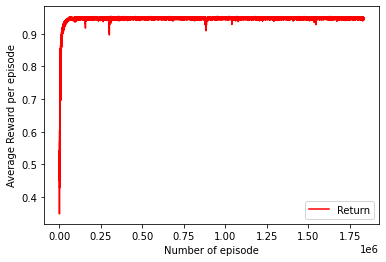

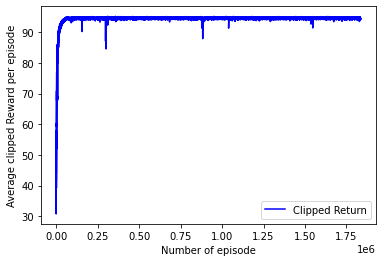

In [53]:
num_epis_count = epis_count - 0
bandwidth = 100  # Moving average bandwidth
total_clipped = np.zeros(int(num_epis_count) - bandwidth)
total_rew = np.zeros(int(num_epis_count) - bandwidth)
for i in range(int(num_epis_count) - bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i + bandwidth]) / bandwidth
    total_rew[i] = np.sum(tot_reward[i:i + bandwidth]) / bandwidth
t = np.arange(int(num_epis_count) - bandwidth)
fig = plt.figure()
belplt = plt.plot(t, total_rew[0:int(num_epis_count) - bandwidth], "r", label="Return")
plt.legend()  #handles[likplt,belplt])
print('Running after %d number of episodes' % epis_count)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
fig.savefig('Grid_DDQN-%s.png' %env_name)
fig = plt.figure()
likplt = plt.plot(t, total_clipped[0:num_episode - bandwidth], "b", label="Clipped Return")
plt.legend()  #handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average clipped Reward per episode")
plt.show()
fig.savefig('Grid_Clipped-%s.png' %env_name)